In [59]:
import os
import re
import string
import operator
import contractions
import html

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import jellyfish

from nltk.corpus import stopwords, words

from collections import Counter


In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Data Review

In [3]:
DATA_PATH = '../data/input/raw'

RANDOM_SEED = 42


word_dictionary = list(set(words.words()))

for alphabet in "bcdefghjklmnopqrstuvwxyz":
    word_dictionary.remove(alphabet)

In [4]:
df_train = pd.read_csv(os.path.join(DATA_PATH,'train.csv'), dtype={'id': np.int16, 'target': np.int8})
df_test = pd.read_csv(os.path.join(DATA_PATH,'test.csv'), dtype={'id': np.int16})

In [5]:
display(df_train.info())
display(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int16 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int8  
dtypes: int16(1), int8(1), object(3)
memory usage: 200.9+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int16 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int16(1), object(3)
memory usage: 83.0+ KB


None

In [6]:
# some samples
for i in range(11, 21):
    print("Text: '{}'\nKeyword: '{}'\nTarget: '{}'\n\n".format(df_train['text'][i], df_train['keyword'][i], df_train['target'][i]))

Text: 'Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA DO FVCK #flooding'
Keyword: 'nan'
Target: '1'


Text: '#raining #flooding #Florida #TampaBay #Tampa 18 or 19 days. I've lost count '
Keyword: 'nan'
Target: '1'


Text: '#Flood in Bago Myanmar #We arrived Bago'
Keyword: 'nan'
Target: '1'


Text: 'Damage to school bus on 80 in multi car crash #BREAKING '
Keyword: 'nan'
Target: '1'


Text: 'What's up man?'
Keyword: 'nan'
Target: '0'


Text: 'I love fruits'
Keyword: 'nan'
Target: '0'


Text: 'Summer is lovely'
Keyword: 'nan'
Target: '0'


Text: 'My car is so fast'
Keyword: 'nan'
Target: '0'


Text: 'What a goooooooaaaaaal!!!!!!'
Keyword: 'nan'
Target: '0'


Text: 'this is ridiculous....'
Keyword: 'nan'
Target: '0'




## Missing values
***

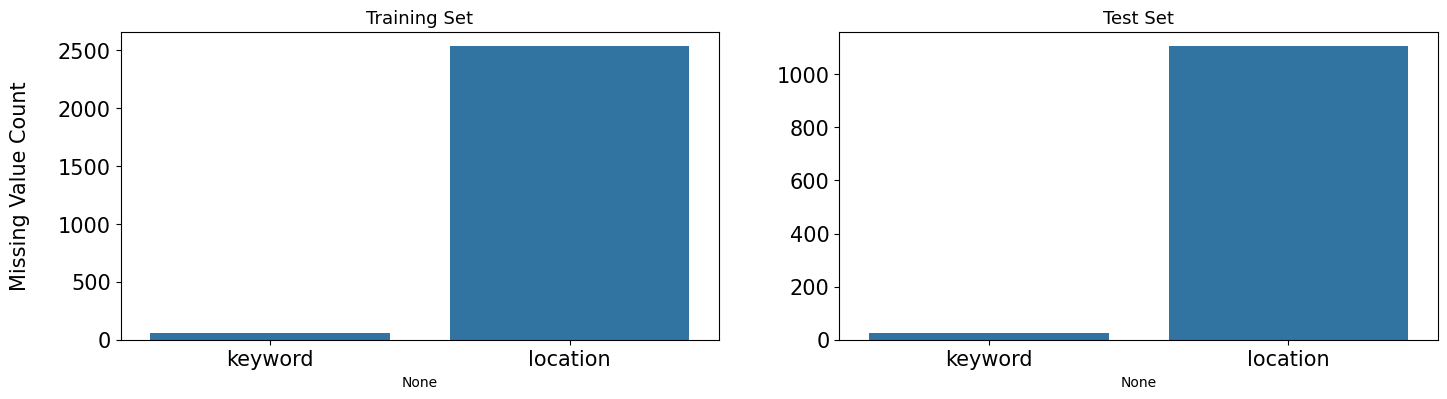

In [7]:
missing_cols = ['keyword', 'location']

fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)

sns.barplot(x=df_train[missing_cols].isnull().sum().index,
            y=df_train[missing_cols].isnull().sum().values, ax=axes[0])

sns.barplot(x=df_test[missing_cols].isnull().sum().index, 
            y=df_test[missing_cols].isnull().sum().values, ax=axes[1])

axes[0].set_ylabel('Missing Value Count', size=15, labelpad=20)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Training Set', fontsize=13)
axes[1].set_title('Test Set', fontsize=13)

plt.show()

for df in [df_train, df_test]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'no_{col}')

# Target

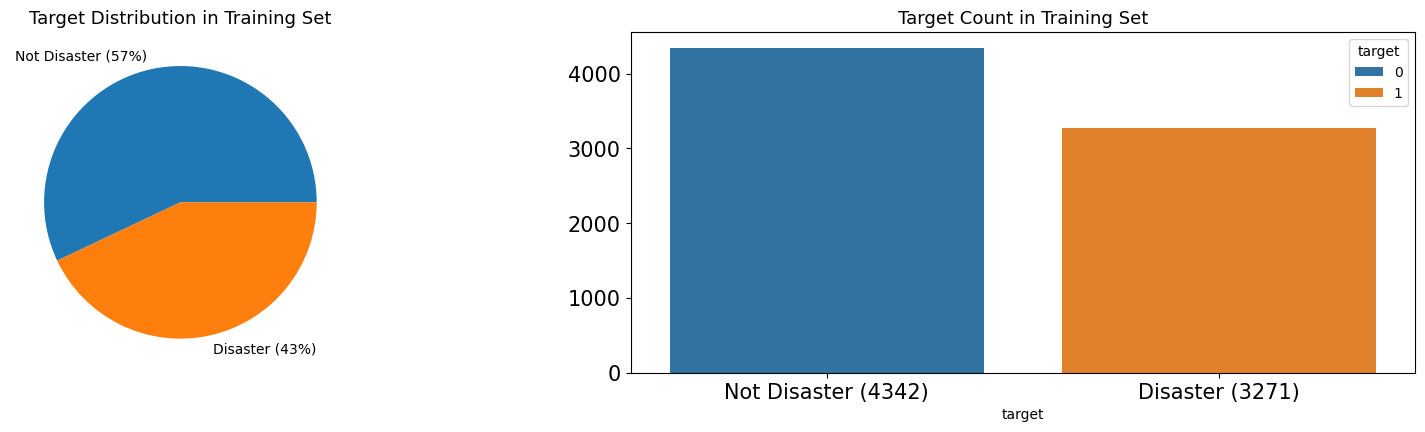

In [8]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

df_train.groupby('target').count()['id'].plot(kind='pie', ax=axes[0], labels=['Not Disaster (57%)', 'Disaster (43%)'])
sns.countplot(x=df_train['target'], hue=df_train['target'], ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticks((0, 1))
axes[1].set_xticklabels([f'Not Disaster ({df_train["target"].value_counts().loc[0]})', 
                         f'Disaster ({df_train["target"].value_counts().loc[1]})'])
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in Training Set', fontsize=13)
axes[1].set_title('Target Count in Training Set', fontsize=13)

plt.show()

# Duplicates and Similarity
***

In [9]:
# dict of indexes of df where "text" is duplicated
duplicates = {}
temp = []

for i in range(len(df_train)):
    s_i = df_train.iloc[i, 3]
    
    for j in range(i+1, len(df_train)):
        s_j = df_train.iloc[j, 3]
        
        if s_i == s_j and i not in temp:
            temp.append(j)
            try:
                duplicates[i].append(j)
            except KeyError:
                duplicates[i] = [i, j]
                
            #print(s_i)

In [10]:
for ids in duplicates.values():
    display(df_train.loc[ids])

id keyword        location                                               text  target
40  59  ablaze  Live On Webcam  Check these out: http://t.co/rOI2NSmEJJ http:/...       0
48  68  ablaze  Live On Webcam  Check these out: http://t.co/rOI2NSmEJJ http:/...       0

id     keyword location                                               text  target
106  156  aftershock       US  320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...       0
115  165  aftershock       US  320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...       0

id     keyword     location                                               text  target
118  171  aftershock  Switzerland  320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...       0
119  172  aftershock  Switzerland  320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...       0

id              keyword     location                                               text  target
147  211  airplane%20accident  no_location  Experts in France begin examining airplane deb...       1
164  238  airplane%20accident  no_location  Experts in France begin examining airplane deb...       1

id       keyword     location                        text  target
610  881  bioterrorism  no_location  To fight bioterrorism sir.       1
624  898  bioterrorism  no_location  To fight bioterrorism sir.       0
630  907  bioterrorism  no_location  To fight bioterrorism sir.       1
634  916  bioterrorism  no_location  To fight bioterrorism sir.       0

id  keyword     location                                               text  target
1134  1634  bombing  no_location  Japan on Thursday marks the 70th anniversary o...       1
1156  1665  bombing    Singapore  Japan on Thursday marks the 70th anniversary o...       1

id            keyword        location                                               text  target
1172  1689  bridge%20collapse  Mumbai , India  Warne shocked over Australia's epic collapse a...       1
1623  2346           collapse  Mumbai , India  Warne shocked over Australia's epic collapse a...       1

id              keyword                location                                               text  target
1197  1723  buildings%20burning  Mackay, QLD, Australia  Mmmmmm I'm burning.... I'm burning buildings I...       1
1331  1922  burning%20buildings  Mackay, QLD, Australia  Mmmmmm I'm burning.... I'm burning buildings I...       0

id              keyword location                                               text  target
1199  1725  buildings%20burning       NJ  @themagickidraps not upset with a rally upset ...       1
1343  1941  burning%20buildings       NJ  @themagickidraps not upset with a rally upset ...       1

id              keyword     location                                               text  target
1201  1727  buildings%20burning  Madison, GA  @_minimehh @cjoyner I must be overlooking the ...       1
1356  1957  burning%20buildings  Madison, GA  @_minimehh @cjoyner I must be overlooking the ...       1

id              keyword     location                                               text  target
1202  1728  buildings%20burning  no_location  @fewmoretweets all lives matter. Just not a fa...       1
1335  1929  burning%20buildings  no_location  @fewmoretweets all lives matter. Just not a fa...       1

id              keyword        location                                               text  target
1204  1733  buildings%20burning  St Charles, MD  I'm mentally preparing myself for a bomb ass s...       0
1332  1924  burning%20buildings  St Charles, MD  I'm mentally preparing myself for a bomb ass s...       0

id              keyword location                                               text  target
1213  1750  buildings%20burning  In Hell  Schools in Western Uganda still Burning down B...       1
1360  1962  burning%20buildings  In Hell  Schools in Western Uganda still Burning down B...       1

id              keyword        location                                               text  target
1214  1752  buildings%20burning  Epic City, BB.  I Pledge Allegiance To The P.O.P.E. And The Bu...       0
1365  1968  burning%20buildings  Epic City, BB.  I Pledge Allegiance To The P.O.P.E. And The Bu...       1

id              keyword location                                               text  target
1221  1760  buildings%20burning   dallas  like for the music video I want some real acti...       1
1349  1950  burning%20buildings   dallas  like for the music video I want some real acti...       0

id              keyword                location                                               text  target
1222  1761  buildings%20burning  New Orleans ,Louisiana  Burning buildings? Media outrage? http://t.co/...       1
1345  1943  burning%20buildings  New Orleans ,Louisiana  Burning buildings? Media outrage? http://t.co/...       1

id                keyword   location                                               text  target
1242  1790  buildings%20on%20fire  Scotland   #TweetLikeItsSeptember11th2001 Those two build...       1
1251  1807  buildings%20on%20fire         UK  #TweetLikeItsSeptember11th2001 Those two build...       1

id     keyword     location                                               text  target
1703   2458    collided      Toronto  Police investigating after an e-bike collided ...       1
7611  10872  no_keyword  no_location  Police investigating after an e-bike collided ...       1

id   keyword            location                                               text  target
1704  2459  collided    Peterborough, On  #Newswatch: 2 vehicles collided at Lock and La...       1
1725  2488  collided  Peterborough, Ont.  #Newswatch: 2 vehicles collided at Lock and La...       1

id    keyword        location                                               text  target
1771  2544  collision  Sacramento, CA  Traffic Collision - No Injury: I5 S at I5 S 43...       1
4601  6543     injury  Sacramento, CA  Traffic Collision - No Injury: I5 S at I5 S 43...       1

id     keyword     location                                               text  target
2345  3373  demolition  no_location  General News Û¢åÊ'Demolition of houses on wat...       0
2352  3387  demolition  no_location  General News Û¢åÊ'Demolition of houses on wat...       0

id     keyword        location                                               text  target
2439  3503  derailment  Mumbai (India)  Madhya Pradesh Train Derailment: Village Youth...       1
2441  3505  derailment           India  Madhya Pradesh Train Derailment: Village Youth...       1
2449  3517  derailment     no_location  Madhya Pradesh Train Derailment: Village Youth...       1
2454  3522  derailment           India  Madhya Pradesh Train Derailment: Village Youth...       1
2477  3552  derailment     no_location  Madhya Pradesh Train Derailment: Village Youth...       1

id     keyword     location                                               text  target
2450  3518  derailment  no_location  Madhya Pradesh Train Derailment: Village Youth...       1
2452  3520  derailment  no_location  Madhya Pradesh Train Derailment: Village Youth...       1
2456  3524  derailment  no_location  Madhya Pradesh Train Derailment: Village Youth...       1

id   keyword       location                                               text  target
2646  3798  detonate  Morioh, Japan  @TinyJecht Are you another Stand-user? If you ...       0
2666  3828  detonate  Morioh, Japan  @TinyJecht Are you another Stand-user? If you ...       0
2679  3841  detonate  Morioh, Japan  @TinyJecht Are you another Stand-user? If you ...       0

id   keyword       location                                               text  target
2651  3806  detonate  Morioh, Japan  @spinningbot Are you another Stand-user? If yo...       0
2655  3814  detonate  Morioh, Japan  @spinningbot Are you another Stand-user? If yo...       0
2674  3836  detonate  Morioh, Japan  @spinningbot Are you another Stand-user? If yo...       0

id     keyword              location                                               text  target
2719   3905  devastated  REPUBLICA DOMINICANA  (#LosDelSonido) Obama Declares Disaster for Ty...       1
7034  10080     typhoon  REPUBLICA DOMINICANA  (#LosDelSonido) Obama Declares Disaster for Ty...       1

id     keyword     location                                               text  target
2736   3933  devastated  no_location  abcnews - Obama Declares Disaster for Typhoon-...       1
7026  10071     typhoon  no_location  abcnews - Obama Declares Disaster for Typhoon-...       1

id             keyword     location                                               text  target
2799  4026            disaster  no_location  Top insurer blasts lack of Australian Govt act...       1
5073  7231  natural%20disaster  no_location  Top insurer blasts lack of Australian Govt act...       1

id    keyword                  location                                               text  target
2816  4049  displaced  Pedophile hunting ground  #Myanmar  Displaced #Rohingya at #Sittwe point...       1
2841  4086  displaced  Pedophile hunting ground  #Myanmar  Displaced #Rohingya at #Sittwe point...       1

id    keyword     location                                               text  target
2822  4057  displaced  no_location  #KCA #VoteJKT48ID 12News: UPDATE: A family of ...       1
2828  4064  displaced  no_location  #KCA #VoteJKT48ID 12News: UPDATE: A family of ...       1

id    keyword                  location                                               text  target
2830  4068  displaced  Pedophile hunting ground  .POTUS #StrategicPatience is a strategy for #G...       1
2831  4072  displaced  Pedophile hunting ground  .POTUS #StrategicPatience is a strategy for #G...       1
2832  4076  displaced  Pedophile hunting ground  .POTUS #StrategicPatience is a strategy for #G...       0
2833  4077  displaced  Pedophile hunting ground  .POTUS #StrategicPatience is a strategy for #G...       1

id     keyword                     location                                               text  target
2850  4096   displaced  Na:tinixw / Hoopa, Berkeley  Elem Pomo helping the displaced from the Rocky...       1
3374  4832  evacuation  Na:tinixw / Hoopa, Berkeley  Elem Pomo helping the displaced from the Rocky...       1

id     keyword     location                                               text  target
3046   4373  earthquake  Hawaii, USA  USGS reports a M1.94 #earthquake 5km S of Volc...       1
7135  10220     volcano  Hawaii, USA  USGS reports a M1.94 #earthquake 5km S of Volc...       1

id     keyword           location                                               text  target
3163  4541   emergency  Renfrew, Scotland  @batfanuk we enjoyed the show today. Great fun...       0
3382  4844  evacuation  Renfrew, Scotland  @batfanuk we enjoyed the show today. Great fun...       0

id   keyword     location                                               text  target
3240  4656  engulfed  no_location  He came to a land which was engulfed in tribal...       0
3243  4659  engulfed      Kuwait   He came to a land which was engulfed in tribal...       1
3248  4669  engulfed      Bahrain  He came to a land which was engulfed in tribal...       1
3251  4672  engulfed  no_location  He came to a land which was engulfed in tribal...       0
3261  4684  engulfed  no_location  He came to a land which was engulfed in tribal...       0
3266  4691  engulfed  no_location  He came to a land which was engulfed in tribal...       0

id     keyword         location                                               text  target
3329  4769   evacuated  Portland, Ore.   New evacuation ordered for 25 homes in danger ...       1
3390  4853  evacuation  Portland, Ore.   New evacuation ordered for 25 homes in danger ...       1

id     keyword           location                                               text  target
3388   4850  evacuation  Tri-Cities, Wash.  Evacuation order lifted for town of Roosevelt:...       1
7600  10855  no_keyword        no_location  Evacuation order lifted for town of Roosevelt:...       1

id   keyword     location                                               text  target
3449  4931  exploded  no_location  that exploded &amp; brought about the\nbeginni...       0
3461  4952  exploded  no_location  that exploded &amp; brought about the\nbeginni...       0

id keyword     location                                               text  target
3578  5113   fatal  no_location  11-Year-Old Boy Charged With Manslaughter of T...       1
3589  5127   fatal     Varanasi  11-Year-Old Boy Charged With Manslaughter of T...       1
3591  5130   fatal        Thane  11-Year-Old Boy Charged With Manslaughter of T...       1
3597  5137   fatal  no_location  11-Year-Old Boy Charged With Manslaughter of T...       1
3600  5140   fatal  no_location  11-Year-Old Boy Charged With Manslaughter of T...       1
3603  5144   fatal  no_location  11-Year-Old Boy Charged With Manslaughter of T...       1
3604  5145   fatal    Bangalore  11-Year-Old Boy Charged With Manslaughter of T...       1
3610  5153   fatal      Dimapur  11-Year-Old Boy Charged With Manslaughter of T...       1
3613  5157   fatal  no_location  11-Year-Old Boy Charged With Manslaughter of T...       1
3614  5159   fatal  no_location  11-Year-Old Boy Charged With Manslaughter of T...       1

id       keyword               location                                               text  target
3790  5382  fire%20truck  Orange County, Calif.  #SigAlert: North &amp; Southbound 133 closed b...       1
3795  5387  fire%20truck      Orange County, CA  #SigAlert: North &amp; Southbound 133 closed b...       1

id keyword     location                                               text  target
3985  5662  floods  no_location  Who is bringing the tornadoes and floods. Who ...       1
4013  5699  floods  no_location  Who is bringing the tornadoes and floods. Who ...       0
4019  5710  floods  no_location  Who is bringing the tornadoes and floods. Who ...       0

id    keyword           location                                               text  target
4221  5996  hazardous        no_location  #foodscare #offers2go #NestleIndia slips into ...       1
4239  6023  hazardous  Mysore, Karnataka  #foodscare #offers2go #NestleIndia slips into ...       1
4244  6031  hazardous   New Delhi, Delhi  #foodscare #offers2go #NestleIndia slips into ...       0

id    keyword     location                                               text  target
4232  6012  hazardous  no_location  Caution: breathing may be hazardous to your he...       1
4235  6017  hazardous  no_location  Caution: breathing may be hazardous to your he...       0

id   keyword     location                                               text  target
4284  6087  hellfire  no_location  The Prophet (peace be upon him) said 'Save you...       0
4286  6090  hellfire       Riyadh  The Prophet (peace be upon him) said 'Save you...       0
4292  6097  hellfire  no_location  The Prophet (peace be upon him) said 'Save you...       1
4304  6111  hellfire  no_location  The Prophet (peace be upon him) said 'Save you...       0
4309  6118  hellfire  no_location  The Prophet (peace be upon him) said 'Save you...       0
4318  6132  hellfire  no_location  The Prophet (peace be upon him) said 'Save you...       1

id   keyword     location                                               text  target
4285  6088  hellfire  no_location  Hellfire is surrounded by desires so be carefu...       0
4305  6112  hellfire  no_location  Hellfire is surrounded by desires so be carefu...       1
4313  6125  hellfire  no_location  Hellfire is surrounded by desires so be carefu...       0

id   keyword           location                                               text  target
4288  6092  hellfire  jeddah | Khartoum  Beware of your temper and a loose tongue! Thes...       0
4291  6096  hellfire        no_location  Beware of your temper and a loose tongue! Thes...       0
4303  6110  hellfire        no_location  Beware of your temper and a loose tongue! Thes...       0

id   keyword                    location                                               text  target
4290  6094  hellfire    Jubail IC, Saudi Arabia.  #Allah describes piling up #wealth thinking it...       0
4299  6105  hellfire  ?????? ??? ?????? ????????  #Allah describes piling up #wealth thinking it...       0
4312  6123  hellfire          ?????? ???? ??????  #Allah describes piling up #wealth thinking it...       1

id   keyword     location                                               text  target
4293  6098  hellfire  no_location  Hellfire! We donÛªt even want to think about ...       0
4310  6119  hellfire  no_location  Hellfire! We donÛªt even want to think about ...       0

id   keyword                     location                                               text  target
4294  6099  hellfire                  no_location  Hellfire is surrounded by desires so be carefu...       0
4308  6116  hellfire  ??????????? ???????????..?   Hellfire is surrounded by desires so be carefu...       0

id   keyword     location                                               text  target
4306  6113  hellfire  no_location  Hellfire! We donÛªt even want to think about ...       0
4320  6134  hellfire    Riyadh ')  Hellfire! We donÛªt even want to think about ...       1

id keyword     location                                               text  target
4341  6165  hijack  no_location  Swansea Û÷plot hijack transfer move for South...       1
4351  6181  hijack  no_location  Swansea Û÷plot hijack transfer move for South...       1

id   keyword   location                                               text  target
4379  6220  hijacker  worldwide  RT NotExplained: The only known image of infam...       0
4381  6223  hijacker  worldwide  RT NotExplained: The only known image of infam...       1

id keyword     location                                               text  target
4597  6537  injury  no_location  CLEARED:incident with injury:I-495  inner loop...       1
4605  6548  injury  no_location  CLEARED:incident with injury:I-495  inner loop...       1
4618  6566  injury  no_location  CLEARED:incident with injury:I-495  inner loop...       0

id keyword     location                                               text  target
4623  6571  injury  no_location  incident with injury:I-495  inner loop Exit 31...       1
4631  6582  injury  no_location  incident with injury:I-495  inner loop Exit 31...       1

id        keyword   location                                               text  target
4827  6874  mass%20murder  Anonymous  http://t.co/c1H7JECFrV @RoyalCarribean do your...       1
4834  6881  mass%20murder  Anonymous  http://t.co/c1H7JECFrV @RoyalCarribean do your...       1

id   keyword     location                                               text  target
5281  7547  outbreak  no_location  Families to sue over Legionnaires: More than 4...       1
5292  7559  outbreak  no_location  Families to sue over Legionnaires: More than 4...       1

id   keyword     location                                               text  target
5620  8018  refugees  no_location  wowo--=== 12000 Nigerian refugees repatriated ...       1
5641  8044  refugees  no_location  wowo--=== 12000 Nigerian refugees repatriated ...       0

id keyword          location                                               text  target
5652  8064  rescue  Toronto, Ontario  UD: Rescue (Structural Collapse) - Scott Road ...       1
5665  8084  rescue  Toronto, Ontario  UD: Rescue (Structural Collapse) - Scott Road ...       1

id   keyword     location                                               text  target
5716  8158  rescuers  no_location  VIDEO: 'We're picking up bodies from water': R...       1
5720  8163  rescuers  no_location  VIDEO: 'We're picking up bodies from water': R...       1
5723  8168  rescuers  no_location  VIDEO: 'We're picking up bodies from water': R...       1
5734  8183  rescuers  no_location  VIDEO: 'We're picking up bodies from water': R...       1

id keyword location                                               text  target
5742  8196    riot    India  Stuart Broad Takes Eight Before Joe Root Runs ...       0
5771  8238    riot   Mumbai  Stuart Broad Takes Eight Before Joe Root Runs ...       0

id  keyword                  location                                               text  target
6091  8698  sinking  Every Where in the World  that horrible sinking feeling when youÛªve be...       1
6094  8702  sinking               no_location  that horrible sinking feeling when youÛªve be...       0
6103  8714  sinking               no_location  that horrible sinking feeling when youÛªve be...       0
6123  8739  sinking                        MA  that horrible sinking feeling when youÛªve be...       1

id         keyword location                                               text  target
6363  9095  suicide%20bomb  Nigeria  #Bestnaijamade: 16yr old PKK suicide bomber wh...       1
6366  9098  suicide%20bomb  Nigeria  #Bestnaijamade: 16yr old PKK suicide bomber wh...       1
6373  9107  suicide%20bomb  Nigeria  #Bestnaijamade: 16yr old PKK suicide bomber wh...       1
6377  9113  suicide%20bomb  Nigeria  #Bestnaijamade: 16yr old PKK suicide bomber wh...       1
6378  9114  suicide%20bomb  Nigeria  #Bestnaijamade: 16yr old PKK suicide bomber wh...       1
6392  9135  suicide%20bomb  Nigeria  #Bestnaijamade: 16yr old PKK suicide bomber wh...       1

id            keyword     location                                               text  target
6434  9207  suicide%20bombing  no_location  'Suicide bombing at [location named]...' #prem...       1
6449  9225  suicide%20bombing  no_location  'Suicide bombing at [location named]...' #prem...       1

id    keyword              location                                               text  target
6614  9470  terrorism  Jeddah_Saudi Arabia.  In #islam saving a person is equal in reward t...       0
6616  9472  terrorism                Riyadh  In #islam saving a person is equal in reward t...       1

id    keyword     location                                               text  target
6652  9531  terrorist  MAD as Hell  RT AbbsWinston: #Zionist #Terrorist kidnapped ...       1
6656  9539  terrorist  MAD as Hell  RT AbbsWinston: #Zionist #Terrorist kidnapped ...       1

id          keyword     location                                               text  target
7097  10169  violent%20storm  no_location  #stormchase Violent Record Breaking EF-5 El Re...       1
7607  10867       no_keyword  no_location  #stormchase Violent Record Breaking EF-5 El Re...       1

id     keyword     location                                               text  target
7140  10229     volcano  no_location  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...       1
7610  10871  no_keyword  no_location  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...       1

id       keyword     location                                               text  target
7315  10470  wild%20fires  no_location  @aria_ahrary @TheTawniest The out of control w...       1
7609  10870    no_keyword  no_location  @aria_ahrary @TheTawniest The out of control w...       1

id   keyword location                                               text  target
7521  10754  wreckage   Punjab  Wreckage 'Conclusively Confirmed' as From MH37...       1
7533  10771  wreckage   Mumbai  Wreckage 'Conclusively Confirmed' as From MH37...       1
7537  10776  wreckage    India  Wreckage 'Conclusively Confirmed' as From MH37...       1

Cases with different targets. Let's label them by ourselves

***disaster*** - a sudden accident or a natural catastrophe that causes great damage or loss of life.

Let use hard votting to left 1 sample per target. Thus when duplicates have equal number of different target then we delete all these duplicates.

In [11]:
ind_to_delete = []


for ids in list(duplicates.values()):
    target_sum = df_train.loc[ids, "target"].values.sum()
    
    if target_sum == len(ids)/2:
        ind_to_delete += ids
        
    elif target_sum > len(ids)/2:
        ind_to_delete += ids[1:]
        df_train.loc[ids[0], "target"] = 1
        
    else:
        ind_to_delete += ids[1:]
        df_train.loc[ids[0], "target"] = 0
    

In [12]:
print("Shape of df - ", df_train.shape)

Shape of df -  (7613, 5)


In [13]:
df_train.drop(ind_to_delete, inplace=True)

In [14]:
print("Shape of df - ", df_train.shape)

Shape of df -  (7493, 5)


In [15]:
df_train.reset_index(drop=True, inplace=True)

In [16]:
# dict of indexes of df where "text" is similar
similar = {}
temp = []

for i in range(len(df_train)):
    s_i = df_train.iloc[i, 3]
    
    for j in range(i+1, len(df_train)):
        s_j = df_train.iloc[j, 3]
        
        if jellyfish.jaro_similarity(s_i, s_j)>0.8 and i not in temp:
            temp.append(j)
            try:
                similar[i].append(j)
            except KeyError:
                similar[i] = [i, j] 
                
#             print(s_i)
#             print(s_j)

In [17]:
for ids in similar.values():
    display(df_train.loc[ids])
    print(df_train.loc[ids[0], 'text'])

id keyword                      location                                               text  target
46  66  ablaze     GREENSBORO,NORTH CAROLINA  How the West was burned: Thousands of wildfire...       1
58  83  ablaze  Edmonton, Alberta - Treaty 6  How the West was burned: Thousands of wildfire...       1

How the West was burned: Thousands of wildfires ablaze in California alone http://t.co/vl5TBR3wbr


id   keyword        location                                               text  target
73  107  accident  North Carolina  I-77 Mile Marker 31 South Mooresville  Iredell...       1
77  113  accident  North Carolina  I-77 Mile Marker 31 to 40 South Mooresville  I...       1

I-77 Mile Marker 31 South Mooresville  Iredell Vehicle Accident Ramp Closed at 8/6 1:18 PM


id   keyword                location                                               text  target
85  128  accident  New Hanover County, NC  FYI CAD:FYI: ;ACCIDENT PROPERTY DAMAGE;NHS;999...       1
90  133  accident  New Hanover County, NC  FYI CAD:FYI: ;ACCIDENT PROPERTY DAMAGE;WPD;160...       1

FYI CAD:FYI: ;ACCIDENT PROPERTY DAMAGE;NHS;999 PINER RD/HORNDALE DR


id     keyword     location                                               text  target
103  151  aftershock  Switzerland  320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/yN...       0
105  156  aftershock           US  320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...       0
113  164  aftershock  Switzerland  320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/M4...       0
114  168  aftershock  no_location  320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/e1...       0
116  171  aftershock  Switzerland  320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...       0

320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/yNXnvVKCDA | @djicemoon | #Dubstep #TrapMusic #DnB #EDM #Dance #IcesÛ_ http://t.co/weQPesENku


id     keyword     location                                text  target
112  163  aftershock      Belgium  Aftershock https://t.co/xMWODFMtUI       0
128  190  aftershock  no_location  Aftershock https://t.co/jV8ppKhJY7       0

Aftershock https://t.co/xMWODFMtUI


id              keyword                  location                                               text  target
133  196  airplane%20accident     19.600858, -99.047821  Experts in France begin examining airplane deb...       1
136  199  airplane%20accident             Palo Alto, CA  Experts in France begin examining airplane deb...       1
143  210  airplane%20accident  Financial News and Views  Experts in France begin examining airplane deb...       1
144  211  airplane%20accident               no_location  Experts in France begin examining airplane deb...       1
148  216  airplane%20accident       Somewhere Out There  Experts in France begin examining airplane deb...       1
156  229  airplane%20accident               no_location  Experts in France begin examining airplane deb...       1

Experts in France begin examining airplane debris found on Reunion Island: French air accident experts o... http://t.co/YVVPznZmXg #news


id              keyword                   location                                               text  target
140  205  airplane%20accident  Hyderabad Telangana INDIA  Horrible Accident  Man Died In Wings of Airpla...       1
150  219  airplane%20accident               Mumbai india  Horrible Accident |  Man Died In Wings of Airp...       1
151  220  airplane%20accident                  sri lanka  Horrible Accident Man Died In Wings of Airplan...       1

Horrible Accident  Man Died In Wings of Airplane (29-07-2015) http://t.co/i7kZtevb2v


id              keyword   location                                               text  target
142  209  airplane%20accident  bangalore  #Horrible #Accident Man Died In Wings Airplane...       1
151  220  airplane%20accident  sri lanka  Horrible Accident Man Died In Wings of Airplan...       1

#Horrible #Accident Man Died In Wings Airplane (29-07-2015) #WatchTheVideo http://t.co/p64xRVgJIk


id    keyword     location                                               text  target
168  247  ambulance      Jackson  http://t.co/AY6zzcUpnz Twelve feared killed in...       1
179  262  ambulance    Amsterdam  http://t.co/7xGLah10zL Twelve feared killed in...       1
186  269  ambulance  no_location  http://t.co/FCqmKFfflW Twelve feared killed in...       1

http://t.co/AY6zzcUpnz Twelve feared killed in Pakistani air ambulance helicopter crash http://t.co/sC9dNS41Mc


id    keyword           location                                               text  target
170  249  ambulance        no_location  Twelve feared killed in Pakistani air ambulanc...       1
173  253  ambulance        no_location  Twelve feared killed in Pakistani air ambulanc...       1
187  270  ambulance            Karachi  Twelve feared killed in Pakistani air ambulanc...       1
199  287  ambulance                USA  Twelve feared killed in Pakistani air ambulanc...       1
200  289  ambulance  Hannover, Germany  Twelve feared killed in Pakistani air ambulanc...       1

Twelve feared killed in Pakistani air ambulance helicopter crash - Reuters http://t.co/mDnUGVuBwN #yugvani


id    keyword                      location                                               text  target
174  254  ambulance  Happily Married with 2 kids   AMBULANCE SPRINTER AUTOMATIC FRONTLINE VEHICLE...       0
182  265  ambulance  Happily Married with 2 kids   AMBULANCE SPRINTER AUTOMATIC FRONTLINE VEHICLE...       0
188  271  ambulance  Happily Married with 2 kids   AMBULANCE SPRINTER AUTOMATIC FRONTLINE VEHICLE...       0
189  272  ambulance  Happily Married with 2 kids   AMBULANCE SPRINTER AUTOMATIC FRONTLINE VEHICLE...       0

AMBULANCE SPRINTER AUTOMATIC FRONTLINE VEHICLE CHOICE OF 14 LEZ COMPLIANT | eBay http://t.co/4evTTqPEia


id    keyword     location                                               text  target
193  277  ambulance        L. A.  http://t.co/pWwpUm6RBj Twelve feared killed in...       1
198  285  ambulance  no_location  http://t.co/X5YEUYLT1X Twelve feared killed in...       1
203  293  ambulance        Playa  http://t.co/J8TYT1XRRK Twelve feared killed in...       1

http://t.co/pWwpUm6RBj Twelve feared killed in Pakistani air ambulance helicopter crash http://t.co/ySpON4d6Qo


id      keyword                    location                                               text  target
212  307  annihilated  V-RP @OZRP_ ?MV, AU, R18+?  *to Luka* They should all die! All of them! Ev...       0
224  327  annihilated                Trancy Manor  (To Luka) 'They should all die! All of them! E...       0

*to Luka* They should all die! All of them! Everything annihilated! - Alois Trancy


id      keyword     location                                               text  target
214  310  annihilated       Boston  Cop pulls drunk driver to safety SECONDS befor...       1
216  313  annihilated  no_location  Cop pulls drunk driver to safety SECONDS befor...       1
234  338  annihilated  no_location  Cop pulls drunk driver to safety SECONDS befor...       1

Cop pulls drunk driver to safety SECONDS before his car is hit by train. http://t.co/tHrhKHOGcUåÊ http://t.co/tZSZmF2qxE via @ViralSpell


id       keyword                       location                                               text  target
242  349  annihilation                    no_location  U.S National Park Services Tonto National Fore...       0
246  355  annihilation                    no_location  U.S National Park Services Tonto National Fore...       0
247  356  annihilation  CA physically- Boston Strong?  U.S National Park Services Tonto National Fore...       1
249  360  annihilation                    no_location  U.S National Park Services Tonto National Fore...       1
255  370  annihilation                   Coolidge, AZ  U.S National Park Services Tonto National Fore...       0
262  384  annihilation              Tacoma,Washington  U.S National Park Services Tonto National Fore...       0
266  393  annihilation   BIG D  HOUSTON/BOSTON/DENVER  U.S National Park Services Tonto National Fore...       0
267  394  annihilation                   Chandler, AZ  U.S National Park Services Tonto National Fore...       1

U.S National Park Services Tonto National Forest: Stop the Annihilation of the Salt River Wild Horse... http://t.co/6LoJOoROuk via @Change


id       keyword         location                                               text  target
244  353  annihilation  Subconscious LA  World Annihilation vs Self Transformation http...       0
265  390  annihilation  Subconscious LA  World Annihilation vs Self Transformation http...       1

World Annihilation vs Self Transformation http://t.co/pyehwodWun Aliens Attack to Exterminate Humans http://t.co/pB2N77nSKz


id       keyword     location                                               text  target
253  365  annihilation  no_location  @willienelson We need help! Horses will die!Pl...       1
257  372  annihilation  no_location  @Barbi_Twins We need help-horses will die! Ple...       0
258  375  annihilation  no_location  @Whippenz We need help! Horses will die!Please...       0

@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu


id     keyword                   location                                               text  target
300  446  armageddon  California, United States  #PBBan (Temporary:300) avYsss @'aRmageddon | D...       0
301  447  armageddon  California, United States  #PBBan (Temporary:300) Russaky89 @'aRmageddon ...       0
313  462  armageddon  California, United States  #PBBan (Temporary:300) hyider_ghost2 @'aRmaged...       1
315  465  armageddon  California, United States  #PBBan (Temporary:300) fighterdena @'aRmageddo...       0

#PBBan (Temporary:300) avYsss @'aRmageddon | DO NOT KILL | FLAGS ONLY | Fast XP' for Reason


id     keyword          location                                               text  target
302  448  armageddon  #FLIGHTCITY UK    ((OFFICIAL VID)) #DoubleCups &gt;&gt; https://...       0
334  485  armageddon  #FLIGHTCITY UK    (OFFICIAL VID) &gt; #DoubleCups &gt;&gt; https...       0

((OFFICIAL VID)) #DoubleCups &gt;&gt; https://t.co/lfKMTZaEkk &gt;&gt; @TrubGME Prod @THISIZBWRIGHT &gt;&gt; #ARMAGEDDON


id     keyword     location                                               text  target
308  455  armageddon  no_location  RT @Ophiuchus2613: #Love #TrueLove #romance li...       0
314  463  armageddon  no_location  RT @RTRRTcoach: #Love #TrueLove #romance lith ...       0

RT @Ophiuchus2613: #Love #TrueLove #romance lith  #Voodoo #seduction #Astrology #RTRRT #LOTZ 9-11 #apocalypse #Armageddon #1008plaÛ_


id keyword     location                                               text  target
342  496    army  no_location  Beyonce Is my pick for http://t.co/nnMQlz91o9 ...       0
360  522    army  no_location  Beyonce Is my pick for http://t.co/nnMQlz91o9 ...       0
366  530    army  no_location  Beyonce Is my pick for http://t.co/nnMQlz91o9 ...       0
368  533    army  no_location  Beyonce Is my pick for http://t.co/nnMQlz91o9 ...       0

Beyonce Is my pick for http://t.co/nnMQlz91o9 Fan Army #Beyhive http://t.co/o91f3cYy0R 77


id keyword     location                                               text  target
343  498    army  no_location  One Direction Is my pick for http://t.co/q2eBl...       0
347  503    army  no_location  One Direction Is my pick for http://t.co/q2eBl...       0
354  516    army  no_location  One Direction Is my pick for http://t.co/q2eBl...       1
356  518    army  no_location  One Direction Is my pick for http://t.co/q2eBl...       0
361  523    army  no_location  One Direction Is my pick for http://t.co/q2eBl...       0
363  526    army  no_location  One Direction Is my pick for http://t.co/y9Wvq...       0
374  543    army  no_location  One Direction Is my pick for http://t.co/q2eBl...       0
375  544    army           ?   One Direction Is my pick for http://t.co/iMHFd...       0

One Direction Is my pick for http://t.co/q2eBlOKeVE Fan Army #Directioners http://t.co/eNCmhz6y34 x1402


id keyword     location                                               text  target
344  499    army  no_location  5 Seconds of Summer Is my pick for http://t.co...       0
359  521    army  Mexico! ^_^  5 Seconds of Summer Is my pick for http://t.co...       0

5 Seconds of Summer Is my pick for http://t.co/J6WsePTXgA Fan Army #5SOSFAM http://t.co/qWgIwC9w7Z


id keyword     location                                               text  target
345  501    army  no_location  22.Beyonce Is my pick for http://t.co/thoYhrHk...       0
346  502    army  no_location  17.Beyonce Is my pick for http://t.co/thoYhrHk...       0
367  531    army  no_location  7.Beyonce Is my pick for http://t.co/thoYhrHkf...       0
369  535    army  no_location  6.Beyonce Is my pick for http://t.co/thoYhrHkf...       0

22.Beyonce Is my pick for http://t.co/thoYhrHkfJ Fan Army #Beyhive http://t.co/WvJ39a3BGM


id keyword     location                                               text  target
365  528    army     New York  WWI WWII JAPANESE ARMY NAVY MILITARY JAPAN LEA...       0
372  540    army     New York  WWI WWII JAPANESE ARMY NAVY MILITARY JAPAN LEA...       0
373  542    army  no_location  WWI WWII JAPANESE ARMY NAVY MILITARY JAPAN LEA...       0

WWI WWII JAPANESE ARMY NAVY MILITARY JAPAN LEATHER WATCH WAR MIDO WW1 2 - Full read by eBay http://t.co/F9j3l2Yjl4 http://t.co/mwwWOWCayO


id keyword           location                                               text  target
382  559   arson        no_location  Mourning notices for stabbing arson victims st...       1
383  560   arson          Jerusalem  Mourning notices for stabbing arson victims st...       1
393  574   arson          Jerusalem  Mourning notices for stabbing arson victims st...       0
399  580   arson        no_location  Mourning notices for stabbing arson victims st...       1
402  584   arson  Jerusalem, Israel  Mourning notices for stabbing arson victims st...       1

Mourning notices for stabbing arson victims stir Û÷politics of griefÛª in Israel http://t.co/eug6zHciun


id keyword         location                                               text  target
385  563   arson    Milwaukee, WI  Owner of Chicago-Area Gay Bar Admits to Arson ...       0
396  577   arson  Los Angeles, CA  Owner of Chicago-Area Gay Bar Admits to Arson ...       0
400  581   arson          Chicago  Owner of Chicago-Area Gay Bar Admits to Arson ...       0
401  583   arson           EARTH   Owner of Chicago-Area Gay Bar Admits to Arson ...       0
403  585   arson      no_location  Owner of Chicago-Area Gay Bar Admits to Arson ...       1

Owner of Chicago-Area Gay Bar Admits to Arson Scheme http://t.co/MYhOHvrHiL #LGBT | https://t.co/TM5HTHFDO0


id   keyword           location                                               text  target
387  565     arson  Republic of Texas  Arson suspect linked to 30 fires caught in Nor...       1
404  588     arson        Menasha, WI  Arson suspect linked to 30 fires caught in Nor...       1
406  592     arson        no_location  Arson suspect linked to 30 fires caught in Nor...       1
407  594     arson        no_location  Arson suspect linked to 30 fires caught in Nor...       1
413  606  arsonist        Bleak House  Arson suspect linked to 30 fires caught in Nor...       1

Arson suspect linked to 30 fires caught in Northern California http://t.co/EJ2GHNAfHY


id keyword        location                                               text  target
391  570   arson  Eldoret, kenya  #Kisii Police in Kisii hunt for students over ...       1
398  579   arson  Eldoret, kenya  #Kisii Police in Kisii hunt for students over ...       1

#Kisii Police in Kisii hunt for students over failed arson plot: Police in Kisii hunt for students... http://t.co/m5SbFRrSn7 #CountyNews


id   keyword    location                                               text  target
410  600  arsonist       Earth  Alleged East Bay serial arsonist arrested http...       1
430  630  arsonist  California  Alleged East Bay serial arsonist arrested #San...       1

Alleged East Bay serial arsonist arrested http://t.co/WR48AQTUm7


id keyword         location                                               text  target
455     662  attack       Seattle WA  BREAKING: Obama Officials GAVE Muslim Terroris...       1
7080  10305  weapon  Central Florida  BREAKING: Obama Officials GAVE Muslim Terroris...       1

BREAKING: Obama Officials GAVE Muslim Terrorist the Weapon Used in Texas Attack http://t.co/qi8QDw5dFG


id   keyword                        location                                               text  target
486  710  attacked                  AKRON OHIO USA  Christian Attacked by Muslims at the Temple Mo...       1
487  712  attacked                     no_location  Christian Attacked by Muslims at the Temple Mo...       1
488  713  attacked                     no_location  Christian Attacked by Muslims at the Temple Mo...       1
491  717  attacked                          London  Christian Attacked by Muslims at the Temple Mo...       1
495  724  attacked                     no_location  Christian Attacked by Muslims at the Temple Mo...       1
496  725  attacked                LEALMAN, FLORIDA  Christian Attacked by Muslims at the Temple Mo...       1
500  729  attacked  Groningen, Netherlands, Europe  Christian Attacked by Muslims at the Temple Mo...       1
501  730  attacked          Livingston, IL  U.S.A.  Christian Attacked by Muslims at the Temple Mo...       1
502  731  attacked                        Arundel   Christian Attacked by Muslims at the Temple Mo...       1
504  734  attacked                         America  Christian Attacked by Muslims at the Temple Mo...       1
506  736  attacked                             USA  Christian Attacked by Muslims at the Temple Mo...       1
507  737  attacked                          israel  Christian Attacked by Muslims at the Temple Mo...       1
508  738  attacked            The Hammock, FL, USA  Christian Attacked by Muslims at the Temple Mo...       1
510  740  attacked          SÌ£o Paulo SP,  Brasil  Christian Attacked by Muslims at the Temple Mo...       1
512  745  attacked                    Oslo, Norway  Christian Attacked by Muslims at the Temple Mo...       1

Christian Attacked by Muslims at the Temple Mount after Waving Israeli Flag via Pamela Geller - ... http://t.co/5qYcZyWKgG


id    keyword                 location                                               text  target
521  759  avalanche                       UK  Musician Kalle Mattson Recreates 34 Classic Al...       0
528  774  avalanche  Jersey City, New Jersey  Musician Kalle Mattson Recreates 34 Classic Al...       0

Musician Kalle Mattson Recreates 34 Classic Album Covers in Clever Music Video for 'Avalanche' http://t.co/yDJpOpH1DW


id keyword  location                                               text  target
543  796  battle  New York  STAR WARS POWER OF THE JEDI COLLECTION 1 BATTL...       1
565  822  battle  New York  STAR WARS POWER OF THE JEDI COLLECTION 1 BATTL...       0

STAR WARS POWER OF THE JEDI COLLECTION 1 BATTLE DROID HASBRO - Full read by eBay http://t.co/xFguklrlTf http://t.co/FeGu8hWMc4


id   keyword           location                                               text  target
546    799    battle  UK Great Britain   I added a video to a @YouTube playlist http://...       0
2276  3300  demolish             sweden  I added a video to a @YouTube playlist http://...       0

I added a video to a @YouTube playlist http://t.co/wedWyn9kfS World Of Tanks - Battle Assistant Mod Bat Chat Arti kaboom


id    keyword location                                               text  target
552    805     battle      USA  Black Eye 9: A space battle occurred at Star M...       1
566    823     battle      USA  Black Eye 9: A space battle occurred at Star O...       0
2551  3704  destroyed      USA  Black Eye 9: A space battle occurred at Star O...       0
2559  3718  destroyed      USA  Black Eye 9: A space battle occurred at Star O...       0
2560  3719  destroyed      USA  Black Eye 9: A space battle occurred at Star O...       0
2562  3722  destroyed      USA  Black Eye 9: A space battle occurred at Star O...       0
2573  3738  destroyed      USA  Black Eye 9: A space battle occurred at Star O...       0
2576  3742  destroyed      USA  Black Eye 9: A space battle occurred at Star O...       0
2580  3747  destroyed      USA  Black Eye 9: A space battle occurred at Star O...       0

Black Eye 9: A space battle occurred at Star M27329 involving 1 fleets totaling 1236 ships with 7 destroyed


id    keyword         location                                               text  target
569  829  bioterror  Washington D.C.  News: FedEx no longer to transport bioterror g...       1
576  838  bioterror              USA  #News FedEx no longer to transport bioterror g...       1
583  848  bioterror           iTunes  #world FedEx no longer to transport bioterror ...       1
587  853  bioterror      no_location  #world FedEx no longer to transport bioterror ...       0
588  856  bioterror               US  FedEx no longer to transport bioterror germs i...       1

News: FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps http://t.co/xteZGjfs8A


id    keyword     location                                               text  target
570  832  bioterror           NC  FedEx no longer will transport bioterror germs...       0
593  864  bioterror  Atlanta, GA  FedEx no longer will transport bioterror germs...       0

FedEx no longer will transport bioterror germs http://t.co/qfjjDxes7G via @USATODAY


id    keyword            location                                               text  target
572  834  bioterror  West Virginia, USA  FedEx no longer to transport bioterror germs i...       1
580  843  bioterror      Wilmington, DE  FedEx no longer to transport bioterror germs i...       0
584  849  bioterror         no_location  FedEx no longer to transport bioterror germs i...       1
588  856  bioterror                  US  FedEx no longer to transport bioterror germs i...       1
597  870  bioterror  Melbourne, Florida  FedEx no longer to transport bioterror germs i...       1
599  872  bioterror         no_location  FedEx no longer to transport bioterror germs i...       1
600  873  bioterror    Over the Moon...  #FedEx no longer to transport bioterror germs ...       1
602  875  bioterror         no_location  FedEx no longer to transport bioterror germs i...       0
604  877  bioterror         no_location  FedEx no longer to transport bioterror germs i...       1

FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps http://t.co/HQsU8LWltH via @usatoday


id    keyword     location                                               text  target
578  841  bioterror  Atlanta, GA  FedEx no longer will ship potential bioterror ...       0
590  859  bioterror  no_location  FedEx no longer will ship potential bioterror ...       0

FedEx no longer will ship potential bioterror pathogens http://t.co/CHORr2XOVp via @AtlBizChron


id    keyword             location                                               text  target
595  867  bioterror  Arkansas, Jonesboro  USATODAY: On today's #frontpage: #Bioterror la...       1
603  876  bioterror       Espoo, Finland  USATODAY: On today's #frontpage: #Bioterror la...       1

USATODAY: On today's #frontpage: #Bioterror lab faced secret sanctions. #RickPerry doesn't make the cut for FoxNewÛ_ http://t.co/5uKOHk7SoB


id       keyword     location                                               text  target
609  885  bioterrorism  no_location  @CAgov If 90BLKs&amp;8WHTs colluded 2 take WHT...       1
626  915  bioterrorism  no_location  @HowardU If 90BLKs&amp;8WHTs colluded 2 take W...       1
627  919  bioterrorism  no_location  @cspanwj If 90BLKs&amp;8WHTs colluded 2 take W...       1

@CAgov If 90BLKs&amp;8WHTs colluded 2 take WHT F @USAgov AUTH Hostage&amp;2 make her look BLK w/Bioterrorism&amp;use her lgl/org IDis ID still hers?@VP


id keyword   location                                               text  target
645  945   blaze  Australia  Property losses from California wildfire nearl...       1
661  964   blaze   Karachi   Property losses from #California wildfire near...       1

Property losses from California wildfire nearly double as week-old blaze rages http://t.co/E0UUsnpsq5


id  keyword     location                                               text  target
674  984  blazing  no_location  Morgan Silver Dollar 1880 S Gem BU DMPL Cameo ...       0
675  985  blazing     New York  Morgan Silver Dollar 1880 S Gem BU DMPL Cameo ...       0

Morgan Silver Dollar 1880 S Gem BU DMPL Cameo Rev Blazing MS+++++ High grade! - Full read Û_ http://t.co/IU9baFDXeY http://t.co/AphqU5SvET


id     keyword     location                                               text  target
944  1379  body%20bag     New York  New Ladies Shoulder Tote Handbag Women Cross B...       0
945  1380  body%20bag     New York  New Ladies Shoulder Tote Handbag Women Cross B...       0
954  1391  body%20bag  no_location  New Ladies Shoulder Tote Handbag Women Cross B...       0
958  1396  body%20bag     New York  New Ladies Shoulder Tote Handbag Faux Leather ...       0
975  1422  body%20bag     New York  New Ladies Shoulder Tote Handbag Faux Leather ...       0

New Ladies Shoulder Tote Handbag Women Cross Body Bag Faux Leather Fashion Purse - Full reÛ_ http://t.co/y87Gi3BRlV http://t.co/1zbhVDCXzS


id     keyword  location                                               text  target
949  1384  body%20bag  New York  Louis Vuitton Monogram Sophie Limited Edition ...       0
950  1385  body%20bag  New York  Louis Vuitton Monogram Sophie Limited Edition ...       0
964  1407  body%20bag  New York  Louis Vuitton Monogram Sophie Limited Edition ...       0
972  1419  body%20bag  New York  Louis Vuitton Monogram Sophie Limited Edition ...       0

Louis Vuitton Monogram Sophie Limited Edition Clutch Cross body Bag - Full read by eBay http://t.co/JrxgoLnPqw http://t.co/Lin16KvZbn


id     keyword     location                                               text  target
955  1393  body%20bag  no_location  new summer long thin body bag hip A word skirt...       0
962  1405  body%20bag  no_location  new summer long thin body bag hip A word skirt...       0

new summer long thin body bag hip A word skirt Blue http://t.co/lvKoEMsq8m http://t.co/CjiRhHh4vj


id     keyword         location                                               text  target
956  1394  body%20bag  California, USA  å¤} New Ladies Shoulder Tote #Handbag Faux Lea...       0
961  1402  body%20bag         Paignton  ?? New Ladies Shoulder Tote #Handbag Faux Leat...       0
963  1406  body%20bag  California, USA  ?Ìü New Ladies Shoulder Tote #Handbag Faux Lea...       0
966  1409  body%20bag         Paignton  ?? New Ladies Shoulder Tote #Handbag Faux Leat...       1
969  1414  body%20bag         Paignton  å_? New Ladies Shoulder Tote #Handbag Faux Lea...       0
973  1420  body%20bag         Paignton  ?? New Ladies Shoulder Tote #Handbag Faux Leat...       0

å¤} New Ladies Shoulder Tote #Handbag Faux Leather Hobo Purse Cross Body Bag #Womens http://t.co/UooZXauS26 http://t.co/6MGBizjfgd RT enÛ_


id      keyword        location                                               text  target
1014  1484  body%20bags  United Kingdom  Womens Buckle Casual Stylish Shoulder Handbags...       0
1022  1495  body%20bags  United Kingdom  Womens Buckle Casual Stylish Shoulder Handbags...       0
1037  1511  body%20bags     no_location  Womens Buckle Casual Stylish Shoulder Handbags...       0

Womens Buckle Casual Stylish Shoulder Handbags Pockets Cross Body Bags Green http://t.co/pYee94nuRe


id      keyword         location                                               text  target
1043  1520  body%20bags  California, USA  Womens Handbags Cross Body Geometric Pattern S...       0
1045  1522  body%20bags      no_location  Womens Handbags Cross Body Geometric Pattern S...       0

Womens Handbags Cross Body Geometric Pattern Satchel Totes Shoulder Bags White http://t.co/qvSp6b2qSU http://t.co/0s6ydFrWDQ RT gasparcÛ_


id keyword     location                                               text  target
1056  1535    bomb  no_location  The Guardian view on the Hiroshima legacy: sti...       1
1082  1575    bomb  no_location  The Guardian view on the Hiroshima legacy: sti...       1

The Guardian view on the Hiroshima legacy: still in the shadow of the bomb | Editorial: The world longs to cas... http://t.co/RhxMGhsPd7


id keyword     location                                               text  target
1062  1545    bomb    Australia  New Documents Found Pointing To Japan's WWII A...       1
1067  1554    bomb  no_location  New Documents Found Pointing To Japan's WWII A...       1

New Documents Found Pointing To Japan's WWII Atomic Bomb Program http://t.co/IucPcSfbMT


id  keyword     location                                               text  target
1125  1633  bombing  no_location  The cryptic words that guided pilots on the Hi...       1
1130  1639  bombing  no_location  The cryptic words that guided pilots on the Hi...       1
1134  1646  bombing  no_location  The cryptic words that guided pilots on the Hi...       1

The cryptic words that guided pilots on the Hiroshima bombing mission http://t.co/FCe0K1Ihti


id  keyword           location                                               text  target
1136  1648  bombing        no_location  Japan Marks 70th Anniversary of Hiroshima Atom...       1
1137  1649  bombing  Overland Park, KS  Japan Marks 70th Anniversary of Hiroshima Atom...       1
1138  1650  bombing               SWMO  Japan Marks 70th Anniversary of Hiroshima Atom...       1
1139  1652  bombing        Puerto Rico  Japan Marks 70th Anniversary of Hiroshima Atom...       1

Japan Marks 70th Anniversary of Hiroshima Atomic Bombing http://t.co/93vqkdFgnr


id  keyword        location                                               text  target
1143  1658  bombing     no_location  Japan marks 70th anniversary of Hiroshima atom...       1
1144  1660  bombing  Washington, DC  #Japan marks 70th anniversary of #Hiroshima at...       1
1150  1670  bombing   United States  Japan marks 70th anniversary of Hiroshima atom...       1

Japan marks 70th anniversary of Hiroshima atomic bombing http://t.co/a2SS7pr4gW


id            keyword       location                                               text  target
1151  1671  bridge%20collapse  VitÌ_ria (ES)  A Marshall Plan for the United States by Dambi...       0
1184  1719  bridge%20collapse    no_location  A Marshall Plan for the United States by Dambi...       0

A Marshall Plan for the United States by Dambisa Moyo via @ProSyn #oped http://t.co/GnPStnvi5G via @po_st


id            keyword     location                                               text  target
1153  1673  bridge%20collapse  no_location  Australia's Ashes disaster - how the collapse ...       1
1173  1702  bridge%20collapse           UK  Australia's Ashes disaster - how the collapse ...       1

Australia's Ashes disaster - how the collapse unfolded at Trent Bridge... http://t.co/Dq3ddGvgBF
 #cricket


id            keyword          location                                               text  target
1155  1676  bridge%20collapse  New Delhi, Delhi  Ashes 2015: AustraliaÛªs collapse at Trent Br...       1
1177  1707  bridge%20collapse       no_location  Ashes 2015: AustraliaÛªs collapse at Trent Br...       0

Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/985DwWPdEt


id            keyword             location                                               text  target
1156  1677  bridge%20collapse  Buscame EL tu Melte  2 Injured 1 missing in bridge collapse in cent...       1
1166  1692  bridge%20collapse          no_location  2 Injured 1 missing in bridge collapse in cent...       1

2 Injured 1 missing in bridge collapse in central Mexico http://t.co/kHF0iH05A9


id            keyword                  location                                               text  target
1161   1687  bridge%20collapse               no_location  Two giant cranes holding a bridge collapse int...       1
1164   1690  bridge%20collapse               no_location  Two giant cranes holding a bridge collapse int...       1
1167   1693  bridge%20collapse                    Boston  Two giant cranes holding a bridge collapse int...       1
1170   1699  bridge%20collapse                        US  Two giant cranes holding a bridge collapse int...       1
1171   1700  bridge%20collapse               no_location  Two giant cranes holding a bridge collapse int...       1
1175   1705  bridge%20collapse  Playa del Carmen, Mexico  Two giant cranes holding a bridge collapse int...       1
1176   1706  bridge%20collapse               no_location  Two giant cranes holding a bridge collapse int...       1
1182   1716  bridge%20collapse               no_location  Two giant cranes holding a bridge collapse int...       1
7491  10869         no_keyword               no_location  Two giant cranes holding a bridge collapse int...       1

Two giant cranes holding a bridge collapse into nearby homes http://t.co/OQpsvrGbJc


id                keyword            location                                               text  target
1218  1771  buildings%20on%20fire          World Wide  Fire hazard associated with installation of no...       1
1220  1773  buildings%20on%20fire          World Wide  Fire hazard associated with installation of no...       0
1235  1799  buildings%20on%20fire  Brisbane Australia  Fire hazard associated with installation of no...       0

Fire hazard associated with installation of non-compliant external cladding on http://t.co/bTPQdehl3p - By @www.cbplawyers


id keyword                        location                                               text  target
1262  1837  burned  Long Island NY & San Francisco  I spent 17 minutes walking with RunKeeper. 90 ...       0
1268  1847  burned                         Chicago  I spent 15 minutes lifting weights. 43 calorie...       0

I spent 17 minutes walking with RunKeeper. 90 calories burned. #LoseIt


id keyword         location                                               text  target
1264  1840  burned  Gainesville, FL  burned 129 calories doing 24 minutes of Walkin...       1
1271  1852  burned               DC  burned 202 calories doing 30 minutes of Walkin...       0

burned 129 calories doing 24 minutes of Walking 3.5 mph brisk pace #myfitnesspal


id  keyword     location                                         text  target
1309  1911  burning  no_location     Why put out a fire that's still burning?       0
3683  5317     fire  no_location  Why put out a fire when it's still burning.       0

Why put out a fire that's still burning?


id       keyword        location                                               text  target
1348  1975  bush%20fires  Queen Creek AZ  Ted Cruz fires back at Jeb &amp; Bush: ÛÏWe l...       0
1352  1981  bush%20fires     no_location  Ted Cruz fires back at Jeb &amp; Bush: ÛÏWe l...       0
1364  1999  bush%20fires     no_location  Ted Cruz fires back at Jeb &amp; Bush: ÛÏWe l...       0
1368  2006  bush%20fires     no_location  Ted Cruz fires back at Jeb &amp; Bush: ÛÏWe l...       0

Ted Cruz fires back at Jeb &amp; Bush: ÛÏWe lose because of Republicans like Jeb &amp; Mitt.Û [Video] -  http://t.co/BFTHaHLCr0


id     keyword                        location                                               text  target
1371  2010  casualties                     no_location  ??\nWarfighting Robots Could Reduce Civilian C...       1
1375  2016  casualties                 Bronx, New York  Warfighting Robots Could Reduce Civilian Casua...       1
1401  2055  casualties  Williamsbridge, Bronx, New Yor  Warfighting Robots Could Reduce Civilian Casua...       1

??
Warfighting Robots Could Reduce Civilian Casualties So Calling for a Ban Now Is Premature - IEEE Spectrum http://t.co/TzR58B86qz


id     keyword          location                                               text  target
1398  2049  casualties  Afghanistan, USA  #Afghanistan: sharp rise in women and children...       1
1403  2057  casualties       no_location  Afghanistan: sharp rise in women and children ...       1

#Afghanistan: sharp rise in women and children casualties in first half of #2015 http://t.co/LdyWd4ydT9


id     keyword           location                                               text  target
1405  2059    casualty            Nairobi  Train derailment: In Patna no news of any casu...       1
2441  3542  derailment  Minneapolis,MN,US  Train derailment: In Patna no news of any casu...       1

Train derailment: In Patna no news of any casualty so far http://t.co/Yg697fcQGr


id      keyword     location                                               text  target
1446  2116  catastrophe  no_location  #iphone #twist Ultimate #preparedness library:...       0
1459  2134  catastrophe  no_location  #spark #song Ultimate #preparedness library: h...       0

#iphone #twist Ultimate #preparedness library: http://t.co/ksgmY0D0Mx Prepare Yourself For Any Catastrophe. Ov http://t.co/MZK0PFogI7


id       keyword           location                                               text  target
1475  2159  catastrophic        no_location  Learning from the Legacy of a Catastrophic Eru...       1
1483  2173  catastrophic    Quito, Ecuador.  Learning from the Legacy of a Catastrophic Eru...       1
1492  2188  catastrophic       Planet Earth  Learning from the Legacy of a Catastrophic Eru...       1
1493  2189  catastrophic  Paonia, Colorado   Learning from the Legacy of a Catastrophic Eru...       1
1497  2193  catastrophic       Planet Earth  Learning from the Legacy of a Catastrophic Eru...       1
1500  2198  catastrophic       Planet Earth  Learning from the Legacy of a Catastrophic Eru...       1

Learning from the Legacy of a Catastrophic Eruption http://t.co/RbmuCURS2F


id       keyword               location                                               text  target
1479  2164  catastrophic            no_location  The Catastrophic Effects of Hiroshima and Naga...       1
1480  2169  catastrophic            no_location  The Catastrophic Effects of Hiroshima and Naga...       1
1481  2171  catastrophic            no_location  The Catastrophic Effects of Hiroshima and Naga...       1
1484  2174  catastrophic  Inexpressible Island   The Catastrophic Effects of Hiroshima and Naga...       1
1488  2179  catastrophic          United States  The Catastrophic Effects of Hiroshima and Naga...       1
1494  2190  catastrophic            no_location  The Catastrophic Effects of Hiroshima and Naga...       1
1496  2192  catastrophic  Inexpressible Island   The Catastrophic Effects of Hiroshima and Naga...       1

The Catastrophic Effects of Hiroshima and Nagasaki Atomic Bombings Still Being Felt Today http://t.co/oU1M9chznq


id               keyword            location                                               text  target
1506  2210  chemical%20emergency  Littleton, CO, USA  THE CHEMICAL BROTHERS to play The Armory in SF...       0
1512  2216  chemical%20emergency         no_location  THE CHEMICAL BROTHERS to play The Armory in SF...       0

THE CHEMICAL BROTHERS to play The Armory in SF tomorrow night!: EMERGENCY BAY AREA EDM ANNOUNCEMENT ÛÒ THE CHEM... http://t.co/3LN8TrHw6X


id               keyword             location                                               text  target
1520  2229  chemical%20emergency  Seattle, Washington  Downtown Emergency Service Center is hiring! #...       0
1526  2237  chemical%20emergency  Seattle, Washington  Downtown Emergency Service Center is hiring a ...       0
1529  2240  chemical%20emergency  Seattle, Washington  Downtown Emergency Service Center is hiring! #...       0

Downtown Emergency Service Center is hiring! #Chemical #Dependency Counselor or Intern in #Seattle apply now! #jobs http://t.co/SKQPWSNOin


id               keyword      location                                               text  target
1523  2233  chemical%20emergency  Evanston, IL  Emergency units simulate a chemical explosion ...       1
1527  2238  chemical%20emergency  Evanston, IL  Emergency units simulate a chemical explosion ...       1

Emergency units simulate a chemical explosion at NU: Suppose a student in the research labs at NorthwesternÛ_ http://t.co/0NR4DPjgyL


id       keyword           location                                               text  target
1549  2271  cliff%20fall            Nigeria  Photographer Brian Ruebs endures 4500-feet cli...       0
1561  2285  cliff%20fall  Inside your mind.  Photographer Brian Ruebs endures 4500-feet cli...       0

Photographer Brian Ruebs endures 4500-feet climb to capture bride and groom http://t.co/BmWmpOyDIg


id       keyword           location                           text  target
1554  2277  cliff%20fall        no_location  I hope they fall off a cliff.       0
1558  2281  cliff%20fall  Colchester Essex     I hope you fall off a cliff       0

I hope they fall off a cliff.


id   keyword  location                                               text  target
1592  2332  collapse  Fakefams  Correction: Tent Collapse Story http://t.co/S7...       1
1596  2337  collapse  Nigeria   Correction: Tent Collapse Story http://t.co/jX...       1

Correction: Tent Collapse Story http://t.co/S7VYGeNJuv


id   keyword                  location                                               text  target
1599  2341  collapse                    Europe  #Greece's tax revenues collapse as debt crisis...       1
1604  2350  collapse  Behind The Obama Curtain  Greece's tax revenues collapse as debt crisis ...       1

#Greece's tax revenues collapse as debt crisis continues via @guardian #bailout http://t.co/cJvbQXw83s ^mp


id    keyword     location                                               text  target
1625  2379  collapsed          USA  Petition | Heartless owner that whipped horse ...       0
1627  2385  collapsed  Spokane, WA  Petition | Heartless owner that whipped horse ...       0
1640  2400  collapsed  no_location  Petition | Heartless owner that whipped horse ...       1

Petition | Heartless owner that whipped horse until it collapsed is told he can KEEP his animal! Act Now! http://t.co/nJRjxqBjr4


id   keyword     location                                               text  target
1676  2454  collided   Roanoke VA  Cyclist who collided with runner on Roanoke gr...       0
1713  2501  collided  no_location  Cyclist who collided with runner on Roanoke gr...       1

Cyclist who collided with runner on Roanoke greenway wins $300000 civil verdict http://t.co/WgasoeNCwc via @roanoketimes


id   keyword     location                                               text  target
1696  2480  collided  no_location  16 dead in Russia bus accident: At least 16 pe...       1
1709  2497  collided       Mumbai  16 dead in Russia bus accident: At least 16 pe...       1

16 dead in Russia bus accident: At least 16 people were killed and 26 others injured when two buses collided i... http://t.co/jMBVPanXR3


id    keyword          location                                               text  target
1715  2504  collision       Greeley, CO  Motorcyclist bicyclist injured in Denver colli...       1
1724  2515  collision        Arvada, CO  Motorcyclist bicyclist injured in Denver colli...       1
1726  2517  collision        Denver, CO  Motorcyclist bicyclist injured in Denver colli...       1
1737  2534  collision  Denver, Colorado  Motorcyclist bicyclist injured in Denver colli...       1
1749  2546  collision  Denver, Colorado  Motorcyclist bicyclist injured in Denver colli...       1
1750  2547  collision  Denver, Colorado  Motorcyclist bicyclist injured in Denver colli...       1

Motorcyclist bicyclist injured in Denver collision on Broadway: At least two people were taken to a localÛ_ http://t.co/2aCRGdqhJ0


id    keyword        location                                               text  target
1723  2514  collision          NY, NY  Anti Collision Rear- #technology #cool http://...       0
1730  2523  collision  Irving , Texas  Anti Collision Rear- #technology #cool http://...       0
1752  2550  collision         USA, WA  Anti Collision Rear- #gadget #technology http:...       0

Anti Collision Rear- #technology #cool http://t.co/hK6nQrGedb


id keyword               location                                               text  target
1754  2553   crash            no_location  The Next Financial Crash. ÛÏThe Writing is on...       0
1765  2568   crash  21.462446,-158.022017  The Next Financial Crash. 'The Writing is on t...       0

The Next Financial Crash. ÛÏThe Writing is on the WallÛ. DonÛªt Say ÛÏYou WerenÛªt WarnedÛ https://t.co/4PQCMQchnG via @grtvnews


id  keyword              location                                               text  target
1871  2726  crushed               online   WRAPUP 2-U.S. cable TV companies' shares crush...       0
1878  2733  crushed  Sunny South florida   WRAPUP 2-U.S. cable TV companies' shares crush...       0

WRAPUP 2-U.S. cable TV companies' shares crushed after Disney disappoints http://t.co/wWFACu6NFt


id  keyword   location                                               text  target
1875  2730  crushed  Guayaquil  I crushed a 3.1 km run with a pace of 5'41' wi...       0
1880  2736  crushed  Neverland  I crushed a 11.2 km run with a pace of 7'46' w...       0

I crushed a 3.1 km run with a pace of 5'41' with Nike+ SportWatch GPS. #nikeplus: http://t.co/A3dSmbqkwu


id keyword             location                                               text  target
1900  2767  curfew  Adelaide, Australia  INFO S. WND: 030/6. CLD: SCT014 BKN032. EXP IN...       0
1917  2792  curfew  Adelaide, Australia  INFO U. CLD: SCT012 BKN025. EXP INST APCH. RWY...       0

INFO S. WND: 030/6. CLD: SCT014 BKN032. EXP INST APCH. RWY 05. CURFEW IN OPER UNTIL 2030 Z. TAXIWAYS FOXTROT 5 &amp; FOXTROT 6 NAVBL. TMP: 10.


id  keyword     location                                               text  target
1933  2819  cyclone  no_location  BBC Forced To Retract False Claims About Cyclo...       1
1943  2831  cyclone     Cornwall  BBC Forced To Retract False Claims About Cyclo...       1

BBC Forced To Retract False Claims About Cyclone Pam http://t.co/tbbObvCotj via @wordpressdotcom


id     keyword      location                                               text  target
1935   2821     cyclone  Philippines   SEVERE WEATHER BULLETIN No. 5\nFOR: TYPHOON Û...       1
7475  10844  no_keyword   no_location  SEVERE WEATHER BULLETIN No. 5 FOR: TYPHOON ÛÏ...       1

SEVERE WEATHER BULLETIN No. 5
FOR: TYPHOON ÛÏ#HannaPHÛ (SOUDELOR)
TROPICAL CYCLONE: WARNING

ISSUED AT 5:00 PM 06... http://t.co/qHwE5K7xUW


id keyword          location                                               text  target
2011  2921  danger  Atlanta Georgia   @therealRITTZ #FETTILOOTCH IS #SLANGLUCCI OPPR...       0
2016  2929  danger  Atlanta Georgia   @bluebirddenver #FETTILOOTCH IS #SLANGLUCCI OP...       1
2021  2935  danger  Atlanta Georgia   @RemainOnTop #FETTILOOTCH IS #SLANGLUCCI OPPRE...       0
2022  2936  danger  Atlanta Georgia   @nuggets #FETTILOOTCH IS #SLANGLUCCI OPPRESSIO...       0

@therealRITTZ #FETTILOOTCH IS #SLANGLUCCI OPPRESSIONS GREATEST DANGER COMING SOON THE ALBUM 
https://t.co/moLL5vd8yD


id  keyword              location                                               text  target
2058   2991     dead         United States  Typhoon Soudelor taking dead aim at Taiwan htt...       1
6919  10075  typhoon                   USA  Typhoon Soudelor taking dead aim at Taiwan htt...       1
6942  10107  typhoon  Halifax, Nova Scotia  Typhoon Soudelor taking dead aim at Taiwan htt...       1

Typhoon Soudelor taking dead aim at Taiwan http://t.co/BhsUxVq6NF


id keyword     location                                     text  target
2075  3015   death  no_location                        I feel like death       0
2091  3039   death       kansas  I feel like death...holy molys ????????       0

I feel like death


id keyword              location                                               text  target
2085  3029   death           no_location  Ted Cruz Bashes Obama Comparison GOP To Irania...       0
2089  3037   death  To The Right of You!  Ted Cruz Bashes Obama Comparison GOP To Irania...       1

Ted Cruz Bashes Obama Comparison GOP To Iranians Shouting 'Death To America' http://t.co/cuFGVupKzi


id keyword     location                                               text  target
2101  3053  deaths  no_location  #vaxshill 2 deaths from measles complications ...       1
2110  3062  deaths  no_location  #CDCwhistleblower 2 deaths from measles compli...       1

#vaxshill 2 deaths from measles complications in 10 yrs everyone looses their shit. 8 dead from Legionnaires in a month &amp; crickets


id keyword                                    location                                               text  target
2102  3054  deaths                                 no_location  Bigamist and his Û÷firstÛª wife are charged ...       0
2111  3064  deaths                                 no_location  Bigamist and his 'first' wife are charged in t...       0
2137  3101  deaths  ÌÏT: 10.614817868480726,12.195582811791382  Bigamist and his 'first' wife are charged in t...       1

Bigamist and his Û÷firstÛª wife are charged in the deaths of his Û÷secondÛª pregnant wife her child 8 her mother her nephew 1 and their uÛ_


id keyword                location                             text  target
2117  3073  deaths  Does it really matter!  Deaths 7 http://t.co/xRJA0XpL40       1
2121  3079  deaths  Does it really matter!  Deaths 3 http://t.co/nApviyGKYK       0

Deaths 7 http://t.co/xRJA0XpL40


id keyword   location                                               text  target
2127  3086  deaths  Blackpool  Cancers equate for around 25% of all deaths in...       1
2132  3093  deaths  Blackpool  Cancers equate for around 25% of all deaths in...       1

Cancers equate for around 25% of all deaths in #Blackpool. 

Kowing the signs could save your life: http://t.co/5lNIdvoBff
#BeClearOnCancer


id     keyword     location                                               text  target
2141   3106      debris  no_location  #?? #?? #??? #??? MH370: Aircraft debris found...       1
2144   3109      debris  no_location  #?? #?? #??? #??? MH370: Aircraft debris found...       1
2146   3112      debris  no_location  #?? #???? #??? #??? MH370: Aircraft debris fou...       1
2151   3118      debris  no_location  #?? #???? #??? #??? MH370: Aircraft debris fou...       1
2158   3126      debris  no_location  #??? #?? #??? #??? MH370: Aircraft debris foun...       1
7482  10852  no_keyword  no_location  #??? #?? #??? #??? MH370: Aircraft debris foun...       1

#?? #?? #??? #??? MH370: Aircraft debris found on La Reunion is from missing Malaysia Airlines ...  http://t.co/MRVXBZywd4


id keyword  location                                               text  target
2145  3111  debris  Nigeria   Malaysia confirms plane debris washed up on Re...       1
2165  3137  debris  Nigeria   Malaysia confirms plane debris washed up on Re...       1

Malaysia confirms plane debris washed up on Reunion Island is from Flight MH370 http://t.co/BMxsndx14g


id keyword     location                                               text  target
2148  3115  debris  no_location  RÌ©union Debris Is Almost Surely From Flight 3...       1
2149  3116  debris  no_location  RÌ©union Debris Is Almost Surely From Flight 3...       1

RÌ©union Debris Is Almost Surely From Flight 370 Officials Say - New York Times http://t.co/gyQLAOz3l2


id keyword     location                                               text  target
2162  3133  debris        India  MH370: Aircraft debris found on La Reunion is ...       1
2173  3147  debris  no_location  MH370: Aircraft debris found on La Reunion is ...       1

MH370: Aircraft debris found on La Reunion is from missing Malaysia Airlines ... - ABC Online http://t.co/C5JuTFXBM9


id keyword     location                                               text  target
2168  3140  debris    Tampa, FL  Debris confirmed from MH370; relatives hope fo...       1
2171  3144  debris  no_location  Debris confirmed from MH370; relatives hope fo...       1

Debris confirmed from MH370; relatives hope for discovery of crash site: Malaysian officials confirm a breakth... http://t.co/MGYVGlENKS


id  keyword     location                                               text  target
2220  3211  deluged  no_location  susinesses are deluged with invoices. Make you...       0
2222  3216  deluged  no_location  Businesses are deluged with invoices. Make you...       0
2224  3218  deluged  no_location  Businesses are deluged with invoices. Make you...       0
2225  3219  deluged  no_location  Businesses abe deluged with invoices. Make you...       0
2227  3222  deluged  no_location  Businesses are deluged with invokces. Make you...       0
2232  3235  deluged  no_location  Businesses are deluged with inroices.|Make you...       0
2234  3237  deluged  no_location  Businesses are deluged with invoices. Make you...       0
2235  3239  deluged  no_location  Businesses are deluged with invzices. Make you...       0
2236  3240  deluged  no_location  Businesses are deluged with invoices. Make you...       1
2239  3243  deluged  no_location  Businesses are deluged with invoices. Make you...       0
2240  3244  deluged  no_location  Businesses are|deluged with invoices. Make y u...       0

susinesses are deluged with invoices. Make yours stlnd out with colour or shape and it's likely to rise to the top of the pay' pile.


id  keyword    location                                               text  target
2226  3221  deluged      London  Why are you deluged with low self-image? Take ...       1
2229  3227  deluged  Manchester  Why are you deluged with low self-image? Take ...       0

Why are you deluged with low self-image? Take the quiz: http://t.co/XsPqdOrIqj http://t.co/CQYvFR4UCy


id   keyword                location                                               text  target
2246  3255  demolish      Nigeria, WORLDWIDE  Enugu Government to demolish illegal structure...       0
2247  3256  demolish            ÌÏT: 0.0,0.0  Enugu Government to demolish illegal structure...       0
2254  3266  demolish           Wema building  Enugu Government to demolish illegal structure...       0
2255  3270  demolish  Port Harcourt, Nigeria  Enugu Government to demolish illegal structure...       1

Enugu Government to demolish illegal structures at International Conference Centre http://t.co/DaqszZuBUb


id     keyword     location                                               text  target
2289  3322  demolished  ???????????  It was finally demolished in the spring of 201...       0
2293  3329  demolished    Newcastle  It was finally demolished in the spring of 201...       0
2299  3339  demolished         ????  It was finally demolished in the spring of 201...       0

It was finally demolished in the spring of 2013 and the property has sat vacant since. The justÛ_: saddlebrooke... http://t.co/KbsTRXNhuP


id keyword                        location                                               text  target
2341  3403  derail   Road to the Billionaires Club  @shantaeskyy GM! I pray any attack of the enem...       0
2344  3406  derail   Road to the Billionaires Club  @ModelBubbles GM! I pray any attack of the ene...       0
2350  3414  derail   Road to the Billionaires Club  @TemecaFreeman GM! I pray any attack of the en...       1
2355  3421  derail   Road to the Billionaires Club  @TheJenMorillo GM! I pray any attack of the en...       0
2357  3425  derail   Road to the Billionaires Club  @GloriaVelez GM! I pray any attack of the enem...       0
2369  3445  derail   Road to the Billionaires Club  @MzMandiLynn GM! I pray any attack of the enem...       0

@shantaeskyy GM! I pray any attack of the enemy 2 derail ur destiny is blocked by the Lord &amp; that He floods ur life w/heavenly Blessings


id keyword     location                                               text  target
2348  3412  derail  no_location  BBC News - India rail crash: Trains derail in ...       1
2352  3417  derail   at my home  BBC News - India rail crash: Trains derail in ...       1
2361  3431  derail  no_location  BBC News - India rail crash: Trains derail in ...       1

BBC News - India rail crash: Trains derail in Madhya Pradesh flash flood http://t.co/WgmZmJ5imD


id keyword       location                                               text  target
2351  3415  derail  Nairobi-KENYA  24 killed in two simultaneous rail crash as ac...       1
2366  3437  derail  Nairobi-KENYA  24 killed in two simultaneous rail crash as ac...       1

24 killed in two simultaneous rail crash as acute floods derail the two trains #India #mumbai... http://t.co/4KBWPCmMbM


id     keyword        location                                               text  target
2414  3503  derailment  Mumbai (India)  Madhya Pradesh Train Derailment: Village Youth...       1
2423  3518  derailment     no_location  Madhya Pradesh Train Derailment: Village Youth...       1

Madhya Pradesh Train Derailment: Village Youth Saved Many Lives


id     keyword               location                                               text  target
2422  3514  derailment  Palo Alto, California  Consent Order on cleanup underway at CSX derai...       1
2445  3549  derailment  Palo Alto, California  Consent Order on cleanup underway at CSX derai...       1

Consent Order on cleanup underway at CSX derailment site - Knoxville News Sentinel http://t.co/GieSoMgWTR http://t.co/NMFsgKf1Za


id     keyword location                                               text  target
2429  3527  derailment   Mumbai  Latest : Trains derailment: 'It's the freakies...       1
2436  3534  derailment   Mumbai  Latest : Trains derailment: 'It's the freakies...       1

Latest : Trains derailment: 'It's the freakiest of freak accidents' - The Indian Express: The Indi... http://t.co/iLdbeJe225 #IndianNews


id     keyword location                                               text  target
2435  3533  derailment    India  Trains derailment: 'It's the freakiest of frea...       1
2438  3536  derailment    India  Trains derailment: 'It's the freakiest of frea...       1

Trains derailment: 'It's the freakiest of freak accidents' - The Indian Express http://t.co/cEdCUgEuWs #News  #topstories


id   keyword      location                                               text  target
2462  3582  desolate  Macclesfield  @binellithresa TY for the follow Go To http://...       1
2468  3589  desolate  Macclesfield  @booksbyRoger TY for the follow Go To http://t...       0

@binellithresa TY for the follow Go To http://t.co/UAN05TNkSW BRUTALLY ABUSED+DESOLATE&amp;LOST + HER LOVELY MUM DIES..Is it Murder?


id   keyword       location                                               text  target
2463  3583  desolate  Michigan, USA  Psalm34:22 The Lord redeemeth the soul of his ...       0
2467  3588  desolate    no_location  Psalms 34:22 The Lord redeemeth the soul of hi...       0

Psalm34:22 The Lord redeemeth the soul of his servants: and none of them that trust in him shall be desolate.


id    keyword                      location                                               text  target
2558  3717  destroyed  Surulere Lagos,Home Of Swagg  Flood: Two people dead 60 houses destroyed in ...       1
2565  3725  destroyed           ÌÏT: 6.4682,3.18287  Flood: Two people dead 60 houses destroyed in ...       1
2571  3736  destroyed                  In my studio  Flood: Two people dead 60 houses destroyed in ...       1

Flood: Two people dead 60 houses destroyed in Kaduna: Two people have been reportedly killed and 60 houses ut... http://t.co/BDsgF1CfaX


id      keyword     location                                               text  target
2583  3752  destruction  no_location  Crackdown 3 Destruction Restricted to Multipla...       0
2599  3773  destruction  no_location  Crackdown 3 Destruction Restricted to Multipla...       0
2603  3777  destruction  no_location  Crackdown 3 Destruction Restricted to Multipla...       0

Crackdown 3 Destruction Restricted to Multiplayer: Crackdown 3 impressed earlier this week with a demonstratio... http://t.co/LMWKjsYCgj


id   keyword       location                                               text  target
2615  3798  detonate  Morioh, Japan  @TinyJecht Are you another Stand-user? If you ...       0
2620  3806  detonate  Morioh, Japan  @spinningbot Are you another Stand-user? If yo...       0

@TinyJecht Are you another Stand-user? If you are I will have to detonate you with my Killer Queen.


id   keyword                location                                               text  target
2617  3802  detonate      Milton/Tallahassee  Apollo Brown ft. M.O.P- Detonate - http://t.co...       1
2628  3821  detonate  Memphis,TN/ World Wide  Apollo Brown - 'Detonate' f. M.O.P. http://t.c...       0

Apollo Brown ft. M.O.P- Detonate - http://t.co/OMfGv9ma1W


id   keyword                location                                               text  target
2618  3803  detonate             Paname City  Apollo Brown - Detonate (ft. M.O.P.) http://t....       0
2624  3815  detonate               Brasil,SP  Apollo Brown - 'Detonate' f. M.O.P. | http://t...       0
2628  3821  detonate  Memphis,TN/ World Wide  Apollo Brown - 'Detonate' f. M.O.P. http://t.c...       0
2641  3837  detonate               Worldwide  Apollo Brown - Detonate (Ft. M.O.P.) https://t...       1

Apollo Brown - Detonate (ft. M.O.P.) http://t.co/4BcQZqJRzn


id   keyword                    location                                               text  target
2622  3810  detonate  KÌ¦ln, Nordrhein-Westfalen  Detonate (feat. M.O.P.) by Apollo Brown http:/...       1
2635  3830  detonate       Bronx NYC / M-City NY  Detonate (feat. M.O.P.) by Apollo Brown http:/...       0

Detonate (feat. M.O.P.) by Apollo Brown http://t.co/fllaBzGCRc


id   keyword       location                                               text  target
2633  3827  detonate    no_location  Apollo Brown ÛÒ Detonate f. M.O.P. http://t.c...       0
2641  3837  detonate      Worldwide  Apollo Brown - Detonate (Ft. M.O.P.) https://t...       1
2644  3840  detonate  San Diego, CA  Apollo Brown ÛÒ Detonate ft.åÊM.O.P. http://t...       0

Apollo Brown ÛÒ Detonate f. M.O.P. http://t.co/Jn8S0DrWbP #HHBU


id     keyword     location                                               text  target
2647  3848  detonation  no_location  Ignition Knock (Detonation) Sensor-Senso Stand...       0
2656  3860  detonation  no_location  Ignition Knock (Detonation) Sensor-Senso fits ...       1
2671  3888  detonation  no_location  Ignition Knock (Detonation) Sensor-Senso Stand...       0
2677  3896  detonation  no_location  Ignition Knock (Detonation) Sensor-Senso Stand...       0

Ignition Knock (Detonation) Sensor-Senso Standard fits 03-08 Mazda 6 3.0L-V6 http://t.co/c8UXkIzwM6 http://t.co/SNxgH9R16u


id     keyword     location                                               text  target
2648  3849  detonation  no_location  Ignition Knock (Detonation) Sensor Connector-C...       0
2659  3864  detonation  no_location  Ignition Knock (Detonation) Sensor Connector-C...       0
2673  3892  detonation  no_location  Ignition Knock (Detonation) Sensor Connector-C...       0

Ignition Knock (Detonation) Sensor Connector-Connecto MOTORCRAFT WPT-994 http://t.co/h2aHxpCH0Y http://t.co/VQ3Vwxj8YU


id     keyword     location                                               text  target
2649  3850  detonation  no_location  Ignition Knock (Detonation) Sensor-Senso Stand...       0
2650  3851  detonation  no_location  Ignition Knock (Detonation) Sensor-Senso Stand...       0
2651  3853  detonation  no_location  Ignition Knock (Detonation) Sensor-Senso Stand...       1
2657  3861  detonation  no_location  Ignition Knock (Detonation) Sensor-Senso Stand...       1
2663  3870  detonation  no_location  Ignition Knock (Detonation) Sensor-Senso Stand...       0
2678  3897  detonation  no_location  Ignition Knock (Detonation) Sensor-Senso Stand...       0

Ignition Knock (Detonation) Sensor-Senso Standard KS161 http://t.co/WadPP69LwJ http://t.co/yjTh2nABv5


id     keyword     location                                               text  target
2660  3866  detonation  no_location  Ignition Knock (Detonation) Sensor-Senso BECK/...       1
2665  3874  detonation  no_location  Ignition Knock (Detonation) Sensor-Senso BECK/...       0

Ignition Knock (Detonation) Sensor-Senso BECK/ARNLEY 158-0853 http://t.co/OdMx36WDhM http://t.co/gAHeUjRUJu


id     keyword     location                                               text  target
2666  3875  detonation  no_location  Ignition Knock (Detonation) Sensor ACDelco GM ...       0
2670  3887  detonation  no_location  Ignition Knock (Detonation) Sensor ACDelco GM ...       0

Ignition Knock (Detonation) Sensor ACDelco GM Original Equipment 213-924 http://t.co/HpZHe0cjvF http://t.co/SaOhVJktqc


id     keyword  location                                               text  target
2669  3879  detonation  New York  Detonation fashionable mountaineering electron...       1
2672  3889  detonation  New York  Detonation fashionable mountaineering electron...       0
2675  3894  detonation  New York  Detonation fashionable mountaineering electron...       0

Detonation fashionable mountaineering electronic watch water-resistant couples leisure tabÛ_ http://t.co/7dYOgLhMRe http://t.co/HKm3rtD4ZF


id     keyword    location                                               text  target
2681  3901  devastated  Manchester  ÛÏRichmond Coaches were devastated to hear of...       1
2688  3911  devastated  Birmingham  ÛÏRichmond Coaches were devastated to hear of...       1
2690  3914  devastated      London  ÛÏRichmond Coaches were devastated to hear of...       1

ÛÏRichmond Coaches were devastated to hear of the death of their second driver Mr Chance who was sittingÛ_: Jam... http://t.co/y5Yhbb0hkf


id     keyword                        location                                               text  target
2687   3908  devastated   FOLLOWS YOU everywhere you go  Obama Declares Disaster for Typhoon-Devastated...       1
2689   3913  devastated                     -?s?s?j??s-  Obama Declares Disaster for Typhoon-Devastated...       1
2691   3916  devastated                     no_location  Obama Declares Disaster for Typhoon-Devastated...       1
2693   3919  devastated                     Indonesia\n  Obama Declares Disaster for Typhoon-Devastated...       1
2709   3947  devastated                     ACCRA GHANA  Obama Declares Disaster for Typhoon-Devastated...       1
6911  10064     typhoon                Ibadan,Oyo state  Obama Declares Disaster for Typhoon-Devastated...       1
6913  10067     typhoon                        ngapain?  Obama Declares Disaster for Typhoon-Devastated...       1
6914  10069     typhoon                      Tema,Accra  Obama Declares Disaster for Typhoon-Devastated...       1
6917  10073     typhoon                     no_location  Obama Declares Disaster for Typhoon-Devastated...       1
6923  10081     typhoon                       New York   Obama Declares Disaster for Typhoon-Devastated...       1
6924  10082     typhoon  Santiago,RepÌ¼blica Dominicana  Obama Declares Disaster for Typhoon-Devastated...       1
6926  10084     typhoon                     no_location  Obama Declares Disaster for Typhoon-Devastated...       1
6929  10088     typhoon                     no_location  Obama Declares Disaster for Typhoon-Devastated...       1
6941  10106     typhoon                           Dhaka  Obama Declares Disaster for Typhoon-Devastated...       1

Obama Declares Disaster for Typhoon-Devastated Saipan: Obama signs disaster declaration for Northern Marians a... http://t.co/JCszCJiHlH


id     keyword       location                                               text  target
2704   3937  devastated    no_location  Obama Declares Disaster for Typhoon-Devastated...       1
6921  10077     typhoon  Unites States  Obama Declares Disaster for Typhoon-Devastated...       1
6925  10083     typhoon    no_location  Obama Declares Disaster for Typhoon-Devastated...       1

Obama Declares Disaster for Typhoon-Devastated Saipan:  http://t.co/M6LvKXl9ii


id      keyword                     location                                               text  target
2714  3952  devastation                Wasington, DC  70 Years After Atomic Bombs Japan Still Strugg...       1
2717  3955  devastation                         News  70 Years After Atomic Bombs Japan Still Strugg...       1
2718  3956  devastation                  no_location  70 Years After Atomic Bombs Japan Still Strugg...       1
2720  3958  devastation                  no_location  70 Years After Atomic Bombs Japan Still Strugg...       1
2722  3960  devastation                United States  70 Years After Atomic Bombs Japan Still Strugg...       1
2724  3962  devastation  contactSimpleNews@gmail.com  70 Years After Atomic Bombs Japan Still Strugg...       1
2726  3967  devastation               Washington, DC  70 Years After Atomic Bombs Japan Still Strugg...       1
2727  3968  devastation    Upper manhattan, New York  70 Years After Atomic Bombs Japan Still Strugg...       1
2732  3977  devastation                       Brasil  70 Years After Atomic Bombs Japan Still Strugg...       1
2735  3982  devastation                  no_location  70 Years After Atomic Bombs Japan Still Strugg...       1
2736  3983  devastation                  no_location  70 Years After Atomic Bombs Japan Still Strugg...       1
2740  3992  devastation                  no_location  70 Years After Atomic Bombs Japan Still Strugg...       1

70 Years After Atomic Bombs Japan Still Struggles With War Past: The anniversary of the devastation wrought b... http://t.co/pmS4pMuR0q


id   keyword              location                                               text  target
2761  4022  disaster  Philadelphia, PA USA  DISASTER AVERTED: Police kill gunman with 'hoa...       1
2776  4043  disaster                  USA   DISASTER AVERTED: Police kill gunman with Û÷h...       0
2777  4044  disaster               Atlanta  DISASTER AVERTED: Police kill gunman with 'hoa...       1

DISASTER AVERTED: Police kill gunman with 'hoax device' at cinema http://t.co/tdHn9zy0ER  via #Foxnews


id   keyword    location                                               text  target
2763  4025  disaster  Naperville  Illinois Tornado Slipped Under The Radar Emerg...       1
6660  9702   tornado  Naperville  Illinois Tornado Slipped Under The Radar Emerg...       1

Illinois Tornado Slipped Under The Radar Emergency Officials Say http://t.co/zhGu8yE1bj


id    keyword                  location                                               text  target
2781  4049  displaced  Pedophile hunting ground  #Myanmar  Displaced #Rohingya at #Sittwe point...       1
2798  4081  displaced             UK  & Germany  #Myanmar  Displaced #Rohingya at #Sittwe point...       1

#Myanmar  Displaced #Rohingya at #Sittwe point of no return http://t.co/cgf61fPmR0  #Prison like conditions #genocide IHHen MSF Refugees


id    keyword                  location                                               text  target
2783  4051  displaced                      U.S.  .POTUS #StrategicPatience is a strategy for #G...       1
2794  4068  displaced  Pedophile hunting ground  .POTUS #StrategicPatience is a strategy for #G...       1

.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/8owC41FMBR


id    keyword     location                                               text  target
2788  4058  displaced  Ojodu,Lagos  Angry Woman Openly Accuses NEMA Of Stealing Re...       0
2797  4080  displaced      Nigeria  Angry Woman Openly Accuses NEMA Of Stealing Re...       1
2806  4092  displaced      Nigeria  Angry Woman Openly Accuses NEMA Of Stealing Re...       0

Angry Woman Openly Accuses NEMA Of Stealing Relief Materials Meant For IDPs: An angry Internally Displaced wom... http://t.co/Khd99oZ7u3


id    keyword     location                                               text  target
2791  4062  displaced  no_location  Philippines Must Protect Internally Displaced ...       1
2800  4084  displaced       Manila  Philippines Must Protect Internally Displaced ...       1

Philippines Must Protect Internally Displaced Persons Warns UN Expert http://t.co/xLZWTzgQTC


id  keyword      location                                               text  target
2816  4104  drought  NYC-LA-MIAMI  LLF TALK WORLD NEWS U.S. in record hurricane d...       1
2844  4145  drought   no_location  LLF TALK  WORLD NEWS U.S. in record hurricane ...       1

LLF TALK WORLD NEWS U.S. in record hurricane drought - The United States hasn't been hit by a major hurricane in t... http://t.co/oqeq4ueGF8


id  keyword                      location                                               text  target
2882  4201  drowned      Financial News and Views  Hundreds feared drowned as migrant boat capsiz...       1
2910  4241  drowned  U.S.A. - Global Members Site  Hundreds feared drowned as migrant boat capsiz...       1

Hundreds feared drowned as migrant boat capsizes off Libya http://t.co/7S1GfNEBgt


id  keyword          location                                               text  target
2885  4204  drowned       Alberta, VA  http://t.co/MoA0q0AuFa Jacksonville family ban...       0
2894  4216  drowned  Colorado Springs  http://t.co/riWuP1RbHu Jacksonville family ban...       0

http://t.co/MoA0q0AuFa Jacksonville family bands together as memorial is planned for toddler who ... - FloridaÛ_ http://t.co/NKOu7zWwRT


id   keyword     location                                               text  target
2918  4250  drowning     New York  The Drowning Girl by Caitlin R. Kiernan Centip...       0
2919  4251  drowning  no_location  The Drowning Girl by Caitlin R. Kiernan Centip...       0
2926  4261  drowning  no_location  The Drowning Girl by Caitlin R. Kiernan Centip...       0
2941  4281  drowning     New York  The Drowning Girl by Caitlin R. Kiernan Centip...       0

The Drowning Girl by Caitlin R. Kiernan Centipede Press Signed numbered Limited - Full reÛ_ http://t.co/mwcNVtCXVU http://t.co/ClOLmorpLd


id       keyword     location                                               text  target
2953  4300  dust%20storm  no_location  Kids Disappear in Dust Storm in Atmospheric Au...       1
2958  4306  dust%20storm  no_location  Kids Disappear in Dust Storm in Atmospheric Au...       1

Kids Disappear in Dust Storm in Atmospheric Aussie Thriller http://t.co/0MNPCER9nO RT @Newz_Sacramento


id       keyword     location                                               text  target
2956  4304  dust%20storm  Lubbock, TX  Severe storm weakening as it moves SE towards ...       1
2985  4343  dust%20storm  no_location  Severe storm weakening as it moves SE towards ...       1

Severe storm weakening as it moves SE towards Lubbock area.  Outflow boundary may create dust and 50 mph gusts http://t.co/pw3tZU0tay


id       keyword              location                                               text  target
2969  4323  dust%20storm           no_location  New Mad Max Screenshots Show Off a Lovely Dust...       0
2971  4325  dust%20storm                A sofa  New Mad Max Screenshots Show Off a Lovely Dust...       0
2982  4337  dust%20storm             Worldwide  New Mad Max Screenshots Show Off a Lovely Dust...       0
2986  4345  dust%20storm  Dutch/English/German  New Mad Max Screenshots Show Off a Lovely Dust...       0

New Mad Max Screenshots Show Off a Lovely Dust Storm Combat Magnum Opus http://t.co/45CmaQf8Ns


id     keyword     location                                               text  target
2989  4350  earthquake  no_location  Contruction upgrading ferries to earthquake st...       1
3011  4378  earthquake  no_location  Contruction upgrading ferries to earthquake st...       1

Contruction upgrading ferries to earthquake standards in Vashon Mukilteo - Q13 FOX http://t.co/E981DgSkab #EarthquakeNews


id     keyword     location                                               text  target
3008  4375  earthquake  no_location  'There was a small earthquake in LA but don't ...       1
3022  4393  earthquake       London  'There was a small earthquake in LA but don't ...       1

'There was a small earthquake in LA but don't worry Emily Rossum is fine' #difficultpeople is great


id     keyword           location                     text  target
3018  4387  earthquake                Orm  Earthquake drill ??????       0
3020  4391  earthquake  #keepthefaith J&J      Earthquake drill ??       1

Earthquake drill ??????


id      keyword           location                                               text  target
3051  4437  electrocute  Budapest, Hungary  Photo: weallheartonedirection: I wouldnÛªt le...       0
3053  4440  electrocute                 CA  Photo: weallheartonedirection: I wouldnÛªt le...       0

Photo: weallheartonedirection: I wouldnÛªt let David electrocute himself so IÛªm the asshole http://t.co/uWiJMEGl4E


id    keyword  location                                               text  target
3093  4499  emergency  New York  Survival Kit Whistle Fire Starter Wire Saw Cre...       1
3096  4507  emergency  New York  Survival Kit Whistle Fire Starter Wire Saw Cre...       0

Survival Kit Whistle Fire Starter Wire Saw Cree Torch Emergency Blanket S knife  - Full reÛ_ http://t.co/cm7HqwWUlZ http://t.co/KdwAzHQTov


id    keyword     location                                               text  target
3121  4538  emergency  no_location  Busty blonde teen Natalia Starr fucks the secu...       0
6652  9688    tornado  no_location  Brunette beauty Night A stretches out on a vic...       0

Busty blonde teen Natalia Starr fucks the security guard on set http://t.co/qew4c5M1xd View and download video


id           keyword                 location                                               text  target
3138  4563  emergency%20plan  Somewhere in the Canada  City of Calgary activates Municipal Emergency ...       1
3143  4569  emergency%20plan              no_location  City of Calgary activates Municipal Emergency ...       1

City of Calgary activates Municipal Emergency Plan - http://t.co/IYs9xWPVMK


id               keyword       location                                               text  target
3173  4609  emergency%20services    CA, AZ & NV  We're #hiring! Read about our latest #job open...       0
3189  4634  emergency%20services    Olympia, WA  We're #hiring! Read about our latest #job open...       0
4907  7126              military  Ewa Beach, HI  We're #hiring! Read about our latest #job open...       0

We're #hiring! Read about our latest #job opening here: RN Nurse Shift Manager Emergency Services - Full time... - http://t.co/sNuBZA6KSC


id   keyword     location                                               text  target
3198  4650  engulfed  no_location  Men escape car engulfed in flames in Parley's ...       1
3199  4655  engulfed  no_location  Men escape car engulfed in flames in Parley's ...       1
3202  4658  engulfed  no_location  Men escape car engulfed in flames in Parley's ...       1
3208  4671  engulfed  no_location  Men escape car engulfed in flames in Parley's ...       1
3222  4692  engulfed  no_location  Men escape car engulfed in flames in Parley's ...       1
3223  4693  engulfed  no_location  Men escape car engulfed in flames in Parley's ...       1
3224  4694  engulfed  no_location  Men escape car engulfed in flames in Parley's ...       1

Men escape car engulfed in flames in Parley's Canyon crews investigating cause - http://t.co/P6cyLz5lpt http://t.co/Jpu9gIps9f


id   keyword     location                                               text  target
3207  4670  engulfed     Coventry  Do you feel engulfed with low self-image? Take...       0
3215  4680  engulfed  no_location  Do you feel engulfed with low self-image? Take...       0
3225  4695  engulfed     Coventry  Do you feel engulfed with low self-image? Take...       0

Do you feel engulfed with low self-image? Take the quiz: http://t.co/ykVsttvDWo http://t.co/IFQQpUr99X


id   keyword           location                                               text  target
3210  4674  engulfed          Newcastle  Why are you engulfed by low self-image? Take t...       0
3221  4690  engulfed  Kenosha, WI 53143  Why are you engulfed by low self-image? Take t...       0

Why are you engulfed by low self-image? Take the quiz: http://t.co/CImUbwEyiB http://t.co/9R5FstS7Bd


id    keyword     location                                               text  target
3229  4699  epicentre  no_location  [Question] Is anybody else having this problem...       0
3239  4710  epicentre        Cydia  [Question] Is anybody else having this problem...       0

[Question] Is anybody else having this problem with the '7' circle in Epicentre? http://t.co/dsPWS6hJ8w


id    keyword                   location                                               text  target
3287  4773  evacuated      North West England UK  Trafford Centre film fans angry after Odeon ci...       1
3289  4775  evacuated             Manchester, UK  Trafford Centre film fans angry after Odeon ci...       1
3291  4778  evacuated              Manchester UK  Trafford Centre film fans angry after Odeon ci...       1
3298  4787  evacuated  Harpurhey, Manchester, UK  Trafford Centre film fans angry after Odeon ci...       0
3301  4790  evacuated                 Manchester  Trafford Centre film fans angry after Odeon ci...       1

Trafford Centre film fans angry after Odeon cinema evacuated following false fire alarm: 
 Twitter users tell ... http://t.co/dZLENSe1Gw


id    keyword location                                               text  target
3290  4777  evacuated  Midwest  Rocky fire in Northern California swells to 60...       1
3312  4807  evacuated     West  Rocky fire in Northern California swells to 60...       1

Rocky fire in Northern California swells to 60000 acres; 12000 evacuated http://t.co/42gW2i2Q41 Portland #Phoenix #Miami #Atlanta #Casper


id     keyword     location                                               text  target
3295   4784   evacuated  no_location  #WorldNews Fallen powerlines on G:link tram: U...       1
7488  10863  no_keyword  no_location  #WorldNews Fallen powerlines on G:link tram: U...       1

#WorldNews Fallen powerlines on G:link tram: UPDATE: FIRE crews have evacuated up to 30 passengers who were tr...  http://t.co/EYSVvzA7Qm


id     keyword        location                                               text  target
3316  4812  evacuation     no_location  FAAN orders evacuation of abandoned aircraft a...       1
3330  4834  evacuation  Minna, Nigeria  FAAN orders evacuation of abandoned aircraft a...       1

FAAN orders evacuation of abandoned aircraft at MMA: FAAN noted that the action had become necessary due to re... http://t.co/ZUqgvJnEQA


id     keyword        location                                               text  target
3318  4814  evacuation     no_location  FAAN orders evacuation of abandoned aircraft a...       0
3321  4821  evacuation  Lagos, Nigeria  FAAN orders evacuation of abandoned aircraft a...       1

FAAN orders evacuation of abandoned aircraft at MMA http://t.co/dEvYbnVXGQ via @todayng


id  keyword     location                                               text  target
3350  4866  explode  no_location  Learn How I Gained Access To The Secrets Of Th...       0
3366  4887  explode  no_location  Learn How I Gained Access To The Secrets Of Th...       0
3370  4891  explode  no_location  Learn How I Gained Access To The Secrets Of Th...       0
3378  4899  explode  no_location  Learn How I Gained Access To The Secrets Of Th...       0
3381  4903  explode  no_location  Learn How I Gained Access To The Secrets Of Th...       0

Learn How I Gained Access To The Secrets Of The Top Earners &amp; Used Them To Explode My Home Business Here: http://t.co/SGXP1U5OL1 Please #RT


id      keyword                    location                         text  target
3369  4890      explode                  Whitby, ON    I'm about to explode ????       0
5098  7405  obliterated  prob turning up with sheen  I'm about to be obliterated       0

I'm about to explode ????


id  keyword                   location                        text  target
3371  4892  explode  Kajang ? UiTM Puncak Alam  My head gonna explode soon       0
3383  4906  explode                no_location    My head is gonna explode       0

My head gonna explode soon


id   keyword     location                                               text  target
3393  4918  exploded  no_location  The Dress Memes Have Officially Exploded On Th...       1
3396  4922  exploded          USA  The Dress Memes Have Officially Exploded On Th...       0
3403  4935  exploded  no_location  The Dress Memes Have Officially Exploded On Th...       0

The Dress Memes Have Officially Exploded On The Internet http://t.co/3drSmxw3cr


id    keyword     location                                               text  target
3419  4961  explosion     New York  New Explosion-proof Tempered Glass Screen Prot...       0
3440  4986  explosion  no_location  New Explosion-proof Tempered Glass Screen Prot...       0
3444  4992  explosion     New York  New Explosion-proof Tempered Glass Screen Prot...       0
3445  4993  explosion     New York  New Explosion-proof Tempered Glass Screen Prot...       0
3452  5002  explosion     New York  New Explosion-proof Tempered Glass Screen Prot...       0

New Explosion-proof Tempered Glass Screen Protector Film for Blackberry Z10 - Full read byÛ_ http://t.co/ModqNaLWsB http://t.co/4C58oOaVhY


id     keyword       location                                               text  target
3465  5024  eyewitness  United States  Read an eyewitness account from #Hiroshima fro...       1
3474  5037  eyewitness    Philippines  Read an eyewitness account from #Hiroshima fro...       1

Read an eyewitness account from #Hiroshima from this day in 1945 http://t.co/njAffyjaRz http://t.co/1xHSuEwQn4 #LIFE


id     keyword     location                                               text  target
3479  5043  eyewitness  no_location  DK Eyewitness Travel Guide: Denmark: travel gu...       0
3480  5044  eyewitness  no_location  DK Eyewitness Travel Guide: Denmark: travel gu...       0
3486  5055  eyewitness  no_location  DK Eyewitness Travel Guide: Denmark: travel gu...       0

DK Eyewitness Travel Guide: Denmark: travel guide eBay auctions you should keep an eye on: http://t.co/qPUr3Vd7Hl


id keyword                    location                                               text  target
3490  5061  famine                 no_location  Russian 'food crematoria' provoke outrage amid...       1
3498  5071  famine                 no_location  Russian 'food crematoria' provoke outrage amid...       1
3507  5082  famine                 no_location  Russian 'food crematoria' provoke outrage amid...       1
3514  5094  famine               United States  Russian 'food crematoria' provoke outrage amid...       1
3528  5110  famine  Charter Member of the VRWC  Russian 'food crematoria' provoke outrage amid...       1

Russian 'food crematoria' provoke outrage amid crisis famine memories: MOSCOW (Reuters) - Russian government ... http://t.co/Mphog0QDDN


id keyword       location                                               text  target
3492  5063  famine  New York, USA  'Food crematoria' provoke outrage amid crisis ...       1
3502  5075  famine    no_location  'Food crematoria' provoke outrage amid crisis ...       1

'Food crematoria' provoke outrage amid crisis famine memories... http://t.co/fABVlvN5MS


id keyword                    location                                               text  target
3512  5089  famine                ???? ???????  Russian Û÷food crematoriaÛª provoke outrage ...       1
3514  5094  famine               United States  Russian 'food crematoria' provoke outrage amid...       1
3523  5104  famine                 no_location  #Russian food crematoria provokes outrage amid...       1
3528  5110  famine  Charter Member of the VRWC  Russian 'food crematoria' provoke outrage amid...       1

Russian Û÷food crematoriaÛª provoke outrage amid crisis famineåÊmemories http://t.co/sGECNKFThU


id keyword                                    location                                               text  target
3531  5115   fatal  ÌÏT: 10.614817868480726,12.195582811791382  Boy 11 charged with manslaughter in shooting d...       1
3551  5148   fatal                               Also follow ?  Boy 11 charged with manslaughter in shooting d...       1

Boy 11 charged with manslaughter in shooting death of Elijah Walker: The 11-year-old appeared Wednesday in a... http://t.co/gtcFfaCvam


id keyword             location                                               text  target
3534  5119   fatal  Nakhon Si Thammarat  Investigators shift focus to cause of fatal Wa...       1
3549  5142   fatal      ??? ???? ??????  Investigators shift focus to cause of fatal Wa...       1
3555  5154   fatal          no_location  Investigators shift focus to cause of fatal Wa...       1
3557  5160   fatal          no_location  Investigators shift focus to cause of fatal Wa...       1

Investigators shift focus to cause of fatal Waimate fire http://t.co/c9dVDsSoFn


id     keyword     location                                               text  target
3561  5166  fatalities  no_location  Las Vegas in top 5 cities for red-light runnin...       0
3593  5200  fatalities          USA  Las Vegas in top 5 cities for red-light runnin...       1

Las Vegas in top 5 cities for red-light running fatalities - News3LV http://t.co/eXdbcx4gCR


id   keyword              location                                               text  target
3607  5219  fatality           Hueco Mundo  I liked a @YouTube video from @vgbootcamp http...       0
3632  5251  fatality  Christiana,Tennessee  I liked a @YouTube video from @vgbootcamp http...       0

I liked a @YouTube video from @vgbootcamp http://t.co/yi3OiVK2X4 S@X 109 - sN | vaBengal (ZSS) Vs. SWS | Fatality (Captain Falcon)


id   keyword         location           text  target
3609  5221  fatality          Nairobi      Fatality!       0
3612  5224  fatality  Rafael castillo       fatality       0
3638  5259  fatality         Honduras  Fatality ????       0

Fatality!


id   keyword        location                                               text  target
3615  5228  fatality  Fort Wayne, IN  Kosciusko police investigating pedestrian fata...       1
3629  5247  fatality             USA  Kosciusko police investigating pedestrian fata...       0

Kosciusko police investigating pedestrian fatality hit by a train Thursday http://t.co/JILfbR0UfP


id   keyword        location                               text  target
3616  5229  fatality  Enterprise, NV  Fatality  https://t.co/407V1y4HHg       0
3630  5248  fatality     no_location   Fatality https://t.co/GF5qjGoyCi       1

Fatality  https://t.co/407V1y4HHg


id       keyword        location                                               text  target
3726  5375  fire%20truck  SouthEast Asia  Former Township fire truck being used in Phili...       1
3747  5408  fire%20truck     no_location  Former Township fire truck being used in Phili...       0

Former Township fire truck being used in Philippines - Langley Times http://t.co/L90dCPV9Zu #Philippines


id       keyword     location                                               text  target
3727  5377  fire%20truck  no_location  Former Township fire truck being used in Phili...       1
3747  5408  fire%20truck  no_location  Former Township fire truck being used in Phili...       0

Former Township fire truck being used in Philippines: Township of Langley assistant fire chief Pat Walker spen... http://t.co/r6YJw4xcKY


id             keyword                 location                                               text  target
3756  5420  first%20responders  Portage, IN / Worldwide  Û÷We Can HelpÛª Says Denver Firefighter Work...       1
3768  5445  first%20responders     Bloomington, Indiana  'We Can Help' Says Denver Firefighter Working ...       1

Û÷We Can HelpÛª Says Denver Firefighter Working To Curb First Responder Suicide http://t.co/WtaFaepuKZ


id keyword  location                                               text  target
3780  5462  flames  New York  *NEW* Snap On Tools Black baseball Hat/Cap Sil...       0
3781  5465  flames  New York  *NEW* Snap On Tools Black baseball Hat/Cap Sil...       0
3793  5481  flames  New York  *NEW* Snap On Tools Black baseball Hat/Cap Sil...       0

*NEW* Snap On Tools Black baseball Hat/Cap Silver/Gray Embroidered S Logo Flames - Full reÛ_ http://t.co/mO7DbBdFVR http://t.co/0ScNWe8XbV


id keyword              location                                               text  target
3795  5484  flames           no_location  Maryland mansion fire that killed 6 caused by ...       1
3801  5491  flames  Republica Dominicana  Maryland mansion fire that killed 6 caused by ...       1
3804  5494  flames                 U.S.A  Maryland mansion fire that killed 6 caused by ...       1
3813  5505  flames  Somewhere Around You  Maryland mansion fire that killed 6 caused by ...       1

Maryland mansion fire that killed 6 caused by damaged plug under Christmas tree report says - Into the flames... http://t.co/ucUDwIU3aN


id keyword        location                                               text  target
3815  5507  flames  Cincinnati, OH  I added a video to a @YouTube playlist http://...       0
5299  7689   panic          Narnia  I added a video to a @YouTube playlist http://...       0
6090  8838  sirens     no_location  I added a video to a @YouTube playlist http://...       0

I added a video to a @YouTube playlist http://t.co/aTCMrjzJTp Nicki Minaj - Up In Flames (Official Video)


id    keyword     location                                               text  target
3848  5557  flattened  no_location  100  1' MIX NEW FLAT DOUBLE SIDED LINERLESS BO...       0
3851  5560  flattened     New York  100  1' MIX NEW FLAT DOUBLE SIDED LINERLESS BO...       0

100  1' MIX NEW FLAT DOUBLE SIDED LINERLESS BOTTLE CAPS YOU CHOOSE MIX FLATTENED - Full reÛ_ http://t.co/w00kjPrfdR http://t.co/mIXl1pFRJe


id keyword  location                                               text  target
3854  5564   flood  New York  Spot Flood Combo 53inch 300W Curved Cree LED W...       1
3855  5565   flood  New York  Spot Flood Combo 53inch 300W Curved Cree LED W...       0
3862  5577   flood  New York  Spot Flood Combo 53inch 300W Curved Cree LED W...       0
3877  5595   flood  New York  Spot Flood Combo 53inch 300W Curved Cree LED W...       0
3878  5598   flood  New York  Spot Flood Combo 53inch 300W Curved Cree LED W...       0
3879  5599   flood  New York  Spot Flood Combo 53inch 300W Curved Cree LED W...       0
3882  5603   flood  New York  Spot Flood Combo 53inch 300W Curved Cree LED W...       0

Spot Flood Combo 53inch 300W Curved Cree LED Work Light Bar 4X4 Offroad Fog Lamp - Full reÛ_ http://t.co/xxkHjySn0p http://t.co/JEVHKNJGBX


id keyword     location                                               text  target
3858  5570   flood  no_location  2pcs 18W CREE Led Work Light  Offroad Lamp Car...       0
3865  5580   flood     New York  2pcs 18W CREE Led Work Light  Offroad Lamp Car...       1
3871  5588   flood     New York  2pcs 18W CREE Led Work Light  Offroad Lamp Car...       0
3874  5592   flood     New York  2pcs 18W CREE Led Work Light  Offroad Lamp Car...       0

2pcs 18W CREE Led Work Light  Offroad Lamp Car Truck Boat Mining 4WD FLOOD BEAM - Full reaÛ_ http://t.co/VDeFmulx43 http://t.co/yqpAIjSa5g


id keyword  location                                               text  target
3864  5579   flood  New York  12' 72W CREE LED Work Light Bar Alloy Spot Flo...       0
3886  5609   flood  New York  12' 72W CREE LED Work Light Bar Alloy Spot Flo...       0

12' 72W CREE LED Work Light Bar Alloy Spot Flood Combo Diving Offroad 4WD Boat - Full readÛ_ http://t.co/XWN7rgVkzC http://t.co/SWPDQ84boI


id   keyword location                                               text  target
3888  5612  flooding  Vietnam  Cuban leader extends sympathy to Vietnam over ...       1
3901  5628  flooding  Vietnam  Cuban leader extends sympathy to Vietnam over ...       1

Cuban leader extends sympathy to Vietnam over flooding at http://t.co/xLq8G6vb2r


id   keyword       location                                               text  target
3896  5622  flooding    no_location  Flooding kills 166 displace over one million i...       1
3897  5624  flooding  Breaking News  Flooding kills 166 displace over one million i...       1

Flooding kills 166 displace over one million in Pakistan - Daily News &amp; Analysis http://t.co/9mj8oUj3vt #yugvani


id keyword        location                                               text  target
3940  5680  floods  Estados Unidos  Typhoon Soudelor approaches after 7 killed 2 m...       1
3955  5704  floods     no_location  Typhoon Soudelor approaches after 7 killed 2 m...       1

Typhoon Soudelor approaches after 7 killed 2 missing in floods in Philippines http://t.co/nJMiDySXoF via @abc7chicago


id        keyword       location                                               text  target
3961  5713  forest%20fire  Shelby County  I added a video to a @YouTube playlist http://...       1
6090  8838         sirens    no_location  I added a video to a @YouTube playlist http://...       0

I added a video to a @YouTube playlist http://t.co/bcjYleRRYX Ori and the Bind forest ep 6 'Fire and death'


id        keyword     location                                               text  target
3962  5714  forest%20fire  no_location  How is it one careless match can start a fores...       1
3977  5734  forest%20fire      Atlanta  How is it one careless match can start a fores...       0

How is it one careless match can start a forest fire but it takes a whole box to start a campfire?


id        keyword       location                                               text  target
3964   5716  forest%20fire  Concord, N.C.  Fire in Pisgah National Forest grows to 375 ac...       1
3971   5726  forest%20fire  Asheville, NC  Fire in Pisgah National Forest grows to 375 ac...       1
7214  10487       wildfire    Get our App  Fire in Pisgah National Forest grows to 375 ac...       1

Fire in Pisgah National Forest grows to 375 acres http://t.co/d7zxZ42QW1


id         keyword               location                                               text  target
4002  5775  forest%20fires            no_location  U.S. Forest Service says spending more than ha...       1
4006  5780  forest%20fires  Lansdale,Pennsylvania  U.S. Forest Service says spending more than ha...       1

U.S. Forest Service says spending more than half of budget on fires http://t.co/1hLVrKwgIP


id keyword       location                                               text  target
4014  5793    hail  United States  LZK issues Severe Thunderstorm Warning [wind: ...       1
4017  5797    hail  United States  RNK issues Severe Thunderstorm Warning [wind: ...       1

LZK issues Severe Thunderstorm Warning [wind: 60 MPH hail: 0.75 IN] for Sharp [AR] till 8:15 PM CDT  http://t.co/AUXSMdG1uN #WX


id keyword  location                                               text  target
4016  5795    hail  Arkansas  Strong Thunderstorm 4 Miles North of Japton Mo...       1
4022  5803    hail       USA  Strong Thunderstorm 4 Miles North of Japton Mo...       1

Strong Thunderstorm 4 Miles North of Japton Moving SE At 25 MPH. Large Hail and Wind Gusts Up to 50 MPH Poss... #arwx http://t.co/TIM8x9bI0f


id keyword                  location                                               text  target
4029  5815    hail  Rapid City, South Dakota  New warning for Central Hills 1' hail 60 mph w...       1
4037  5825    hail               no_location  New warning for Central Hills 1' hail 60 mph w...       1

New warning for Central Hills 1' hail 60 mph winds. NOT affecting Sturgis but could later tonight. #KOTAWeather http://t.co/1EPIYeNQYL


id    keyword  location                                               text  target
4051  5843  hailstorm  far away  Calgary news weather and traffic for August 5 ...       0
4071  5875  hailstorm  far away  Calgary news weather and traffic for August 5 ...       0

Calgary news weather and traffic for August 5 * ~ 90 http://t.co/qBdRYXSGlC http://t.co/VZOd7qFFlv


id    keyword     location                                               text  target
4059  5855  hailstorm       Heaven  Summer heat drives bobcats to Calgary backyard...       1
4062  5861  hailstorm  no_location  Summer heat drives bobcats to Calgary backyard...       1

Summer heat drives bobcats to Calgary backyards ~ 35 http://t.co/TmzXopVs94 http://t.co/W192Wkog1M


id keyword                 location                                               text  target
4077  5885    harm                   Global  Quality Metrics Penalties May Harm Patient Car...       0
4116  5933    harm  Los Angeles, California  Quality Metrics Penalties May Harm Patient Car...       0

Quality Metrics Penalties May Harm Patient Care PCPs Say: Primary care physicians generally hold positive vi... http://t.co/TdwprVB04y


id keyword     location                                               text  target
4082  5890    harm  Kansas City  @leedsrouge Love what you picked! We're playin...       1
4088  5898    harm  Kansas City  @dinallyhot Love what you picked! We're playin...       0
4107  5921    harm  Kansas City  @5hvzlaRadio Love what you picked! We're playi...       0

@leedsrouge Love what you picked! We're playing WORTH IT by FIFTH HARM/KID INK because of you! Listen &amp; Vote: http://t.co/0wrATkA2jL


id keyword        location                                               text  target
4121  5939  hazard     Alameda, CA  Choking Hazard Prompts Recall Of Kraft Cheese ...       1
4135  5959  hazard  Pleasanton, CA  Choking Hazard Prompts Recall Of Kraft Cheese ...       0

Choking Hazard Prompts Recall Of Kraft Cheese Singles http://t.co/nJLqRqcnL9


id    keyword       location                                               text  target
4155  5989  hazardous    no_location  DLH issues Hazardous Weather Outlook (HWO) htt...       1
4181  6033  hazardous  United States  DLH issues Hazardous Weather Outlook (HWO)  ht...       1

DLH issues Hazardous Weather Outlook (HWO) http://t.co/WOzuBXRi2p


id    keyword       location                                               text  target
4156  5990  hazardous    no_location  JAX issues Hazardous Weather Outlook (HWO) htt...       0
4158  5992  hazardous  United States  JAX issues Hazardous Weather Outlook (HWO)  ht...       1
4167  6003  hazardous  United States  JKL issues Hazardous Weather Outlook (HWO)  ht...       1
4169  6007  hazardous  United States  MEG issues Hazardous Weather Outlook (HWO)  ht...       1
4173  6019  hazardous    Memphis, TN  MEG issues Hazardous Weather Outlook (HWO) htt...       1
4177  6026  hazardous    no_location  MTR issues Hazardous Weather Outlook (HWO) htt...       1

JAX issues Hazardous Weather Outlook (HWO) http://t.co/fuCOQhcLAD


id    keyword                  location                                               text  target
4162  5998  hazardous  British Columbia, Canada  Skinny Jeans are Hazardous for Your Health! #s...       1
4179  6030  hazardous                    Canada  Skinny Jeans are Hazardous for Your Health! #s...       1
4182  6034  hazardous  British Columbia, Canada  Skinny Jeans are Hazardous for Your Health! #s...       1

Skinny Jeans are Hazardous for Your Health! #socialnews http://t.co/92Pk0HujD8


id    keyword                      location                                               text  target
4168  6004  hazardous  Muntinlupa City, Philippines  @HearItFromPa Also pls help us w/ our campaign...       0
4170  6009  hazardous  Muntinlupa City, Philippines  @HearItFromPatty Also pls help us w/ our campa...       0

@HearItFromPa Also pls help us w/ our campaign to warn the public about the hazardous keratin treatments. The Brazilian Blowout COPYCATS.


id   keyword     location                                               text  target
4220  6088  hellfire  no_location  Hellfire is surrounded by desires so be carefu...       0
4226  6099  hellfire  no_location  Hellfire is surrounded by desires so be carefu...       0

Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife


id keyword        location                                               text  target
4241  6135  hijack      Houston TX  Tension In Bayelsa As Patience Jonathan Plans ...       1
4251  6151  hijack     no_location  Tension In Bayelsa As Patience Jonathan Plans ...       1
4266  6171  hijack         Nigeria  Tension In Bayelsa As Patience Jonathan Plans ...       1
4270  6178  hijack  Miami, Florida  Tension In Bayelsa As Patience Jonathan Plans ...       1

Tension In Bayelsa As Patience Jonathan Plans To Hijack APC PDP - http://t.co/ComLG0VdbV


id keyword       location                                               text  target
4243  6138  hijack    no_location  Bayelsa poll: Tension in Bayelsa as Patience J...       1
4268  6174  hijack  am everywhere  Bayelsa poll: Tension in Bayelsa as Patience J...       0
4271  6183  hijack        NIGERIA  Bayelsa poll: Tension in Bayelsa as Patience J...       0

Bayelsa poll: Tension in Bayelsa as Patience Jonathan plans to hijack APC PDP: Plans by former First Lady and... http://t.co/86RSYy2tng


id keyword         location                                               text  target
4245  6141  hijack  Kansas City, MO  0-day bug in fully patched OS X comes under ac...       0
4246  6145  hijack      no_location  0-day bug in fully patched OS X comes under ac...       0
4259  6163  hijack      no_location  0-day bug in fully patched OS X comes under ac...       0

0-day bug in fully patched OS X comes under active exploit to hijack Macs http://t.co/sbGiRvQvzb


id keyword  location                                               text  target
4249  6148  hijack   Nigeria  Criminals Who Hijack Lorries And Buses Arreste...       1
4250  6150  hijack  Nigeria   Criminals Who Hijack Lorries And Buses Arreste...       1

Criminals Who Hijack Lorries And Buses Arrested In Enugu (PHOTO) @DONJAZZY @PoliceNG #HumanRights  https://t.co/XyFl8wy62g


id keyword       location                                               text  target
4254  6154  hijack  Lagos Nigeria  Patience Jonathan On The Move To Hijack APC In...       1
4256  6159  hijack        Nigeria  Patience Jonathan On The Move To Hijack APC In...       0

Patience Jonathan On The Move To Hijack APC In Bayelsa State http://t.co/rJac5sItEp http://t.co/Plqf1bikS4


id keyword     location                                               text  target
4257  6160  hijack  no_location  Swansea ?plot hijack transfer move for Southam...       0
4261  6165  hijack  no_location  Swansea Û÷plot hijack transfer move for South...       1

Swansea ?plot hijack transfer move for Southampton target Virgil van Dijk? http://t.co/NZRWDdLntp


id   keyword     location                                               text  target
4273  6185  hijacker  no_location  Governor Allows Parole for School Bus Hijacker...       1
4280  6196  hijacker  no_location  Governor Allows Parole for School Bus Hijacker...       1
4285  6201  hijacker  no_location  Governor Allows Parole for School Bus Hijacker...       1
4296  6218  hijacker  no_location  Governor Allows Parole for School Bus Hijacker...       1

Governor Allows Parole for School Bus Hijacker http://t.co/JwfiiLJ8Wr liveleakfun ? http://t.co/IONWArVRFy


id   keyword       location                                               text  target
4274  6187  hijacker  San Francisco  Governor allows parole for California school b...       1
4291  6211  hijacker    no_location  Governor allows parole for California school b...       0
4293  6215  hijacker    no_location  Governor allows parole for California school b...       1

Governor allows parole for California school bus hijacker who kidnapped 26 children in 1976. http://t.co/hdAhLgrprl http://t.co/Z1s3T77P3L


id   keyword        location                                               text  target
4276  6191  hijacker  Louisville, KY  Remove the http://t.co/VbqmZ5aPwj and Linkury ...       1
4303  6232  hijacker     El Paso, TX  Remove the http://t.co/7IEiZ619h0 and Linkury ...       0

Remove the http://t.co/VbqmZ5aPwj and Linkury Browser Hijacker http://t.co/C2EyjNyBfN http://t.co/gt7gf0fSeX


id   keyword     location                                               text  target
4295  6217  hijacker  California   Governor weighs parole for California school b...       0
4297  6219  hijacker  California   Governor weighs parole for California school b...       1

Governor weighs parole for California school bus hijacker http://t.co/7NPBfRzEJL http://t.co/Y0kByy8nce


id   keyword            location                                               text  target
4298  6222  hijacker  Fresno, California  Governor allows parole for California school b...       1
4305  6234  hijacker         no_location  Governor allows parole for California school b...       1

Governor allows parole for California school bus hijacker http://t.co/FZ8YtWQkwV #fresno


id    keyword       location                                               text  target
4306  6240  hijacking    no_location  The Murderous Story Of AmericaÛªs First Hijac...       1
4312  6247  hijacking          World  The Murderous Story Of AmericaÛªs First Hijac...       1
4315  6254  hijacking  Athens,Greece  The Murderous Story Of AmericaÛªs First Hijac...       1
4333  6277  hijacking       Malaysia  The Murderous Story Of AmericaÛªs First Hijac...       1
4335  6281  hijacking    no_location  The Murderous Story Of AmericaÛªs First Hijac...       1

The Murderous Story Of AmericaÛªs First Hijacking http://t.co/cbPs1gskvO


id    keyword             location                                               text  target
4308  6243  hijacking    perth, australia   #hot  Funtenna: hijacking computers to send da...       0
4309  6244  hijacking             Mongolia  #hot  Funtenna: hijacking computers to send da...       1
4310  6245  hijacking  brisbane, australia  #hot  Funtenna: hijacking computers to send da...       0
4311  6246  hijacking                China  #hot  Funtenna: hijacking computers to send da...       0
4313  6248  hijacking  Chiyoda Ward, Tokyo  #hot  Funtenna: hijacking computers to send da...       0
4314  6253  hijacking                 rome  #hot  Funtenna: hijacking computers to send da...       0
4316  6255  hijacking         EastCarolina  #hot  Funtenna: hijacking computers to send da...       0
4317  6256  hijacking               Brazil  #hot  Funtenna: hijacking computers to send da...       0
4320  6259  hijacking          no_location  #hot  Funtenna: hijacking computers to send da...       1
4321  6261  hijacking               France  #hot  Funtenna: hijacking computers to send da...       0
4322  6262  hijacking          no_location  #hot  Funtenna: hijacking computers to send da...       0
4324  6265  hijacking                tokyo  #hot  Funtenna: hijacking computers to send da...       0
4325  6267  hijacking                china  #hot  Funtenna: hijacking computers to send da...       0
4329  6272  hijacking               Brazil  #hot  Funtenna: hijacking computers to send da...       0
4331  6274  hijacking          no_location  #hot  Funtenna: hijacking computers to send da...       1
4332  6276  hijacking                Japan  #hot  Funtenna: hijacking computers to send da...       1
4337  6283  hijacking          no_location  #hot  Funtenna: hijacking computers to send da...       1

#hot  Funtenna: hijacking computers to send data as sound waves [Black Hat 2015] http://t.co/gUJNPLJVvt #prebreak #best


id  keyword                  location                                               text  target
4347  6303  hostage  Roaming around the world  Islamic State group in Egypt threatens to kill...       1
4354  6314  hostage         Mariveles, Bataan  Islamic State group in Egypt threatens to kill...       1
4356  6317  hostage  Roaming around the world  Islamic State group in Egypt threatens to kill...       1

Islamic State group in Egypt threatens to kill Croat hostage http://t.co/NzIfztCUGL


id   keyword       location                                               text  target
4370  6336  hostages          Japan  #hot  C-130 specially modified to land in a st...       1
4371  6337  hostages  Las Vegas, NV  #hot  C-130 specially modified to land in a st...       1
4378  6344  hostages      Tennessee  #hot  C-130 specially modified to land in a st...       1
4379  6345  hostages    no_location  #hot  C-130 specially modified to land in a st...       1
4392  6365  hostages           cuba  #hot  C-130 specially modified to land in a st...       1
4393  6366  hostages          china  #hot  C-130 specially modified to land in a st...       0
4402  6380  hostages   EastCarolina  #hot  C-130 specially modified to land in a st...       1
4403  6382  hostages          china  #hot  C-130 specially modified to land in a st...       1

#hot  C-130 specially modified to land in a stadium and rescue hostages in Iran in 1980 http://t.co/wpGvAyfkBQ #prebreak #best


id   keyword     location                                               text  target
4373  6339  hostages  Cumming, GA  C-130 specially modified to land in a stadium ...       1
4382  6348  hostages     Heathrow  C-130 specially modified to land in a stadium ...       1
4388  6358  hostages    Tampa, Fl  C-130 specially modified to land in a stadium ...       1

C-130 specially modified to land in a stadium and rescue hostages in Iran in 1980 http://t.co/jkD7CTi2iW http://t.co/LAjN2n5e2d


id   keyword     location                                               text  target
4376  6342  hostages      Midwest  Sinjar Massacre Yazidis Blast Lack of Action O...       1
4387  6356  hostages  no_location  Sinjar Massacre Yazidis Blast Lack of Action O...       1

Sinjar Massacre Yazidis Blast Lack of Action OveråÊHostages http://t.co/Carvv6gsRb http://t.co/lAn76ZqKxG


id   keyword     location                                               text  target
4385  6354  hostages  no_location  No #news of #hostages in #Libya\n\nhttp://t.co...       1
4397  6372  hostages  no_location  No #news of #hostages in #Libya\n\nhttp://t.co...       1
4400  6375  hostages  no_location  No #news of #hostages in #Libya\n\nhttp://t.co...       1

No #news of #hostages in #Libya

http://t.co/eXil1bKzmP

#India #terrorism #Africa #AP #TS #NRI #News #TRS #TDP #BJP http://t.co/ehomn68oJB


id    keyword                        location                                               text  target
4409  6388  hurricane  #1 Vacation Destination,HAWAII  HURRICANE GUILLERMO LIVE NOAA TRACKING / LOOPI...       1
4411  6391  hurricane             Haiku, Maui, Hawaii  HURRICANE GUILLERMO LIVE NOAA TRACKING / LOOPI...       1
4436  6421  hurricane                       The Globe  HURRICANE GUILLERMO LIVE NOAA TRACKING / LOOPI...       1

HURRICANE GUILLERMO LIVE NOAA TRACKING / LOOPING WED.AUG.5TH ~ http://t.co/RjopJKbydR ~  http://t.co/NUFDgw9YEv http://t.co/2oKSCwYoHC


id    keyword     location                                               text  target
4415  6395  hurricane     New York  Bluedio Turbine Hurricane H Bluetooth 4.1 Wire...       0
4430  6414  hurricane     New York  Bluedio Turbine Hurricane H Bluetooth 4.1 Wire...       0
4438  6423  hurricane  no_location  Bluedio Turbine Hurricane H Bluetooth 4.1 Wire...       0

Bluedio Turbine Hurricane H Bluetooth 4.1 Wireless Stereo Headphones Headset BLK - Full reÛ_ http://t.co/WwFqGCQYII http://t.co/GscswyUuPA


id    keyword          location                                               text  target
4416  6396  hurricane  Berlin - Germany  @lavapixcom Did you see #hurricane #guillermo ...       1
4431  6415  hurricane  Berlin - Germany  @VinusTrip Did you see #hurricane #guillermo w...       1

@lavapixcom Did you see #hurricane #guillermo with #MeteoEarth? http://t.co/mfckpVzfV8


id  keyword     location                                               text  target
4459  6458  injured       london  Udhampur terror attack: Militants attack polic...       1
4464  6464  injured       Mumbai  Udhampur terror attack: Militants attack polic...       1
4473  6477  injured  no_location  Udhampur terror attack: Militants attack polic...       1
4478  6484  injured        India  Udhampur terror attack: Militants attack polic...       1

Udhampur terror attack: Militants attack police post 2 SPOs injured http://t.co/zMWeCBWVaO


id  keyword  location                                               text  target
4469  6470  injured  Bronx NY  @ChristieC733 please support this Please cospo...       1
4476  6481  injured  Bronx NY  @WeAreTheNews please support this Please cospo...       1

@ChristieC733 please support this Please cosponsor S. 928 and support aid for sick and injured 9/11 responders! #renew911health


id  keyword        location                                               text  target
4470  6472  injured  World Wide Web  4 dead dozens injured in Gaza blast near house...       1
4471  6473  injured      Centurion   4 dead dozens injured in Gaza blast near house...       1

4 dead dozens injured in Gaza blast near house leveled in summer war - Washington Post  http://t.co/AXXDCaKzTY #World


id   keyword                location                                               text  target
4507  6528  injuries  Moncton, New Brunswick  Trauma injuries involving kids and sport usual...       1
6745  9826    trauma             no_location  Trauma injuries involving kids and sport usual...       1

Trauma injuries involving kids and sport usually cycling related: Director Trauma NS  http://t.co/8DdijZyNkf #NS http://t.co/52Uus4TFN3


id keyword     location                                               text  target
4514  6537  injury  no_location  CLEARED:incident with injury:I-495  inner loop...       1
4537  6571  injury  no_location  incident with injury:I-495  inner loop Exit 31...       1

CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring


id keyword         location                                               text  target
4519  6546  injury      no_location  Enter the world of extreme diving ÛÓ 9 storie...       0
4540  6575  injury  Nairobi , Kenya  Enter the world of extreme diving ÛÓ 9 storie...       0
4543  6579  injury      no_location  Enter the world of extreme diving ÛÓ 9 storie...       0

Enter the world of extreme diving ÛÓ 9 stories up and into the Volga River http://t.co/dMTZMgyRiK


id keyword     location                                               text  target
4525  6553  injury  no_location  DAL News: Wednesday's injury report: RB Lance ...       0
4538  6572  injury   Dallas, TX  #Cowboys: Wednesday's injury report: RB Lance ...       0

DAL News: Wednesday's injury report: RB Lance Dunbar injures ankle is listed as day-to-day http://t.co/Eujgu1HVVx


id    keyword location                                               text  target
4546  6585  inundated  Ireland  A Laois girl advertised for a new friend to re...       0
4552  6596  inundated  Ireland  A Laois girl advertised for a new friend to re...       0

A Laois girl advertised for a new friend to replace her loved-up BFF and has been inundated http://t.co/IGM2fcmupm http://t.co/UxcfBJ3mzx


id keyword         location                                               text  target
4629  6706    lava  Medan,Indonesia  @YoungHeroesID Lava Blast &amp; Power Red #Pan...       0
4639  6722    lava          Jakarta  @YoungHeroesID Lava Blast &amp; Power Red @die...       0

@YoungHeroesID Lava Blast &amp; Power Red #PantherAttack @JamilAzzaini @alifaditha


id keyword     location                                               text  target
4632  6709    lava  no_location  I may have gotten a little too exited over my ...       0
4636  6716    lava     Colombia  'I may have gotten a little too exited over my...       0

I may have gotten a little too exited over my (home made) lava lamp. Through source http://t.co/nxTTd9NrUx http://t.co/iRQj3ZKCUz


id    keyword                      location                                               text  target
4666  6762  lightning    Greensboro, North Carolina  Expect gusty winds heavy downpours and lightni...       1
4674  6774  lightning  winston-salem north carolina  Expect gusty winds heavy downpours and lightni...       1

Expect gusty winds heavy downpours and lightning moving northeast toward VA now. http://t.co/jyxafD4knK


id    keyword     location                                               text  target
4675  6775  lightning  no_location  World War II book LIGHTNING JOE An Autobiograp...       0
4683  6788  lightning  no_location  World War II book LIGHTNING JOE An Autobiograp...       1

World War II book LIGHTNING JOE An Autobiography by General J. Lawton Collins http://t.co/BzdfznKvoG http://t.co/eRhdH37rDh


id    keyword location                                               text  target
4684  6789  lightning  Reddit   Lightning strike in the distance via /r/pics h...       1
4687  6793  lightning  Reddit   Lightning strike in the distance via /r/pics h...       1

Lightning strike in the distance via /r/pics http://t.co/iDmhSwewQw #pics


id      keyword location                                               text  target
4691  6799  loud%20bang    Kenya  kabwandi_: Breaking news! Unconfirmed! I just ...       0
4692  6800  loud%20bang    Kenya  tkyonly1fmk: Breaking news! Unconfirmed! I jus...       0
4695  6804  loud%20bang    Kenya  Ercjmnea: Breaking news! Unconfirmed! I just h...       0
4697  6807  loud%20bang    Kenya  kotolily_: Breaking news! Unconfirmed! I just ...       0
4698  6808  loud%20bang    Kenya  tarmineta3: Breaking news! Unconfirmed! I just...       0
4699  6809  loud%20bang    Kenya  shawie17shawie: Breaking news! Unconfirmed! I ...       0
4702  6813  loud%20bang    Kenya  tianta_: Breaking news! Unconfirmed! I just he...       1
4706  6819  loud%20bang    Kenya  nikoniko12022: Breaking news! Unconfirmed! I j...       0
4709  6823  loud%20bang    Kenya  Jrowah: Breaking news! Unconfirmed! I just hea...       1
4710  6824  loud%20bang    Kenya  k_matako_bot: Breaking news! Unconfirmed! I ju...       0
4712  6830  loud%20bang    Kenya  Kijima_Matako: Breaking news! Unconfirmed! I j...       0
4713  6832  loud%20bang    Kenya  matako_3: Breaking news! Unconfirmed! I just h...       0
4715  6834  loud%20bang    Kenya  ykelquiban: Breaking news! Unconfirmed! I just...       0
4717  6837  loud%20bang    Kenya  daviesmutia: Breaking news! Unconfirmed! I jus...       1
4721  6844  loud%20bang    Kenya  matako_milk: Breaking news! Unconfirmed! I jus...       0
4723  6847  loud%20bang    Kenya  ColnHarun: Breaking news! Unconfirmed! I just ...       0

kabwandi_: Breaking news! Unconfirmed! I just heard a loud bang nearby. in what appears to be a blast of wind from my neighbour's ass.


id        keyword    location                                               text  target
4728  6854  mass%20murder  New Sweden  The media needs to stop publicizing mass murde...       1
4747  6882  mass%20murder  New Sweden  The media needs to stop publicizing mass murde...       0

The media needs to stop publicizing mass murder. So many sick people do these things for the eyes of the world &amp; the media is not helping.


id   keyword     location                                               text  target
4790  6946  massacre  no_location  @Cameron_WATE\n Parents of Colorado theater sh...       1
4793  6950  massacre  no_location  @abc3340 \nParents of Colorado theater shootin...       1
4820  6985  massacre  no_location  @nataliealund \nParents of Colorado theater sh...       1
4821  6988  massacre  no_location  @WKRN \nParents of Colorado theater shooting v...       1

@Cameron_WATE
 Parents of Colorado theater shooting victim fear copycat massacre

http://t.co/LvlH3W3aWO
#Antioch

http://t.co/vIwXY1XDYK


id keyword     location                                               text  target
4827  6999  mayhem  no_location  Slayer Reflects on Low Mayhem Festival Attenda...       0
4848  7031  mayhem  no_location  Slayer Reflects on Low Mayhem Festival Attenda...       0

Slayer Reflects on Low Mayhem Festival Attendance King Diamond &amp; Jeff Hanneman's Passing http://t.co/lfw4iymsak


id keyword           location                                               text  target
4829  7002  mayhem        Raleigh, NC  I liked a @YouTube video from @itsjustinstuart...       1
4853  7043  mayhem  Detroit, Michigan  I liked a @YouTube video from @itsjustinstuart...       0

I liked a @YouTube video from @itsjustinstuart http://t.co/oDV3RqS8JU GUN RANGE MAYHEM!


id keyword          location                                               text  target
4830  7005  mayhem     BOSTON-LONDON  @RaynbowAffair Editor In Chief @DiamondKesawn ...       0
4832  7008  mayhem  GLOBAL/WORLDWIDE  @RaynbowAffair Editor In Chief @DiamondKesawn ...       0
4842  7024  mayhem  Boston/Montreal   @RaynbowAffair Editor In Chief @DiamondKesawn ...       0
4850  7036  mayhem  WORLDWIDE-BOSTON  @RaynbowAffair Editor In Chief @DiamondKesawn ...       0

@RaynbowAffair Editor In Chief @DiamondKesawn Releases Issue #7 http://t.co/ge0yd3mKAv of #RAmag. #Fashion #Models and #Mayhem


id keyword       location                                               text  target
4833  7009  mayhem    no_location  Tonight It's Going To Be Mayhem @ #4PlayThursd...       0
4845  7027  mayhem  PG County, MD  Tonight It's Going To Be Mayhem @ #4PlayThursd...       0

Tonight It's Going To Be Mayhem @ #4PlayThursdays. Everybody Free w/ Text. 1716 I ST NW (18+) http://t.co/sCu9QZp6nq


id keyword            location                                               text  target
4837  7015  mayhem  107-18 79TH STREET  #NoSurrender Results: Full Metal Mayhem World ...       0
4854  7044  mayhem  107-18 79TH STREET  #NoSurrender Results: Full Metal Mayhem World ...       0

#NoSurrender Results: Full Metal Mayhem World Title Match Bully Ray Taken Out A Career Comes To An End and More! http://t.co/G6moNVnpSu


id   keyword     location                                               text  target
4893  7106  military  no_location  @UnivSFoundation For the people who died in Hu...       1
4902  7120  military  no_location  @stfxuniversity For the people who died in Hum...       1
4905  7124  military  no_location  @2for1Lapdances For the people who died in Hum...       1

@UnivSFoundation For the people who died in Human Experiments by Unit 731 of Japanese military http://t.co/vVPLFQv58P http://t.co/Rwaph6dAUv


id   keyword location                                               text  target
4894  7108  military   Alaska  Mike Magner Discusses A Trust Betrayed: http:/...       0
4900  7116  military      USA  Mike Magner Discusses A Trust Betrayed: http:/...       0

Mike Magner Discusses A Trust Betrayed: http://t.co/GETBjip5Rh via @YouTube #military #veterans #environment


id   keyword     location                                               text  target
4903  7121  military  no_location  13 reasons why we love women in the military  ...       0
4909  7129  military    Boston MA  13 reasons why we love women in the military  ...       0
4912  7132  military           NY  13 reasons why we love women in the military  ...       0
4913  7134  military          302  13 reasons why we love women in the military  ...       0

13 reasons why we love women in the military   - lulgzimbestpicts http://t.co/XKMLQ99SjY http://t.co/a3RGQuCUgo


id   keyword        location                                               text  target
4923  7147  mudslide  Ealing, London  'It looks like a mudslide!' And #GBBO is back ...       1
4928  7155  mudslide      Nottingham  'It looks like a mudslide' 'It's like chewing ...       0

'It looks like a mudslide!' And #GBBO is back with a belter!


id   keyword     location                                               text  target
4951  7185  mudslide  no_location          #BakeOffFriends the one with the mudslide       0
4954  7188  mudslide        Notts  #BakeOffFriends #GBBO 'The one with the mudsli...       0

#BakeOffFriends the one with the mudslide


id             keyword      location                                               text  target
4963  7199  natural%20disaster  MÌ©xico D.F.  RaÌ¼l sends a message of condolence to Vietnam...       1
4969  7206  natural%20disaster   no_location  RaÌ¼l sends a message of condolence to Vietnam...       1

RaÌ¼l sends a message of condolence to Vietnam following natural disaster http://t.co/bgyTmqJ3OO


id             keyword              location                                               text  target
4967  7204  natural%20disaster           no_location  What Natural Disaster Are You When You Get Ang...       0
4990  7242  natural%20disaster  Leitchfield Kentucky  What Natural Disaster Are You When You Get Ang...       0

What Natural Disaster Are You When You Get Angry? http://t.co/q4gl3Dvhu1


id             keyword                     location                                               text  target
4978  7223  natural%20disaster  America of Founding Fathers  This is the natural and unavoidable consequenc...       1
4984  7230  natural%20disaster  America of Founding Fathers  This is the natural and unavoidable consequenc...       0
4989  7241  natural%20disaster  America of Founding Fathers  This is the natural and unavoidable consequenc...       0

This is the natural and unavoidable consequence of socialism everywhere it has been tried.
http://t.co/BbDpnj8XSx A


id             keyword               location                                               text  target
5002  7261  nuclear%20disaster  Inexpressible Island   3 former executives to be prosecuted in Fukush...       1
5004  7265  nuclear%20disaster            no_location  3 former executives to be prosecuted in Fukush...       1
5020  7288  nuclear%20disaster                     US  3 Former Executives to Be Prosecuted in Fukush...       1

3 former executives to be prosecuted in Fukushima nuclear disaster http://t.co/zsDVWEgLF5


id             keyword     location                                               text  target
5010  7274  nuclear%20disaster  no_location  3 Former Executives To Be Prosecuted In Fukush...       1
5020  7288  nuclear%20disaster           US  3 Former Executives to Be Prosecuted in Fukush...       1

3 Former Executives To Be Prosecuted In Fukushima Nuclear Disaster http://t.co/UmjpRRwRUU


id             keyword                location                                               text  target
5013  7278  nuclear%20disaster  San Francisco Bay Area  3 Former Executives to Be Prosecuted in Fukush...       1
5020  7288  nuclear%20disaster                      US  3 Former Executives to Be Prosecuted in Fukush...       1

3 Former Executives to Be Prosecuted in Fukushima Nuclear #Disaster.

The story: http://t.co/7uFnxxaVqs via @nytimes


id            keyword           location                                               text  target
5031  7301  nuclear%20reactor  USA, North Dakota  Salem 2 nuclear reactor shut down over electri...       1
5054  7334  nuclear%20reactor   Washington, D.C.  Salem 2 nuclear reactor shut down over electri...       1
5056  7337  nuclear%20reactor        no_location  Salem 2 nuclear reactor shut down over electri...       1

Salem 2 nuclear reactor shut down over electrical circuit failure on pump: The Salem 2 nuclear reactor had bee... http://t.co/5hkGXzJLmX


id            keyword               location                                               text  target
5035  7309  nuclear%20reactor   Eaubonne, 95, France  US Navy Sidelines 3 Newest Subs http://t.co/ok...       0
5049  7328  nuclear%20reactor  Den Helder, Rijkswerf  US Navy Sidelines 3 Newest #Subs http://t.co/9...       0

US Navy Sidelines 3 Newest Subs http://t.co/okamsCZbwg


id            keyword     location                                               text  target
5047  7325  nuclear%20reactor  no_location  Finnish ministers: Fennovoima nuclear reactor ...       0
5055  7335  nuclear%20reactor        World  Finnish ministers: Fennovoima nuclear reactor ...       1
5057  7338  nuclear%20reactor  no_location  Finnish ministers: Fennovoima nuclear reactor ...       0

Finnish ministers: Fennovoima nuclear reactor will go ahead via /r/worldnews http://t.co/fRkOdEstuK


id     keyword location                                               text  target
5074  7362  obliterate      EIC  Watch Sarah Palin OBLITERATE Planned Parenthoo...       1
5088  7386  obliterate      EIC  Watch Sarah Palin OBLITERATE Planned Parenthoo...       0
5091  7392  obliterate    Texas  Watch Sarah Palin OBLITERATE Planned Parenthoo...       0

Watch Sarah Palin OBLITERATE Planned Parenthood For Targeting Minority Women! ÛÒ BB4SP http://t.co/Dm0uUpqGWY


id      keyword   location                                               text  target
5101  7410  obliterated  Tennessee  WACKOES like #MicheleBachman predict the WORLD...       0
5111  7425  obliterated  Tennessee  WACKOS like #MicheleBachman predict the WORLD ...       1

WACKOES like #MicheleBachman predict the WORLD will SOON be OBLITERATED by a burning firey INFERNO but can't accept #GlobalWarming!! HELLO!!


id      keyword                      location                                               text  target
5103  7413  obliterated                   no_location  Drunk Meals 101: What To Cook When You're Tota...       0
5105  7415  obliterated                    Reading MA  Drunk Meals 101: What To Cook When You're Tota...       1
5112  7426  obliterated  1313 W.Patrick St, Frederick  Drunk Meals 101: What To Cook When You're Tota...       0
5119  7438  obliterated            Winnipeg, Manitoba  Drunk Meals 101: What To Cook When You're Tota...       0

Drunk Meals 101: What To Cook When You're Totally Obliterated http://t.co/QvS7O10bG3


id       keyword                        location                                               text  target
5127  7452  obliteration  Born in Baltimore Living in PA  Why did God order obliteration of ancient Cana...       0
5133  7461  obliteration                   kissimmee,fl.  Why did God order obliteration of ancient Cana...       0
5135  7465  obliteration          New Orleans ,Louisiana  Why did God order obliteration of ancient Cana...       0
5140  7475  obliteration                   DC Metro area  Why did God order obliteration of ancient Cana...       0
5141  7476  obliteration                         Indiana  Why did God order obliteration of ancient Cana...       0
5149  7490  obliteration                     no_location  Why did God order obliteration of ancient Cana...       0

Why did God order obliteration of ancient Canaanites? http://t.co/NckOgWjq61 via @worldnetdaily


id      keyword                  location                                               text  target
5155  7498  oil%20spill               no_location  Refugio oil spill may have been costlier bigge...       1
5158  7503  oil%20spill                California  Refugio oil spill may have been costlier bigge...       1
5162  7510  oil%20spill                California  Refugio oil spill may have been costlier bigge...       1
5170  7520  oil%20spill          Street of Dallas  Refugio oil spill may have been costlier bigge...       1
5180  7531  oil%20spill           Los Angeles, CA  Refugio oil spill may have been costlier bigge...       1
5181  7532  oil%20spill          Street of Dallas  Refugio oil spill may have been costlier bigge...       1
5183  7534  oil%20spill               no_location  Refugio oil spill may have been costlier bigge...       1
5186  7537  oil%20spill  Financial News and Views  Refugio oil spill may have been costlier bigge...       1
5187  7540  oil%20spill               no_location  Refugio oil spill may have been costlier bigge...       1

Refugio oil spill may have been costlier bigger than projected: A Plains All American Pipeline oil spill off ... http://t.co/yhmrEgAuxZ


id      keyword        location                                               text  target
5156  7501  oil%20spill  United Kingdom  LA Times: Refugio oil spill may have been cost...       1
5188  7542  oil%20spill  United Kingdom  LA Times: Refugio oil spill may have been cost...       1

LA Times: Refugio oil spill may have been costlier bigger than projected http://t.co/g37huJx6et


id      keyword        location                                               text  target
5157  7502  oil%20spill        Amarillo  'California: Spring Oil Spill Estimate Grows '...       1
5190  7544  oil%20spill  Corpus Christi  'California: Spring Oil Spill Estimate Grows '...       1

'California: Spring Oil Spill Estimate Grows ' by THE ASSOCIATED PRESS via NYT http://t.co/6Cx46E7QB7


id      keyword                  location                                               text  target
5159  7504  oil%20spill           Los Angeles, CA  Refugio oil spill may have been costlier bigge...       1
5160  7505  oil%20spill         Las Vegas, Nevada  Refugio oil spill may have been costlier bigge...       1
5161  7507  oil%20spill               no_location  Refugio oil spill may have been costlier bigge...       1
5162  7510  oil%20spill                California  Refugio oil spill may have been costlier bigge...       1
5170  7520  oil%20spill          Street of Dallas  Refugio oil spill may have been costlier bigge...       1
5171  7521  oil%20spill               no_location  Refugio oil spill may have been costlier bigge...       1
5173  7523  oil%20spill               no_location  Refugio oil spill may have been costlier bigge...       1
5180  7531  oil%20spill           Los Angeles, CA  Refugio oil spill may have been costlier bigge...       1
5181  7532  oil%20spill          Street of Dallas  Refugio oil spill may have been costlier bigge...       1
5183  7534  oil%20spill               no_location  Refugio oil spill may have been costlier bigge...       1
5184  7535  oil%20spill               no_location  Refugio oil spill may have been costlier bigge...       1
5186  7537  oil%20spill  Financial News and Views  Refugio oil spill may have been costlier bigge...       1
5187  7540  oil%20spill               no_location  Refugio oil spill may have been costlier bigge...       1

Refugio oil spill may have been costlier bigger than projected http://t.co/Rqu5Ub8PLF


id      keyword                   location                                               text  target
5164  7513  oil%20spill  Central Coast, California  Plains All American Pipeline company may have ...       1
5175  7526  oil%20spill        San Luis Obispo, CA  Plains All American Pipeline company may have ...       1

Plains All American Pipeline company may have spilled 40% more crude oil than previously estimated #KSBYNews @lilitan http://t.co/PegibIqk2w


id      keyword                 location                                               text  target
5167  7517  oil%20spill  NYC :) Ex- #Islamophobe  National Briefing | West: California: Spring O...       1
5174  7525  oil%20spill  England, Great Britain.  National Briefing | West: California: Spring O...       1

National Briefing | West: California: Spring Oil Spill Estimate Grows: Documents released on Wednesday disclos... http://t.co/wBi7Laq18E


id      keyword            location                                               text  target
5177  7528  oil%20spill  Lyallpur, Pakistan  news@@ Refugio oil spill may have been costlie...       1
5182  7533  oil%20spill    Karachi Pakistan  @News@ Refugio oil spill may have been costlie...       1
5185  7536  oil%20spill  Lyallpur, Pakistan  News@ Refugio oil spill may have been costlier...       1

news@@ Refugio oil spill may have been costlier bigger than projected http://t.co/jhpdSSVhvE


id   keyword                                  location                                               text  target
5191  7545  outbreak                                     Chile  Families to sue over Legionnaires: More than 4...       1
5192  7547  outbreak                               no_location  Families to sue over Legionnaires: More than 4...       1
5193  7548  outbreak                               no_location  Families to sue over Legionnaires: More than 4...       1
5198  7554  outbreak                                     LAGOS  Families to sue over Legionnaires: More than 4...       1
5201  7557  outbreak                                       ???  Families to sue over Legionnaires: More than 4...       1
5202  7558  outbreak                               no_location  Families to sue over Legionnaires: More than 4...       1
5203  7560  outbreak                                   Bandung  Families to sue over Legionnaires: More than 4...       1
5204  7561  outbreak                             United States  Families to sue over Legionnaires: More than 4...       1
5205  7563  outbreak                                     Italy  Families to sue over Legionnaires: More than 4...       1
5206  7565  outbreak                               no_location  Families to sue over Legionnaires: More than 4...       1
5209  7569  outbreak                           Los Angeles, CA  Families to sue over Legionnaires: More than 4...       1
5210  7570  outbreak                               no_location  Families to sue over Legionnaires: More than 4...       1
5212  7573  outbreak  ÌÏT: 6.488400524109015,3.352798039832285  Families to sue over Legionnaires: More than 4...       1
5214  7577  outbreak                 Akure city in ondo state   Families to sue over Legionnaires: More than 4...       1
5215  7578  outbreak                           The Netherlands  Families to sue over Legionnaires: More than 4...       1
5216  7579  outbreak                               no_location  Families to sue over Legionnaires: More than 4...       1
5217  7580  outbreak                                  Anywhere  Families to sue over Legionnaires: More than 4...       1
5220  7583  outbreak                                   Finland  Families to sue over Legionnaires: More than 4...       1
5222  7585  outbreak               Ile-Ife,Osun state, Nigeria  #News Families to sue over Legionnaires: More ...       1
5223  7587  outbreak                            Fukuoka, Japan  Families to sue over Legionnaires: More than 4...       1
5224  7588  outbreak                                      kano  Families to sue over Legionnaires: More than 4...       1
5225  7589  outbreak         ?? ?+254? ? \??å¡_??å¡_???å¡_?/??  Families to sue over Legionnaires: More than 4...       1
5227  7591  outbreak                               Dammam- KSA  Families to sue over Legionnaires: More than 4...       1

Families to sue over Legionnaires: More than 40 families affected by the fatal outbreak of Legionnaires' disea... http://t.co/02ELqLOpFk


id   keyword         location                                               text  target
5194  7550  outbreak   EspaÌ±a, Spain  Legionnaires' Disease: What's Being Done to St...       1
5200  7556  outbreak           ??????  'Legionnaires' Disease: What's Being Done to S...       1
5219  7582  outbreak  Los Angeles, CA  Legionnaires' Disease: What's Being Done to St...       1

Legionnaires' Disease: What's Being Done to Stop Deadly Outbreak http://t.co/AjzY19Vepu


id   keyword      location                                               text  target
5226  7590  outbreak   no_location  An outbreak of Legionnaires' disease in New Yo...       1
5228  7593  outbreak  New York, NY  An outbreak of Legionnaires' disease in New Yo...       1

An outbreak of Legionnaires' disease in New York has killed at least 8 people ÛÓ now officials think they've fo... http://t.co/7evyeLW4LC


id      keyword                  location                                               text  target
5231  7598  pandemonium                   Nigeria  Pandemonium In Aba As Woman Delivers Baby With...       1
5234  7602  pandemonium         Dallas Fort-Worth  Pandemonium In Aba As Woman Delivers Baby With...       1
5240  7609  pandemonium               no_location  Pandemonium In Aba As Woman Delivers Baby With...       0
5243  7612  pandemonium        VONT ISLAND, LAGOS  Pandemonium In Aba As Woman Delivers Baby With...       0
5244  7613  pandemonium                Houston TX  Pandemonium In Aba As Woman Delivers Baby With...       1
5250  7622  pandemonium  www.facebook.com/stuntfm  Pandemonium In Aba As Woman Delivers Baby With...       0
5252  7626  pandemonium         Dallas Fort-Worth  Pandemonium In Aba As Woman Delivers Baby With...       0
5255  7630  pandemonium   illinois. united state   Pandemonium In Aba As Woman Delivers Baby With...       0
5257  7633  pandemonium               Los Angeles  Pandemonium In Aba As Woman Delivers Baby With...       0
5259  7635  pandemonium               no_location  Pandemonium In Aba As Woman Delivers Baby With...       0
5264  7642  pandemonium                Everywhere  Pandemonium In Aba As Woman Delivers Baby With...       1

Pandemonium In Aba As Woman Delivers Baby Without Face (Photos).... http://t.co/lYXNjlxL8s http://t.co/CXYFqN3ue4


id      keyword     location                                               text  target
5245  7614  pandemonium  no_location  World Class Tgirl Ass 02 - Scene 4 - Pandemoni...       0
5248  7619  pandemonium  no_location  World Class Tgirl Ass 02 - Scene 4 - Pandemoni...       0

World Class Tgirl Ass 02 - Scene 4 - Pandemonium http://t.co/iwCu3DgI1a


id keyword location                                               text  target
5278  7659   panic   Narnia  I added a video to a @YouTube playlist http://...       0
5285  7671   panic   Narnia  I added a video to a @YouTube playlist http://...       0
5299  7689   panic   Narnia  I added a video to a @YouTube playlist http://...       0

I added a video to a @YouTube playlist http://t.co/QsEkoeuBMd Panic! At The Disco: Girls/Girls/Boys [OFFICIAL VIDEO]


id    keyword     location                                               text  target
5308  7701  panicking  no_location  New post: 'People are finally panicking about ...       0
5314  7714  panicking  no_location  New post: 'People are finally panicking about ...       0

New post: 'People are finally panicking about cable TV' http://t.co/pkfV8lkSlD


id    keyword                    location                                               text  target
5316  7717  panicking                 no_location  People are finally panicking about cable TV ht...       0
5326  7728  panicking  Derbyshire, United Kingdom  People are finally panicking about cable TV ht...       0
5333  7739  panicking               South Florida  People are finally panicking about cable TV ht...       0

People are finally panicking about cable TV http://t.co/BBjLs1fsaD


id keyword     location                                               text  target
5356  7767  police  no_location  Oops: Bounty hunters try to raid Phoenix polic...       1
5361  7773  police    Indonesia  Oops: Bounty hunters try to raid Phoenix polic...       0
5372  7790  police    Indonesia  Oops: Bounty hunters try to raid Phoenix polic...       1

Oops: Bounty hunters try to raid Phoenix police chief's home: http://t.co/yPRJWMigHL -- A group of armed bounty... http://t.co/3RrKRCjYW7


id     keyword                  location                                               text  target
5375  7799  quarantine                        PA  Reddit Will Now Quarantine Offensive Content h...       0
5376  7800  quarantine              South africa  Reddit Will Now Quarantine Offensive Content h...       0
5380  7804  quarantine           Joshua Tree, CA  Reddit Will Now Quarantine Offensive Content h...       1
5386  7815  quarantine               no_location  Reddit Will Now Quarantine Offensive Content h...       0
5387  7816  quarantine               no_location  Reddit Will Now Quarantine OffensiveåÊContent ...       1
5393  7824  quarantine               no_location  Reddit Will Now Quarantine Offensive Content h...       0
5400  7833  quarantine   New York, United States  Reddit Will Now Quarantine Offensive Content h...       0
5401  7835  quarantine               no_location  Reddit Will Now Quarantine Offensive Content h...       0
5405  7842  quarantine  Some Where in this World  Reddit Will Now Quarantine Offensive Content h...       0
5407  7844  quarantine               no_location  Reddit Will Now Quarantine Offensive Content h...       1

Reddit Will Now Quarantine Offensive Content http://t.co/u9BkQt6XHR


id     keyword     location                                               text  target
5377  7801  quarantine    Bucharest  #Reddit updates #content #policy promises to q...       1
5378  7802  quarantine  no_location  Reddit updates content policy promises to quar...       0
5384  7812  quarantine  no_location  Reddit updates content policy promises to quar...       0
5403  7839  quarantine       London  Reddit updates content policy promises to quar...       0

#Reddit updates #content #policy promises to quarantine Û÷extremely offensiveÛª communities http://t.co/EHGtZhKAn4


id     keyword              location                                               text  target
5389  7818  quarantine        Killa Hill, CO  Reddit Will Now Quarantine Offensive Content: ...       0
5390  7821  quarantine   Southern Califorina  Reddit Will Now Quarantine Offensive Content: ...       0
5394  7826  quarantine  Geneva. And beyond.   Wired: Reddit Will Now Quarantine Offensive Co...       0
5397  7830  quarantine         NYC, New York  Reddit Will Now Quarantine Offensive Content: ...       0
5399  7832  quarantine          VÌ_a LÌÁctea  Reddit Will Now Quarantine Offensive Content: ...       0

Reddit Will Now Quarantine Offensive Content: Reddit co-founder and CEO Steve Huffman has unveiled more specif... http://t.co/LJMGdpDLvs


id     keyword     location                                               text  target
5402  7837  quarantine  no_location  Reddit Will Now Quarantine OffensiveåÊContent ...       0
5406  7843  quarantine  no_location  Reddit Will Now Quarantine OffensiveåÊContent ...       0

Reddit Will Now Quarantine OffensiveåÊContent http://t.co/Gllawb2FSk http://t.co/3kaAfuoztc


id      keyword     location                                               text  target
5408  7847  quarantined  no_location  Top link: Reddit's new content policy goes int...       0
5411  7850  quarantined        Korea  Top link: Reddit's new content policy goes int...       0
5426  7870  quarantined  no_location  Top link: Reddit's new content policy goes int...       0
5428  7872  quarantined        China  Top link: Reddit's new content policy goes int...       0
5441  7889  quarantined        china  Top link: Reddit's new content policy goes int...       0
5443  7893  quarantined         rome  Top link: Reddit's new content policy goes int...       0

Top link: Reddit's new content policy goes into effect many horrible subreddits banned or quarantined http://t.co/u9ao3A4oGC


id      keyword      location                                               text  target
5410  7849  quarantined   Cumming, GA  Reddit's new content policy goes into effect m...       0
5415  7855  quarantined    California  Reddit's new content policy goes into effect m...       0
5417  7860  quarantined  Sarasota, FL  Reddit's new content policy goes into effect m...       1
5420  7863  quarantined   Livonia, MI  Reddit's new content policy goes into effect m...       0
5427  7871  quarantined   no_location  Reddit's new content policy goes into effect m...       0
5437  7883  quarantined   no_location  Reddit's new content policy goes into effect m...       0

Reddit's new content policy goes into effect many horrible subreddits banned or quarantined http://t.co/ohbV7YvtL5 http://t.co/YmuTi3ND9r


id      keyword      location                                               text  target
5412  7851  quarantined  South Africa  #hot  Reddit's new content policy goes into ef...       0
5414  7854  quarantined        russia  #hot  Reddit's new content policy goes into ef...       0
5419  7862  quarantined     Melbourne  #hot  Reddit's new content policy goes into ef...       1
5436  7882  quarantined      Mongolia  #hot  Reddit's new content policy goes into ef...       0
5444  7894  quarantined         China  #hot  Reddit's new content policy goes into ef...       0

#hot  Reddit's new content policy goes into effect many horrible subreddits banned or quarantined http://t.co/uiSNqIu3iF #prebreak #best


id      keyword       location                                               text  target
5413  7852  quarantined  San Francisco  Officials: Alabama home quarantined over possi...       1
5422  7865  quarantined    no_location  Officials: Alabama home quarantined over possi...       1

Officials: Alabama home quarantined over possible Ebola case http://t.co/UYUgFg3k1h


id      keyword                     location                                               text  target
5424   7868  quarantined  Karolinska vÌ_gen 18, Solna  Officials say a quarantine is in place at a Bi...       1
7487  10862   no_keyword                  no_location  Officials say a quarantine is in place at an A...       1

Officials say a quarantine is in place at a Birmingham home over a possible Ebola case.

Edward Khan of the... http://t.co/qnIJ2p8Zv6


id      keyword     location                                               text  target
5425  7869  quarantined  no_location  gmtTy mhtw4fnet\n\nOfficials: Alabama home qua...       1
5440  7888  quarantined  no_location  oc73x mhtw4fnet\n\nOfficials: Alabama home qua...       1

gmtTy mhtw4fnet

Officials: Alabama home quarantined over possible Ebola case - Washington Times


id      keyword     location                                               text  target
5429  7873  quarantined  no_location  Alabama home quarantined over possible Ebola c...       1
5435  7881  quarantined        Ebola  Alabama home quarantined over possible #Ebola ...       1

Alabama home quarantined over possible Ebola case: Officials say a quarantine is in place at ... http://t.co/ztOnvgubVm #Bluehand #PJNET


id    keyword     location                                               text  target
5462  7923  rainstorm  no_location  Landslide in Italian Alps kills three: ROME (R...       1
5466  7930  rainstorm      online   Landslide in Italian Alps kills three - ROME (...       1
5472  7937  rainstorm        Earth  Landslide in Italian Alps kills three: ROME (R...       1

Landslide in Italian Alps kills three: ROME (Reuters) - Three people were killed when a severe rainstorm in th... http://t.co/uZwXJBG0Zh


id    keyword             location                                               text  target
5484  7954  rainstorm  Pioneer Village, KY  'The way you move is like a full on rainstorm ...       1
5486  7957  rainstorm               ECSU16  The way you move is like a full on rainstorm a...       0

'The way you move is like a full on rainstorm and I'm a house of cards'


id     keyword     location                                               text  target
5489   7960       razed  no_location  The Latest: More Homes Razed by Northern Calif...       1
5493   7968       razed  no_location  The Latest: More Homes Razed by Northern Calif...       1
5494   7969       razed  no_location  The Latest: More Homes Razed by Northern Calif...       1
5497   7972       razed  no_location  The Latest: More Homes Razed by Northern Calif...       1
5498   7973       razed  no_location  The Latest: More Homes Razed by Northern Calif...       1
5505   7983       razed  no_location  The Latest: More Homes Razed by Northern Calif...       1
5507   7987       razed  no_location  The Latest: More Homes Razed by Northern Calif...       1
5508   7988       razed  no_location  The Latest: More Homes Razed by Northern Calif...       1
5513   7994       razed  no_location  The Latest: More Homes Razed by Northern Calif...       1
5514   7996       razed  no_location  The Latest: More Homes Razed by Northern Calif...       1
5515   7999       razed  no_location  The Latest: More Homes Razed by Northern Calif...       1
5516   8000       razed  no_location  The Latest: More Homes Razed by Northern Calif...       1
5521   8006       razed  no_location  The Latest: More Homes Razed by Northern Calif...       1
7492  10873  no_keyword  no_location  The Latest: More Homes Razed by Northern Calif...       1

The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/AKnBtuyaef


id   keyword              location                                               text  target
5491   7963     razed             Tulsa, OK  The Latest: More homes razed by Northern Calif...       1
7235  10520  wildfire  Lancaster California  The Latest: More homes razed by Northern Calif...       1

The Latest: More homes razed by Northern California wildfire: The latest on wildfires burning in California andÛ_ http://t.co/0Keh2TReNy


id   keyword              location                                               text  target
5492   7965     razed           no_location  The Latest: More homes razed by Northern Calif...       1
5499   7976     razed           no_location  The Latest: More homes razed by Northern Calif...       1
5500   7977     razed           no_location  The Latest: More homes razed by Northern Calif...       1
5501   7978     razed           no_location  The Latest: More homes razed by Northern Calif...       1
5503   7981     razed           no_location  The Latest: More homes razed by Northern Calif...       1
5504   7982     razed           no_location  The Latest: More homes razed by Northern Calif...       1
5509   7989     razed           no_location  The Latest: More homes razed by Northern Calif...       1
5518   8002     razed           no_location  The Latest: More homes razed by Northern Calif...       1
5520   8005     razed           no_location  The Latest: More homes razed by Northern Calif...       1
7235  10520  wildfire  Lancaster California  The Latest: More homes razed by Northern Calif...       1

The Latest: More homes razed by Northern California wildfire - http://t.co/nTSwUAYEJI http://t.co/wgeFBuk4Jk


id keyword       location                                               text  target
5511  7991   razed  Nairobi-KENYA  George Njenga the hero saved his burning frien...       1
5519  8003   razed  Nairobi-KENYA  George Njenga the hero saved his burning frien...       1

George Njenga the hero saved his burning friend from a razing wildfire http://t.co/Ywkk26arAG


id   keyword          location                                               text  target
5523  8009  refugees       no_location  This just-married Turkish couple gave 4000 Syr...       1
5526  8013  refugees   Baku & Erzurum   This just-married Turkish couple gave 4000 Syr...       1

This just-married Turkish couple gave 4000 Syrian refugees an incredible gift http://t.co/ibeD3xG7fy Fed them instead of family &amp; friends.


id   keyword     location                                               text  target
5530  8019  refugees  no_location  ./.....hmm 12000 Nigerian refugees repatriated...       1
5544  8036  refugees  no_location  ./.....hmm 12000 Nigerian refugees repatriated...       1

./.....hmm 12000 Nigerian refugees repatriated from Cameroon http://t.co/YTW9SlWvmg /(


id   keyword     location                                               text  target
5531  8020  refugees  no_location  ...//..// whao.. 12000 Nigerian refugees repat...       1
5543  8035  refugees  no_location  ...//..// whao.. 12000 Nigerian refugees repat...       1
5554  8056  refugees  no_location  ...//..// whao.. 12000 Nigerian refugees repat...       1

...//..// whao.. 12000 Nigerian refugees repatriated from Cameroon http://t.co/baE0Ap4G9Y


id   keyword     location                                               text  target
5547  8039  refugees    Australia  Newlyweds feed thousands of Syrian refugees in...       0
5550  8045  refugees  no_location  Newlyweds feed thousands of Syrian refugees in...       1

Newlyweds feed thousands of Syrian refugees instead of hosting a banquet wedding dinner http://t.co/EGcv7ybjae #Age #news


id   keyword     location                                               text  target
5552  8049  refugees  no_location  recap/ 12000 Nigerian refugees repatriated fro...       1
5554  8056  refugees  no_location  ...//..// whao.. 12000 Nigerian refugees repat...       1

recap/ 12000 Nigerian refugees repatriated from Cameroon http://t.co/po19h8YCND


id keyword                     location                                               text  target
5559  8062  rescue  #HarleyChick#PJNT#RunBenRun  Coastal German Shepherd Rescue OC shared a lin...       0
5563  8067  rescue        Sand springs oklahoma  Coastal German Shepherd Rescue OC shared a lin...       0
5564  8068  rescue                  no_location  Coastal German Shepherd Rescue OC shared a lin...       0
5577  8091  rescue       U.S.A.   FEMA Region 5  Coastal German Shepherd Rescue OC shared a lin...       0

Coastal German Shepherd Rescue OC shared a link... http://t.co/P85NwcMkQu #animalrescue | https://t.co/wUDlkq7ncx


id keyword                     location                                               text  target
5567  8071  rescue        Sand springs oklahoma  Last Chance Animal Rescue has 3 new posts. htt...       0
5568  8073  rescue  #HarleyChick#PJNT#RunBenRun  Last Chance Animal Rescue has 3 new posts. htt...       0
5574  8087  rescue                  no_location  Last Chance Animal Rescue has 3 new posts. htt...       0

Last Chance Animal Rescue has 3 new posts. http://t.co/f1tcbg1MKi #animalrescue | https://t.co/Is2iDC3UBJ


id  keyword   location                                               text  target
5581  8097  rescued    Jakarta  Rescued Med migrants arrive in Sicily http://t...       1
5588  8106  rescued        USA  Rescued Med migrants arrive in Sicily http://t...       1
5612  8141  rescued  Cape Town  Rescued Med migrants arrive in Sicily http://t...       1

Rescued Med migrants arrive in Sicily http://t.co/Z8xIqNgulc


id   keyword                      location                                               text  target
5613  8142  rescuers                       Nigeria  VIDEO: 'We're picking up bodies from water': R...       1
5614  8143  rescuers                    Westerland  VIDEO: 'We're picking up bodies from water': R...       1
5615  8144  rescuers                  Kuala Lumpur  VIDEO: 'We're picking up bodies from water': R...       1
5616  8146  rescuers                      Surabaya  VIDEO: 'We're picking up bodies from water': R...       1
5617  8147  rescuers                    #iminchina  VIDEO: 'We're picking up bodies from water' - ...       1
5623  8158  rescuers                   no_location  VIDEO: 'We're picking up bodies from water': R...       1
5625  8161  rescuers                   no_location  VIDEO: 'We're picking up bodies from water': R...       1
5626  8162  rescuers                        London  VIDEO: 'We're picking up bodies from water': R...       1
5627  8164  rescuers                   no_location  VIDEO: 'We're picking up bodies from water': R...       1
5630  8170  rescuers      ?????????????, Thailand   VIDEO: 'We're picking up bodies from water': R...       1
5635  8177  rescuers  USA - Canada - Europe - Asia  VIDEO: 'We're picking up bodies from water': R...       1
5636  8180  rescuers                     worldwide  VIDEO: 'We're picking up bodies from water': R...       1
5644  8191  rescuers    Here, there and everywhere  VIDEO: 'We're picking up bodies from water': R...       1

VIDEO: 'We're picking up bodies from water': Rescuers are searching for hundreds of migrants in ... http://t.co/bS6PjT09Tc #Africa #News


id   keyword     location                                               text  target
5624  8159  rescuers  no_location  WomanÛªs GPS app guides rescuers to injured b...       1
5639  8184  rescuers  no_location  Woman's GPS app guides rescuers to injured bik...       1

WomanÛªs GPS app guides rescuers to injured biker in Marin County http://t.co/UoJy4E2Sv4


id   keyword     location                                               text  target
5638  8182  rescuers  no_location  Fears over missing migrants in Med: Rescuers s...       1
5640  8187  rescuers  no_location  Fears over missing migrants in Med: Rescuers s...       1
5643  8190  rescuers  no_location  Fears over missing migrants in Med: Rescuers s...       1

Fears over missing migrants in Med: Rescuers search for survivors after a boat carrying as many as 600 migrant... http://t.co/gx9sKUAu9J


id keyword        location                                               text  target
5645  8195    riot        Belgrade  To All The Meat-Loving Feminists Of The World ...       0
5649  8203    riot     no_location  To All The Meat-Loving Feminists Of The World ...       0
5651  8205    riot  World Wide Web  To All The Meat-Loving Feminists Of The World ...       0
5654  8210    riot     Detroit, MI  To All The Meat-Loving Feminists Of The World ...       0
5662  8218    riot     no_location  To All The Meat-Loving Feminists Of The World ...       1

To All The Meat-Loving Feminists Of The World Riot Grill Has Arrived: Pop quiz! Which do you prefer: fem... http://t.co/KmndkFa7me #art


id keyword     location                                               text  target
5646  8196    riot        India  Stuart Broad Takes Eight Before Joe Root Runs ...       0
5660  8216    riot  no_location  Stuart Broad Takes Eight Before Joe Root Runs ...       0

Stuart Broad Takes Eight Before Joe Root Runs Riot Against Aussies


id keyword     location                                               text  target
5648  8202    riot  no_location  @teamVODG Discovered by @NickCannon \n Listen/...       0
5676  8240    riot  no_location  @JWalkerLyle Discovered by @NickCannon \n List...       0

@teamVODG Discovered by @NickCannon 
 Listen/Buy @realmandyrain #RIOT on @iTunesMusic @iTunes https://t.co/dehMym5lpk Û_ #BlowMandyUp


id keyword     location                                               text  target
5658  8214    riot  no_location  @abran_caballero Discovered by @NickCannon \n ...       0
5676  8240    riot  no_location  @JWalkerLyle Discovered by @NickCannon \n List...       0

@abran_caballero Discovered by @NickCannon 
 Listen/Buy @realmandyrain #RIOT on @iTunesMusic @iTunes https://t.co/dehMym5lpk Û_ #BlowMandyUp


id  keyword   location                                               text  target
5688  8254  rioting  Vista, CA  http://t.co/wspuXOrEWb  Cindy Noonan@CindyNoon...       1
5710  8288  rioting    Alabama  http://t.co/jMzcaqyDfa  Cindy Noonan@CindyNoon...       0

http://t.co/wspuXOrEWb  Cindy Noonan@CindyNoonan-Heartbreak in #Baltimore #Rioting #YAHIstorical #UndergroundRailraod


id keyword                        location                                               text  target
5714  8294  rubble                  Minna, Nigeria  China's Stock Market Crash: Are There Gems In ...       0
5731  8321  rubble  Spain - China - Latin America.  China's Stock Market Crash: Are There Gems In ...       0
5738  8337  rubble                     no_location  China's Stock Market Crash: Are There Gems In ...       0

China's Stock Market Crash: Are There Gems In The Rubble?: ChinaÛªs stock market crash this su... http://t.co/KABK3tcJNL ...  via @Forbes


id keyword     location                                               text  target
5716  8296  rubble  no_location  @accionempresa ChinaÛªs stock market crash th...       1
5717  8297  rubble  no_location  @accionempresa ChinaÛªs stock market crash th...       0

@accionempresa ChinaÛªs stock market crash this summer has sparked interest from bargain hunt... http://t.co/s0Eyq1wEHE @gerenciatodos å¨


id keyword               location                                               text  target
5720  8301  rubble            Accra,Ghana  #360WiseNews : China's Stock Market Crash: Are...       0
5726  8314  rubble                 London  #360WiseNews : China's Stock Market Crash: Are...       1
5736  8334  rubble  Made Here In Detroit   #360WiseNews : China's Stock Market Crash: Are...       1
5740  8341  rubble     ATLANTA , GEORGIA   #360WiseNews : China's Stock Market Crash: Are...       0

#360WiseNews : China's Stock Market Crash: Are There Gems In The Rubble? http://t.co/eaTFro3d5x


id keyword             location                                               text  target
5725  8312  rubble                Italy  China's Stock Market Crash: Are There Gems In ...       0
5728  8317  rubble                   ON  China's Stock Market Crash: Are There Gems In ...       1
5730  8320  rubble        United States  China's Stock Market Crash: Are There Gems In ...       0
5734  8330  rubble  Calgary, AB, Canada  China's Stock Market Crash: Are There Gems In ...       1
5735  8332  rubble           California  China's Stock Market Crash: Are There Gems In ...       0

China's Stock Market Crash: Are There Gems In The Rubble? http://t.co/3PBFyJx0yA


id    keyword       location                                               text  target
5779  8393  sandstorm            USA  Watch This Airport Get Swallowed Up By A Sands...       1
5780  8394  sandstorm    no_location  Watch This Airport Get Swallowed Up By A Sands...       1
5782  8397  sandstorm    no_location  Watch This Airport Get Swallowed Up By A Sands...       1
5784  8400  sandstorm            USA  Watch This Airport Get Swallowed Up By A Sands...       1
5785  8401  sandstorm      hkXfYMhEx  Watch This Airport Get Swallowed Up By A Sands...       1
5786  8402  sandstorm             US  Watch This Airport Get Swallowed Up By A Sands...       1
5787  8404  sandstorm            USA  Watch This Airport Get Swallowed Up By A Sands...       1
5788  8405  sandstorm            USA  Watch This Airport Get Swallowed Up By A Sands...       1
5791  8409  sandstorm  United States  Watch This Airport Get Swallowed Up By A Sands...       1
5792  8410  sandstorm            USA  Watch This Airport Get Swallowed Up By A Sands...       1
5793  8411  sandstorm            USA  Watch This Airport Get Swallowed Up By A Sands...       1
5794  8412  sandstorm            USA  Watch This Airport Get Swallowed Up By A Sands...       1
5797  8416  sandstorm  United States  Watch This Airport Get Swallowed Up By A Sands...       1
5798  8418  sandstorm            USA  Watch This Airport Get Swallowed Up By A Sands...       1
5799  8419  sandstorm            USA  Watch This Airport Get Swallowed Up By A Sands...       1
5800  8422  sandstorm            USA  Watch This Airport Get Swallowed Up By A Sands...       1
5801  8423  sandstorm            USA  Watch This Airport Get Swallowed Up By A Sands...       1
5803  8428  sandstorm            USA  Watch This Airport Get Swallowed Up By A Sands...       1
5804  8429  sandstorm    no_location  Watch This Airport Get Swallowed Up By A Sands...       1
5806  8431  sandstorm            USA  Watch This Airport Get Swallowed Up By A Sands...       1
5807  8432  sandstorm            USA  Watch This Airport Get Swallowed Up By A Sands...       1
5808  8433  sandstorm            USA  Watch This Airport Get Swallowed Up By A Sands...       1
5810  8435  sandstorm            USA  Watch This Airport Get Swallowed Up By A Sands...       1
5814  8441  sandstorm            USA  Watch This Airport Get Swallowed Up By A Sands...       1

Watch This Airport Get Swallowed Up By A Sandstorm In Under A Minute http://t.co/mkWyvM3i8r


id    keyword                   location                                               text  target
5871  8520  screaming       All around the world  @ArianaGrande @justinbieber I'M SCREAMING OMG ...       0
5884  8541  screaming  amsterdayum 120615 062415    @ArianaGrande @justinbieber OMGGGG IM SCREAMING       0

@ArianaGrande @justinbieber I'M SCREAMING OMG #IDOLS #22DAYS #WDYM


id    keyword                    location                                      text  target
5878  8531  screaming  justin & ari follow || tvd     @justinbieber @ArianaGrande SCREAMING       0
5880  8536  screaming                 no_location  @justinbieber @ArianaGrande IM SCREAMING       0

@justinbieber @ArianaGrande SCREAMING


id  keyword     location                                               text  target
5931  8615  seismic  no_location  #Sismo DETECTADO #JapÌ_n [Report 1] 01:01:56 O...       1
5938  8625  seismic  no_location  #Sismo DETECTADO #JapÌ_n [Report 3] 01:02:17 O...       1

#Sismo DETECTADO #JapÌ_n [Report 1] 01:01:56 Okinawa Island region M4.0 Depth 10km Maximum seismic intensity 3 JST #??


id   keyword       location                                               text  target
5949  8642  sinkhole       Unknown   Sinkhole Selfies: You Wont Believe What's In T...       0
5963  8659  sinkhole    no_location  Sinkhole Selfies: You Wont Believe What's In T...       0
5977  8677  sinkhole  Hinterestland  Sinkhole Selfies: You Wont Believe What's In T...       0

Sinkhole Selfies: You Wont Believe What's In The Brooklyn Sinkhole!: 
        Sinkhole Selfies: You Wont Belie... http://t.co/A3b5n3rcr5


id   keyword                        location                                               text  target
5953  8647  sinkhole  Above the snake line - #YoNews  Large sinkhole swallows entire pond in Lowndes...       1
5961  8657  sinkhole  Above the snake line - #YoNews  Large sinkhole swallows entire pond in Lowndes...       1

Large sinkhole swallows entire pond in Lowndes County Georgia: Large sinkholeÛ_ http://t.co/bCLDQmMEHg #Occasion2B


id   keyword     location                                               text  target
5960  8656  sinkhole    Newcastle  150-Foot Sinkhole Opens in Lowndes County Resi...       1
5965  8661  sinkhole  no_location  150-Foot Sinkhole Opens in Lowndes County Resi...       1

150-Foot Sinkhole Opens in Lowndes County Residential Area
WCTV-35 minutes ago


id  keyword           location                                               text  target
5988  8692  sinking  Cypress, CA 90630  Do you feel like you are sinking in low self-i...       0
6008  8721  sinking          Liverpool  Do you feel like you are sinking in low self-i...       1
6024  8741  sinking           Coventry  Do you feel like you are sinking in unhappines...       0

Do you feel like you are sinking in low self-image? Take the quiz: http://t.co/JvjALYg2n1 http://t.co/qXMWELJbc0


id  keyword                location                                               text  target
5990  8694  sinking             no_location  Do you feel like you are sinking in unhappines...       0
6008  8721  sinking               Liverpool  Do you feel like you are sinking in low self-i...       1
6018  8734  sinking  Duval, WV 25573, USA ?  Do you feel like you are sinking in unhappines...       0
6024  8741  sinking                Coventry  Do you feel like you are sinking in unhappines...       0

Do you feel like you are sinking in unhappiness? Take the quiz: http://t.co/OrJb3j803F http://t.co/MWdHXYfrag


id  keyword     location                                               text  target
5998  8706  sinking  no_location  ?that horrible sinking feeling when youÛªve b...       0
6013  8727  sinking  no_location  That horrible sinking feeling when youÛªve be...       0
6019  8735  sinking  no_location  That horrible sinking feeling when youÛªve be...       1

?that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time


id  keyword                       location                                               text  target
6046   8768    siren                    no_location  I added a video to a @YouTube playlist http://...       0
6090   8838   sirens                    no_location  I added a video to a @YouTube playlist http://...       0
7030  10236  volcano  Santiago de Cmpostela Galicia  I added a video to a @YouTube playlist http://...       1

I added a video to a @YouTube playlist http://t.co/612BsbVw8K siren 1 gameplay/walkthrough part 1


id    keyword    location                                               text  target
6133  8902  snowstorm  South, USA  Sassy city girl country hunk stranded in Smoky...       1
6139  8912  snowstorm  South, USA  Sassy city girl country hunk stranded in Smoky...       0
6146  8924  snowstorm  South, USA  Sassy city girl country hunk stranded in Smoky...       1

Sassy city girl country hunk stranded in Smoky Mountain snowstorm #AoMS http://t.co/nkKcTttsD9 #ibooklove #bookboost


id    keyword       location                                               text  target
6135  8905  snowstorm  Hampshire, UK  New #photo Oak in a snowstorm http://t.co/HK9Y...       1
6150  8933  snowstorm      Mountains  New #photo Oak in a snowstorm http://t.co/JhSC...       0

New #photo Oak in a snowstorm http://t.co/HK9Yf72OVA taken in #winter on the #SouthDowns #Hampshire #photography #art #tree #treeporn


id    keyword location                                               text  target
6199  9001  stretcher  Florida  How to restore vinyl siding and make it look n...       0
6221  9038  stretcher  Florida  How to restore vinyl siding and make it look n...       0

How to restore vinyl siding and make it look new again http://t.co/MHL7Pfr7kb http://t.co/lou8lbLA1f


id    keyword          location                                               text  target
6209  9020  stretcher  Docker container  ÛÏStretcher in 5 min // Speaker DeckÛ http:...       0
6217  9030  stretcher                ??  Stretcher in 5 min // Speaker Deck http://t.co...       0
6224  9041  stretcher      3???2???????  ÛÏStretcher in 5 min // Speaker DeckÛ http:...       0

ÛÏStretcher in 5 min // Speaker DeckÛ http://t.co/fBLNiFda1C


id               keyword         location                                               text  target
6225  9042  structural%20failure  Berlin, Germany  1) 'Investigators say a Virgin Galactic spaces...       1
6245  9075  structural%20failure      no_location  Investigators have said a Virgin Galactic spac...       1
6259  9090  structural%20failure      no_location  Investigators say a fatal Virgin Galactic spac...       1

1) 'Investigators say a Virgin Galactic spaceship crash was caused by structural failure after the co-pilot unlocked a braking system early'


id               keyword     location                                               text  target
6228  9047  structural%20failure  no_location  Virgin galactic crash: early unlocking of brak...       1
6236  9059  structural%20failure          USA  Virgin galactic crash: early unlocking of brak...       1
6256  9087  structural%20failure  no_location  Virgin galactic crash: early unlocking of brak...       1

Virgin galactic crash: early unlocking of brakes triggered structural failure http://t.co/Kp1hDchfNZ


id               keyword                        location                                               text  target
6230  9052  structural%20failure      Cimahi,West Java,Indonesia  Investigators have said a Virgin Galactic spac...       1
6242  9071  structural%20failure                       Indonesia  Investigators have said a Virgin Galactic spac...       1
6244  9074  structural%20failure  Bukittinggi  ?? Sumatera Barat  Investigators have said a Virgin Galactic spac...       1
6245  9075  structural%20failure                     no_location  Investigators have said a Virgin Galactic spac...       1

Investigators have said a Virgin Galactic spaceship crash was caused by structural failure after the co-pilot ... http://t.co/imAWVMzs3A


id               keyword                        location                                               text  target
6231  9053  structural%20failure  Bukittinggi  ?? Sumatera Barat  Investigators say a fatal Virgin Galactic spac...       1
6238  9061  structural%20failure                     no_location  Investigators say a fatal Virgin Galactic spac...       1
6252  9083  structural%20failure                     no_location  Investigators say a fatal Virgin Galactic spac...       1
6259  9090  structural%20failure                     no_location  Investigators say a fatal Virgin Galactic spac...       1

Investigators say a fatal Virgin Galactic spaceship crash last year was caused by structural failure after the... http://t.co/FPrt7NwrOt


id               keyword location                                               text  target
6232  9054  structural%20failure     Asia  Rightways: Building structural integrity &amp;...       0
6240  9064  structural%20failure     Asia  Rightways: Building structural integrity &amp;...       1

Rightways: Building structural integrity &amp; failure: problems inspections  repair http://t.co/vz1irH0Nmm via @rightwaystan


id               keyword     location                                               text  target
6243  9072  structural%20failure  no_location  Investigators rule catastrophic structural fai...       1
6255  9086  structural%20failure  no_location  Investigators rule catastrophic structural fai...       1
6257  9088  structural%20failure  no_location  Investigators rule catastrophic structural fai...       1

Investigators rule catastrophic structural failure resulted in 2014 ... http://t.co/AdZ8kbuRt7


id         keyword                         location                                               text  target
6263   9096  suicide%20bomb  London/Lagos/FL ÌÏT: 6.6200132,  Pic of 16yr old PKK suicide bomber who detonat...       1
6264   9097  suicide%20bomb                      no_location  Pic of 16yr old PKK suicide bomber who detonat...       1
6266   9100  suicide%20bomb                            Lagos  Pic of 16yr old PKK suicide bomber who detonat...       1
6267   9101  suicide%20bomb                          Nigeria  Pic of 16yr old PKK suicide bomber who detonat...       1
6271   9109  suicide%20bomb                             Gidi  Pic of 16yr old PKK suicide bomber who detonat...       1
6280   9124  suicide%20bomb                        Worldwide  Pic of 16yr old PKK suicide bomber who detonat...       1
6282   9128  suicide%20bomb                         Na waffi  Pic of 16yr old PKK suicide bomber who detonat...       1
7468  10835      no_keyword                      no_location  Pic of 16yr old PKK suicide bomber who detonat...       1

Pic of 16yr old PKK suicide bomber who detonated bomb in Turkey Army trench released http://t.co/1yB8SiZarG http://t.co/69iIzvyQYC


id         keyword     location                                               text  target
6268  9102  suicide%20bomb  no_location  ...//..// whao.. Pic of 16yr old PKK suicide b...       1
6275  9118  suicide%20bomb  no_location  recap/ Pic of 16yr old PKK suicide bomber who ...       1
6289  9141  suicide%20bomb    WorldWide  New post: Pic of 16yr old PKK suicide bomber w...       1

...//..// whao.. Pic of 16yr old PKK suicide bomber who detonated bomb in Turkey Army trench released http://t.co/tuVbR4lEP3


id         keyword     location                                               text  target
6273  9112  suicide%20bomb  no_location  //./../.. Pic of 16yr old PKK suicide bomber w...       1
6274  9116  suicide%20bomb  no_location  //./../.. Pic of 16yr old PKK suicide bomber w...       1
6284  9131  suicide%20bomb  no_location  ll//ll= Pic of 16yr old PKK suicide bomber who...       1

//./../.. Pic of 16yr old PKK suicide bomber who detonated bomb in Turkey Army trench released http://t.co/Sj57BoKsiB -/


id         keyword                    location                                               text  target
6277  9120  suicide%20bomb               lagos. Unilag  16yr old PKK suicide bomber who detonated bomb...       1
6278  9121  suicide%20bomb                 no_location  16yr old PKK suicide bomber who detonated bomb...       1
6279  9123  suicide%20bomb  Did anybody see me here ??  16yr old PKK suicide bomber who detonated bomb...       1
6285  9132  suicide%20bomb                      GLOBAL  16yr old PKK suicide bomber who detonated bomb...       1

16yr old PKK suicide bomber who detonated bomb in Turkey Army trench released http://t.co/mGZslZz1wF


id         keyword   location                                               text  target
6286  9134  suicide%20bomb    Nigeria  #GRupdates Pic of 16yr old PKK suicide bomber ...       1
6289  9141  suicide%20bomb  WorldWide  New post: Pic of 16yr old PKK suicide bomber w...       1

#GRupdates Pic of 16yr old PKK suicide bomber who detonated bomb in Turkey Army trench released --&gt; http://t.co/fqcDPhccg7


id           keyword         location                                               text  target
6290  9142  suicide%20bomber      no_location  Suicide bomber kills 15 in Saudi security site...       1
6294  9146  suicide%20bomber      no_location  Suicide bomber kills 15 in Saudi security site...       1
6299  9156  suicide%20bomber  Garden City, NY  Suicide bomber kills 15 in Saudi security site...       1
6306  9169  suicide%20bomber        Indonesia  Suicide bomber kills 15 in Saudi security site...       1
6313  9179  suicide%20bomber      no_location  Suicide bomber kills 15 in Saudi security site...       1
6319  9187  suicide%20bomber      no_location  Suicide bomber kills 15 in Saudi security site...       1

Suicide bomber kills 15 in Saudi security site mosque http://t.co/ETyZY8GB2A #mercados


id           keyword     location                                               text  target
6298   9154  suicide%20bomber  no_location  Suicide bomber kills 15 in Saudi security site...       1
6305   9166  suicide%20bomber  no_location  Suicide bomber kills 15 in Saudi security site...       1
7490  10866        no_keyword  no_location  Suicide bomber kills 15 in Saudi security site...       1

Suicide bomber kills 15 in Saudi security site mosque - Reuters Canada: Reuters CanadaSuicide bomber kills 15 ... http://t.co/Ktd5IG9M5o


id           keyword     location                                               text  target
6307  9171  suicide%20bomber  no_location  #?? #?? #??? #??? Suicide bomber kills 15 in S...       1
6320  9191  suicide%20bomber  no_location  #?? #?? #??? #??? Suicide bomber kills 15 in S...       1

#?? #?? #??? #??? Suicide bomber kills 15 in Saudi security site mosque - Reuters  http://t.co/LgpNe5HkaO


id           keyword location                                               text  target
6311  9175  suicide%20bomber   africa  Suicide Bomber Kills More Than a Dozen in Saud...       1
6318  9185  suicide%20bomber  nigeria  Suicide Bomber Kills More Than a Dozen in Saud...       1

Suicide Bomber Kills More Than a Dozen in Saudi Mosque: Saudi Arabia have started experiencing some terrorist ... http://t.co/PIoY1O54f4


id           keyword                    location                                               text  target
6314  9180  suicide%20bomber                 no_location  IS claims suicide bombing against Saudi police...       1
6317  9183  suicide%20bomber  Birmingham, United Kingdom  IS claims suicide bombing against Saudi police...       1

IS claims suicide bombing against Saudi police: An Islamic State group suicide bomber on Thursday detonated an... http://t.co/Dn5Buo7GSK


id            keyword     location                                               text  target
6331  9210  suicide%20bombing          USA  Turkish troops killed in Kurdish militant 'sui...       1
6338  9219  suicide%20bombing  no_location  Turkish troops killed in Kurdish militant 'sui...       1
6339  9220  suicide%20bombing          USA  Turkish troops killed in Kurdish militant 'sui...       1
6348  9235  suicide%20bombing          USA  Turkish troops killed in Kurdish militant 'sui...       1

Turkish troops killed in Kurdish militant 'suicide attack' http://t.co/wD7s6S0vci


id keyword  location                                               text  target
6358  9249    sunk  New York  Aquarium Ornament Wreck Sailing Boat Sunk Ship...       1
6381  9276    sunk  New York  Aquarium Ornament Wreck Sailing Boat Sunk Ship...       1

Aquarium Ornament Wreck Sailing Boat Sunk Ship Destroyer Fish Tank Cave Decor - Full read Û_ http://t.co/kNCm9jC8i9 http://t.co/swviAZSPHk


id  keyword     location                                               text  target
6420  9337  survive  no_location  #Autoinsurance industry clueless on driverless...       1
6422  9339  survive  no_location  #Autoinsurance industry clueless on #driverles...       0

#Autoinsurance industry clueless on driverless cars : #healthinsurance http://t.co/YdEtWgRibk


id    keyword            location                                               text  target
6459  9396  survivors         no_location  Hiroshima survivors fight nuclear industry in ...       1
6466  9406  survivors  SÌ£o Paulo, Brasil  Hiroshima survivors fight nuclear industry in ...       1
6475  9421  survivors           Sao Paulo  Hiroshima survivors fight nuclear industry in ...       1

Hiroshima survivors fight nuclear industry in Brazil Ì¢?? video http://t.co/GLZmGBM7w0


id    keyword     location                                               text  target
6465  9405  survivors  Dallas, TX   Haunting memories drawn by survivors http://t....       1
6484  9438  survivors  no_location  Haunting memories drawn by survivors http://t....       1

Haunting memories drawn by survivors http://t.co/pRAro2OWia


id    keyword     location                                               text  target
6487  9445  terrorism  no_location  Truth...\nhttps://t.co/h6amECX5K7\n#News\n#BBC...       0
6495  9454  terrorism  no_location  Truth...\nhttps://t.co/beJfTYgJIL\n#News\n#BBC...       0
6511  9482  terrorism  no_location  Truth...\nhttps://t.co/p5ZIcjUdXO\n#News\n#BBC...       1
6514  9486  terrorism  no_location  Truth...\nhttps://t.co/k44tL3rfMy\n#News\n#BBC...       0

Truth...
https://t.co/h6amECX5K7
#News
#BBC
#CNN
#Islam
#Truth
#god
#ISIS
#terrorism
#Quran
#Lies http://t.co/B8iWRdxcm0


id    keyword     location                                               text  target
6490  9449  terrorism  no_location  Truth...\nhttps://t.co/nXS3Z1kxiD\n#News\n#BBC...       1
6495  9454  terrorism  no_location  Truth...\nhttps://t.co/beJfTYgJIL\n#News\n#BBC...       0
6511  9482  terrorism  no_location  Truth...\nhttps://t.co/p5ZIcjUdXO\n#News\n#BBC...       1
6514  9486  terrorism  no_location  Truth...\nhttps://t.co/k44tL3rfMy\n#News\n#BBC...       0
6517  9490  terrorism  no_location  Truth...\nhttps://t.co/4ZQrsAQrRT\n#News\n#BBC...       1

Truth...
https://t.co/nXS3Z1kxiD
#News
#BBC
#CNN
#Islam
#Truth
#god
#ISIS
#terrorism
#Quran
#Lies http://t.co/UDKMAdKuzY


id    keyword   location                                               text  target
6496  9455  terrorism    Earth 0  OMEGA MEN Writer Explores Terrorism Religion I...       0
6507  9471  terrorism  Tampa, FL  OMEGA MEN Writer Explores Terrorism Religion I...       0

OMEGA MEN Writer Explores Terrorism Religion In an 'Epic KYLE RAYNER Story' https://t.co/utc7pdIdfo via @Newsarama


id    keyword               location                                               text  target
6497  9456  terrorism        New Jersey, USA  Cross-border terrorism: Pakistan caught red-ha...       1
6518  9491  terrorism  Bangalore City, India  Cross-border terrorism: Pakistan caught red-ha...       1

Cross-border terrorism: Pakistan caught red-handed again http://t.co/uDj50J3MV4


id    keyword     location                                               text  target
6509  9480  terrorism  no_location  Truth...\nhttps://t.co/2Y4RGob7pj\n#News\n#BBC...       1
6514  9486  terrorism  no_location  Truth...\nhttps://t.co/k44tL3rfMy\n#News\n#BBC...       0
6517  9490  terrorism  no_location  Truth...\nhttps://t.co/4ZQrsAQrRT\n#News\n#BBC...       1

Truth...
https://t.co/2Y4RGob7pj
#News
#BBC
#CNN
#Islam
#Truth
#god
#ISIS
#terrorism
#Quran
#Lies http://t.co/mVes6VsSyN


id    keyword     location                                               text  target
6523  9499  terrorist  no_location  HereÛªs how media in Pakistan covered the cap...       1
6525  9501  terrorist  no_location  HereÛªs how media in Pakistan covered the cap...       0

HereÛªs how media in Pakistan covered the capture of terrorist Mohammed Naved http://t.co/3MtWh0jJns


id    keyword     location                                               text  target
6541  9526  terrorist  no_location  Three Israeli soldiers wounded in West Bank te...       1
6542  9529  terrorist  no_location  Three Israeli soldiers wounded in West Bank te...       1
6547  9540  terrorist  no_location  Three Israeli soldiers wounded in West Bank te...       1

Three Israeli soldiers wounded in West Bank terrorist attack - Haaretz http://t.co/u4gSBNU8wc


id  keyword     location                                               text  target
6571  9574  thunder  no_location  @OriginalFunko @Spencers THUNDER BUDDYS!!!! TH...       1
6572  9575  thunder  no_location           @OriginalFunko @Spencers THUNDER BUDDYS!       0

@OriginalFunko @Spencers THUNDER BUDDYS!!!! THUNDER BUDDYS!!!!


id       keyword             location                                               text  target
6598  9608  thunderstorm      Tulsa, Oklahoma  Severe Thunderstorm Warning for Oklahoma Count...       1
6616  9639  thunderstorm        Oklahoma City  Severe Thunderstorm Warning for Oklahoma Count...       1
6619  9643  thunderstorm  Tornado Alley, USA   Severe Thunderstorm Warning for Oklahoma Count...       1

Severe Thunderstorm Warning for Oklahoma County until 10:30pm. Radar here: http://t.co/2HV2y2M2oZ #okwx


id       keyword     location                                               text  target
6601  9611  thunderstorm      Jupiter  #usNWSgov Special Weather Statement issued Aug...       1
6604  9616  thunderstorm      Jupiter  #usNWSgov Severe Weather Statement issued Augu...       1
6630  9657  thunderstorm  no_location  #usNWSgov Severe Weather Statement issued Augu...       1

#usNWSgov Special Weather Statement issued August 05 at 10:40PM EDT by NWS: ...STRONG THUNDERSTORM WILL IMPACT... http://t.co/TQ1rUQD4LG


id       keyword             location                                               text  target
6608  9620  thunderstorm  El Dorado, Arkansas  NWS has Continued a Severe Thunderstorm Warnin...       1
6628  9655  thunderstorm  El Dorado, Arkansas  NWS has issued a Severe Thunderstorm Warning f...       1

NWS has Continued a Severe Thunderstorm Warning for Oklahoma-OK until 10:30 PM


id  keyword             location                                               text  target
6672  9716  tragedy          no_location  Rly tragedy in MP: Some live to recount horror...       1
6674  9718  tragedy          no_location  Rly tragedy in MP: Some live to recount horror...       1
6682  9731  tragedy          no_location  Rly tragedy in MP: Some live to recount horror...       1
6689  9739  tragedy          no_location  Rly tragedy in MP: Some live to recount horror...       1
6691  9744  tragedy          no_location  Rly tragedy in MP: Some live to recount horror...       1
6693  9746  tragedy    Noida, NCR, India  Rly tragedy in MP: Some live to recount horror...       1
6695  9750  tragedy                India  Rly tragedy in MP: Some live to recount horror...       1
6696  9752  tragedy  NYC / International  Rly tragedy in MP: Some live to recount horror...       1
6697  9753  tragedy          no_location  Rly tragedy in MP: Some live to recount horror...       1
6698  9754  tragedy          no_location  Rly tragedy in MP: Some live to recount horror...       1

Rly tragedy in MP: Some live to recount horror: ÛÏWhen I saw coaches of my train plunging into water I called ... http://t.co/72ix7vM87w


id  keyword     location                                               text  target
6677  9723  tragedy        India  Railways caught unawares by MP tragedy; Accide...       1
6679  9728  tragedy  no_location  Railways caught unawares by MP tragedy; Accide...       1

Railways caught unawares by MP tragedy; Accident spot never marked as 'vulnerable' - Times ofÛ_ http://t.co/cEdCUgEuWs #News


id  keyword              location                                               text  target
6706  9763  trapped               Orlando  Hollywood Movie About Trapped Miners Released ...       0
6724  9788  trapped  å_å_Los Mina Cityã¢  Hollywood Movie About Trapped Miners Released ...       0
6727  9794  trapped           no_location  Hollywood Movie About Trapped Miners Released ...       1
6730  9797  trapped           no_location  Hollywood Movie About Trapped Miners Released ...       1
6731  9800  trapped      Like us on Face   Hollywood Movie About Trapped Miners Released ...       0

Hollywood Movie About Trapped Miners Released in Chile: 'The 33' Hollywood movie about trapped miners starring... http://t.co/KK8cnppZMk


id  keyword     location                                               text  target
6711  9770  trapped  no_location  Hollywood movie about trapped miners released ...       0
6712  9771  trapped  no_location  Hollywood movie about trapped miners released ...       0
6714  9774  trapped         Utah  Hollywood movie about trapped miners released ...       0
6732  9801  trapped  no_location  Hollywood movie about trapped miners released ...       0
6733  9806  trapped      Florida  Hollywood movie about trapped miners released ...       0

Hollywood movie about trapped miners released in Chile http://t.co/YeLJPQHmEd


id  keyword     location                                               text  target
6718  9779  trapped    worldwide  Hollywood Movie About Trapped Miners Released ...       0
6721  9783  trapped  Puerto Rico  Hollywood Movie About Trapped Miners Released ...       1
6725  9790  trapped  no_location  Hollywood Movie About Trapped Miners Released ...       0

Hollywood Movie About Trapped Miners Released in Chile http://t.co/EXQKmlg4NJ


id  keyword            location                                               text  target
6835   9961  tsunami  in the Word of God  @helene_yancey GodsLove &amp; #thankU my siste...       1
6836   9963  tsunami  in the Word of God  @freefromwolves GodsLove &amp; #thankU brother...       0
6864  10004  tsunami  in the Word of God  @GreenLacey GodsLove &amp; #thankU my sister f...       0

@helene_yancey GodsLove &amp; #thankU my sister Helene for RT of NEW VIDEO http://t.co/cybKsXHF7d The Coming Apocalyptic US Earthquake &amp; Tsunami


id  keyword     location                                               text  target
6841  9973  tsunami  no_location  #sing #tsunami Beginners #computer tutorial.: ...       0
6846  9980  tsunami  no_location  #sing #tsunami Beginners #computer tutorial.: ...       0

#sing #tsunami Beginners #computer tutorial.: http://t.co/ukQYbhxMQI Everyone Wants To Learn To Build A Pc. Re http://t.co/iDWS2ZgYsa


id  keyword         location                                               text  target
6857  9992  tsunami      no_location  and i dont get waves of missing you anymore th...       1
6859  9995  tsunami  Gotham City,USA  I don't get waves of missing you anymore... Th...       0

and i dont get waves of missing you anymore theyre more like tsunami tides in my eyesss


id  keyword location                                               text  target
6874  10016  twister  Detroit  Crazy Mom Threw Teen Daughter a NUDE Twister S...       0
6887  10034  twister       NY  Crazy Mom Threw Teen Daughter a NUDE Twister S...       1

Crazy Mom Threw Teen Daughter a NUDE Twister Sex Party According To Her Friend59 more pics http://t.co/t94LNfwf34 http://t.co/roCyyEI2dM


id  keyword                  location                                               text  target
6908  10059  typhoon  Savage States of America  Map: Typhoon Soudelor's predicted path as it a...       1
6928  10087  typhoon      Wilmington, Delaware  Map: Typhoon Soudelor's predicted path as it a...       1
6935  10098  typhoon               anzio,italy  Map: Typhoon Soudelor's predicted path as it a...       1

Map: Typhoon Soudelor's predicted path as it approaches Taiwan; expected to make landfall over southern China by SÛ_ http://t.co/JDVSGVhlIs


id  keyword      location                                               text  target
6910  10061  typhoon  Whole World   Global precipitation measurement satellite cap...       1
6920  10076  typhoon   Houston, TX  Global precipitation measurement satellite cap...       1
6934  10093  typhoon          SWMO  Global precipitation measurement satellite cap...       1

Global precipitation measurement satellite captures 3-D image of Typhoon Soudelor - NASAHurricane. Visit: http://t.co/sQN4girdvZ


id  keyword     location                                               text  target
6933  10092  typhoon        india  A GPM satellite 'bullseye' in Typhoon Soudelor...       1
6936  10099  typhoon  no_location  A GPM satellite 'bullseye' in Typhoon Soudelor...       1

A GPM satellite 'bullseye' in Typhoon Soudelor http://t.co/7vcEzi6CbB


id   keyword     location                                               text  target
6944  10110  upheaval       Oregon  A look at state actions a year after Ferguson'...       0
6947  10113  upheaval  no_location  A look at state actions a year after Ferguson...       0
6956  10124  upheaval       Oregon  A look at state actions a year after Ferguson'...       0
6979  10156  upheaval  Connecticut  A look at state actions a year after Ferguson'...       1

A look at state actions a year after Ferguson's upheaval http://t.co/GZEkQWzijq


id   keyword               location                                               text  target
6949  10115  upheaval                    USA  Newberg upheaval: Jacque Betz responds 'lookin...       0
6977  10152  upheaval  Oregon and Washington  Newberg upheaval: Jacque Betz responds 'lookin...       0

Newberg upheaval: Jacque Betz responds 'looking forward to the day' she can answerÛ_ http://t.co/LzasR05ljo  #news http://t.co/IeMxGSE2BE


id   keyword     location                                               text  target
6954  10120  upheaval          NYC  Ancient Mayan Tablet with Hieroglyphics Honors...       0
6964  10137  upheaval      Woosley  Ancient Mayan Tablet with Hieroglyphics Honors...       0
6965  10138  upheaval  no_location  Ancient Mayan Tablet with Hieroglyphics Honors...       0

Ancient Mayan Tablet with Hieroglyphics Honors Lowly King http://t.co/xh4dZ1gpyw http://t.co/g0hsyH7YaV


id   keyword    location                                               text  target
6966  10139  upheaval  London, UK  Diageo's CEO stresses that a board revolt at U...       0
6976  10151  upheaval  London, UK  Diageo's CEO stresses that a board revolt at U...       0

Diageo's CEO stresses that a board revolt at United Spirits has not impacted Indian operations http://t.co/gfs7UsulgQ


id          keyword   location                                               text  target
6988  10173  violent%20storm  Worldwide  Violent Forces Radio: Now Playing Agony - Stor...       0
6993  10179  violent%20storm  Worldwide  Violent Forces Radio: Now Playing Acid Storm -...       1

Violent Forces Radio: Now Playing Agony - Storm of the apocalypse
TuneIn Player @ http://t.co/XsSgEdSbH4


id          keyword                 location                                               text  target
7000  10191  violent%20storm              no_location  Dramatic Video Shows Plane Landing During Viol...       1
7001  10192  violent%20storm  ÌÏT: 1.50225,103.742992  Dramatic Video Shows Plane Landing During Viol...       1
7011  10204  violent%20storm                 Barbados  Dramatic Video Shows Plane Landing During Viol...       1

Dramatic Video Shows Plane Landing During Violent Storm - http://t.co/oQ0LnF2Yug http://t.co/tZDBcGpSAg


id          keyword               location                                               text  target
7003  10194  violent%20storm         United Kingdom  POV video captures violent landing at Amsterda...       1
7012  10206  violent%20storm  Amsterdam & Worldwide  POV video captures violent landing at Amsterda...       1

POV video captures violent landing at Amsterdam Airport Schiphol during a storm ... http://t.co/fkv5qXDcy3


id     keyword     location                                               text  target
7020  10215     volcano  no_location  1.9 #Earthquake in 5Km S Of Volcano Hawaii #iP...       1
7484  10854  no_keyword  no_location  1.3 #Earthquake in 9Km Ssw Of Anza California ...       1

1.9 #Earthquake in 5Km S Of Volcano Hawaii #iPhone users download the Earthquake app for more information http://t.co/V3aZWOAmzK


id  keyword         location                                               text  target
7022  10218  volcano      no_location  http://t.co/Ns1AgGFNxz #shoes Asics GT-II Supe...       0
7028  10231  volcano  California, USA  http://t.co/3nUiH6pkUi #shoes Asics GT-II Supe...       0

http://t.co/Ns1AgGFNxz #shoes Asics GT-II Super Red 2.0 11 Ronnie Fieg Kith Red White 3M x gel grey volcano 2 http://t.co/oD250zshFy


id  keyword     location                                               text  target
7024  10223  volcano  no_location  #USGS M 1.9 - 5km S of Volcano Hawaii: Time201...       1
7038  10247  volcano  no_location  #Sismo M 1.9 - 5km S of Volcano Hawaii: Time20...       1

#USGS M 1.9 - 5km S of Volcano Hawaii: Time2015-08-06 01:04:01 UTC2015-08-05 15:04:01 -10:00 at epicenter... http://t.co/dIsrwhQGym #SM


id keyword           location                                               text  target
7079  10304  weapon            MI - CA  Iranian warship points weapon at U.S. helicopt...       1
7102  10334  weapon  Not Of This World  Iranian warship points weapon at American heli...       1

Iranian warship points weapon at U.S. helicopter official says http://t.co/SnqfHpYm3O #tcot


id  keyword             location                                               text  target
7113  10348  weapons          no_location  I liked a @YouTube video from @dannyonpc http:...       0
7133  10376  weapons      ( ?å¡ ?? ?å¡),   I liked a @YouTube video from @dannyonpc http:...       0
7138  10381  weapons  Nottingham, England  I liked a @YouTube video from @dannyonpc http:...       0

I liked a @YouTube video from @dannyonpc http://t.co/AAuIzGGc9Q Battlefield Hardline - 11 NEW WEAPONS - New map - Throwingknifes!


id  keyword         location                                               text  target
7126  10367  weapons             West  WWII Memories Plus Lessons of Hiroshima We Sti...       1
7132  10375  weapons  Rocky Mountains  WWII Memories Plus Lessons of Hiroshima We Sti...       1

WWII Memories Plus Lessons of Hiroshima We Still Need Nuclear Weapons http://t.co/xbMm7ITe9q #denver #billings #rapidcity #seattle #cheyenne


id   keyword                 location                                               text  target
7222  10500  wildfire                Worldwide  California wildfire destroys more homes but cr...       1
7244  10534  wildfire  Bakersfield, California  #California #wildfire destroys more homes but ...       1

California wildfire destroys more homes but crews advance http://t.co/7XQ8JrtL7I Free tool online http://t.co/J90dT2qnXb


id   keyword         location                                               text  target
7225  10505  wildfire      Oakland, CA  California is battling its scariest 2015 wildf...       1
7233  10518  wildfire  California, USA  California is battling its scariest 2015 wildf...       1

California is battling its scariest 2015 wildfire so far. http://t.co/Lec1vmS7x2


id    keyword location                                               text  target
7247  10537  windstorm  Chicago  'My Fifty Online Dates and why I'm still singl...       0
7281  10581  windstorm  Chicago  'My Fifty Online Dates and why I'm still singl...       0

'My Fifty Online Dates and why I'm still single' by Michael Windstorm $2.99 B&amp;N http://t.co/dde8GXaQrp   #nook #books #TheBachelorette


id    keyword               location                                               text  target
7248  10540  windstorm  Palm Beach County, FL  Reality Training: Train falls off elevated tra...       1
7256  10551  windstorm            Puerto Rico  Reality Training: Train falls off elevated tra...       1
7260  10555  windstorm            no_location  Reality Training: Train falls off elevated tra...       1
7265  10561  windstorm            Puerto Rico  Reality Training: Train falls off elevated tra...       1

Reality Training: Train falls off elevated tracks during windstorm http://t.co/JIOMnrCygT #Paramedic #EMS


id    keyword            location                                               text  target
7249  10541  windstorm         no_location  Texas Seeks Comment on Rules for Changes to Wi...       0
7252  10545  windstorm         no_location  Texas Seeks Comment on Rules for Changes to Wi...       1
7264  10560  windstorm  Jakarta, Indonesia  Texas Seeks Comment on Rules for Changes to Wi...       0
7266  10562  windstorm       San Diego, CA  Texas Seeks Comment on Rules for Changes to Wi...       0
7279  10578  windstorm      Sugar Land, TX  Texas Seeks Comment on Rules for Changes to Wi...       0
7284  10584  windstorm         no_location  Texas Seeks Comment on Rules for Changes to Wi...       0

Texas Seeks Comment on Rules for Changes to Windstorm Insurer http://t.co/ei8QqhrEgZ #insurance


id    keyword         location                                               text  target
7278  10576  windstorm  Friendswood, TX  TWIA board approves 5 percent rate hike: The T...       0
7283  10583  windstorm      Webster, TX  TWIA board approves 5 percent rate hike: The T...       1

TWIA board approves 5 percent rate hike: The Texas Windstorm Insurance Association (TWIA) Board of Directors v... http://t.co/esEMjRn5cC


id  keyword            location                                               text  target
7285  10585  wounded         no_location  Gunmen kill four in El Salvador bus attack: Su...       1
7298  10603  wounded  Worldwide - Global  Gunmen kill four in El Salvador bus attack: Su...       1

Gunmen kill four in El Salvador bus attack: Suspected Salvadoran gang members killed four people and wounded s... http://t.co/r8k6rXw6D6


id  keyword                     location                                               text  target
7286  10587  wounded  Maracay y Nirgua, Venezuela  Police Officer Wounded Suspect Dead After Exch...       1
7306  10612  wounded                  no_location  Police Officer Wounded Suspect Dead After Exch...       1
7307  10613  wounded                          USA  Police Officer Wounded Suspect Dead After Exch...       1
7313  10623  wounded                  no_location  Police Officer Wounded Suspect Dead After Exch...       1

Police Officer Wounded Suspect Dead After Exchanging Shots http://t.co/XxFk4KHbIw


id  keyword               location                                               text  target
7290  10591  wounded  Paterson, New Jersey   Officer Wounded Suspect Killed in Exchange of ...       1
7312  10622  wounded              worldwide  Officer Wounded Suspect Killed in Exchange of ...       1

Officer Wounded Suspect Killed in Exchange of Gunfire: Richmond police officer wounded suspect killed in exc... http://t.co/crCN8rwvKj


id  keyword  location                                               text  target
7291  10592  wounded  New York  One man fatally shot another wounded on Vermon...       1
7300  10606  wounded       USA  One man fatally shot another wounded on Vermon...       1

One man fatally shot another wounded on Vermont Street #Buffalo - http://t.co/KakY4mpCO4


id  keyword               location                                               text  target
7296  10600  wounded          santo domingo  Police Officer Wounded Suspect Dead After Exch...       1
7310  10620  wounded            no_location  Police Officer Wounded Suspect Dead After Exch...       1
7313  10623  wounded            no_location  Police Officer Wounded Suspect Dead After Exch...       1
7321  10632  wounded  Paterson, New Jersey   Police Officer Wounded Suspect Dead After Exch...       1

Police Officer Wounded Suspect Dead After Exchanging Shots: Richmond police officer wounded suspect killed after exchange of gunfire


id  keyword              location                                               text  target
7308  10615  wounded  Yogya Berhati Nyaman  @wocowae Police Officer Wounded Suspect Dead A...       1
7317  10628  wounded                   USA  ABC News: Police Officer Wounded Suspect Dead ...       1

@wocowae Police Officer Wounded Suspect Dead After Exchanging Shots http://t.co/oiOeCbsh1f ushed


id keyword    location                                               text  target
7322  10636  wounds  Charlotte   Gunshot wound #9 is in the bicep. The only one...       1
7329  10650  wounds       Earth  RT @DianneG: Gunshot wound #9 is in the bicep....       0

Gunshot wound #9 is in the bicep. The only one of the ten wounds that is not in the chest/torso area.  #KerrickTrial #JonathanFerrell


id keyword      location                                       text  target
7373  10708   wreck   no_location          I'm an emotional wreck right now.       0
7391  10733   wreck  scumbernauld  I'm an emotional wreck watching emmerdale       0

I'm an emotional wreck right now.


id   keyword              location                                               text  target
7392  10735  wreckage                Mumbai  Wreckage 'Conclusively Confirmed' as From MH37...       1
7394  10737  wreckage           no_location  Wreckage 'Conclusively Confirmed' as From MH37...       1
7396  10741  wreckage           no_location  Wreckage 'Conclusively Confirmed' as From MH37...       1
7398  10744  wreckage                Mumbai  Wreckage 'Conclusively Confirmed' as From MH37...       1
7399  10745  wreckage                khanna  Wreckage 'Conclusively Confirmed' as From MH37...       1
7403  10749  wreckage           no_location  Wreckage 'Conclusively Confirmed' as From MH37...       1
7404  10750  wreckage   Mumbai, Maharashtra  Wreckage 'Conclusively Confirmed' as From MH37...       1
7406  10752  wreckage                Mumbai  Wreckage 'Conclusively Confirmed' as From MH37...       1
7407  10753  wreckage                Mumbai  Wreckage 'Conclusively Confirmed' as From MH37...       1
7408  10754  wreckage                Punjab  Wreckage 'Conclusively Confirmed' as From MH37...       1
7411  10760  wreckage           no_location  Wreckage 'Conclusively Confirmed' as From MH37...       1
7413  10764  wreckage  Dublin City, Ireland  Wreckage 'Conclusively Confirmed' as From MH37...       1
7415  10766  wreckage                Mumbai  Wreckage 'Conclusively Confirmed' as From MH37...       1
7416  10767  wreckage                    uk  Wreckage 'Conclusively Confirmed' as From MH37...       1
7420  10772  wreckage                Mumbai  Wreckage 'Conclusively Confirmed' as From MH37...       1
7422  10775  wreckage                Mumbai  Wreckage 'Conclusively Confirmed' as From MH37...       1
7423  10777  wreckage           no_location  Wreckage 'Conclusively Confirmed' as From MH37...       1
7424  10779  wreckage           Maharashtra  Wreckage 'Conclusively Confirmed' as From MH37...       1
7425  10780  wreckage                Mumbai  Wreckage 'Conclusively Confirmed' as From MH37...       1
7426  10782  wreckage       New Delhi,India  Wreckage 'Conclusively Confirmed' as From MH37...       1
7428  10784  wreckage                Mumbai  Wreckage 'Conclusively Confirmed' as From MH37...       1

Wreckage 'Conclusively Confirmed' as From MH370: Malaysia PM: Investigators and the families of those who were... http://t.co/SfAKQNveta


id   keyword     location                                               text  target
7401  10747  wreckage  no_location  #science Now that a piece of wreckage from fli...       1
7414  10765  wreckage       iTunes  #science Now that a piece of wreckage from fli...       1
7419  10770  wreckage       iTunes  #science Now that a piece of wreckage from fli...       1

#science Now that a piece of wreckage from flight MH370 has been confirmed on RÌ©union Island is it possible t...  http://t.co/uqva3dfbCA


id  keyword     location                                               text  target
7434  10790  wrecked  no_location  Cramer: IgerÛªs 3 words that wrecked DisneyÛ...       0
7467  10834  wrecked  no_location  Cramer: Iger's 3 words that wrecked Disney's s...       0

Cramer: IgerÛªs 3 words that wrecked DisneyÛªs stock ÛÒåÊCNBC http://t.co/PnlucERp0x


id  keyword     location                                               text  target
7455  10821  wrecked   California  Cramer: Iger's 3 words that wrecked Disney's s...       0
7467  10834  wrecked  no_location  Cramer: Iger's 3 words that wrecked Disney's s...       0

Cramer: Iger's 3 words that wrecked Disney's stock http://t.co/3G79prAyYc #cnbc #topnews


In [18]:
# print("Tweet: \n", df_train.loc[7288, 'text'], "\n", "Target: ", df_train.loc[7288, 'target'], "\n\n")
# print("Tweet: \n", df_train.loc[7293, 'text'], "\n", "Target: ", df_train.loc[7293, 'target'])

In [19]:
ind_to_delete = []
changed_ind = []

for ids in list(similar.values()):
    target_sum = df_train.loc[ids, "target"].values.sum()
    
    if target_sum == len(ids)/2:
        ind_to_delete += ids
        
    elif target_sum > len(ids)/2:
        changed_ind.append(ids)
        df_train.loc[ids, "target"] = 1
        
    else:
        df_train.loc[ids, "target"] = 0
        changed_ind.append(ids)

In [20]:
df_train.drop(ind_to_delete, inplace=True)

In [21]:
for ids in changed_ind:
    try:
        display(df_train.loc[ids])
    except:
        continue

id keyword                      location                                               text  target
46  66  ablaze     GREENSBORO,NORTH CAROLINA  How the West was burned: Thousands of wildfire...       1
58  83  ablaze  Edmonton, Alberta - Treaty 6  How the West was burned: Thousands of wildfire...       1

id   keyword        location                                               text  target
73  107  accident  North Carolina  I-77 Mile Marker 31 South Mooresville  Iredell...       1
77  113  accident  North Carolina  I-77 Mile Marker 31 to 40 South Mooresville  I...       1

id   keyword                location                                               text  target
85  128  accident  New Hanover County, NC  FYI CAD:FYI: ;ACCIDENT PROPERTY DAMAGE;NHS;999...       1
90  133  accident  New Hanover County, NC  FYI CAD:FYI: ;ACCIDENT PROPERTY DAMAGE;WPD;160...       1

id     keyword     location                                               text  target
103  151  aftershock  Switzerland  320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/yN...       0
105  156  aftershock           US  320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...       0
113  164  aftershock  Switzerland  320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/M4...       0
114  168  aftershock  no_location  320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/e1...       0
116  171  aftershock  Switzerland  320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...       0

id     keyword     location                                text  target
112  163  aftershock      Belgium  Aftershock https://t.co/xMWODFMtUI       0
128  190  aftershock  no_location  Aftershock https://t.co/jV8ppKhJY7       0

id              keyword                  location                                               text  target
133  196  airplane%20accident     19.600858, -99.047821  Experts in France begin examining airplane deb...       1
136  199  airplane%20accident             Palo Alto, CA  Experts in France begin examining airplane deb...       1
143  210  airplane%20accident  Financial News and Views  Experts in France begin examining airplane deb...       1
144  211  airplane%20accident               no_location  Experts in France begin examining airplane deb...       1
148  216  airplane%20accident       Somewhere Out There  Experts in France begin examining airplane deb...       1
156  229  airplane%20accident               no_location  Experts in France begin examining airplane deb...       1

id              keyword                   location                                               text  target
140  205  airplane%20accident  Hyderabad Telangana INDIA  Horrible Accident  Man Died In Wings of Airpla...       1
150  219  airplane%20accident               Mumbai india  Horrible Accident |  Man Died In Wings of Airp...       1
151  220  airplane%20accident                  sri lanka  Horrible Accident Man Died In Wings of Airplan...       1

id              keyword   location                                               text  target
142  209  airplane%20accident  bangalore  #Horrible #Accident Man Died In Wings Airplane...       1
151  220  airplane%20accident  sri lanka  Horrible Accident Man Died In Wings of Airplan...       1

id    keyword     location                                               text  target
168  247  ambulance      Jackson  http://t.co/AY6zzcUpnz Twelve feared killed in...       1
179  262  ambulance    Amsterdam  http://t.co/7xGLah10zL Twelve feared killed in...       1
186  269  ambulance  no_location  http://t.co/FCqmKFfflW Twelve feared killed in...       1

id    keyword           location                                               text  target
170  249  ambulance        no_location  Twelve feared killed in Pakistani air ambulanc...       1
173  253  ambulance        no_location  Twelve feared killed in Pakistani air ambulanc...       1
187  270  ambulance            Karachi  Twelve feared killed in Pakistani air ambulanc...       1
199  287  ambulance                USA  Twelve feared killed in Pakistani air ambulanc...       1
200  289  ambulance  Hannover, Germany  Twelve feared killed in Pakistani air ambulanc...       1

id    keyword                      location                                               text  target
174  254  ambulance  Happily Married with 2 kids   AMBULANCE SPRINTER AUTOMATIC FRONTLINE VEHICLE...       0
182  265  ambulance  Happily Married with 2 kids   AMBULANCE SPRINTER AUTOMATIC FRONTLINE VEHICLE...       0
188  271  ambulance  Happily Married with 2 kids   AMBULANCE SPRINTER AUTOMATIC FRONTLINE VEHICLE...       0
189  272  ambulance  Happily Married with 2 kids   AMBULANCE SPRINTER AUTOMATIC FRONTLINE VEHICLE...       0

id    keyword     location                                               text  target
193  277  ambulance        L. A.  http://t.co/pWwpUm6RBj Twelve feared killed in...       1
198  285  ambulance  no_location  http://t.co/X5YEUYLT1X Twelve feared killed in...       1
203  293  ambulance        Playa  http://t.co/J8TYT1XRRK Twelve feared killed in...       1

id      keyword                    location                                               text  target
212  307  annihilated  V-RP @OZRP_ ?MV, AU, R18+?  *to Luka* They should all die! All of them! Ev...       0
224  327  annihilated                Trancy Manor  (To Luka) 'They should all die! All of them! E...       0

id      keyword     location                                               text  target
214  310  annihilated       Boston  Cop pulls drunk driver to safety SECONDS befor...       1
216  313  annihilated  no_location  Cop pulls drunk driver to safety SECONDS befor...       1
234  338  annihilated  no_location  Cop pulls drunk driver to safety SECONDS befor...       1

id       keyword                       location                                               text  target
242  349  annihilation                    no_location  U.S National Park Services Tonto National Fore...       0
246  355  annihilation                    no_location  U.S National Park Services Tonto National Fore...       0
247  356  annihilation  CA physically- Boston Strong?  U.S National Park Services Tonto National Fore...       0
249  360  annihilation                    no_location  U.S National Park Services Tonto National Fore...       0
255  370  annihilation                   Coolidge, AZ  U.S National Park Services Tonto National Fore...       0
262  384  annihilation              Tacoma,Washington  U.S National Park Services Tonto National Fore...       0
266  393  annihilation   BIG D  HOUSTON/BOSTON/DENVER  U.S National Park Services Tonto National Fore...       0
267  394  annihilation                   Chandler, AZ  U.S National Park Services Tonto National Fore...       0

id       keyword     location                                               text  target
253  365  annihilation  no_location  @willienelson We need help! Horses will die!Pl...       0
257  372  annihilation  no_location  @Barbi_Twins We need help-horses will die! Ple...       0
258  375  annihilation  no_location  @Whippenz We need help! Horses will die!Please...       0

id     keyword                   location                                               text  target
300  446  armageddon  California, United States  #PBBan (Temporary:300) avYsss @'aRmageddon | D...       0
301  447  armageddon  California, United States  #PBBan (Temporary:300) Russaky89 @'aRmageddon ...       0
313  462  armageddon  California, United States  #PBBan (Temporary:300) hyider_ghost2 @'aRmaged...       0
315  465  armageddon  California, United States  #PBBan (Temporary:300) fighterdena @'aRmageddo...       0

id     keyword          location                                               text  target
302  448  armageddon  #FLIGHTCITY UK    ((OFFICIAL VID)) #DoubleCups &gt;&gt; https://...       0
334  485  armageddon  #FLIGHTCITY UK    (OFFICIAL VID) &gt; #DoubleCups &gt;&gt; https...       0

id     keyword     location                                               text  target
308  455  armageddon  no_location  RT @Ophiuchus2613: #Love #TrueLove #romance li...       0
314  463  armageddon  no_location  RT @RTRRTcoach: #Love #TrueLove #romance lith ...       0

id keyword     location                                               text  target
342  496    army  no_location  Beyonce Is my pick for http://t.co/nnMQlz91o9 ...       0
360  522    army  no_location  Beyonce Is my pick for http://t.co/nnMQlz91o9 ...       0
366  530    army  no_location  Beyonce Is my pick for http://t.co/nnMQlz91o9 ...       0
368  533    army  no_location  Beyonce Is my pick for http://t.co/nnMQlz91o9 ...       0

id keyword     location                                               text  target
343  498    army  no_location  One Direction Is my pick for http://t.co/q2eBl...       0
347  503    army  no_location  One Direction Is my pick for http://t.co/q2eBl...       0
354  516    army  no_location  One Direction Is my pick for http://t.co/q2eBl...       0
356  518    army  no_location  One Direction Is my pick for http://t.co/q2eBl...       0
361  523    army  no_location  One Direction Is my pick for http://t.co/q2eBl...       0
363  526    army  no_location  One Direction Is my pick for http://t.co/y9Wvq...       0
374  543    army  no_location  One Direction Is my pick for http://t.co/q2eBl...       0
375  544    army           ?   One Direction Is my pick for http://t.co/iMHFd...       0

id keyword     location                                               text  target
344  499    army  no_location  5 Seconds of Summer Is my pick for http://t.co...       0
359  521    army  Mexico! ^_^  5 Seconds of Summer Is my pick for http://t.co...       0

id keyword     location                                               text  target
345  501    army  no_location  22.Beyonce Is my pick for http://t.co/thoYhrHk...       0
346  502    army  no_location  17.Beyonce Is my pick for http://t.co/thoYhrHk...       0
367  531    army  no_location  7.Beyonce Is my pick for http://t.co/thoYhrHkf...       0
369  535    army  no_location  6.Beyonce Is my pick for http://t.co/thoYhrHkf...       0

id keyword     location                                               text  target
365  528    army     New York  WWI WWII JAPANESE ARMY NAVY MILITARY JAPAN LEA...       0
372  540    army     New York  WWI WWII JAPANESE ARMY NAVY MILITARY JAPAN LEA...       0
373  542    army  no_location  WWI WWII JAPANESE ARMY NAVY MILITARY JAPAN LEA...       0

id keyword           location                                               text  target
382  559   arson        no_location  Mourning notices for stabbing arson victims st...       1
383  560   arson          Jerusalem  Mourning notices for stabbing arson victims st...       1
393  574   arson          Jerusalem  Mourning notices for stabbing arson victims st...       1
399  580   arson        no_location  Mourning notices for stabbing arson victims st...       1
402  584   arson  Jerusalem, Israel  Mourning notices for stabbing arson victims st...       1

id keyword         location                                               text  target
385  563   arson    Milwaukee, WI  Owner of Chicago-Area Gay Bar Admits to Arson ...       0
396  577   arson  Los Angeles, CA  Owner of Chicago-Area Gay Bar Admits to Arson ...       0
400  581   arson          Chicago  Owner of Chicago-Area Gay Bar Admits to Arson ...       0
401  583   arson           EARTH   Owner of Chicago-Area Gay Bar Admits to Arson ...       0
403  585   arson      no_location  Owner of Chicago-Area Gay Bar Admits to Arson ...       0

id   keyword           location                                               text  target
387  565     arson  Republic of Texas  Arson suspect linked to 30 fires caught in Nor...       1
404  588     arson        Menasha, WI  Arson suspect linked to 30 fires caught in Nor...       1
406  592     arson        no_location  Arson suspect linked to 30 fires caught in Nor...       1
407  594     arson        no_location  Arson suspect linked to 30 fires caught in Nor...       1
413  606  arsonist        Bleak House  Arson suspect linked to 30 fires caught in Nor...       1

id keyword        location                                               text  target
391  570   arson  Eldoret, kenya  #Kisii Police in Kisii hunt for students over ...       1
398  579   arson  Eldoret, kenya  #Kisii Police in Kisii hunt for students over ...       1

id   keyword    location                                               text  target
410  600  arsonist       Earth  Alleged East Bay serial arsonist arrested http...       1
430  630  arsonist  California  Alleged East Bay serial arsonist arrested #San...       1

id keyword         location                                               text  target
455     662  attack       Seattle WA  BREAKING: Obama Officials GAVE Muslim Terroris...       1
7080  10305  weapon  Central Florida  BREAKING: Obama Officials GAVE Muslim Terroris...       1

id   keyword                        location                                               text  target
486  710  attacked                  AKRON OHIO USA  Christian Attacked by Muslims at the Temple Mo...       1
487  712  attacked                     no_location  Christian Attacked by Muslims at the Temple Mo...       1
488  713  attacked                     no_location  Christian Attacked by Muslims at the Temple Mo...       1
491  717  attacked                          London  Christian Attacked by Muslims at the Temple Mo...       1
495  724  attacked                     no_location  Christian Attacked by Muslims at the Temple Mo...       1
496  725  attacked                LEALMAN, FLORIDA  Christian Attacked by Muslims at the Temple Mo...       1
500  729  attacked  Groningen, Netherlands, Europe  Christian Attacked by Muslims at the Temple Mo...       1
501  730  attacked          Livingston, IL  U.S.A.  Christian Attacked by Muslims at the Temple Mo...       1
502  731  attacked                        Arundel   Christian Attacked by Muslims at the Temple Mo...       1
504  734  attacked                         America  Christian Attacked by Muslims at the Temple Mo...       1
506  736  attacked                             USA  Christian Attacked by Muslims at the Temple Mo...       1
507  737  attacked                          israel  Christian Attacked by Muslims at the Temple Mo...       1
508  738  attacked            The Hammock, FL, USA  Christian Attacked by Muslims at the Temple Mo...       1
510  740  attacked          SÌ£o Paulo SP,  Brasil  Christian Attacked by Muslims at the Temple Mo...       1
512  745  attacked                    Oslo, Norway  Christian Attacked by Muslims at the Temple Mo...       1

id    keyword                 location                                               text  target
521  759  avalanche                       UK  Musician Kalle Mattson Recreates 34 Classic Al...       0
528  774  avalanche  Jersey City, New Jersey  Musician Kalle Mattson Recreates 34 Classic Al...       0

id   keyword           location                                               text  target
546    799    battle  UK Great Britain   I added a video to a @YouTube playlist http://...       0
2276  3300  demolish             sweden  I added a video to a @YouTube playlist http://...       0

id    keyword location                                               text  target
552    805     battle      USA  Black Eye 9: A space battle occurred at Star M...       0
566    823     battle      USA  Black Eye 9: A space battle occurred at Star O...       0
2551  3704  destroyed      USA  Black Eye 9: A space battle occurred at Star O...       0
2559  3718  destroyed      USA  Black Eye 9: A space battle occurred at Star O...       0
2560  3719  destroyed      USA  Black Eye 9: A space battle occurred at Star O...       0
2562  3722  destroyed      USA  Black Eye 9: A space battle occurred at Star O...       0
2573  3738  destroyed      USA  Black Eye 9: A space battle occurred at Star O...       0
2576  3742  destroyed      USA  Black Eye 9: A space battle occurred at Star O...       0
2580  3747  destroyed      USA  Black Eye 9: A space battle occurred at Star O...       0

id    keyword         location                                               text  target
569  829  bioterror  Washington D.C.  News: FedEx no longer to transport bioterror g...       1
576  838  bioterror              USA  #News FedEx no longer to transport bioterror g...       1
583  848  bioterror           iTunes  #world FedEx no longer to transport bioterror ...       1
587  853  bioterror      no_location  #world FedEx no longer to transport bioterror ...       1
588  856  bioterror               US  FedEx no longer to transport bioterror germs i...       1

id    keyword     location                                               text  target
570  832  bioterror           NC  FedEx no longer will transport bioterror germs...       0
593  864  bioterror  Atlanta, GA  FedEx no longer will transport bioterror germs...       0

id    keyword            location                                               text  target
572  834  bioterror  West Virginia, USA  FedEx no longer to transport bioterror germs i...       1
580  843  bioterror      Wilmington, DE  FedEx no longer to transport bioterror germs i...       1
584  849  bioterror         no_location  FedEx no longer to transport bioterror germs i...       1
588  856  bioterror                  US  FedEx no longer to transport bioterror germs i...       1
597  870  bioterror  Melbourne, Florida  FedEx no longer to transport bioterror germs i...       1
599  872  bioterror         no_location  FedEx no longer to transport bioterror germs i...       1
600  873  bioterror    Over the Moon...  #FedEx no longer to transport bioterror germs ...       1
602  875  bioterror         no_location  FedEx no longer to transport bioterror germs i...       1
604  877  bioterror         no_location  FedEx no longer to transport bioterror germs i...       1

id    keyword     location                                               text  target
578  841  bioterror  Atlanta, GA  FedEx no longer will ship potential bioterror ...       0
590  859  bioterror  no_location  FedEx no longer will ship potential bioterror ...       0

id    keyword             location                                               text  target
595  867  bioterror  Arkansas, Jonesboro  USATODAY: On today's #frontpage: #Bioterror la...       1
603  876  bioterror       Espoo, Finland  USATODAY: On today's #frontpage: #Bioterror la...       1

id       keyword     location                                               text  target
609  885  bioterrorism  no_location  @CAgov If 90BLKs&amp;8WHTs colluded 2 take WHT...       1
626  915  bioterrorism  no_location  @HowardU If 90BLKs&amp;8WHTs colluded 2 take W...       1
627  919  bioterrorism  no_location  @cspanwj If 90BLKs&amp;8WHTs colluded 2 take W...       1

id keyword   location                                               text  target
645  945   blaze  Australia  Property losses from California wildfire nearl...       1
661  964   blaze   Karachi   Property losses from #California wildfire near...       1

id  keyword     location                                               text  target
674  984  blazing  no_location  Morgan Silver Dollar 1880 S Gem BU DMPL Cameo ...       0
675  985  blazing     New York  Morgan Silver Dollar 1880 S Gem BU DMPL Cameo ...       0

id     keyword     location                                               text  target
944  1379  body%20bag     New York  New Ladies Shoulder Tote Handbag Women Cross B...       0
945  1380  body%20bag     New York  New Ladies Shoulder Tote Handbag Women Cross B...       0
954  1391  body%20bag  no_location  New Ladies Shoulder Tote Handbag Women Cross B...       0
958  1396  body%20bag     New York  New Ladies Shoulder Tote Handbag Faux Leather ...       0
975  1422  body%20bag     New York  New Ladies Shoulder Tote Handbag Faux Leather ...       0

id     keyword  location                                               text  target
949  1384  body%20bag  New York  Louis Vuitton Monogram Sophie Limited Edition ...       0
950  1385  body%20bag  New York  Louis Vuitton Monogram Sophie Limited Edition ...       0
964  1407  body%20bag  New York  Louis Vuitton Monogram Sophie Limited Edition ...       0
972  1419  body%20bag  New York  Louis Vuitton Monogram Sophie Limited Edition ...       0

id     keyword     location                                               text  target
955  1393  body%20bag  no_location  new summer long thin body bag hip A word skirt...       0
962  1405  body%20bag  no_location  new summer long thin body bag hip A word skirt...       0

id     keyword         location                                               text  target
956  1394  body%20bag  California, USA  å¤} New Ladies Shoulder Tote #Handbag Faux Lea...       0
961  1402  body%20bag         Paignton  ?? New Ladies Shoulder Tote #Handbag Faux Leat...       0
963  1406  body%20bag  California, USA  ?Ìü New Ladies Shoulder Tote #Handbag Faux Lea...       0
966  1409  body%20bag         Paignton  ?? New Ladies Shoulder Tote #Handbag Faux Leat...       0
969  1414  body%20bag         Paignton  å_? New Ladies Shoulder Tote #Handbag Faux Lea...       0
973  1420  body%20bag         Paignton  ?? New Ladies Shoulder Tote #Handbag Faux Leat...       0

id      keyword        location                                               text  target
1014  1484  body%20bags  United Kingdom  Womens Buckle Casual Stylish Shoulder Handbags...       0
1022  1495  body%20bags  United Kingdom  Womens Buckle Casual Stylish Shoulder Handbags...       0
1037  1511  body%20bags     no_location  Womens Buckle Casual Stylish Shoulder Handbags...       0

id      keyword         location                                               text  target
1043  1520  body%20bags  California, USA  Womens Handbags Cross Body Geometric Pattern S...       0
1045  1522  body%20bags      no_location  Womens Handbags Cross Body Geometric Pattern S...       0

id keyword     location                                               text  target
1056  1535    bomb  no_location  The Guardian view on the Hiroshima legacy: sti...       1
1082  1575    bomb  no_location  The Guardian view on the Hiroshima legacy: sti...       1

id keyword     location                                               text  target
1062  1545    bomb    Australia  New Documents Found Pointing To Japan's WWII A...       1
1067  1554    bomb  no_location  New Documents Found Pointing To Japan's WWII A...       1

id  keyword     location                                               text  target
1125  1633  bombing  no_location  The cryptic words that guided pilots on the Hi...       1
1130  1639  bombing  no_location  The cryptic words that guided pilots on the Hi...       1
1134  1646  bombing  no_location  The cryptic words that guided pilots on the Hi...       1

id  keyword           location                                               text  target
1136  1648  bombing        no_location  Japan Marks 70th Anniversary of Hiroshima Atom...       1
1137  1649  bombing  Overland Park, KS  Japan Marks 70th Anniversary of Hiroshima Atom...       1
1138  1650  bombing               SWMO  Japan Marks 70th Anniversary of Hiroshima Atom...       1
1139  1652  bombing        Puerto Rico  Japan Marks 70th Anniversary of Hiroshima Atom...       1

id  keyword        location                                               text  target
1143  1658  bombing     no_location  Japan marks 70th anniversary of Hiroshima atom...       1
1144  1660  bombing  Washington, DC  #Japan marks 70th anniversary of #Hiroshima at...       1
1150  1670  bombing   United States  Japan marks 70th anniversary of Hiroshima atom...       1

id            keyword       location                                               text  target
1151  1671  bridge%20collapse  VitÌ_ria (ES)  A Marshall Plan for the United States by Dambi...       0
1184  1719  bridge%20collapse    no_location  A Marshall Plan for the United States by Dambi...       0

id            keyword     location                                               text  target
1153  1673  bridge%20collapse  no_location  Australia's Ashes disaster - how the collapse ...       1
1173  1702  bridge%20collapse           UK  Australia's Ashes disaster - how the collapse ...       1

id            keyword             location                                               text  target
1156  1677  bridge%20collapse  Buscame EL tu Melte  2 Injured 1 missing in bridge collapse in cent...       1
1166  1692  bridge%20collapse          no_location  2 Injured 1 missing in bridge collapse in cent...       1

id            keyword                  location                                               text  target
1161   1687  bridge%20collapse               no_location  Two giant cranes holding a bridge collapse int...       1
1164   1690  bridge%20collapse               no_location  Two giant cranes holding a bridge collapse int...       1
1167   1693  bridge%20collapse                    Boston  Two giant cranes holding a bridge collapse int...       1
1170   1699  bridge%20collapse                        US  Two giant cranes holding a bridge collapse int...       1
1171   1700  bridge%20collapse               no_location  Two giant cranes holding a bridge collapse int...       1
1175   1705  bridge%20collapse  Playa del Carmen, Mexico  Two giant cranes holding a bridge collapse int...       1
1176   1706  bridge%20collapse               no_location  Two giant cranes holding a bridge collapse int...       1
1182   1716  bridge%20collapse               no_location  Two giant cranes holding a bridge collapse int...       1
7491  10869         no_keyword               no_location  Two giant cranes holding a bridge collapse int...       1

id                keyword            location                                               text  target
1218  1771  buildings%20on%20fire          World Wide  Fire hazard associated with installation of no...       0
1220  1773  buildings%20on%20fire          World Wide  Fire hazard associated with installation of no...       0
1235  1799  buildings%20on%20fire  Brisbane Australia  Fire hazard associated with installation of no...       0

id keyword                        location                                               text  target
1262  1837  burned  Long Island NY & San Francisco  I spent 17 minutes walking with RunKeeper. 90 ...       0
1268  1847  burned                         Chicago  I spent 15 minutes lifting weights. 43 calorie...       0

id  keyword     location                                         text  target
1309  1911  burning  no_location     Why put out a fire that's still burning?       0
3683  5317     fire  no_location  Why put out a fire when it's still burning.       0

id       keyword        location                                               text  target
1348  1975  bush%20fires  Queen Creek AZ  Ted Cruz fires back at Jeb &amp; Bush: ÛÏWe l...       0
1352  1981  bush%20fires     no_location  Ted Cruz fires back at Jeb &amp; Bush: ÛÏWe l...       0
1364  1999  bush%20fires     no_location  Ted Cruz fires back at Jeb &amp; Bush: ÛÏWe l...       0
1368  2006  bush%20fires     no_location  Ted Cruz fires back at Jeb &amp; Bush: ÛÏWe l...       0

id     keyword                        location                                               text  target
1371  2010  casualties                     no_location  ??\nWarfighting Robots Could Reduce Civilian C...       1
1375  2016  casualties                 Bronx, New York  Warfighting Robots Could Reduce Civilian Casua...       1
1401  2055  casualties  Williamsbridge, Bronx, New Yor  Warfighting Robots Could Reduce Civilian Casua...       1

id     keyword          location                                               text  target
1398  2049  casualties  Afghanistan, USA  #Afghanistan: sharp rise in women and children...       1
1403  2057  casualties       no_location  Afghanistan: sharp rise in women and children ...       1

id     keyword           location                                               text  target
1405  2059    casualty            Nairobi  Train derailment: In Patna no news of any casu...       1
2441  3542  derailment  Minneapolis,MN,US  Train derailment: In Patna no news of any casu...       1

id      keyword     location                                               text  target
1446  2116  catastrophe  no_location  #iphone #twist Ultimate #preparedness library:...       0
1459  2134  catastrophe  no_location  #spark #song Ultimate #preparedness library: h...       0

id       keyword           location                                               text  target
1475  2159  catastrophic        no_location  Learning from the Legacy of a Catastrophic Eru...       1
1483  2173  catastrophic    Quito, Ecuador.  Learning from the Legacy of a Catastrophic Eru...       1
1492  2188  catastrophic       Planet Earth  Learning from the Legacy of a Catastrophic Eru...       1
1493  2189  catastrophic  Paonia, Colorado   Learning from the Legacy of a Catastrophic Eru...       1
1497  2193  catastrophic       Planet Earth  Learning from the Legacy of a Catastrophic Eru...       1
1500  2198  catastrophic       Planet Earth  Learning from the Legacy of a Catastrophic Eru...       1

id       keyword               location                                               text  target
1479  2164  catastrophic            no_location  The Catastrophic Effects of Hiroshima and Naga...       1
1480  2169  catastrophic            no_location  The Catastrophic Effects of Hiroshima and Naga...       1
1481  2171  catastrophic            no_location  The Catastrophic Effects of Hiroshima and Naga...       1
1484  2174  catastrophic  Inexpressible Island   The Catastrophic Effects of Hiroshima and Naga...       1
1488  2179  catastrophic          United States  The Catastrophic Effects of Hiroshima and Naga...       1
1494  2190  catastrophic            no_location  The Catastrophic Effects of Hiroshima and Naga...       1
1496  2192  catastrophic  Inexpressible Island   The Catastrophic Effects of Hiroshima and Naga...       1

id               keyword            location                                               text  target
1506  2210  chemical%20emergency  Littleton, CO, USA  THE CHEMICAL BROTHERS to play The Armory in SF...       0
1512  2216  chemical%20emergency         no_location  THE CHEMICAL BROTHERS to play The Armory in SF...       0

id               keyword             location                                               text  target
1520  2229  chemical%20emergency  Seattle, Washington  Downtown Emergency Service Center is hiring! #...       0
1526  2237  chemical%20emergency  Seattle, Washington  Downtown Emergency Service Center is hiring a ...       0
1529  2240  chemical%20emergency  Seattle, Washington  Downtown Emergency Service Center is hiring! #...       0

id               keyword      location                                               text  target
1523  2233  chemical%20emergency  Evanston, IL  Emergency units simulate a chemical explosion ...       1
1527  2238  chemical%20emergency  Evanston, IL  Emergency units simulate a chemical explosion ...       1

id       keyword           location                                               text  target
1549  2271  cliff%20fall            Nigeria  Photographer Brian Ruebs endures 4500-feet cli...       0
1561  2285  cliff%20fall  Inside your mind.  Photographer Brian Ruebs endures 4500-feet cli...       0

id       keyword           location                           text  target
1554  2277  cliff%20fall        no_location  I hope they fall off a cliff.       0
1558  2281  cliff%20fall  Colchester Essex     I hope you fall off a cliff       0

id   keyword  location                                               text  target
1592  2332  collapse  Fakefams  Correction: Tent Collapse Story http://t.co/S7...       1
1596  2337  collapse  Nigeria   Correction: Tent Collapse Story http://t.co/jX...       1

id   keyword                  location                                               text  target
1599  2341  collapse                    Europe  #Greece's tax revenues collapse as debt crisis...       1
1604  2350  collapse  Behind The Obama Curtain  Greece's tax revenues collapse as debt crisis ...       1

id    keyword     location                                               text  target
1625  2379  collapsed          USA  Petition | Heartless owner that whipped horse ...       0
1627  2385  collapsed  Spokane, WA  Petition | Heartless owner that whipped horse ...       0
1640  2400  collapsed  no_location  Petition | Heartless owner that whipped horse ...       0

id   keyword     location                                               text  target
1696  2480  collided  no_location  16 dead in Russia bus accident: At least 16 pe...       1
1709  2497  collided       Mumbai  16 dead in Russia bus accident: At least 16 pe...       1

id    keyword          location                                               text  target
1715  2504  collision       Greeley, CO  Motorcyclist bicyclist injured in Denver colli...       1
1724  2515  collision        Arvada, CO  Motorcyclist bicyclist injured in Denver colli...       1
1726  2517  collision        Denver, CO  Motorcyclist bicyclist injured in Denver colli...       1
1737  2534  collision  Denver, Colorado  Motorcyclist bicyclist injured in Denver colli...       1
1749  2546  collision  Denver, Colorado  Motorcyclist bicyclist injured in Denver colli...       1
1750  2547  collision  Denver, Colorado  Motorcyclist bicyclist injured in Denver colli...       1

id    keyword        location                                               text  target
1723  2514  collision          NY, NY  Anti Collision Rear- #technology #cool http://...       0
1730  2523  collision  Irving , Texas  Anti Collision Rear- #technology #cool http://...       0
1752  2550  collision         USA, WA  Anti Collision Rear- #gadget #technology http:...       0

id keyword               location                                               text  target
1754  2553   crash            no_location  The Next Financial Crash. ÛÏThe Writing is on...       0
1765  2568   crash  21.462446,-158.022017  The Next Financial Crash. 'The Writing is on t...       0

id  keyword              location                                               text  target
1871  2726  crushed               online   WRAPUP 2-U.S. cable TV companies' shares crush...       0
1878  2733  crushed  Sunny South florida   WRAPUP 2-U.S. cable TV companies' shares crush...       0

id  keyword   location                                               text  target
1875  2730  crushed  Guayaquil  I crushed a 3.1 km run with a pace of 5'41' wi...       0
1880  2736  crushed  Neverland  I crushed a 11.2 km run with a pace of 7'46' w...       0

id keyword             location                                               text  target
1900  2767  curfew  Adelaide, Australia  INFO S. WND: 030/6. CLD: SCT014 BKN032. EXP IN...       0
1917  2792  curfew  Adelaide, Australia  INFO U. CLD: SCT012 BKN025. EXP INST APCH. RWY...       0

id  keyword     location                                               text  target
1933  2819  cyclone  no_location  BBC Forced To Retract False Claims About Cyclo...       1
1943  2831  cyclone     Cornwall  BBC Forced To Retract False Claims About Cyclo...       1

id     keyword      location                                               text  target
1935   2821     cyclone  Philippines   SEVERE WEATHER BULLETIN No. 5\nFOR: TYPHOON Û...       1
7475  10844  no_keyword   no_location  SEVERE WEATHER BULLETIN No. 5 FOR: TYPHOON ÛÏ...       1

id keyword          location                                               text  target
2011  2921  danger  Atlanta Georgia   @therealRITTZ #FETTILOOTCH IS #SLANGLUCCI OPPR...       0
2016  2929  danger  Atlanta Georgia   @bluebirddenver #FETTILOOTCH IS #SLANGLUCCI OP...       0
2021  2935  danger  Atlanta Georgia   @RemainOnTop #FETTILOOTCH IS #SLANGLUCCI OPPRE...       0
2022  2936  danger  Atlanta Georgia   @nuggets #FETTILOOTCH IS #SLANGLUCCI OPPRESSIO...       0

id  keyword              location                                               text  target
2058   2991     dead         United States  Typhoon Soudelor taking dead aim at Taiwan htt...       1
6919  10075  typhoon                   USA  Typhoon Soudelor taking dead aim at Taiwan htt...       1
6942  10107  typhoon  Halifax, Nova Scotia  Typhoon Soudelor taking dead aim at Taiwan htt...       1

id keyword     location                                     text  target
2075  3015   death  no_location                        I feel like death       0
2091  3039   death       kansas  I feel like death...holy molys ????????       0

id keyword     location                                               text  target
2101  3053  deaths  no_location  #vaxshill 2 deaths from measles complications ...       1
2110  3062  deaths  no_location  #CDCwhistleblower 2 deaths from measles compli...       1

id keyword                                    location                                               text  target
2102  3054  deaths                                 no_location  Bigamist and his Û÷firstÛª wife are charged ...       0
2111  3064  deaths                                 no_location  Bigamist and his 'first' wife are charged in t...       0
2137  3101  deaths  ÌÏT: 10.614817868480726,12.195582811791382  Bigamist and his 'first' wife are charged in t...       0

id keyword   location                                               text  target
2127  3086  deaths  Blackpool  Cancers equate for around 25% of all deaths in...       1
2132  3093  deaths  Blackpool  Cancers equate for around 25% of all deaths in...       1

id     keyword     location                                               text  target
2141   3106      debris  no_location  #?? #?? #??? #??? MH370: Aircraft debris found...       1
2144   3109      debris  no_location  #?? #?? #??? #??? MH370: Aircraft debris found...       1
2146   3112      debris  no_location  #?? #???? #??? #??? MH370: Aircraft debris fou...       1
2151   3118      debris  no_location  #?? #???? #??? #??? MH370: Aircraft debris fou...       1
2158   3126      debris  no_location  #??? #?? #??? #??? MH370: Aircraft debris foun...       1
7482  10852  no_keyword  no_location  #??? #?? #??? #??? MH370: Aircraft debris foun...       1

id keyword  location                                               text  target
2145  3111  debris  Nigeria   Malaysia confirms plane debris washed up on Re...       1
2165  3137  debris  Nigeria   Malaysia confirms plane debris washed up on Re...       1

id keyword     location                                               text  target
2148  3115  debris  no_location  RÌ©union Debris Is Almost Surely From Flight 3...       1
2149  3116  debris  no_location  RÌ©union Debris Is Almost Surely From Flight 3...       1

id keyword     location                                               text  target
2162  3133  debris        India  MH370: Aircraft debris found on La Reunion is ...       1
2173  3147  debris  no_location  MH370: Aircraft debris found on La Reunion is ...       1

id keyword     location                                               text  target
2168  3140  debris    Tampa, FL  Debris confirmed from MH370; relatives hope fo...       1
2171  3144  debris  no_location  Debris confirmed from MH370; relatives hope fo...       1

id  keyword     location                                               text  target
2220  3211  deluged  no_location  susinesses are deluged with invoices. Make you...       0
2222  3216  deluged  no_location  Businesses are deluged with invoices. Make you...       0
2224  3218  deluged  no_location  Businesses are deluged with invoices. Make you...       0
2225  3219  deluged  no_location  Businesses abe deluged with invoices. Make you...       0
2227  3222  deluged  no_location  Businesses are deluged with invokces. Make you...       0
2232  3235  deluged  no_location  Businesses are deluged with inroices.|Make you...       0
2234  3237  deluged  no_location  Businesses are deluged with invoices. Make you...       0
2235  3239  deluged  no_location  Businesses are deluged with invzices. Make you...       0
2236  3240  deluged  no_location  Businesses are deluged with invoices. Make you...       0
2239  3243  deluged  no_location  Businesses are deluged with invoices. Make you...       0
2240  3244  deluged  no_location  Businesses are|deluged with invoices. Make y u...       0

id   keyword                location                                               text  target
2246  3255  demolish      Nigeria, WORLDWIDE  Enugu Government to demolish illegal structure...       0
2247  3256  demolish            ÌÏT: 0.0,0.0  Enugu Government to demolish illegal structure...       0
2254  3266  demolish           Wema building  Enugu Government to demolish illegal structure...       0
2255  3270  demolish  Port Harcourt, Nigeria  Enugu Government to demolish illegal structure...       0

id     keyword     location                                               text  target
2289  3322  demolished  ???????????  It was finally demolished in the spring of 201...       0
2293  3329  demolished    Newcastle  It was finally demolished in the spring of 201...       0
2299  3339  demolished         ????  It was finally demolished in the spring of 201...       0

id keyword                        location                                               text  target
2341  3403  derail   Road to the Billionaires Club  @shantaeskyy GM! I pray any attack of the enem...       0
2344  3406  derail   Road to the Billionaires Club  @ModelBubbles GM! I pray any attack of the ene...       0
2350  3414  derail   Road to the Billionaires Club  @TemecaFreeman GM! I pray any attack of the en...       0
2355  3421  derail   Road to the Billionaires Club  @TheJenMorillo GM! I pray any attack of the en...       0
2357  3425  derail   Road to the Billionaires Club  @GloriaVelez GM! I pray any attack of the enem...       0
2369  3445  derail   Road to the Billionaires Club  @MzMandiLynn GM! I pray any attack of the enem...       0

id keyword     location                                               text  target
2348  3412  derail  no_location  BBC News - India rail crash: Trains derail in ...       1
2352  3417  derail   at my home  BBC News - India rail crash: Trains derail in ...       1
2361  3431  derail  no_location  BBC News - India rail crash: Trains derail in ...       1

id keyword       location                                               text  target
2351  3415  derail  Nairobi-KENYA  24 killed in two simultaneous rail crash as ac...       1
2366  3437  derail  Nairobi-KENYA  24 killed in two simultaneous rail crash as ac...       1

id     keyword        location                                               text  target
2414  3503  derailment  Mumbai (India)  Madhya Pradesh Train Derailment: Village Youth...       1
2423  3518  derailment     no_location  Madhya Pradesh Train Derailment: Village Youth...       1

id     keyword               location                                               text  target
2422  3514  derailment  Palo Alto, California  Consent Order on cleanup underway at CSX derai...       1
2445  3549  derailment  Palo Alto, California  Consent Order on cleanup underway at CSX derai...       1

id     keyword location                                               text  target
2429  3527  derailment   Mumbai  Latest : Trains derailment: 'It's the freakies...       1
2436  3534  derailment   Mumbai  Latest : Trains derailment: 'It's the freakies...       1

id     keyword location                                               text  target
2435  3533  derailment    India  Trains derailment: 'It's the freakiest of frea...       1
2438  3536  derailment    India  Trains derailment: 'It's the freakiest of frea...       1

id   keyword       location                                               text  target
2463  3583  desolate  Michigan, USA  Psalm34:22 The Lord redeemeth the soul of his ...       0
2467  3588  desolate    no_location  Psalms 34:22 The Lord redeemeth the soul of hi...       0

id    keyword                      location                                               text  target
2558  3717  destroyed  Surulere Lagos,Home Of Swagg  Flood: Two people dead 60 houses destroyed in ...       1
2565  3725  destroyed           ÌÏT: 6.4682,3.18287  Flood: Two people dead 60 houses destroyed in ...       1
2571  3736  destroyed                  In my studio  Flood: Two people dead 60 houses destroyed in ...       1

id      keyword     location                                               text  target
2583  3752  destruction  no_location  Crackdown 3 Destruction Restricted to Multipla...       0
2599  3773  destruction  no_location  Crackdown 3 Destruction Restricted to Multipla...       0
2603  3777  destruction  no_location  Crackdown 3 Destruction Restricted to Multipla...       0

id   keyword       location                                               text  target
2615  3798  detonate  Morioh, Japan  @TinyJecht Are you another Stand-user? If you ...       0
2620  3806  detonate  Morioh, Japan  @spinningbot Are you another Stand-user? If yo...       0

id   keyword       location                                               text  target
2633  3827  detonate    no_location  Apollo Brown ÛÒ Detonate f. M.O.P. http://t.c...       0
2641  3837  detonate      Worldwide  Apollo Brown - Detonate (Ft. M.O.P.) https://t...       0
2644  3840  detonate  San Diego, CA  Apollo Brown ÛÒ Detonate ft.åÊM.O.P. http://t...       0

id     keyword     location                                               text  target
2647  3848  detonation  no_location  Ignition Knock (Detonation) Sensor-Senso Stand...       0
2656  3860  detonation  no_location  Ignition Knock (Detonation) Sensor-Senso fits ...       0
2671  3888  detonation  no_location  Ignition Knock (Detonation) Sensor-Senso Stand...       0
2677  3896  detonation  no_location  Ignition Knock (Detonation) Sensor-Senso Stand...       0

id     keyword     location                                               text  target
2648  3849  detonation  no_location  Ignition Knock (Detonation) Sensor Connector-C...       0
2659  3864  detonation  no_location  Ignition Knock (Detonation) Sensor Connector-C...       0
2673  3892  detonation  no_location  Ignition Knock (Detonation) Sensor Connector-C...       0

id     keyword     location                                               text  target
2649  3850  detonation  no_location  Ignition Knock (Detonation) Sensor-Senso Stand...       0
2650  3851  detonation  no_location  Ignition Knock (Detonation) Sensor-Senso Stand...       0
2651  3853  detonation  no_location  Ignition Knock (Detonation) Sensor-Senso Stand...       0
2657  3861  detonation  no_location  Ignition Knock (Detonation) Sensor-Senso Stand...       0
2663  3870  detonation  no_location  Ignition Knock (Detonation) Sensor-Senso Stand...       0
2678  3897  detonation  no_location  Ignition Knock (Detonation) Sensor-Senso Stand...       0

id     keyword     location                                               text  target
2666  3875  detonation  no_location  Ignition Knock (Detonation) Sensor ACDelco GM ...       0
2670  3887  detonation  no_location  Ignition Knock (Detonation) Sensor ACDelco GM ...       0

id     keyword  location                                               text  target
2669  3879  detonation  New York  Detonation fashionable mountaineering electron...       0
2672  3889  detonation  New York  Detonation fashionable mountaineering electron...       0
2675  3894  detonation  New York  Detonation fashionable mountaineering electron...       0

id     keyword    location                                               text  target
2681  3901  devastated  Manchester  ÛÏRichmond Coaches were devastated to hear of...       1
2688  3911  devastated  Birmingham  ÛÏRichmond Coaches were devastated to hear of...       1
2690  3914  devastated      London  ÛÏRichmond Coaches were devastated to hear of...       1

id     keyword                        location                                               text  target
2687   3908  devastated   FOLLOWS YOU everywhere you go  Obama Declares Disaster for Typhoon-Devastated...       1
2689   3913  devastated                     -?s?s?j??s-  Obama Declares Disaster for Typhoon-Devastated...       1
2691   3916  devastated                     no_location  Obama Declares Disaster for Typhoon-Devastated...       1
2693   3919  devastated                     Indonesia\n  Obama Declares Disaster for Typhoon-Devastated...       1
2709   3947  devastated                     ACCRA GHANA  Obama Declares Disaster for Typhoon-Devastated...       1
6911  10064     typhoon                Ibadan,Oyo state  Obama Declares Disaster for Typhoon-Devastated...       1
6913  10067     typhoon                        ngapain?  Obama Declares Disaster for Typhoon-Devastated...       1
6914  10069     typhoon                      Tema,Accra  Obama Declares Disaster for Typhoon-Devastated...       1
6917  10073     typhoon                     no_location  Obama Declares Disaster for Typhoon-Devastated...       1
6923  10081     typhoon                       New York   Obama Declares Disaster for Typhoon-Devastated...       1
6924  10082     typhoon  Santiago,RepÌ¼blica Dominicana  Obama Declares Disaster for Typhoon-Devastated...       1
6926  10084     typhoon                     no_location  Obama Declares Disaster for Typhoon-Devastated...       1
6929  10088     typhoon                     no_location  Obama Declares Disaster for Typhoon-Devastated...       1
6941  10106     typhoon                           Dhaka  Obama Declares Disaster for Typhoon-Devastated...       1

id     keyword       location                                               text  target
2704   3937  devastated    no_location  Obama Declares Disaster for Typhoon-Devastated...       1
6921  10077     typhoon  Unites States  Obama Declares Disaster for Typhoon-Devastated...       1
6925  10083     typhoon    no_location  Obama Declares Disaster for Typhoon-Devastated...       1

id      keyword                     location                                               text  target
2714  3952  devastation                Wasington, DC  70 Years After Atomic Bombs Japan Still Strugg...       1
2717  3955  devastation                         News  70 Years After Atomic Bombs Japan Still Strugg...       1
2718  3956  devastation                  no_location  70 Years After Atomic Bombs Japan Still Strugg...       1
2720  3958  devastation                  no_location  70 Years After Atomic Bombs Japan Still Strugg...       1
2722  3960  devastation                United States  70 Years After Atomic Bombs Japan Still Strugg...       1
2724  3962  devastation  contactSimpleNews@gmail.com  70 Years After Atomic Bombs Japan Still Strugg...       1
2726  3967  devastation               Washington, DC  70 Years After Atomic Bombs Japan Still Strugg...       1
2727  3968  devastation    Upper manhattan, New York  70 Years After Atomic Bombs Japan Still Strugg...       1
2732  3977  devastation                       Brasil  70 Years After Atomic Bombs Japan Still Strugg...       1
2735  3982  devastation                  no_location  70 Years After Atomic Bombs Japan Still Strugg...       1
2736  3983  devastation                  no_location  70 Years After Atomic Bombs Japan Still Strugg...       1
2740  3992  devastation                  no_location  70 Years After Atomic Bombs Japan Still Strugg...       1

id   keyword              location                                               text  target
2761  4022  disaster  Philadelphia, PA USA  DISASTER AVERTED: Police kill gunman with 'hoa...       1
2776  4043  disaster                  USA   DISASTER AVERTED: Police kill gunman with Û÷h...       1
2777  4044  disaster               Atlanta  DISASTER AVERTED: Police kill gunman with 'hoa...       1

id   keyword    location                                               text  target
2763  4025  disaster  Naperville  Illinois Tornado Slipped Under The Radar Emerg...       1
6660  9702   tornado  Naperville  Illinois Tornado Slipped Under The Radar Emerg...       1

id    keyword                  location                                               text  target
2781  4049  displaced  Pedophile hunting ground  #Myanmar  Displaced #Rohingya at #Sittwe point...       1
2798  4081  displaced             UK  & Germany  #Myanmar  Displaced #Rohingya at #Sittwe point...       1

id    keyword                  location                                               text  target
2783  4051  displaced                      U.S.  .POTUS #StrategicPatience is a strategy for #G...       1
2794  4068  displaced  Pedophile hunting ground  .POTUS #StrategicPatience is a strategy for #G...       1

id    keyword     location                                               text  target
2788  4058  displaced  Ojodu,Lagos  Angry Woman Openly Accuses NEMA Of Stealing Re...       0
2797  4080  displaced      Nigeria  Angry Woman Openly Accuses NEMA Of Stealing Re...       0
2806  4092  displaced      Nigeria  Angry Woman Openly Accuses NEMA Of Stealing Re...       0

id    keyword     location                                               text  target
2791  4062  displaced  no_location  Philippines Must Protect Internally Displaced ...       1
2800  4084  displaced       Manila  Philippines Must Protect Internally Displaced ...       1

id  keyword      location                                               text  target
2816  4104  drought  NYC-LA-MIAMI  LLF TALK WORLD NEWS U.S. in record hurricane d...       1
2844  4145  drought   no_location  LLF TALK  WORLD NEWS U.S. in record hurricane ...       1

id  keyword                      location                                               text  target
2882  4201  drowned      Financial News and Views  Hundreds feared drowned as migrant boat capsiz...       1
2910  4241  drowned  U.S.A. - Global Members Site  Hundreds feared drowned as migrant boat capsiz...       1

id  keyword          location                                               text  target
2885  4204  drowned       Alberta, VA  http://t.co/MoA0q0AuFa Jacksonville family ban...       0
2894  4216  drowned  Colorado Springs  http://t.co/riWuP1RbHu Jacksonville family ban...       0

id   keyword     location                                               text  target
2918  4250  drowning     New York  The Drowning Girl by Caitlin R. Kiernan Centip...       0
2919  4251  drowning  no_location  The Drowning Girl by Caitlin R. Kiernan Centip...       0
2926  4261  drowning  no_location  The Drowning Girl by Caitlin R. Kiernan Centip...       0
2941  4281  drowning     New York  The Drowning Girl by Caitlin R. Kiernan Centip...       0

id       keyword     location                                               text  target
2953  4300  dust%20storm  no_location  Kids Disappear in Dust Storm in Atmospheric Au...       1
2958  4306  dust%20storm  no_location  Kids Disappear in Dust Storm in Atmospheric Au...       1

id       keyword     location                                               text  target
2956  4304  dust%20storm  Lubbock, TX  Severe storm weakening as it moves SE towards ...       1
2985  4343  dust%20storm  no_location  Severe storm weakening as it moves SE towards ...       1

id       keyword              location                                               text  target
2969  4323  dust%20storm           no_location  New Mad Max Screenshots Show Off a Lovely Dust...       0
2971  4325  dust%20storm                A sofa  New Mad Max Screenshots Show Off a Lovely Dust...       0
2982  4337  dust%20storm             Worldwide  New Mad Max Screenshots Show Off a Lovely Dust...       0
2986  4345  dust%20storm  Dutch/English/German  New Mad Max Screenshots Show Off a Lovely Dust...       0

id     keyword     location                                               text  target
2989  4350  earthquake  no_location  Contruction upgrading ferries to earthquake st...       1
3011  4378  earthquake  no_location  Contruction upgrading ferries to earthquake st...       1

id     keyword     location                                               text  target
3008  4375  earthquake  no_location  'There was a small earthquake in LA but don't ...       1
3022  4393  earthquake       London  'There was a small earthquake in LA but don't ...       1

id      keyword           location                                               text  target
3051  4437  electrocute  Budapest, Hungary  Photo: weallheartonedirection: I wouldnÛªt le...       0
3053  4440  electrocute                 CA  Photo: weallheartonedirection: I wouldnÛªt le...       0

id    keyword     location                                               text  target
3121  4538  emergency  no_location  Busty blonde teen Natalia Starr fucks the secu...       0
6652  9688    tornado  no_location  Brunette beauty Night A stretches out on a vic...       0

id           keyword                 location                                               text  target
3138  4563  emergency%20plan  Somewhere in the Canada  City of Calgary activates Municipal Emergency ...       1
3143  4569  emergency%20plan              no_location  City of Calgary activates Municipal Emergency ...       1

id               keyword       location                                               text  target
3173  4609  emergency%20services    CA, AZ & NV  We're #hiring! Read about our latest #job open...       0
3189  4634  emergency%20services    Olympia, WA  We're #hiring! Read about our latest #job open...       0
4907  7126              military  Ewa Beach, HI  We're #hiring! Read about our latest #job open...       0

id   keyword     location                                               text  target
3198  4650  engulfed  no_location  Men escape car engulfed in flames in Parley's ...       1
3199  4655  engulfed  no_location  Men escape car engulfed in flames in Parley's ...       1
3202  4658  engulfed  no_location  Men escape car engulfed in flames in Parley's ...       1
3208  4671  engulfed  no_location  Men escape car engulfed in flames in Parley's ...       1
3222  4692  engulfed  no_location  Men escape car engulfed in flames in Parley's ...       1
3223  4693  engulfed  no_location  Men escape car engulfed in flames in Parley's ...       1
3224  4694  engulfed  no_location  Men escape car engulfed in flames in Parley's ...       1

id   keyword     location                                               text  target
3207  4670  engulfed     Coventry  Do you feel engulfed with low self-image? Take...       0
3215  4680  engulfed  no_location  Do you feel engulfed with low self-image? Take...       0
3225  4695  engulfed     Coventry  Do you feel engulfed with low self-image? Take...       0

id   keyword           location                                               text  target
3210  4674  engulfed          Newcastle  Why are you engulfed by low self-image? Take t...       0
3221  4690  engulfed  Kenosha, WI 53143  Why are you engulfed by low self-image? Take t...       0

id    keyword     location                                               text  target
3229  4699  epicentre  no_location  [Question] Is anybody else having this problem...       0
3239  4710  epicentre        Cydia  [Question] Is anybody else having this problem...       0

id    keyword                   location                                               text  target
3287  4773  evacuated      North West England UK  Trafford Centre film fans angry after Odeon ci...       1
3289  4775  evacuated             Manchester, UK  Trafford Centre film fans angry after Odeon ci...       1
3291  4778  evacuated              Manchester UK  Trafford Centre film fans angry after Odeon ci...       1
3298  4787  evacuated  Harpurhey, Manchester, UK  Trafford Centre film fans angry after Odeon ci...       1
3301  4790  evacuated                 Manchester  Trafford Centre film fans angry after Odeon ci...       1

id    keyword location                                               text  target
3290  4777  evacuated  Midwest  Rocky fire in Northern California swells to 60...       1
3312  4807  evacuated     West  Rocky fire in Northern California swells to 60...       1

id     keyword     location                                               text  target
3295   4784   evacuated  no_location  #WorldNews Fallen powerlines on G:link tram: U...       1
7488  10863  no_keyword  no_location  #WorldNews Fallen powerlines on G:link tram: U...       1

id     keyword        location                                               text  target
3316  4812  evacuation     no_location  FAAN orders evacuation of abandoned aircraft a...       1
3330  4834  evacuation  Minna, Nigeria  FAAN orders evacuation of abandoned aircraft a...       1

id  keyword     location                                               text  target
3350  4866  explode  no_location  Learn How I Gained Access To The Secrets Of Th...       0
3366  4887  explode  no_location  Learn How I Gained Access To The Secrets Of Th...       0
3370  4891  explode  no_location  Learn How I Gained Access To The Secrets Of Th...       0
3378  4899  explode  no_location  Learn How I Gained Access To The Secrets Of Th...       0
3381  4903  explode  no_location  Learn How I Gained Access To The Secrets Of Th...       0

id      keyword                    location                         text  target
3369  4890      explode                  Whitby, ON    I'm about to explode ????       0
5098  7405  obliterated  prob turning up with sheen  I'm about to be obliterated       0

id  keyword                   location                        text  target
3371  4892  explode  Kajang ? UiTM Puncak Alam  My head gonna explode soon       0
3383  4906  explode                no_location    My head is gonna explode       0

id   keyword     location                                               text  target
3393  4918  exploded  no_location  The Dress Memes Have Officially Exploded On Th...       0
3396  4922  exploded          USA  The Dress Memes Have Officially Exploded On Th...       0
3403  4935  exploded  no_location  The Dress Memes Have Officially Exploded On Th...       0

id    keyword     location                                               text  target
3419  4961  explosion     New York  New Explosion-proof Tempered Glass Screen Prot...       0
3440  4986  explosion  no_location  New Explosion-proof Tempered Glass Screen Prot...       0
3444  4992  explosion     New York  New Explosion-proof Tempered Glass Screen Prot...       0
3445  4993  explosion     New York  New Explosion-proof Tempered Glass Screen Prot...       0
3452  5002  explosion     New York  New Explosion-proof Tempered Glass Screen Prot...       0

id     keyword       location                                               text  target
3465  5024  eyewitness  United States  Read an eyewitness account from #Hiroshima fro...       1
3474  5037  eyewitness    Philippines  Read an eyewitness account from #Hiroshima fro...       1

id     keyword     location                                               text  target
3479  5043  eyewitness  no_location  DK Eyewitness Travel Guide: Denmark: travel gu...       0
3480  5044  eyewitness  no_location  DK Eyewitness Travel Guide: Denmark: travel gu...       0
3486  5055  eyewitness  no_location  DK Eyewitness Travel Guide: Denmark: travel gu...       0

id keyword                    location                                               text  target
3490  5061  famine                 no_location  Russian 'food crematoria' provoke outrage amid...       1
3498  5071  famine                 no_location  Russian 'food crematoria' provoke outrage amid...       1
3507  5082  famine                 no_location  Russian 'food crematoria' provoke outrage amid...       1
3514  5094  famine               United States  Russian 'food crematoria' provoke outrage amid...       1
3528  5110  famine  Charter Member of the VRWC  Russian 'food crematoria' provoke outrage amid...       1

id keyword       location                                               text  target
3492  5063  famine  New York, USA  'Food crematoria' provoke outrage amid crisis ...       1
3502  5075  famine    no_location  'Food crematoria' provoke outrage amid crisis ...       1

id keyword                    location                                               text  target
3512  5089  famine                ???? ???????  Russian Û÷food crematoriaÛª provoke outrage ...       1
3514  5094  famine               United States  Russian 'food crematoria' provoke outrage amid...       1
3523  5104  famine                 no_location  #Russian food crematoria provokes outrage amid...       1
3528  5110  famine  Charter Member of the VRWC  Russian 'food crematoria' provoke outrage amid...       1

id keyword                                    location                                               text  target
3531  5115   fatal  ÌÏT: 10.614817868480726,12.195582811791382  Boy 11 charged with manslaughter in shooting d...       1
3551  5148   fatal                               Also follow ?  Boy 11 charged with manslaughter in shooting d...       1

id keyword             location                                               text  target
3534  5119   fatal  Nakhon Si Thammarat  Investigators shift focus to cause of fatal Wa...       1
3549  5142   fatal      ??? ???? ??????  Investigators shift focus to cause of fatal Wa...       1
3555  5154   fatal          no_location  Investigators shift focus to cause of fatal Wa...       1
3557  5160   fatal          no_location  Investigators shift focus to cause of fatal Wa...       1

id   keyword              location                                               text  target
3607  5219  fatality           Hueco Mundo  I liked a @YouTube video from @vgbootcamp http...       0
3632  5251  fatality  Christiana,Tennessee  I liked a @YouTube video from @vgbootcamp http...       0

id   keyword         location           text  target
3609  5221  fatality          Nairobi      Fatality!       0
3612  5224  fatality  Rafael castillo       fatality       0
3638  5259  fatality         Honduras  Fatality ????       0

id             keyword                 location                                               text  target
3756  5420  first%20responders  Portage, IN / Worldwide  Û÷We Can HelpÛª Says Denver Firefighter Work...       1
3768  5445  first%20responders     Bloomington, Indiana  'We Can Help' Says Denver Firefighter Working ...       1

id keyword  location                                               text  target
3780  5462  flames  New York  *NEW* Snap On Tools Black baseball Hat/Cap Sil...       0
3781  5465  flames  New York  *NEW* Snap On Tools Black baseball Hat/Cap Sil...       0
3793  5481  flames  New York  *NEW* Snap On Tools Black baseball Hat/Cap Sil...       0

id keyword              location                                               text  target
3795  5484  flames           no_location  Maryland mansion fire that killed 6 caused by ...       1
3801  5491  flames  Republica Dominicana  Maryland mansion fire that killed 6 caused by ...       1
3804  5494  flames                 U.S.A  Maryland mansion fire that killed 6 caused by ...       1
3813  5505  flames  Somewhere Around You  Maryland mansion fire that killed 6 caused by ...       1

id    keyword     location                                               text  target
3848  5557  flattened  no_location  100  1' MIX NEW FLAT DOUBLE SIDED LINERLESS BO...       0
3851  5560  flattened     New York  100  1' MIX NEW FLAT DOUBLE SIDED LINERLESS BO...       0

id keyword  location                                               text  target
3854  5564   flood  New York  Spot Flood Combo 53inch 300W Curved Cree LED W...       0
3855  5565   flood  New York  Spot Flood Combo 53inch 300W Curved Cree LED W...       0
3862  5577   flood  New York  Spot Flood Combo 53inch 300W Curved Cree LED W...       0
3877  5595   flood  New York  Spot Flood Combo 53inch 300W Curved Cree LED W...       0
3878  5598   flood  New York  Spot Flood Combo 53inch 300W Curved Cree LED W...       0
3879  5599   flood  New York  Spot Flood Combo 53inch 300W Curved Cree LED W...       0
3882  5603   flood  New York  Spot Flood Combo 53inch 300W Curved Cree LED W...       0

id keyword     location                                               text  target
3858  5570   flood  no_location  2pcs 18W CREE Led Work Light  Offroad Lamp Car...       0
3865  5580   flood     New York  2pcs 18W CREE Led Work Light  Offroad Lamp Car...       0
3871  5588   flood     New York  2pcs 18W CREE Led Work Light  Offroad Lamp Car...       0
3874  5592   flood     New York  2pcs 18W CREE Led Work Light  Offroad Lamp Car...       0

id keyword  location                                               text  target
3864  5579   flood  New York  12' 72W CREE LED Work Light Bar Alloy Spot Flo...       0
3886  5609   flood  New York  12' 72W CREE LED Work Light Bar Alloy Spot Flo...       0

id   keyword location                                               text  target
3888  5612  flooding  Vietnam  Cuban leader extends sympathy to Vietnam over ...       1
3901  5628  flooding  Vietnam  Cuban leader extends sympathy to Vietnam over ...       1

id   keyword       location                                               text  target
3896  5622  flooding    no_location  Flooding kills 166 displace over one million i...       1
3897  5624  flooding  Breaking News  Flooding kills 166 displace over one million i...       1

id keyword        location                                               text  target
3940  5680  floods  Estados Unidos  Typhoon Soudelor approaches after 7 killed 2 m...       1
3955  5704  floods     no_location  Typhoon Soudelor approaches after 7 killed 2 m...       1

id        keyword       location                                               text  target
3964   5716  forest%20fire  Concord, N.C.  Fire in Pisgah National Forest grows to 375 ac...       1
3971   5726  forest%20fire  Asheville, NC  Fire in Pisgah National Forest grows to 375 ac...       1
7214  10487       wildfire    Get our App  Fire in Pisgah National Forest grows to 375 ac...       1

id         keyword               location                                               text  target
4002  5775  forest%20fires            no_location  U.S. Forest Service says spending more than ha...       1
4006  5780  forest%20fires  Lansdale,Pennsylvania  U.S. Forest Service says spending more than ha...       1

id keyword       location                                               text  target
4014  5793    hail  United States  LZK issues Severe Thunderstorm Warning [wind: ...       1
4017  5797    hail  United States  RNK issues Severe Thunderstorm Warning [wind: ...       1

id keyword  location                                               text  target
4016  5795    hail  Arkansas  Strong Thunderstorm 4 Miles North of Japton Mo...       1
4022  5803    hail       USA  Strong Thunderstorm 4 Miles North of Japton Mo...       1

id keyword                  location                                               text  target
4029  5815    hail  Rapid City, South Dakota  New warning for Central Hills 1' hail 60 mph w...       1
4037  5825    hail               no_location  New warning for Central Hills 1' hail 60 mph w...       1

id    keyword  location                                               text  target
4051  5843  hailstorm  far away  Calgary news weather and traffic for August 5 ...       0
4071  5875  hailstorm  far away  Calgary news weather and traffic for August 5 ...       0

id    keyword     location                                               text  target
4059  5855  hailstorm       Heaven  Summer heat drives bobcats to Calgary backyard...       1
4062  5861  hailstorm  no_location  Summer heat drives bobcats to Calgary backyard...       1

id keyword                 location                                               text  target
4077  5885    harm                   Global  Quality Metrics Penalties May Harm Patient Car...       0
4116  5933    harm  Los Angeles, California  Quality Metrics Penalties May Harm Patient Car...       0

id keyword     location                                               text  target
4082  5890    harm  Kansas City  @leedsrouge Love what you picked! We're playin...       0
4088  5898    harm  Kansas City  @dinallyhot Love what you picked! We're playin...       0
4107  5921    harm  Kansas City  @5hvzlaRadio Love what you picked! We're playi...       0

id    keyword       location                                               text  target
4155  5989  hazardous    no_location  DLH issues Hazardous Weather Outlook (HWO) htt...       1
4181  6033  hazardous  United States  DLH issues Hazardous Weather Outlook (HWO)  ht...       1

id    keyword       location                                               text  target
4156  5990  hazardous    no_location  JAX issues Hazardous Weather Outlook (HWO) htt...       1
4158  5992  hazardous  United States  JAX issues Hazardous Weather Outlook (HWO)  ht...       1
4167  6003  hazardous  United States  JKL issues Hazardous Weather Outlook (HWO)  ht...       1
4169  6007  hazardous  United States  MEG issues Hazardous Weather Outlook (HWO)  ht...       1
4173  6019  hazardous    Memphis, TN  MEG issues Hazardous Weather Outlook (HWO) htt...       1
4177  6026  hazardous    no_location  MTR issues Hazardous Weather Outlook (HWO) htt...       1

id    keyword                  location                                               text  target
4162  5998  hazardous  British Columbia, Canada  Skinny Jeans are Hazardous for Your Health! #s...       1
4179  6030  hazardous                    Canada  Skinny Jeans are Hazardous for Your Health! #s...       1
4182  6034  hazardous  British Columbia, Canada  Skinny Jeans are Hazardous for Your Health! #s...       1

id    keyword                      location                                               text  target
4168  6004  hazardous  Muntinlupa City, Philippines  @HearItFromPa Also pls help us w/ our campaign...       0
4170  6009  hazardous  Muntinlupa City, Philippines  @HearItFromPatty Also pls help us w/ our campa...       0

id   keyword     location                                               text  target
4220  6088  hellfire  no_location  Hellfire is surrounded by desires so be carefu...       0
4226  6099  hellfire  no_location  Hellfire is surrounded by desires so be carefu...       0

id keyword        location                                               text  target
4241  6135  hijack      Houston TX  Tension In Bayelsa As Patience Jonathan Plans ...       1
4251  6151  hijack     no_location  Tension In Bayelsa As Patience Jonathan Plans ...       1
4266  6171  hijack         Nigeria  Tension In Bayelsa As Patience Jonathan Plans ...       1
4270  6178  hijack  Miami, Florida  Tension In Bayelsa As Patience Jonathan Plans ...       1

id keyword       location                                               text  target
4243  6138  hijack    no_location  Bayelsa poll: Tension in Bayelsa as Patience J...       0
4268  6174  hijack  am everywhere  Bayelsa poll: Tension in Bayelsa as Patience J...       0
4271  6183  hijack        NIGERIA  Bayelsa poll: Tension in Bayelsa as Patience J...       0

id keyword         location                                               text  target
4245  6141  hijack  Kansas City, MO  0-day bug in fully patched OS X comes under ac...       0
4246  6145  hijack      no_location  0-day bug in fully patched OS X comes under ac...       0
4259  6163  hijack      no_location  0-day bug in fully patched OS X comes under ac...       0

id keyword  location                                               text  target
4249  6148  hijack   Nigeria  Criminals Who Hijack Lorries And Buses Arreste...       1
4250  6150  hijack  Nigeria   Criminals Who Hijack Lorries And Buses Arreste...       1

id   keyword     location                                               text  target
4273  6185  hijacker  no_location  Governor Allows Parole for School Bus Hijacker...       1
4280  6196  hijacker  no_location  Governor Allows Parole for School Bus Hijacker...       1
4285  6201  hijacker  no_location  Governor Allows Parole for School Bus Hijacker...       1
4296  6218  hijacker  no_location  Governor Allows Parole for School Bus Hijacker...       1

id   keyword       location                                               text  target
4274  6187  hijacker  San Francisco  Governor allows parole for California school b...       1
4291  6211  hijacker    no_location  Governor allows parole for California school b...       1
4293  6215  hijacker    no_location  Governor allows parole for California school b...       1

id   keyword            location                                               text  target
4298  6222  hijacker  Fresno, California  Governor allows parole for California school b...       1
4305  6234  hijacker         no_location  Governor allows parole for California school b...       1

id    keyword       location                                               text  target
4306  6240  hijacking    no_location  The Murderous Story Of AmericaÛªs First Hijac...       1
4312  6247  hijacking          World  The Murderous Story Of AmericaÛªs First Hijac...       1
4315  6254  hijacking  Athens,Greece  The Murderous Story Of AmericaÛªs First Hijac...       1
4333  6277  hijacking       Malaysia  The Murderous Story Of AmericaÛªs First Hijac...       1
4335  6281  hijacking    no_location  The Murderous Story Of AmericaÛªs First Hijac...       1

id    keyword             location                                               text  target
4308  6243  hijacking    perth, australia   #hot  Funtenna: hijacking computers to send da...       0
4309  6244  hijacking             Mongolia  #hot  Funtenna: hijacking computers to send da...       0
4310  6245  hijacking  brisbane, australia  #hot  Funtenna: hijacking computers to send da...       0
4311  6246  hijacking                China  #hot  Funtenna: hijacking computers to send da...       0
4313  6248  hijacking  Chiyoda Ward, Tokyo  #hot  Funtenna: hijacking computers to send da...       0
4314  6253  hijacking                 rome  #hot  Funtenna: hijacking computers to send da...       0
4316  6255  hijacking         EastCarolina  #hot  Funtenna: hijacking computers to send da...       0
4317  6256  hijacking               Brazil  #hot  Funtenna: hijacking computers to send da...       0
4320  6259  hijacking          no_location  #hot  Funtenna: hijacking computers to send da...       0
4321  6261  hijacking               France  #hot  Funtenna: hijacking computers to send da...       0
4322  6262  hijacking          no_location  #hot  Funtenna: hijacking computers to send da...       0
4324  6265  hijacking                tokyo  #hot  Funtenna: hijacking computers to send da...       0
4325  6267  hijacking                china  #hot  Funtenna: hijacking computers to send da...       0
4329  6272  hijacking               Brazil  #hot  Funtenna: hijacking computers to send da...       0
4331  6274  hijacking          no_location  #hot  Funtenna: hijacking computers to send da...       0
4332  6276  hijacking                Japan  #hot  Funtenna: hijacking computers to send da...       0
4337  6283  hijacking          no_location  #hot  Funtenna: hijacking computers to send da...       0

id  keyword                  location                                               text  target
4347  6303  hostage  Roaming around the world  Islamic State group in Egypt threatens to kill...       1
4354  6314  hostage         Mariveles, Bataan  Islamic State group in Egypt threatens to kill...       1
4356  6317  hostage  Roaming around the world  Islamic State group in Egypt threatens to kill...       1

id   keyword       location                                               text  target
4370  6336  hostages          Japan  #hot  C-130 specially modified to land in a st...       1
4371  6337  hostages  Las Vegas, NV  #hot  C-130 specially modified to land in a st...       1
4378  6344  hostages      Tennessee  #hot  C-130 specially modified to land in a st...       1
4379  6345  hostages    no_location  #hot  C-130 specially modified to land in a st...       1
4392  6365  hostages           cuba  #hot  C-130 specially modified to land in a st...       1
4393  6366  hostages          china  #hot  C-130 specially modified to land in a st...       1
4402  6380  hostages   EastCarolina  #hot  C-130 specially modified to land in a st...       1
4403  6382  hostages          china  #hot  C-130 specially modified to land in a st...       1

id   keyword     location                                               text  target
4373  6339  hostages  Cumming, GA  C-130 specially modified to land in a stadium ...       1
4382  6348  hostages     Heathrow  C-130 specially modified to land in a stadium ...       1
4388  6358  hostages    Tampa, Fl  C-130 specially modified to land in a stadium ...       1

id   keyword     location                                               text  target
4376  6342  hostages      Midwest  Sinjar Massacre Yazidis Blast Lack of Action O...       1
4387  6356  hostages  no_location  Sinjar Massacre Yazidis Blast Lack of Action O...       1

id   keyword     location                                               text  target
4385  6354  hostages  no_location  No #news of #hostages in #Libya\n\nhttp://t.co...       1
4397  6372  hostages  no_location  No #news of #hostages in #Libya\n\nhttp://t.co...       1
4400  6375  hostages  no_location  No #news of #hostages in #Libya\n\nhttp://t.co...       1

id    keyword                        location                                               text  target
4409  6388  hurricane  #1 Vacation Destination,HAWAII  HURRICANE GUILLERMO LIVE NOAA TRACKING / LOOPI...       1
4411  6391  hurricane             Haiku, Maui, Hawaii  HURRICANE GUILLERMO LIVE NOAA TRACKING / LOOPI...       1
4436  6421  hurricane                       The Globe  HURRICANE GUILLERMO LIVE NOAA TRACKING / LOOPI...       1

id    keyword     location                                               text  target
4415  6395  hurricane     New York  Bluedio Turbine Hurricane H Bluetooth 4.1 Wire...       0
4430  6414  hurricane     New York  Bluedio Turbine Hurricane H Bluetooth 4.1 Wire...       0
4438  6423  hurricane  no_location  Bluedio Turbine Hurricane H Bluetooth 4.1 Wire...       0

id    keyword          location                                               text  target
4416  6396  hurricane  Berlin - Germany  @lavapixcom Did you see #hurricane #guillermo ...       1
4431  6415  hurricane  Berlin - Germany  @VinusTrip Did you see #hurricane #guillermo w...       1

id  keyword     location                                               text  target
4459  6458  injured       london  Udhampur terror attack: Militants attack polic...       1
4464  6464  injured       Mumbai  Udhampur terror attack: Militants attack polic...       1
4473  6477  injured  no_location  Udhampur terror attack: Militants attack polic...       1
4478  6484  injured        India  Udhampur terror attack: Militants attack polic...       1

id  keyword  location                                               text  target
4469  6470  injured  Bronx NY  @ChristieC733 please support this Please cospo...       1
4476  6481  injured  Bronx NY  @WeAreTheNews please support this Please cospo...       1

id  keyword        location                                               text  target
4470  6472  injured  World Wide Web  4 dead dozens injured in Gaza blast near house...       1
4471  6473  injured      Centurion   4 dead dozens injured in Gaza blast near house...       1

id   keyword                location                                               text  target
4507  6528  injuries  Moncton, New Brunswick  Trauma injuries involving kids and sport usual...       1
6745  9826    trauma             no_location  Trauma injuries involving kids and sport usual...       1

id keyword     location                                               text  target
4514  6537  injury  no_location  CLEARED:incident with injury:I-495  inner loop...       1
4537  6571  injury  no_location  incident with injury:I-495  inner loop Exit 31...       1

id keyword         location                                               text  target
4519  6546  injury      no_location  Enter the world of extreme diving ÛÓ 9 storie...       0
4540  6575  injury  Nairobi , Kenya  Enter the world of extreme diving ÛÓ 9 storie...       0
4543  6579  injury      no_location  Enter the world of extreme diving ÛÓ 9 storie...       0

id keyword     location                                               text  target
4525  6553  injury  no_location  DAL News: Wednesday's injury report: RB Lance ...       0
4538  6572  injury   Dallas, TX  #Cowboys: Wednesday's injury report: RB Lance ...       0

id    keyword location                                               text  target
4546  6585  inundated  Ireland  A Laois girl advertised for a new friend to re...       0
4552  6596  inundated  Ireland  A Laois girl advertised for a new friend to re...       0

id keyword         location                                               text  target
4629  6706    lava  Medan,Indonesia  @YoungHeroesID Lava Blast &amp; Power Red #Pan...       0
4639  6722    lava          Jakarta  @YoungHeroesID Lava Blast &amp; Power Red @die...       0

id keyword     location                                               text  target
4632  6709    lava  no_location  I may have gotten a little too exited over my ...       0
4636  6716    lava     Colombia  'I may have gotten a little too exited over my...       0

id    keyword                      location                                               text  target
4666  6762  lightning    Greensboro, North Carolina  Expect gusty winds heavy downpours and lightni...       1
4674  6774  lightning  winston-salem north carolina  Expect gusty winds heavy downpours and lightni...       1

id    keyword location                                               text  target
4684  6789  lightning  Reddit   Lightning strike in the distance via /r/pics h...       1
4687  6793  lightning  Reddit   Lightning strike in the distance via /r/pics h...       1

id      keyword location                                               text  target
4691  6799  loud%20bang    Kenya  kabwandi_: Breaking news! Unconfirmed! I just ...       0
4692  6800  loud%20bang    Kenya  tkyonly1fmk: Breaking news! Unconfirmed! I jus...       0
4695  6804  loud%20bang    Kenya  Ercjmnea: Breaking news! Unconfirmed! I just h...       0
4697  6807  loud%20bang    Kenya  kotolily_: Breaking news! Unconfirmed! I just ...       0
4698  6808  loud%20bang    Kenya  tarmineta3: Breaking news! Unconfirmed! I just...       0
4699  6809  loud%20bang    Kenya  shawie17shawie: Breaking news! Unconfirmed! I ...       0
4702  6813  loud%20bang    Kenya  tianta_: Breaking news! Unconfirmed! I just he...       0
4706  6819  loud%20bang    Kenya  nikoniko12022: Breaking news! Unconfirmed! I j...       0
4709  6823  loud%20bang    Kenya  Jrowah: Breaking news! Unconfirmed! I just hea...       0
4710  6824  loud%20bang    Kenya  k_matako_bot: Breaking news! Unconfirmed! I ju...       0
4712  6830  loud%20bang    Kenya  Kijima_Matako: Breaking news! Unconfirmed! I j...       0
4713  6832  loud%20bang    Kenya  matako_3: Breaking news! Unconfirmed! I just h...       0
4715  6834  loud%20bang    Kenya  ykelquiban: Breaking news! Unconfirmed! I just...       0
4717  6837  loud%20bang    Kenya  daviesmutia: Breaking news! Unconfirmed! I jus...       0
4721  6844  loud%20bang    Kenya  matako_milk: Breaking news! Unconfirmed! I jus...       0
4723  6847  loud%20bang    Kenya  ColnHarun: Breaking news! Unconfirmed! I just ...       0

id   keyword     location                                               text  target
4790  6946  massacre  no_location  @Cameron_WATE\n Parents of Colorado theater sh...       1
4793  6950  massacre  no_location  @abc3340 \nParents of Colorado theater shootin...       1
4820  6985  massacre  no_location  @nataliealund \nParents of Colorado theater sh...       1
4821  6988  massacre  no_location  @WKRN \nParents of Colorado theater shooting v...       1

id keyword     location                                               text  target
4827  6999  mayhem  no_location  Slayer Reflects on Low Mayhem Festival Attenda...       0
4848  7031  mayhem  no_location  Slayer Reflects on Low Mayhem Festival Attenda...       0

id keyword          location                                               text  target
4830  7005  mayhem     BOSTON-LONDON  @RaynbowAffair Editor In Chief @DiamondKesawn ...       0
4832  7008  mayhem  GLOBAL/WORLDWIDE  @RaynbowAffair Editor In Chief @DiamondKesawn ...       0
4842  7024  mayhem  Boston/Montreal   @RaynbowAffair Editor In Chief @DiamondKesawn ...       0
4850  7036  mayhem  WORLDWIDE-BOSTON  @RaynbowAffair Editor In Chief @DiamondKesawn ...       0

id keyword       location                                               text  target
4833  7009  mayhem    no_location  Tonight It's Going To Be Mayhem @ #4PlayThursd...       0
4845  7027  mayhem  PG County, MD  Tonight It's Going To Be Mayhem @ #4PlayThursd...       0

id keyword            location                                               text  target
4837  7015  mayhem  107-18 79TH STREET  #NoSurrender Results: Full Metal Mayhem World ...       0
4854  7044  mayhem  107-18 79TH STREET  #NoSurrender Results: Full Metal Mayhem World ...       0

id   keyword     location                                               text  target
4893  7106  military  no_location  @UnivSFoundation For the people who died in Hu...       1
4902  7120  military  no_location  @stfxuniversity For the people who died in Hum...       1
4905  7124  military  no_location  @2for1Lapdances For the people who died in Hum...       1

id   keyword location                                               text  target
4894  7108  military   Alaska  Mike Magner Discusses A Trust Betrayed: http:/...       0
4900  7116  military      USA  Mike Magner Discusses A Trust Betrayed: http:/...       0

id   keyword     location                                               text  target
4903  7121  military  no_location  13 reasons why we love women in the military  ...       0
4909  7129  military    Boston MA  13 reasons why we love women in the military  ...       0
4912  7132  military           NY  13 reasons why we love women in the military  ...       0
4913  7134  military          302  13 reasons why we love women in the military  ...       0

id   keyword     location                                               text  target
4951  7185  mudslide  no_location          #BakeOffFriends the one with the mudslide       0
4954  7188  mudslide        Notts  #BakeOffFriends #GBBO 'The one with the mudsli...       0

id             keyword      location                                               text  target
4963  7199  natural%20disaster  MÌ©xico D.F.  RaÌ¼l sends a message of condolence to Vietnam...       1
4969  7206  natural%20disaster   no_location  RaÌ¼l sends a message of condolence to Vietnam...       1

id             keyword              location                                               text  target
4967  7204  natural%20disaster           no_location  What Natural Disaster Are You When You Get Ang...       0
4990  7242  natural%20disaster  Leitchfield Kentucky  What Natural Disaster Are You When You Get Ang...       0

id             keyword                     location                                               text  target
4978  7223  natural%20disaster  America of Founding Fathers  This is the natural and unavoidable consequenc...       0
4984  7230  natural%20disaster  America of Founding Fathers  This is the natural and unavoidable consequenc...       0
4989  7241  natural%20disaster  America of Founding Fathers  This is the natural and unavoidable consequenc...       0

id             keyword               location                                               text  target
5002  7261  nuclear%20disaster  Inexpressible Island   3 former executives to be prosecuted in Fukush...       1
5004  7265  nuclear%20disaster            no_location  3 former executives to be prosecuted in Fukush...       1
5020  7288  nuclear%20disaster                     US  3 Former Executives to Be Prosecuted in Fukush...       1

id             keyword     location                                               text  target
5010  7274  nuclear%20disaster  no_location  3 Former Executives To Be Prosecuted In Fukush...       1
5020  7288  nuclear%20disaster           US  3 Former Executives to Be Prosecuted in Fukush...       1

id             keyword                location                                               text  target
5013  7278  nuclear%20disaster  San Francisco Bay Area  3 Former Executives to Be Prosecuted in Fukush...       1
5020  7288  nuclear%20disaster                      US  3 Former Executives to Be Prosecuted in Fukush...       1

id            keyword           location                                               text  target
5031  7301  nuclear%20reactor  USA, North Dakota  Salem 2 nuclear reactor shut down over electri...       1
5054  7334  nuclear%20reactor   Washington, D.C.  Salem 2 nuclear reactor shut down over electri...       1
5056  7337  nuclear%20reactor        no_location  Salem 2 nuclear reactor shut down over electri...       1

id            keyword               location                                               text  target
5035  7309  nuclear%20reactor   Eaubonne, 95, France  US Navy Sidelines 3 Newest Subs http://t.co/ok...       0
5049  7328  nuclear%20reactor  Den Helder, Rijkswerf  US Navy Sidelines 3 Newest #Subs http://t.co/9...       0

id            keyword     location                                               text  target
5047  7325  nuclear%20reactor  no_location  Finnish ministers: Fennovoima nuclear reactor ...       0
5055  7335  nuclear%20reactor        World  Finnish ministers: Fennovoima nuclear reactor ...       0
5057  7338  nuclear%20reactor  no_location  Finnish ministers: Fennovoima nuclear reactor ...       0

id     keyword location                                               text  target
5074  7362  obliterate      EIC  Watch Sarah Palin OBLITERATE Planned Parenthoo...       0
5088  7386  obliterate      EIC  Watch Sarah Palin OBLITERATE Planned Parenthoo...       0
5091  7392  obliterate    Texas  Watch Sarah Palin OBLITERATE Planned Parenthoo...       0

id      keyword                      location                                               text  target
5103  7413  obliterated                   no_location  Drunk Meals 101: What To Cook When You're Tota...       0
5105  7415  obliterated                    Reading MA  Drunk Meals 101: What To Cook When You're Tota...       0
5112  7426  obliterated  1313 W.Patrick St, Frederick  Drunk Meals 101: What To Cook When You're Tota...       0
5119  7438  obliterated            Winnipeg, Manitoba  Drunk Meals 101: What To Cook When You're Tota...       0

id       keyword                        location                                               text  target
5127  7452  obliteration  Born in Baltimore Living in PA  Why did God order obliteration of ancient Cana...       0
5133  7461  obliteration                   kissimmee,fl.  Why did God order obliteration of ancient Cana...       0
5135  7465  obliteration          New Orleans ,Louisiana  Why did God order obliteration of ancient Cana...       0
5140  7475  obliteration                   DC Metro area  Why did God order obliteration of ancient Cana...       0
5141  7476  obliteration                         Indiana  Why did God order obliteration of ancient Cana...       0
5149  7490  obliteration                     no_location  Why did God order obliteration of ancient Cana...       0

id      keyword                  location                                               text  target
5155  7498  oil%20spill               no_location  Refugio oil spill may have been costlier bigge...       1
5158  7503  oil%20spill                California  Refugio oil spill may have been costlier bigge...       1
5162  7510  oil%20spill                California  Refugio oil spill may have been costlier bigge...       1
5170  7520  oil%20spill          Street of Dallas  Refugio oil spill may have been costlier bigge...       1
5180  7531  oil%20spill           Los Angeles, CA  Refugio oil spill may have been costlier bigge...       1
5181  7532  oil%20spill          Street of Dallas  Refugio oil spill may have been costlier bigge...       1
5183  7534  oil%20spill               no_location  Refugio oil spill may have been costlier bigge...       1
5186  7537  oil%20spill  Financial News and Views  Refugio oil spill may have been costlier bigge...       1
5187  7540  oil%20spill               no_location  Refugio oil spill may have been costlier bigge...       1

id      keyword        location                                               text  target
5156  7501  oil%20spill  United Kingdom  LA Times: Refugio oil spill may have been cost...       1
5188  7542  oil%20spill  United Kingdom  LA Times: Refugio oil spill may have been cost...       1

id      keyword        location                                               text  target
5157  7502  oil%20spill        Amarillo  'California: Spring Oil Spill Estimate Grows '...       1
5190  7544  oil%20spill  Corpus Christi  'California: Spring Oil Spill Estimate Grows '...       1

id      keyword                  location                                               text  target
5159  7504  oil%20spill           Los Angeles, CA  Refugio oil spill may have been costlier bigge...       1
5160  7505  oil%20spill         Las Vegas, Nevada  Refugio oil spill may have been costlier bigge...       1
5161  7507  oil%20spill               no_location  Refugio oil spill may have been costlier bigge...       1
5162  7510  oil%20spill                California  Refugio oil spill may have been costlier bigge...       1
5170  7520  oil%20spill          Street of Dallas  Refugio oil spill may have been costlier bigge...       1
5171  7521  oil%20spill               no_location  Refugio oil spill may have been costlier bigge...       1
5173  7523  oil%20spill               no_location  Refugio oil spill may have been costlier bigge...       1
5180  7531  oil%20spill           Los Angeles, CA  Refugio oil spill may have been costlier bigge...       1
5181  7532  oil%20spill          Street of Dallas  Refugio oil spill may have been costlier bigge...       1
5183  7534  oil%20spill               no_location  Refugio oil spill may have been costlier bigge...       1
5184  7535  oil%20spill               no_location  Refugio oil spill may have been costlier bigge...       1
5186  7537  oil%20spill  Financial News and Views  Refugio oil spill may have been costlier bigge...       1
5187  7540  oil%20spill               no_location  Refugio oil spill may have been costlier bigge...       1

id      keyword                   location                                               text  target
5164  7513  oil%20spill  Central Coast, California  Plains All American Pipeline company may have ...       1
5175  7526  oil%20spill        San Luis Obispo, CA  Plains All American Pipeline company may have ...       1

id      keyword                 location                                               text  target
5167  7517  oil%20spill  NYC :) Ex- #Islamophobe  National Briefing | West: California: Spring O...       1
5174  7525  oil%20spill  England, Great Britain.  National Briefing | West: California: Spring O...       1

id      keyword            location                                               text  target
5177  7528  oil%20spill  Lyallpur, Pakistan  news@@ Refugio oil spill may have been costlie...       1
5182  7533  oil%20spill    Karachi Pakistan  @News@ Refugio oil spill may have been costlie...       1
5185  7536  oil%20spill  Lyallpur, Pakistan  News@ Refugio oil spill may have been costlier...       1

id   keyword                                  location                                               text  target
5191  7545  outbreak                                     Chile  Families to sue over Legionnaires: More than 4...       1
5192  7547  outbreak                               no_location  Families to sue over Legionnaires: More than 4...       1
5193  7548  outbreak                               no_location  Families to sue over Legionnaires: More than 4...       1
5198  7554  outbreak                                     LAGOS  Families to sue over Legionnaires: More than 4...       1
5201  7557  outbreak                                       ???  Families to sue over Legionnaires: More than 4...       1
5202  7558  outbreak                               no_location  Families to sue over Legionnaires: More than 4...       1
5203  7560  outbreak                                   Bandung  Families to sue over Legionnaires: More than 4...       1
5204  7561  outbreak                             United States  Families to sue over Legionnaires: More than 4...       1
5205  7563  outbreak                                     Italy  Families to sue over Legionnaires: More than 4...       1
5206  7565  outbreak                               no_location  Families to sue over Legionnaires: More than 4...       1
5209  7569  outbreak                           Los Angeles, CA  Families to sue over Legionnaires: More than 4...       1
5210  7570  outbreak                               no_location  Families to sue over Legionnaires: More than 4...       1
5212  7573  outbreak  ÌÏT: 6.488400524109015,3.352798039832285  Families to sue over Legionnaires: More than 4...       1
5214  7577  outbreak                 Akure city in ondo state   Families to sue over Legionnaires: More than 4...       1
5215  7578  outbreak                           The Netherlands  Families to sue over Legionnaires: More than 4...       1
5216  7579  outbreak                               no_location  Families to sue over Legionnaires: More than 4...       1
5217  7580  outbreak                                  Anywhere  Families to sue over Legionnaires: More than 4...       1
5220  7583  outbreak                                   Finland  Families to sue over Legionnaires: More than 4...       1
5222  7585  outbreak               Ile-Ife,Osun state, Nigeria  #News Families to sue over Legionnaires: More ...       1
5223  7587  outbreak                            Fukuoka, Japan  Families to sue over Legionnaires: More than 4...       1
5224  7588  outbreak                                      kano  Families to sue over Legionnaires: More than 4...       1
5225  7589  outbreak         ?? ?+254? ? \??å¡_??å¡_???å¡_?/??  Families to sue over Legionnaires: More than 4...       1
5227  7591  outbreak                               Dammam- KSA  Families to sue over Legionnaires: More than 4...       1

id   keyword         location                                               text  target
5194  7550  outbreak   EspaÌ±a, Spain  Legionnaires' Disease: What's Being Done to St...       1
5200  7556  outbreak           ??????  'Legionnaires' Disease: What's Being Done to S...       1
5219  7582  outbreak  Los Angeles, CA  Legionnaires' Disease: What's Being Done to St...       1

id   keyword      location                                               text  target
5226  7590  outbreak   no_location  An outbreak of Legionnaires' disease in New Yo...       1
5228  7593  outbreak  New York, NY  An outbreak of Legionnaires' disease in New Yo...       1

id      keyword                  location                                               text  target
5231  7598  pandemonium                   Nigeria  Pandemonium In Aba As Woman Delivers Baby With...       0
5234  7602  pandemonium         Dallas Fort-Worth  Pandemonium In Aba As Woman Delivers Baby With...       0
5240  7609  pandemonium               no_location  Pandemonium In Aba As Woman Delivers Baby With...       0
5243  7612  pandemonium        VONT ISLAND, LAGOS  Pandemonium In Aba As Woman Delivers Baby With...       0
5244  7613  pandemonium                Houston TX  Pandemonium In Aba As Woman Delivers Baby With...       0
5250  7622  pandemonium  www.facebook.com/stuntfm  Pandemonium In Aba As Woman Delivers Baby With...       0
5252  7626  pandemonium         Dallas Fort-Worth  Pandemonium In Aba As Woman Delivers Baby With...       0
5255  7630  pandemonium   illinois. united state   Pandemonium In Aba As Woman Delivers Baby With...       0
5257  7633  pandemonium               Los Angeles  Pandemonium In Aba As Woman Delivers Baby With...       0
5259  7635  pandemonium               no_location  Pandemonium In Aba As Woman Delivers Baby With...       0
5264  7642  pandemonium                Everywhere  Pandemonium In Aba As Woman Delivers Baby With...       0

id      keyword     location                                               text  target
5245  7614  pandemonium  no_location  World Class Tgirl Ass 02 - Scene 4 - Pandemoni...       0
5248  7619  pandemonium  no_location  World Class Tgirl Ass 02 - Scene 4 - Pandemoni...       0

id keyword location                                               text  target
5278  7659   panic   Narnia  I added a video to a @YouTube playlist http://...       0
5285  7671   panic   Narnia  I added a video to a @YouTube playlist http://...       0
5299  7689   panic   Narnia  I added a video to a @YouTube playlist http://...       0

id    keyword     location                                               text  target
5308  7701  panicking  no_location  New post: 'People are finally panicking about ...       0
5314  7714  panicking  no_location  New post: 'People are finally panicking about ...       0

id    keyword                    location                                               text  target
5316  7717  panicking                 no_location  People are finally panicking about cable TV ht...       0
5326  7728  panicking  Derbyshire, United Kingdom  People are finally panicking about cable TV ht...       0
5333  7739  panicking               South Florida  People are finally panicking about cable TV ht...       0

id keyword     location                                               text  target
5356  7767  police  no_location  Oops: Bounty hunters try to raid Phoenix polic...       1
5361  7773  police    Indonesia  Oops: Bounty hunters try to raid Phoenix polic...       1
5372  7790  police    Indonesia  Oops: Bounty hunters try to raid Phoenix polic...       1

id     keyword                  location                                               text  target
5375  7799  quarantine                        PA  Reddit Will Now Quarantine Offensive Content h...       0
5376  7800  quarantine              South africa  Reddit Will Now Quarantine Offensive Content h...       0
5380  7804  quarantine           Joshua Tree, CA  Reddit Will Now Quarantine Offensive Content h...       0
5386  7815  quarantine               no_location  Reddit Will Now Quarantine Offensive Content h...       0
5387  7816  quarantine               no_location  Reddit Will Now Quarantine OffensiveåÊContent ...       0
5393  7824  quarantine               no_location  Reddit Will Now Quarantine Offensive Content h...       0
5400  7833  quarantine   New York, United States  Reddit Will Now Quarantine Offensive Content h...       0
5401  7835  quarantine               no_location  Reddit Will Now Quarantine Offensive Content h...       0
5405  7842  quarantine  Some Where in this World  Reddit Will Now Quarantine Offensive Content h...       0
5407  7844  quarantine               no_location  Reddit Will Now Quarantine Offensive Content h...       0

id     keyword     location                                               text  target
5377  7801  quarantine    Bucharest  #Reddit updates #content #policy promises to q...       0
5378  7802  quarantine  no_location  Reddit updates content policy promises to quar...       0
5384  7812  quarantine  no_location  Reddit updates content policy promises to quar...       0
5403  7839  quarantine       London  Reddit updates content policy promises to quar...       0

id     keyword              location                                               text  target
5389  7818  quarantine        Killa Hill, CO  Reddit Will Now Quarantine Offensive Content: ...       0
5390  7821  quarantine   Southern Califorina  Reddit Will Now Quarantine Offensive Content: ...       0
5394  7826  quarantine  Geneva. And beyond.   Wired: Reddit Will Now Quarantine Offensive Co...       0
5397  7830  quarantine         NYC, New York  Reddit Will Now Quarantine Offensive Content: ...       0
5399  7832  quarantine          VÌ_a LÌÁctea  Reddit Will Now Quarantine Offensive Content: ...       0

id     keyword     location                                               text  target
5402  7837  quarantine  no_location  Reddit Will Now Quarantine OffensiveåÊContent ...       0
5406  7843  quarantine  no_location  Reddit Will Now Quarantine OffensiveåÊContent ...       0

id      keyword     location                                               text  target
5408  7847  quarantined  no_location  Top link: Reddit's new content policy goes int...       0
5411  7850  quarantined        Korea  Top link: Reddit's new content policy goes int...       0
5426  7870  quarantined  no_location  Top link: Reddit's new content policy goes int...       0
5428  7872  quarantined        China  Top link: Reddit's new content policy goes int...       0
5441  7889  quarantined        china  Top link: Reddit's new content policy goes int...       0
5443  7893  quarantined         rome  Top link: Reddit's new content policy goes int...       0

id      keyword      location                                               text  target
5410  7849  quarantined   Cumming, GA  Reddit's new content policy goes into effect m...       0
5415  7855  quarantined    California  Reddit's new content policy goes into effect m...       0
5417  7860  quarantined  Sarasota, FL  Reddit's new content policy goes into effect m...       0
5420  7863  quarantined   Livonia, MI  Reddit's new content policy goes into effect m...       0
5427  7871  quarantined   no_location  Reddit's new content policy goes into effect m...       0
5437  7883  quarantined   no_location  Reddit's new content policy goes into effect m...       0

id      keyword      location                                               text  target
5412  7851  quarantined  South Africa  #hot  Reddit's new content policy goes into ef...       0
5414  7854  quarantined        russia  #hot  Reddit's new content policy goes into ef...       0
5419  7862  quarantined     Melbourne  #hot  Reddit's new content policy goes into ef...       0
5436  7882  quarantined      Mongolia  #hot  Reddit's new content policy goes into ef...       0
5444  7894  quarantined         China  #hot  Reddit's new content policy goes into ef...       0

id      keyword       location                                               text  target
5413  7852  quarantined  San Francisco  Officials: Alabama home quarantined over possi...       1
5422  7865  quarantined    no_location  Officials: Alabama home quarantined over possi...       1

id      keyword                     location                                               text  target
5424   7868  quarantined  Karolinska vÌ_gen 18, Solna  Officials say a quarantine is in place at a Bi...       1
7487  10862   no_keyword                  no_location  Officials say a quarantine is in place at an A...       1

id      keyword     location                                               text  target
5425  7869  quarantined  no_location  gmtTy mhtw4fnet\n\nOfficials: Alabama home qua...       1
5440  7888  quarantined  no_location  oc73x mhtw4fnet\n\nOfficials: Alabama home qua...       1

id      keyword     location                                               text  target
5429  7873  quarantined  no_location  Alabama home quarantined over possible Ebola c...       1
5435  7881  quarantined        Ebola  Alabama home quarantined over possible #Ebola ...       1

id    keyword     location                                               text  target
5462  7923  rainstorm  no_location  Landslide in Italian Alps kills three: ROME (R...       1
5466  7930  rainstorm      online   Landslide in Italian Alps kills three - ROME (...       1
5472  7937  rainstorm        Earth  Landslide in Italian Alps kills three: ROME (R...       1

id     keyword     location                                               text  target
5489   7960       razed  no_location  The Latest: More Homes Razed by Northern Calif...       1
5493   7968       razed  no_location  The Latest: More Homes Razed by Northern Calif...       1
5494   7969       razed  no_location  The Latest: More Homes Razed by Northern Calif...       1
5497   7972       razed  no_location  The Latest: More Homes Razed by Northern Calif...       1
5498   7973       razed  no_location  The Latest: More Homes Razed by Northern Calif...       1
5505   7983       razed  no_location  The Latest: More Homes Razed by Northern Calif...       1
5507   7987       razed  no_location  The Latest: More Homes Razed by Northern Calif...       1
5508   7988       razed  no_location  The Latest: More Homes Razed by Northern Calif...       1
5513   7994       razed  no_location  The Latest: More Homes Razed by Northern Calif...       1
5514   7996       razed  no_location  The Latest: More Homes Razed by Northern Calif...       1
5515   7999       razed  no_location  The Latest: More Homes Razed by Northern Calif...       1
5516   8000       razed  no_location  The Latest: More Homes Razed by Northern Calif...       1
5521   8006       razed  no_location  The Latest: More Homes Razed by Northern Calif...       1
7492  10873  no_keyword  no_location  The Latest: More Homes Razed by Northern Calif...       1

id   keyword              location                                               text  target
5491   7963     razed             Tulsa, OK  The Latest: More homes razed by Northern Calif...       1
7235  10520  wildfire  Lancaster California  The Latest: More homes razed by Northern Calif...       1

id   keyword              location                                               text  target
5492   7965     razed           no_location  The Latest: More homes razed by Northern Calif...       1
5499   7976     razed           no_location  The Latest: More homes razed by Northern Calif...       1
5500   7977     razed           no_location  The Latest: More homes razed by Northern Calif...       1
5501   7978     razed           no_location  The Latest: More homes razed by Northern Calif...       1
5503   7981     razed           no_location  The Latest: More homes razed by Northern Calif...       1
5504   7982     razed           no_location  The Latest: More homes razed by Northern Calif...       1
5509   7989     razed           no_location  The Latest: More homes razed by Northern Calif...       1
5518   8002     razed           no_location  The Latest: More homes razed by Northern Calif...       1
5520   8005     razed           no_location  The Latest: More homes razed by Northern Calif...       1
7235  10520  wildfire  Lancaster California  The Latest: More homes razed by Northern Calif...       1

id keyword       location                                               text  target
5511  7991   razed  Nairobi-KENYA  George Njenga the hero saved his burning frien...       1
5519  8003   razed  Nairobi-KENYA  George Njenga the hero saved his burning frien...       1

id   keyword          location                                               text  target
5523  8009  refugees       no_location  This just-married Turkish couple gave 4000 Syr...       1
5526  8013  refugees   Baku & Erzurum   This just-married Turkish couple gave 4000 Syr...       1

id   keyword     location                                               text  target
5530  8019  refugees  no_location  ./.....hmm 12000 Nigerian refugees repatriated...       1
5544  8036  refugees  no_location  ./.....hmm 12000 Nigerian refugees repatriated...       1

id   keyword     location                                               text  target
5531  8020  refugees  no_location  ...//..// whao.. 12000 Nigerian refugees repat...       1
5543  8035  refugees  no_location  ...//..// whao.. 12000 Nigerian refugees repat...       1
5554  8056  refugees  no_location  ...//..// whao.. 12000 Nigerian refugees repat...       1

id   keyword     location                                               text  target
5552  8049  refugees  no_location  recap/ 12000 Nigerian refugees repatriated fro...       1
5554  8056  refugees  no_location  ...//..// whao.. 12000 Nigerian refugees repat...       1

id keyword                     location                                               text  target
5559  8062  rescue  #HarleyChick#PJNT#RunBenRun  Coastal German Shepherd Rescue OC shared a lin...       0
5563  8067  rescue        Sand springs oklahoma  Coastal German Shepherd Rescue OC shared a lin...       0
5564  8068  rescue                  no_location  Coastal German Shepherd Rescue OC shared a lin...       0
5577  8091  rescue       U.S.A.   FEMA Region 5  Coastal German Shepherd Rescue OC shared a lin...       0

id keyword                     location                                               text  target
5567  8071  rescue        Sand springs oklahoma  Last Chance Animal Rescue has 3 new posts. htt...       0
5568  8073  rescue  #HarleyChick#PJNT#RunBenRun  Last Chance Animal Rescue has 3 new posts. htt...       0
5574  8087  rescue                  no_location  Last Chance Animal Rescue has 3 new posts. htt...       0

id  keyword   location                                               text  target
5581  8097  rescued    Jakarta  Rescued Med migrants arrive in Sicily http://t...       1
5588  8106  rescued        USA  Rescued Med migrants arrive in Sicily http://t...       1
5612  8141  rescued  Cape Town  Rescued Med migrants arrive in Sicily http://t...       1

id   keyword                      location                                               text  target
5613  8142  rescuers                       Nigeria  VIDEO: 'We're picking up bodies from water': R...       1
5614  8143  rescuers                    Westerland  VIDEO: 'We're picking up bodies from water': R...       1
5615  8144  rescuers                  Kuala Lumpur  VIDEO: 'We're picking up bodies from water': R...       1
5616  8146  rescuers                      Surabaya  VIDEO: 'We're picking up bodies from water': R...       1
5617  8147  rescuers                    #iminchina  VIDEO: 'We're picking up bodies from water' - ...       1
5623  8158  rescuers                   no_location  VIDEO: 'We're picking up bodies from water': R...       1
5625  8161  rescuers                   no_location  VIDEO: 'We're picking up bodies from water': R...       1
5626  8162  rescuers                        London  VIDEO: 'We're picking up bodies from water': R...       1
5627  8164  rescuers                   no_location  VIDEO: 'We're picking up bodies from water': R...       1
5630  8170  rescuers      ?????????????, Thailand   VIDEO: 'We're picking up bodies from water': R...       1
5635  8177  rescuers  USA - Canada - Europe - Asia  VIDEO: 'We're picking up bodies from water': R...       1
5636  8180  rescuers                     worldwide  VIDEO: 'We're picking up bodies from water': R...       1
5644  8191  rescuers    Here, there and everywhere  VIDEO: 'We're picking up bodies from water': R...       1

id   keyword     location                                               text  target
5624  8159  rescuers  no_location  WomanÛªs GPS app guides rescuers to injured b...       1
5639  8184  rescuers  no_location  Woman's GPS app guides rescuers to injured bik...       1

id   keyword     location                                               text  target
5638  8182  rescuers  no_location  Fears over missing migrants in Med: Rescuers s...       1
5640  8187  rescuers  no_location  Fears over missing migrants in Med: Rescuers s...       1
5643  8190  rescuers  no_location  Fears over missing migrants in Med: Rescuers s...       1

id keyword        location                                               text  target
5645  8195    riot        Belgrade  To All The Meat-Loving Feminists Of The World ...       0
5649  8203    riot     no_location  To All The Meat-Loving Feminists Of The World ...       0
5651  8205    riot  World Wide Web  To All The Meat-Loving Feminists Of The World ...       0
5654  8210    riot     Detroit, MI  To All The Meat-Loving Feminists Of The World ...       0
5662  8218    riot     no_location  To All The Meat-Loving Feminists Of The World ...       0

id keyword     location                                               text  target
5646  8196    riot        India  Stuart Broad Takes Eight Before Joe Root Runs ...       0
5660  8216    riot  no_location  Stuart Broad Takes Eight Before Joe Root Runs ...       0

id keyword     location                                               text  target
5648  8202    riot  no_location  @teamVODG Discovered by @NickCannon \n Listen/...       0
5676  8240    riot  no_location  @JWalkerLyle Discovered by @NickCannon \n List...       0

id keyword     location                                               text  target
5658  8214    riot  no_location  @abran_caballero Discovered by @NickCannon \n ...       0
5676  8240    riot  no_location  @JWalkerLyle Discovered by @NickCannon \n List...       0

id keyword                        location                                               text  target
5714  8294  rubble                  Minna, Nigeria  China's Stock Market Crash: Are There Gems In ...       0
5731  8321  rubble  Spain - China - Latin America.  China's Stock Market Crash: Are There Gems In ...       0
5738  8337  rubble                     no_location  China's Stock Market Crash: Are There Gems In ...       0

id keyword             location                                               text  target
5725  8312  rubble                Italy  China's Stock Market Crash: Are There Gems In ...       0
5728  8317  rubble                   ON  China's Stock Market Crash: Are There Gems In ...       0
5730  8320  rubble        United States  China's Stock Market Crash: Are There Gems In ...       0
5734  8330  rubble  Calgary, AB, Canada  China's Stock Market Crash: Are There Gems In ...       0
5735  8332  rubble           California  China's Stock Market Crash: Are There Gems In ...       0

id    keyword       location                                               text  target
5779  8393  sandstorm            USA  Watch This Airport Get Swallowed Up By A Sands...       1
5780  8394  sandstorm    no_location  Watch This Airport Get Swallowed Up By A Sands...       1
5782  8397  sandstorm    no_location  Watch This Airport Get Swallowed Up By A Sands...       1
5784  8400  sandstorm            USA  Watch This Airport Get Swallowed Up By A Sands...       1
5785  8401  sandstorm      hkXfYMhEx  Watch This Airport Get Swallowed Up By A Sands...       1
5786  8402  sandstorm             US  Watch This Airport Get Swallowed Up By A Sands...       1
5787  8404  sandstorm            USA  Watch This Airport Get Swallowed Up By A Sands...       1
5788  8405  sandstorm            USA  Watch This Airport Get Swallowed Up By A Sands...       1
5791  8409  sandstorm  United States  Watch This Airport Get Swallowed Up By A Sands...       1
5792  8410  sandstorm            USA  Watch This Airport Get Swallowed Up By A Sands...       1
5793  8411  sandstorm            USA  Watch This Airport Get Swallowed Up By A Sands...       1
5794  8412  sandstorm            USA  Watch This Airport Get Swallowed Up By A Sands...       1
5797  8416  sandstorm  United States  Watch This Airport Get Swallowed Up By A Sands...       1
5798  8418  sandstorm            USA  Watch This Airport Get Swallowed Up By A Sands...       1
5799  8419  sandstorm            USA  Watch This Airport Get Swallowed Up By A Sands...       1
5800  8422  sandstorm            USA  Watch This Airport Get Swallowed Up By A Sands...       1
5801  8423  sandstorm            USA  Watch This Airport Get Swallowed Up By A Sands...       1
5803  8428  sandstorm            USA  Watch This Airport Get Swallowed Up By A Sands...       1
5804  8429  sandstorm    no_location  Watch This Airport Get Swallowed Up By A Sands...       1
5806  8431  sandstorm            USA  Watch This Airport Get Swallowed Up By A Sands...       1
5807  8432  sandstorm            USA  Watch This Airport Get Swallowed Up By A Sands...       1
5808  8433  sandstorm            USA  Watch This Airport Get Swallowed Up By A Sands...       1
5810  8435  sandstorm            USA  Watch This Airport Get Swallowed Up By A Sands...       1
5814  8441  sandstorm            USA  Watch This Airport Get Swallowed Up By A Sands...       1

id    keyword                   location                                               text  target
5871  8520  screaming       All around the world  @ArianaGrande @justinbieber I'M SCREAMING OMG ...       0
5884  8541  screaming  amsterdayum 120615 062415    @ArianaGrande @justinbieber OMGGGG IM SCREAMING       0

id    keyword                    location                                      text  target
5878  8531  screaming  justin & ari follow || tvd     @justinbieber @ArianaGrande SCREAMING       0
5880  8536  screaming                 no_location  @justinbieber @ArianaGrande IM SCREAMING       0

id  keyword     location                                               text  target
5931  8615  seismic  no_location  #Sismo DETECTADO #JapÌ_n [Report 1] 01:01:56 O...       1
5938  8625  seismic  no_location  #Sismo DETECTADO #JapÌ_n [Report 3] 01:02:17 O...       1

id   keyword       location                                               text  target
5949  8642  sinkhole       Unknown   Sinkhole Selfies: You Wont Believe What's In T...       0
5963  8659  sinkhole    no_location  Sinkhole Selfies: You Wont Believe What's In T...       0
5977  8677  sinkhole  Hinterestland  Sinkhole Selfies: You Wont Believe What's In T...       0

id   keyword                        location                                               text  target
5953  8647  sinkhole  Above the snake line - #YoNews  Large sinkhole swallows entire pond in Lowndes...       1
5961  8657  sinkhole  Above the snake line - #YoNews  Large sinkhole swallows entire pond in Lowndes...       1

id   keyword     location                                               text  target
5960  8656  sinkhole    Newcastle  150-Foot Sinkhole Opens in Lowndes County Resi...       1
5965  8661  sinkhole  no_location  150-Foot Sinkhole Opens in Lowndes County Resi...       1

id  keyword           location                                               text  target
5988  8692  sinking  Cypress, CA 90630  Do you feel like you are sinking in low self-i...       0
6008  8721  sinking          Liverpool  Do you feel like you are sinking in low self-i...       0
6024  8741  sinking           Coventry  Do you feel like you are sinking in unhappines...       0

id  keyword                location                                               text  target
5990  8694  sinking             no_location  Do you feel like you are sinking in unhappines...       0
6008  8721  sinking               Liverpool  Do you feel like you are sinking in low self-i...       0
6018  8734  sinking  Duval, WV 25573, USA ?  Do you feel like you are sinking in unhappines...       0
6024  8741  sinking                Coventry  Do you feel like you are sinking in unhappines...       0

id  keyword     location                                               text  target
5998  8706  sinking  no_location  ?that horrible sinking feeling when youÛªve b...       0
6013  8727  sinking  no_location  That horrible sinking feeling when youÛªve be...       0
6019  8735  sinking  no_location  That horrible sinking feeling when youÛªve be...       0

id    keyword    location                                               text  target
6133  8902  snowstorm  South, USA  Sassy city girl country hunk stranded in Smoky...       1
6139  8912  snowstorm  South, USA  Sassy city girl country hunk stranded in Smoky...       1
6146  8924  snowstorm  South, USA  Sassy city girl country hunk stranded in Smoky...       1

id    keyword location                                               text  target
6199  9001  stretcher  Florida  How to restore vinyl siding and make it look n...       0
6221  9038  stretcher  Florida  How to restore vinyl siding and make it look n...       0

id    keyword          location                                               text  target
6209  9020  stretcher  Docker container  ÛÏStretcher in 5 min // Speaker DeckÛ http:...       0
6217  9030  stretcher                ??  Stretcher in 5 min // Speaker Deck http://t.co...       0
6224  9041  stretcher      3???2???????  ÛÏStretcher in 5 min // Speaker DeckÛ http:...       0

id               keyword         location                                               text  target
6225  9042  structural%20failure  Berlin, Germany  1) 'Investigators say a Virgin Galactic spaces...       1
6245  9075  structural%20failure      no_location  Investigators have said a Virgin Galactic spac...       1
6259  9090  structural%20failure      no_location  Investigators say a fatal Virgin Galactic spac...       1

id               keyword     location                                               text  target
6228  9047  structural%20failure  no_location  Virgin galactic crash: early unlocking of brak...       1
6236  9059  structural%20failure          USA  Virgin galactic crash: early unlocking of brak...       1
6256  9087  structural%20failure  no_location  Virgin galactic crash: early unlocking of brak...       1

id               keyword                        location                                               text  target
6230  9052  structural%20failure      Cimahi,West Java,Indonesia  Investigators have said a Virgin Galactic spac...       1
6242  9071  structural%20failure                       Indonesia  Investigators have said a Virgin Galactic spac...       1
6244  9074  structural%20failure  Bukittinggi  ?? Sumatera Barat  Investigators have said a Virgin Galactic spac...       1
6245  9075  structural%20failure                     no_location  Investigators have said a Virgin Galactic spac...       1

id               keyword                        location                                               text  target
6231  9053  structural%20failure  Bukittinggi  ?? Sumatera Barat  Investigators say a fatal Virgin Galactic spac...       1
6238  9061  structural%20failure                     no_location  Investigators say a fatal Virgin Galactic spac...       1
6252  9083  structural%20failure                     no_location  Investigators say a fatal Virgin Galactic spac...       1
6259  9090  structural%20failure                     no_location  Investigators say a fatal Virgin Galactic spac...       1

id               keyword     location                                               text  target
6243  9072  structural%20failure  no_location  Investigators rule catastrophic structural fai...       1
6255  9086  structural%20failure  no_location  Investigators rule catastrophic structural fai...       1
6257  9088  structural%20failure  no_location  Investigators rule catastrophic structural fai...       1

id         keyword                         location                                               text  target
6263   9096  suicide%20bomb  London/Lagos/FL ÌÏT: 6.6200132,  Pic of 16yr old PKK suicide bomber who detonat...       1
6264   9097  suicide%20bomb                      no_location  Pic of 16yr old PKK suicide bomber who detonat...       1
6266   9100  suicide%20bomb                            Lagos  Pic of 16yr old PKK suicide bomber who detonat...       1
6267   9101  suicide%20bomb                          Nigeria  Pic of 16yr old PKK suicide bomber who detonat...       1
6271   9109  suicide%20bomb                             Gidi  Pic of 16yr old PKK suicide bomber who detonat...       1
6280   9124  suicide%20bomb                        Worldwide  Pic of 16yr old PKK suicide bomber who detonat...       1
6282   9128  suicide%20bomb                         Na waffi  Pic of 16yr old PKK suicide bomber who detonat...       1
7468  10835      no_keyword                      no_location  Pic of 16yr old PKK suicide bomber who detonat...       1

id         keyword     location                                               text  target
6268  9102  suicide%20bomb  no_location  ...//..// whao.. Pic of 16yr old PKK suicide b...       1
6275  9118  suicide%20bomb  no_location  recap/ Pic of 16yr old PKK suicide bomber who ...       1
6289  9141  suicide%20bomb    WorldWide  New post: Pic of 16yr old PKK suicide bomber w...       1

id         keyword     location                                               text  target
6273  9112  suicide%20bomb  no_location  //./../.. Pic of 16yr old PKK suicide bomber w...       1
6274  9116  suicide%20bomb  no_location  //./../.. Pic of 16yr old PKK suicide bomber w...       1
6284  9131  suicide%20bomb  no_location  ll//ll= Pic of 16yr old PKK suicide bomber who...       1

id         keyword                    location                                               text  target
6277  9120  suicide%20bomb               lagos. Unilag  16yr old PKK suicide bomber who detonated bomb...       1
6278  9121  suicide%20bomb                 no_location  16yr old PKK suicide bomber who detonated bomb...       1
6279  9123  suicide%20bomb  Did anybody see me here ??  16yr old PKK suicide bomber who detonated bomb...       1
6285  9132  suicide%20bomb                      GLOBAL  16yr old PKK suicide bomber who detonated bomb...       1

id         keyword   location                                               text  target
6286  9134  suicide%20bomb    Nigeria  #GRupdates Pic of 16yr old PKK suicide bomber ...       1
6289  9141  suicide%20bomb  WorldWide  New post: Pic of 16yr old PKK suicide bomber w...       1

id           keyword         location                                               text  target
6290  9142  suicide%20bomber      no_location  Suicide bomber kills 15 in Saudi security site...       1
6294  9146  suicide%20bomber      no_location  Suicide bomber kills 15 in Saudi security site...       1
6299  9156  suicide%20bomber  Garden City, NY  Suicide bomber kills 15 in Saudi security site...       1
6306  9169  suicide%20bomber        Indonesia  Suicide bomber kills 15 in Saudi security site...       1
6313  9179  suicide%20bomber      no_location  Suicide bomber kills 15 in Saudi security site...       1
6319  9187  suicide%20bomber      no_location  Suicide bomber kills 15 in Saudi security site...       1

id           keyword     location                                               text  target
6298   9154  suicide%20bomber  no_location  Suicide bomber kills 15 in Saudi security site...       1
6305   9166  suicide%20bomber  no_location  Suicide bomber kills 15 in Saudi security site...       1
7490  10866        no_keyword  no_location  Suicide bomber kills 15 in Saudi security site...       1

id           keyword     location                                               text  target
6307  9171  suicide%20bomber  no_location  #?? #?? #??? #??? Suicide bomber kills 15 in S...       1
6320  9191  suicide%20bomber  no_location  #?? #?? #??? #??? Suicide bomber kills 15 in S...       1

id           keyword location                                               text  target
6311  9175  suicide%20bomber   africa  Suicide Bomber Kills More Than a Dozen in Saud...       1
6318  9185  suicide%20bomber  nigeria  Suicide Bomber Kills More Than a Dozen in Saud...       1

id           keyword                    location                                               text  target
6314  9180  suicide%20bomber                 no_location  IS claims suicide bombing against Saudi police...       1
6317  9183  suicide%20bomber  Birmingham, United Kingdom  IS claims suicide bombing against Saudi police...       1

id            keyword     location                                               text  target
6331  9210  suicide%20bombing          USA  Turkish troops killed in Kurdish militant 'sui...       1
6338  9219  suicide%20bombing  no_location  Turkish troops killed in Kurdish militant 'sui...       1
6339  9220  suicide%20bombing          USA  Turkish troops killed in Kurdish militant 'sui...       1
6348  9235  suicide%20bombing          USA  Turkish troops killed in Kurdish militant 'sui...       1

id keyword  location                                               text  target
6358  9249    sunk  New York  Aquarium Ornament Wreck Sailing Boat Sunk Ship...       1
6381  9276    sunk  New York  Aquarium Ornament Wreck Sailing Boat Sunk Ship...       1

id    keyword            location                                               text  target
6459  9396  survivors         no_location  Hiroshima survivors fight nuclear industry in ...       1
6466  9406  survivors  SÌ£o Paulo, Brasil  Hiroshima survivors fight nuclear industry in ...       1
6475  9421  survivors           Sao Paulo  Hiroshima survivors fight nuclear industry in ...       1

id    keyword     location                                               text  target
6465  9405  survivors  Dallas, TX   Haunting memories drawn by survivors http://t....       1
6484  9438  survivors  no_location  Haunting memories drawn by survivors http://t....       1

id    keyword     location                                               text  target
6487  9445  terrorism  no_location  Truth...\nhttps://t.co/h6amECX5K7\n#News\n#BBC...       0
6495  9454  terrorism  no_location  Truth...\nhttps://t.co/beJfTYgJIL\n#News\n#BBC...       0
6511  9482  terrorism  no_location  Truth...\nhttps://t.co/p5ZIcjUdXO\n#News\n#BBC...       0
6514  9486  terrorism  no_location  Truth...\nhttps://t.co/k44tL3rfMy\n#News\n#BBC...       0

id    keyword     location                                               text  target
6490  9449  terrorism  no_location  Truth...\nhttps://t.co/nXS3Z1kxiD\n#News\n#BBC...       0
6495  9454  terrorism  no_location  Truth...\nhttps://t.co/beJfTYgJIL\n#News\n#BBC...       0
6511  9482  terrorism  no_location  Truth...\nhttps://t.co/p5ZIcjUdXO\n#News\n#BBC...       0
6514  9486  terrorism  no_location  Truth...\nhttps://t.co/k44tL3rfMy\n#News\n#BBC...       0
6517  9490  terrorism  no_location  Truth...\nhttps://t.co/4ZQrsAQrRT\n#News\n#BBC...       0

id    keyword   location                                               text  target
6496  9455  terrorism    Earth 0  OMEGA MEN Writer Explores Terrorism Religion I...       0
6507  9471  terrorism  Tampa, FL  OMEGA MEN Writer Explores Terrorism Religion I...       0

id    keyword               location                                               text  target
6497  9456  terrorism        New Jersey, USA  Cross-border terrorism: Pakistan caught red-ha...       1
6518  9491  terrorism  Bangalore City, India  Cross-border terrorism: Pakistan caught red-ha...       1

id    keyword     location                                               text  target
6509  9480  terrorism  no_location  Truth...\nhttps://t.co/2Y4RGob7pj\n#News\n#BBC...       0
6514  9486  terrorism  no_location  Truth...\nhttps://t.co/k44tL3rfMy\n#News\n#BBC...       0
6517  9490  terrorism  no_location  Truth...\nhttps://t.co/4ZQrsAQrRT\n#News\n#BBC...       0

id    keyword     location                                               text  target
6541  9526  terrorist  no_location  Three Israeli soldiers wounded in West Bank te...       1
6542  9529  terrorist  no_location  Three Israeli soldiers wounded in West Bank te...       1
6547  9540  terrorist  no_location  Three Israeli soldiers wounded in West Bank te...       1

id       keyword             location                                               text  target
6598  9608  thunderstorm      Tulsa, Oklahoma  Severe Thunderstorm Warning for Oklahoma Count...       1
6616  9639  thunderstorm        Oklahoma City  Severe Thunderstorm Warning for Oklahoma Count...       1
6619  9643  thunderstorm  Tornado Alley, USA   Severe Thunderstorm Warning for Oklahoma Count...       1

id       keyword     location                                               text  target
6601  9611  thunderstorm      Jupiter  #usNWSgov Special Weather Statement issued Aug...       1
6604  9616  thunderstorm      Jupiter  #usNWSgov Severe Weather Statement issued Augu...       1
6630  9657  thunderstorm  no_location  #usNWSgov Severe Weather Statement issued Augu...       1

id       keyword             location                                               text  target
6608  9620  thunderstorm  El Dorado, Arkansas  NWS has Continued a Severe Thunderstorm Warnin...       1
6628  9655  thunderstorm  El Dorado, Arkansas  NWS has issued a Severe Thunderstorm Warning f...       1

id  keyword             location                                               text  target
6672  9716  tragedy          no_location  Rly tragedy in MP: Some live to recount horror...       1
6674  9718  tragedy          no_location  Rly tragedy in MP: Some live to recount horror...       1
6682  9731  tragedy          no_location  Rly tragedy in MP: Some live to recount horror...       1
6689  9739  tragedy          no_location  Rly tragedy in MP: Some live to recount horror...       1
6691  9744  tragedy          no_location  Rly tragedy in MP: Some live to recount horror...       1
6693  9746  tragedy    Noida, NCR, India  Rly tragedy in MP: Some live to recount horror...       1
6695  9750  tragedy                India  Rly tragedy in MP: Some live to recount horror...       1
6696  9752  tragedy  NYC / International  Rly tragedy in MP: Some live to recount horror...       1
6697  9753  tragedy          no_location  Rly tragedy in MP: Some live to recount horror...       1
6698  9754  tragedy          no_location  Rly tragedy in MP: Some live to recount horror...       1

id  keyword     location                                               text  target
6677  9723  tragedy        India  Railways caught unawares by MP tragedy; Accide...       1
6679  9728  tragedy  no_location  Railways caught unawares by MP tragedy; Accide...       1

id  keyword              location                                               text  target
6706  9763  trapped               Orlando  Hollywood Movie About Trapped Miners Released ...       0
6724  9788  trapped  å_å_Los Mina Cityã¢  Hollywood Movie About Trapped Miners Released ...       0
6727  9794  trapped           no_location  Hollywood Movie About Trapped Miners Released ...       0
6730  9797  trapped           no_location  Hollywood Movie About Trapped Miners Released ...       0
6731  9800  trapped      Like us on Face   Hollywood Movie About Trapped Miners Released ...       0

id  keyword     location                                               text  target
6711  9770  trapped  no_location  Hollywood movie about trapped miners released ...       0
6712  9771  trapped  no_location  Hollywood movie about trapped miners released ...       0
6714  9774  trapped         Utah  Hollywood movie about trapped miners released ...       0
6732  9801  trapped  no_location  Hollywood movie about trapped miners released ...       0
6733  9806  trapped      Florida  Hollywood movie about trapped miners released ...       0

id  keyword     location                                               text  target
6718  9779  trapped    worldwide  Hollywood Movie About Trapped Miners Released ...       0
6721  9783  trapped  Puerto Rico  Hollywood Movie About Trapped Miners Released ...       0
6725  9790  trapped  no_location  Hollywood Movie About Trapped Miners Released ...       0

id  keyword            location                                               text  target
6835   9961  tsunami  in the Word of God  @helene_yancey GodsLove &amp; #thankU my siste...       0
6836   9963  tsunami  in the Word of God  @freefromwolves GodsLove &amp; #thankU brother...       0
6864  10004  tsunami  in the Word of God  @GreenLacey GodsLove &amp; #thankU my sister f...       0

id  keyword     location                                               text  target
6841  9973  tsunami  no_location  #sing #tsunami Beginners #computer tutorial.: ...       0
6846  9980  tsunami  no_location  #sing #tsunami Beginners #computer tutorial.: ...       0

id  keyword                  location                                               text  target
6908  10059  typhoon  Savage States of America  Map: Typhoon Soudelor's predicted path as it a...       1
6928  10087  typhoon      Wilmington, Delaware  Map: Typhoon Soudelor's predicted path as it a...       1
6935  10098  typhoon               anzio,italy  Map: Typhoon Soudelor's predicted path as it a...       1

id  keyword      location                                               text  target
6910  10061  typhoon  Whole World   Global precipitation measurement satellite cap...       1
6920  10076  typhoon   Houston, TX  Global precipitation measurement satellite cap...       1
6934  10093  typhoon          SWMO  Global precipitation measurement satellite cap...       1

id  keyword     location                                               text  target
6933  10092  typhoon        india  A GPM satellite 'bullseye' in Typhoon Soudelor...       1
6936  10099  typhoon  no_location  A GPM satellite 'bullseye' in Typhoon Soudelor...       1

id   keyword     location                                               text  target
6944  10110  upheaval       Oregon  A look at state actions a year after Ferguson'...       0
6947  10113  upheaval  no_location  A look at state actions a year after Ferguson...       0
6956  10124  upheaval       Oregon  A look at state actions a year after Ferguson'...       0
6979  10156  upheaval  Connecticut  A look at state actions a year after Ferguson'...       0

id   keyword               location                                               text  target
6949  10115  upheaval                    USA  Newberg upheaval: Jacque Betz responds 'lookin...       0
6977  10152  upheaval  Oregon and Washington  Newberg upheaval: Jacque Betz responds 'lookin...       0

id   keyword     location                                               text  target
6954  10120  upheaval          NYC  Ancient Mayan Tablet with Hieroglyphics Honors...       0
6964  10137  upheaval      Woosley  Ancient Mayan Tablet with Hieroglyphics Honors...       0
6965  10138  upheaval  no_location  Ancient Mayan Tablet with Hieroglyphics Honors...       0

id   keyword    location                                               text  target
6966  10139  upheaval  London, UK  Diageo's CEO stresses that a board revolt at U...       0
6976  10151  upheaval  London, UK  Diageo's CEO stresses that a board revolt at U...       0

id          keyword                 location                                               text  target
7000  10191  violent%20storm              no_location  Dramatic Video Shows Plane Landing During Viol...       1
7001  10192  violent%20storm  ÌÏT: 1.50225,103.742992  Dramatic Video Shows Plane Landing During Viol...       1
7011  10204  violent%20storm                 Barbados  Dramatic Video Shows Plane Landing During Viol...       1

id          keyword               location                                               text  target
7003  10194  violent%20storm         United Kingdom  POV video captures violent landing at Amsterda...       1
7012  10206  violent%20storm  Amsterdam & Worldwide  POV video captures violent landing at Amsterda...       1

id     keyword     location                                               text  target
7020  10215     volcano  no_location  1.9 #Earthquake in 5Km S Of Volcano Hawaii #iP...       1
7484  10854  no_keyword  no_location  1.3 #Earthquake in 9Km Ssw Of Anza California ...       1

id  keyword         location                                               text  target
7022  10218  volcano      no_location  http://t.co/Ns1AgGFNxz #shoes Asics GT-II Supe...       0
7028  10231  volcano  California, USA  http://t.co/3nUiH6pkUi #shoes Asics GT-II Supe...       0

id  keyword     location                                               text  target
7024  10223  volcano  no_location  #USGS M 1.9 - 5km S of Volcano Hawaii: Time201...       1
7038  10247  volcano  no_location  #Sismo M 1.9 - 5km S of Volcano Hawaii: Time20...       1

id keyword           location                                               text  target
7079  10304  weapon            MI - CA  Iranian warship points weapon at U.S. helicopt...       1
7102  10334  weapon  Not Of This World  Iranian warship points weapon at American heli...       1

id  keyword             location                                               text  target
7113  10348  weapons          no_location  I liked a @YouTube video from @dannyonpc http:...       0
7133  10376  weapons      ( ?å¡ ?? ?å¡),   I liked a @YouTube video from @dannyonpc http:...       0
7138  10381  weapons  Nottingham, England  I liked a @YouTube video from @dannyonpc http:...       0

id  keyword         location                                               text  target
7126  10367  weapons             West  WWII Memories Plus Lessons of Hiroshima We Sti...       1
7132  10375  weapons  Rocky Mountains  WWII Memories Plus Lessons of Hiroshima We Sti...       1

id   keyword                 location                                               text  target
7222  10500  wildfire                Worldwide  California wildfire destroys more homes but cr...       1
7244  10534  wildfire  Bakersfield, California  #California #wildfire destroys more homes but ...       1

id   keyword         location                                               text  target
7225  10505  wildfire      Oakland, CA  California is battling its scariest 2015 wildf...       1
7233  10518  wildfire  California, USA  California is battling its scariest 2015 wildf...       1

id    keyword location                                               text  target
7247  10537  windstorm  Chicago  'My Fifty Online Dates and why I'm still singl...       0
7281  10581  windstorm  Chicago  'My Fifty Online Dates and why I'm still singl...       0

id    keyword               location                                               text  target
7248  10540  windstorm  Palm Beach County, FL  Reality Training: Train falls off elevated tra...       1
7256  10551  windstorm            Puerto Rico  Reality Training: Train falls off elevated tra...       1
7260  10555  windstorm            no_location  Reality Training: Train falls off elevated tra...       1
7265  10561  windstorm            Puerto Rico  Reality Training: Train falls off elevated tra...       1

id    keyword            location                                               text  target
7249  10541  windstorm         no_location  Texas Seeks Comment on Rules for Changes to Wi...       0
7252  10545  windstorm         no_location  Texas Seeks Comment on Rules for Changes to Wi...       0
7264  10560  windstorm  Jakarta, Indonesia  Texas Seeks Comment on Rules for Changes to Wi...       0
7266  10562  windstorm       San Diego, CA  Texas Seeks Comment on Rules for Changes to Wi...       0
7279  10578  windstorm      Sugar Land, TX  Texas Seeks Comment on Rules for Changes to Wi...       0
7284  10584  windstorm         no_location  Texas Seeks Comment on Rules for Changes to Wi...       0

id  keyword            location                                               text  target
7285  10585  wounded         no_location  Gunmen kill four in El Salvador bus attack: Su...       1
7298  10603  wounded  Worldwide - Global  Gunmen kill four in El Salvador bus attack: Su...       1

id  keyword                     location                                               text  target
7286  10587  wounded  Maracay y Nirgua, Venezuela  Police Officer Wounded Suspect Dead After Exch...       1
7306  10612  wounded                  no_location  Police Officer Wounded Suspect Dead After Exch...       1
7307  10613  wounded                          USA  Police Officer Wounded Suspect Dead After Exch...       1
7313  10623  wounded                  no_location  Police Officer Wounded Suspect Dead After Exch...       1

id  keyword               location                                               text  target
7290  10591  wounded  Paterson, New Jersey   Officer Wounded Suspect Killed in Exchange of ...       1
7312  10622  wounded              worldwide  Officer Wounded Suspect Killed in Exchange of ...       1

id  keyword  location                                               text  target
7291  10592  wounded  New York  One man fatally shot another wounded on Vermon...       1
7300  10606  wounded       USA  One man fatally shot another wounded on Vermon...       1

id  keyword               location                                               text  target
7296  10600  wounded          santo domingo  Police Officer Wounded Suspect Dead After Exch...       1
7310  10620  wounded            no_location  Police Officer Wounded Suspect Dead After Exch...       1
7313  10623  wounded            no_location  Police Officer Wounded Suspect Dead After Exch...       1
7321  10632  wounded  Paterson, New Jersey   Police Officer Wounded Suspect Dead After Exch...       1

id  keyword              location                                               text  target
7308  10615  wounded  Yogya Berhati Nyaman  @wocowae Police Officer Wounded Suspect Dead A...       1
7317  10628  wounded                   USA  ABC News: Police Officer Wounded Suspect Dead ...       1

id keyword      location                                       text  target
7373  10708   wreck   no_location          I'm an emotional wreck right now.       0
7391  10733   wreck  scumbernauld  I'm an emotional wreck watching emmerdale       0

id   keyword              location                                               text  target
7392  10735  wreckage                Mumbai  Wreckage 'Conclusively Confirmed' as From MH37...       1
7394  10737  wreckage           no_location  Wreckage 'Conclusively Confirmed' as From MH37...       1
7396  10741  wreckage           no_location  Wreckage 'Conclusively Confirmed' as From MH37...       1
7398  10744  wreckage                Mumbai  Wreckage 'Conclusively Confirmed' as From MH37...       1
7399  10745  wreckage                khanna  Wreckage 'Conclusively Confirmed' as From MH37...       1
7403  10749  wreckage           no_location  Wreckage 'Conclusively Confirmed' as From MH37...       1
7404  10750  wreckage   Mumbai, Maharashtra  Wreckage 'Conclusively Confirmed' as From MH37...       1
7406  10752  wreckage                Mumbai  Wreckage 'Conclusively Confirmed' as From MH37...       1
7407  10753  wreckage                Mumbai  Wreckage 'Conclusively Confirmed' as From MH37...       1
7408  10754  wreckage                Punjab  Wreckage 'Conclusively Confirmed' as From MH37...       1
7411  10760  wreckage           no_location  Wreckage 'Conclusively Confirmed' as From MH37...       1
7413  10764  wreckage  Dublin City, Ireland  Wreckage 'Conclusively Confirmed' as From MH37...       1
7415  10766  wreckage                Mumbai  Wreckage 'Conclusively Confirmed' as From MH37...       1
7416  10767  wreckage                    uk  Wreckage 'Conclusively Confirmed' as From MH37...       1
7420  10772  wreckage                Mumbai  Wreckage 'Conclusively Confirmed' as From MH37...       1
7422  10775  wreckage                Mumbai  Wreckage 'Conclusively Confirmed' as From MH37...       1
7423  10777  wreckage           no_location  Wreckage 'Conclusively Confirmed' as From MH37...       1
7424  10779  wreckage           Maharashtra  Wreckage 'Conclusively Confirmed' as From MH37...       1
7425  10780  wreckage                Mumbai  Wreckage 'Conclusively Confirmed' as From MH37...       1
7426  10782  wreckage       New Delhi,India  Wreckage 'Conclusively Confirmed' as From MH37...       1
7428  10784  wreckage                Mumbai  Wreckage 'Conclusively Confirmed' as From MH37...       1

id   keyword     location                                               text  target
7401  10747  wreckage  no_location  #science Now that a piece of wreckage from fli...       1
7414  10765  wreckage       iTunes  #science Now that a piece of wreckage from fli...       1
7419  10770  wreckage       iTunes  #science Now that a piece of wreckage from fli...       1

id  keyword     location                                               text  target
7434  10790  wrecked  no_location  Cramer: IgerÛªs 3 words that wrecked DisneyÛ...       0
7467  10834  wrecked  no_location  Cramer: Iger's 3 words that wrecked Disney's s...       0

id  keyword     location                                               text  target
7455  10821  wrecked   California  Cramer: Iger's 3 words that wrecked Disney's s...       0
7467  10834  wrecked  no_location  Cramer: Iger's 3 words that wrecked Disney's s...       0

In [22]:
df_train.reset_index(drop=True, inplace=True)

## Attention!
*** 
While cleaning data, I spotted some strange symbols. Let's analize it.

In [23]:
unique_symbols = sorted(set((pd.concat([df_train['text'], df_test['text']])).map(lambda x: [*x]).sum()))

print(unique_symbols)

['\n', ' ', '!', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '\x81', '\x89', '\x9d', '¡', '¢', '£', '¤', '¨', '©', 'ª', '«', '¬', '´', '¼', 'À', 'Â', 'Ç', 'È', 'Ê', 'Ì', 'Ï', 'Ñ', 'Ò', 'Ó', 'Û', 'à', 'á', 'â', 'ã', 'ä', 'å', '÷', 'ü']


In [24]:
#what more special:

# "\x89Ûª" == "'"
print(df_train.iloc[1482, 3])

# "åÊ" == " "
print('\n',df_train.iloc[5325, 3])


@APANO55 @JamesMelville 99% of Scientists donÛªt believe in Catastrophic Man-Made Global Warming only the deluded do.

 Reddit Will Now Quarantine OffensiveåÊContent http://t.co/VYgh2ni4Ah


In [25]:
# firstly replace these pieces "\x89Ûª", "åÊ"

df_train['text'] = df_train['text'].apply(lambda x: x.replace("\x89Ûª", "'"))
df_train['text'] = df_train['text'].apply(lambda x: x.replace("åÊ", " "))

df_test['text'] = df_test['text'].apply(lambda x: x.replace("\x89Ûª", "'"))
df_test['text'] = df_test['text'].apply(lambda x: x.replace("åÊ", " "))

In [26]:
# secondly replace strange symbols with ""
"".join(unique_symbols[unique_symbols.index("~")+1:])

'\x81\x89\x9d¡¢£¤¨©ª«¬´¼ÀÂÇÈÊÌÏÑÒÓÛàáâãäå÷ü'

In [27]:
def clean_strange_symbols(text, unique_symbols=unique_symbols):
    
    text = re.sub("["+"".join(unique_symbols[unique_symbols.index("~")+1:])+"]", '', text)  
    
    return text



df_train['text'] = df_train['text'].apply(lambda x: clean_strange_symbols(x))
df_test['text'] = df_test['text'].apply(lambda x: clean_strange_symbols(x))

In [28]:
df_train.head()

id     keyword     location                                               text  target
0   1  no_keyword  no_location  Our Deeds are the Reason of this #earthquake M...       1
1   4  no_keyword  no_location             Forest fire near La Ronge Sask. Canada       1
2   5  no_keyword  no_location  All residents asked to 'shelter in place' are ...       1
3   6  no_keyword  no_location  13,000 people receive #wildfires evacuation or...       1
4   7  no_keyword  no_location  Just got sent this photo from Ruby #Alaska as ...       1

## Unique values
***
There are 2 more columns to explore.

In [29]:
print(f'Number of unique values in keyword = {df_train["keyword"].nunique()} (Training) - {df_test["keyword"].nunique()} (Test)')
print(f'Number of unique values in location = {df_train["location"].nunique()} (Training) - {df_test["location"].nunique()} (Test)')


Number of unique values in keyword = 222 (Training) - 222 (Test)
Number of unique values in location = 3290 (Training) - 1603 (Test)


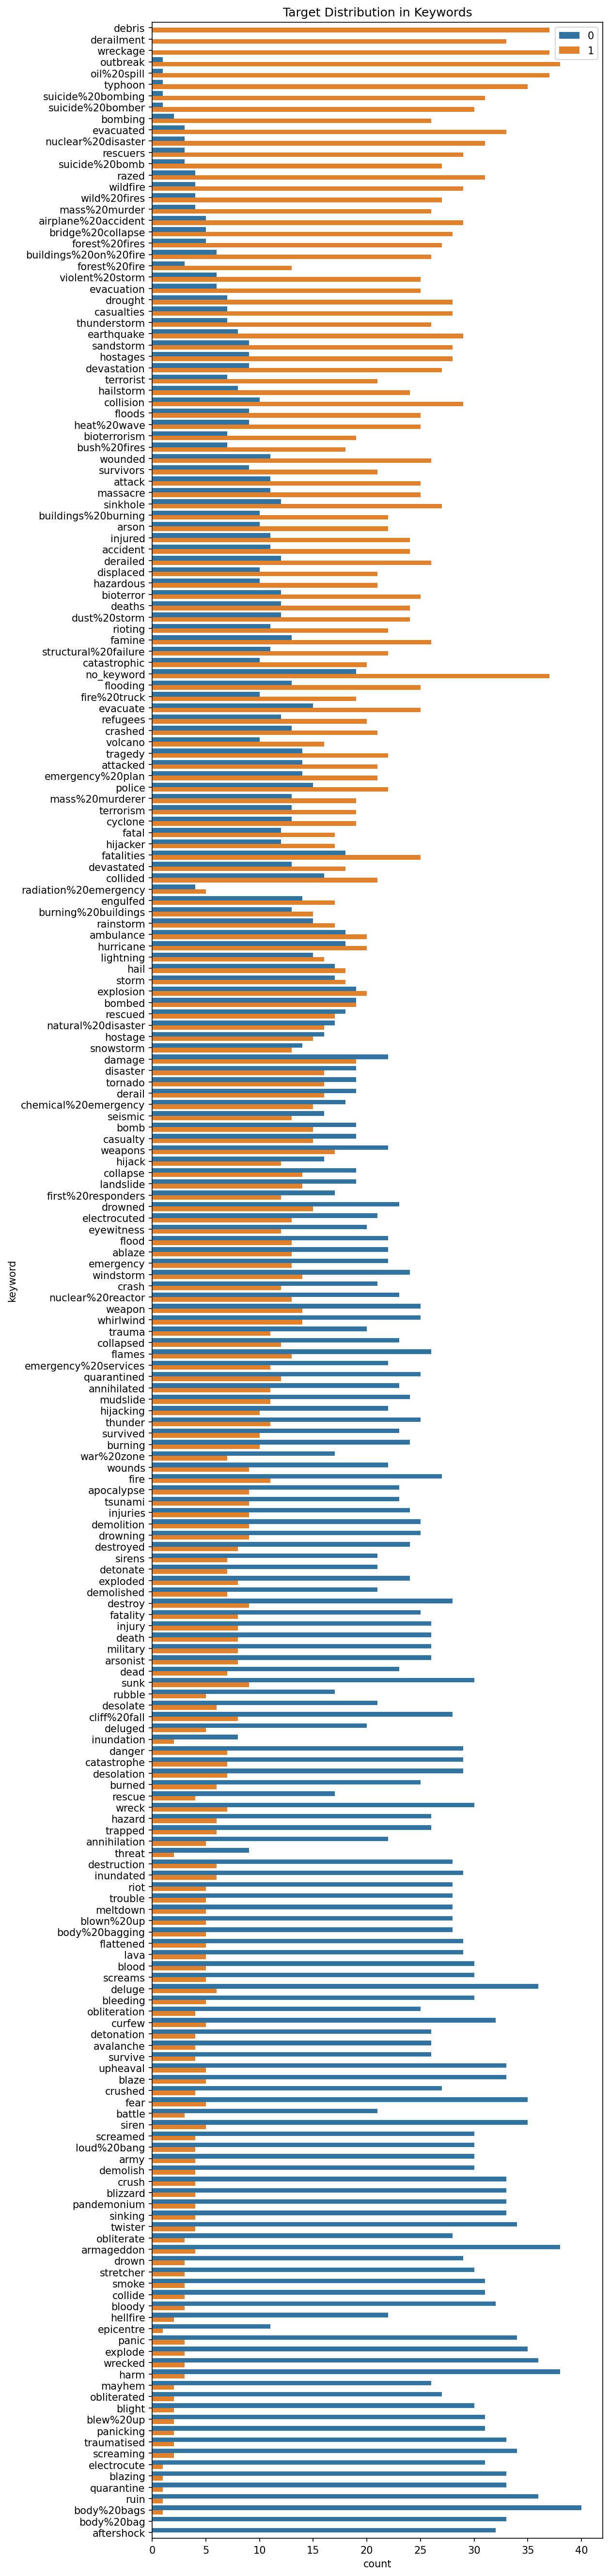

In [30]:
# use keyword as additional feature because of targets dependency
df_train['target_mean'] = df_train.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 45), dpi=150)

sns.countplot(y=df_train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=df_train.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x')
plt.tick_params(axis='y')
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

df_train.drop(columns=['target_mean'], inplace=True)

## Features engineering
***

- **word_count** number of words in text
- **unique_word_count** number of unique words in text
- **stop_word_count** number of stop words in text
- **url_count** number of urls in text
- **mean_word_length** average character count in words
- **char_count** number of characters in text
- **punctuation_count** number of punctuations in text
- **hashtag_count** number of hashtags (#) in text
- **mention_count** number of mentions (@) in text

In [31]:
#STOPWORDS 
STOPWORDS = stopwords.words('english')

In [32]:
# word_count
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
df_test['word_count'] = df_test['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
df_train['unique_word_count'] = df_train['text'].apply(lambda x: len(set(str(x).split())))
df_test['unique_word_count'] = df_test['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
df_train['stop_word_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
df_test['stop_word_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
df_train['url_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
df_test['url_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
df_train['mean_word_length'] = df_train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
df_test['mean_word_length'] = df_test['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
df_test['char_count'] = df_test['text'].apply(lambda x: len(str(x)))

# punctuation_count
df_train['punctuation_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
df_test['punctuation_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
df_train['hashtag_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
df_test['hashtag_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
df_train['mention_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
df_test['mention_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

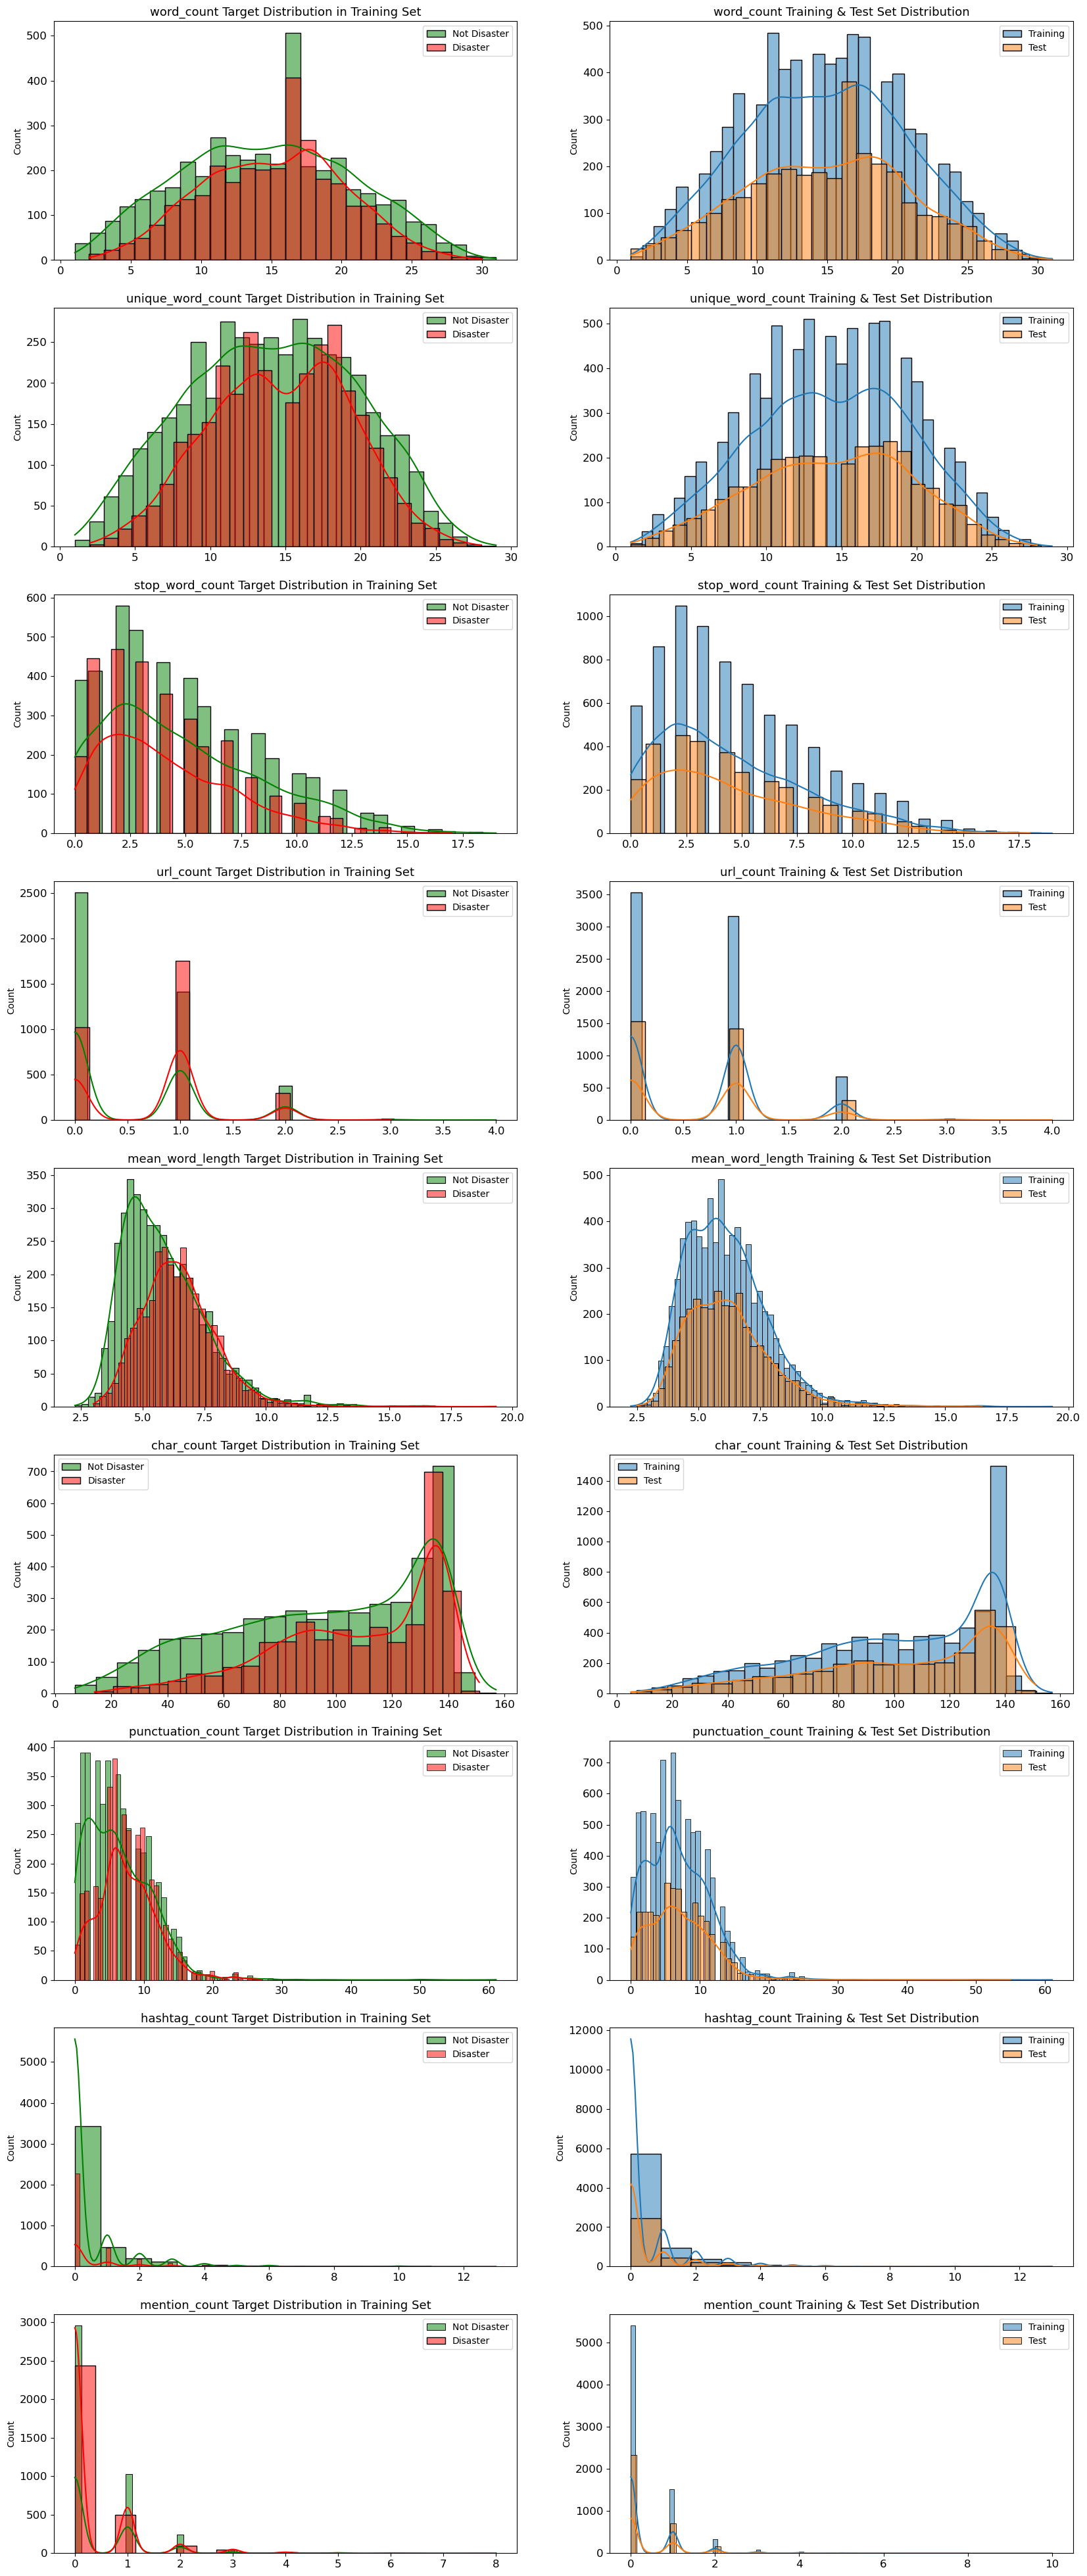

In [33]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']
DISASTER_TWEETS = df_train['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.histplot(df_train.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green', kde=True)
    sns.histplot(df_train.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red', kde=True)

    sns.histplot(df_train[feature], label='Training', ax=axes[i][1], kde=True)
    sns.histplot(df_test[feature], label='Test', ax=axes[i][1], kde=True)
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

# Prepare data for tokenization
***

Delete any symbols, links, mentions, numbers.

Preprocess hashtags with spliting into the words by uppercase if possible and check if word exist in vocabulary.

Also, let's us use library "contractions" to fix such examples:

you're -> you are\
i'm    -> I am\
ima    -> I am going to\
yall  -> you all\
gotta  -> got to

As a final result, we keep a new column with just preprocessed text as said above and one more with removal of stopwords in addition.

In [253]:
pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')

def remove_html(text):
    #html unescape
    text = html.unescape(text)
    
    #weird "w/", "lf/", etc.
    text = re.sub("[a-z]+/", '', text)
    
    #delete mentions
    text = re.sub("@[\w]+", '', text)
    
    #delete links
    no_html= pattern.sub('',text)
    return no_html

In [345]:
def rep(m):
    s=m.group(1)
    return ' '.join(re.split(r'(?=[A-Z])', s))


def preprocess_hashtags(text, word_dict=word_dictionary):
    
    #find all hastgas
    hashtags = re.findall("#\w+", text)
    
    if not hashtags:
        return text
    
    else:
        
        for tag in hashtags:
            
            #if hashtag is uppercase and it is in the dictionary -> keep it
            if tag.isupper() and tag[1:].lower() in word_dictionary:
                text = re.sub(tag, tag[1:].lower(), text)
                
            #else check for splittinig by upper case letter and check for existing in the dictionary
            else:
                words = re.sub(r'#(\w+)', rep, tag).split()
                new_words = []
                
                for word in words:
                    
                    #if in dictionary -> keep it
                    #else -> drop it
                    if word.lower() in word_dictionary:
                        new_words.append(word.lower())
                
                new_string = " ".join(new_words)
                
                text = re.sub(tag, new_string, text)
            
        return text

In [254]:
#Remove links
df_train['prep_text'] = df_train['text'].apply(lambda x : remove_html(x))
df_test['prep_text'] = df_test['text'].apply(lambda x : remove_html(x))

In [254]:
#preprocess hashtags
df_train['prep_text'] = df_train['prep_text'].apply(lambda x : preprocess_hashtags(x))
df_test['prep_text'] = df_test['prep_text'].apply(lambda x : preprocess_hashtags(x))

In [255]:
#fix contractions
df_train['prep_text'] = df_train['prep_text'].apply(lambda x : contractions.fix(x))
df_test['prep_text'] = df_test['prep_text'].apply(lambda x : contractions.fix(x))

In [256]:
#Remove symbols and numbers and if necessary stopwords
def clean_text(text, remove_stopwords=False, pop_not=True):
    
    text = re.sub('[^a-zA-Z]', ' ', text)  
    text = text.lower()  
    
    # split to array(default delimiter is " ") 
    text = text.split()      
    
    # remove single char
    text = [w for w in text if len(w)>1 or w=='a' or w=='i']
    
    #if remove stopwords
    if remove_stopwords:
        STOPWORDS = stopwords.words('english')
        
        
        #if remove word "not" from stopwords
        if pop_not:
            STOPWORDS.remove('not')
        else:
            pass
        
        text = [w for w in text if not w in set(STOPWORDS)] 
    else:
        pass
    
    #join words back
    text = ' '.join(text)    
            
    return text

In [257]:
#Without stopwords
df_train['no_stopwords_text'] = df_train['prep_text'].apply(lambda x : clean_text(x, True))
df_test['no_stopwords_text'] = df_test['prep_text'].apply(lambda x : clean_text(x, True))

#Get preprocessed data with stopwords
df_train['prep_text'] = df_train['prep_text'].apply(lambda x : clean_text(x))
df_test['prep_text'] = df_test['prep_text'].apply(lambda x : clean_text(x))



# Save preprocessed data

In [258]:
df_train.to_csv('../data/input/clean_data/train_cleaned.csv', index=0)
df_test.to_csv('../data/input/clean_data/test_cleaned.csv', index=0)

In [259]:
df_train[['text','prep_text', 'no_stopwords_text', 'target']].sample(10)

text                                          prep_text                                  no_stopwords_text  target
2061  Xbox 360 Pro Console - *Red Ring of Death* - F...  xbox pro console red ring of death full read b...     xbox pro console red ring death full read ebay       0
2129                 Confirmed the debris from MH370 ??                       confirmed the debris from mh                                confirmed debris mh       1
4550  Speaking of memorable debates: 60-Second Know-...  speaking of memorable debates second know it a...  speaking memorable debates second know ronald ...       0
2494  Putin's plan to destroy Western food en masse ...  putin plan to destroy western food en masse is...  putin plan destroy western food en masse causi...       0
6293  @BenAffleck  i respected you and liked you for...  i respected you and liked you for your talent ...  respected liked talent guess stil human sunk l...       0
2643  A new favorite: Trivium - Detonation by @rrusa...  a new favorite trivium detonation by on soundc...         new favorite trivium detonation soundcloud       0
441   Credit to @pfannebeckers for inspiring me to r...  credit to for inspiring me to rediscover this ...        credit inspiring rediscover fantabulous tbt       0
1511  Google Alert: Emergency units simulate a chemi...  google alert emergency units simulate a chemic...  google alert emergency units simulate chemical...       0
3746  Just added some more fire to the flames for Sa...  just added some more fire to the flames for sa...  added fire flames saturday rick wonder spinnin...       0
5135  A Mad Catastrophe : The Outbreak of World War ...  a mad catastrophe the outbreak of world war i ...        mad catastrophe outbreak world war collapse       1

In [260]:
df_test[['text','prep_text', 'no_stopwords_text',]].head(10)

text                                          prep_text                                  no_stopwords_text
0                 Just happened a terrible car crash                 just happened a terrible car crash                        happened terrible car crash
1  Heard about #earthquake is different cities, s...  heard about earthquake is different cities sta...  heard earthquake different cities stay safe ev...
2  there is a forest fire at spot pond, geese are...  there is a forest fire at spot pond geese are ...  forest fire spot pond geese fleeing across str...
3           Apocalypse lighting. #Spokane #wildfires              apocalypse lighting spokane wildfires              apocalypse lighting spokane wildfires
4      Typhoon Soudelor kills 28 in China and Taiwan         typhoon soudelor kills in china and taiwan                typhoon soudelor kills china taiwan
5                 We're shaking...It's an earthquake                 we are shaking it is an earthquake                                 shaking earthquake
6  They'd probably still show more life than Arse...  they would probably still show more life than ...  would probably still show life arsenal yesterd...
7                                  Hey! How are you?                                    hey how are you                                                hey
8                                   What a nice hat?                                    what a nice hat                                           nice hat
9                                          Fuck off!                                           fuck off                                               fuck

In [278]:
temp = df_train.copy()

In [279]:
temp['text'] = temp['text'].apply(lambda x: x.lower())

In [284]:
all_h = []
for i,t in enumerate(temp['text']):
    if "#" in t:
        all_h += re.findall("#\w+", t)
        
all_h = set(all_h)

In [287]:
d = {}

for h in all_h:
    count_total = 0
    count_1 = 0
    
    for i,t in enumerate(temp['text']):
        if h in t:
            count_total += 1
            
            if temp.iloc[i, 4] == 1:
                count_1 += 1
    
    d[h] = [count_1, count_total]

In [293]:
d = pd.DataFrame.from_dict(d, orient='index')

In [301]:
d.sort_values(1, ascending=False).head(100)

0    1
#i             64  126
#news          51   77
#in            25   48
#ca            25   46
#co            19   44
#de            13   34
#best           9   33
#ar            12   32
#hot            8   32
#prebreak       8   30
#st            10   28
#us            15   25
#hiroshima     24   24
#now            3   24
#nowplay        3   23
#fr             9   23
#is            10   23
#nowplaying     2   22
#world         20   22
#earth         20   21
#wa            10   21
#job            0   21
#earthquake    19   19
#la            13   19
#gbbo           4   17
#wild          15   16
#breaking      13   15
#terror         8   15
#india         13   14
#1              5   14
#we             8   14
#jobs           0   14
#wildfire      13   13
#japan         13   13
#yyc           12   13
#rt             2   12
#art            1   12
#islam          1   12
#ban            8   12
#au             4   12
#isis           5   12
#free           3   11
#iran           6   11
#terrorism      4   11
#ok             9   11
#hiring         1   11
#man            6   10
#summer         2   10
#sismo          9   10
#nuclear        8   10
#flood          9   10
#bbc            3   10
#ge             8   10
#fashion        0    9
#worldnews      8    9
#love           2    9
#sm             5    9
#fire           6    9
#tech           3    9
#cnn            2    9
#ap             7    9
#fukushima      8    9
#irandeal       4    9
#directioners   0    9
#abstorm        9    9
#ny             8    9
#emmerdale      1    9
#africa         7    8
#fun            4    8
#video          2    8
#rock           5    8
#hail           7    8
#handbag        0    8
#disaster       8    8
#nursing        2    8
#seattle        3    8
#beyhive        0    8
#wx             8    8
#bioterror      5    7
#truth          0    7
#refugee        5    7
#quran          0    7
#business       3    7
#book           4    7
#okwx           7    7
#anti           6    7
#hailstorm      7    7
#kindle         0    7
#animalrescue   0    7
#lies           0    7
#tube           1    7
#god            0    7
#tcot           3    7
#mtvhottest     1    7
#mh370          7    7
#usa            4    7
#uk             5    7
#red            1    6
#thunder        4    6
#ems            4    6

In [331]:
d.loc['#wildfires']

0    5
1    5
Name: #wildfires, dtype: int64

In [340]:
def rep(m):
    s=m.group(1)
    return ' '.join(re.split(r'(?=[A-Z])', s))


def preprocess_hashtags(text, word_dict=word_dictionary):
    
    hashtags = re.findall("#\w+", text)
    
    if not hashtags:
        return text
    
    else:
        
        for tag in hashtags:
            
            if tag.isupper() and tag[1:].lower() in word_dictionary:
                text = re.sub(tag, tag[1:].lower(), text)
            else:
                words = re.sub(r'#(\w+)', rep, tag).split()
                new_words = []
                
                for word in words:
                    if word.lower() in word_dictionary:
                        new_words.append(word.lower())
                
                new_string = " ".join(new_words)
                
                text = re.sub(tag, new_string, text)
            
        return text

In [341]:
for i,t in enumerate(df_train['text']):
    if "#" in t:
        print(i, t)
        print(re.findall("#\w+", t))
        print(preprocess_hashtags(t))
        print('\n')

0 Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
['#earthquake']
Our Deeds are the Reason of this earthquake May ALLAH Forgive us all


3 13,000 people receive #wildfires evacuation orders in California 
['#wildfires']
13,000 people receive  evacuation orders in California 


4 Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 
['#Alaska', '#wildfires']
Just got sent this photo from Ruby  as smoke from  pours into a school 


5 #RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires
['#RockyFire', '#CAfire', '#wildfires']
rocky fire Update => California Hwy. 20 closed in both directions due to Lake County fire - afire 


6 #flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas
['#flood', '#disaster']
flood disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas


11 Haha South Tampa is getting floode

news Twelve feared killed in Pakistani air ambulance helicopter crash http://t.co/bFeS5tWBzt  a


185 EMS1: NY EMTs petition for $17 per hour minimum wage' http://t.co/4oa6SWlxmR #ems #paramedics #ambulance
['#ems', '#paramedics', '#ambulance']
EMS1: NY EMTs petition for $17 per hour minimum wage' http://t.co/4oa6SWlxmR   ambulance


192 #reuters Twelve feared killed in Pakistani air ambulance helicopter crash http://t.co/ShzPyIQok5
['#reuters']
 Twelve feared killed in Pakistani air ambulance helicopter crash http://t.co/ShzPyIQok5


199 Twelve feared killed in Pakistani air ambulance helicopter crash http://t.co/TH9YwBbeet #worldNews
['#worldNews']
Twelve feared killed in Pakistani air ambulance helicopter crash http://t.co/TH9YwBbeet world news


200 Twelve feared killed in Pakistani air ambulance helicopter crash http://t.co/X2Qsjod40u #worldnews
['#worldnews']
Twelve feared killed in Pakistani air ambulance helicopter crash http://t.co/X2Qsjod40u 


207 Uribe just annihilated that

**OFFICIAL VID** the real &gt;&gt;&gt; https://t.co/4i0Rjc9RQU &gt;&gt;&gt; @TrubGME &gt;&gt;&gt; a a Comin Soon!!


340 Beyonce Is my pick for http://t.co/nnMQlz91o9 Fan Army #Beyhive http://t.co/o91f3cYy0R 77
['#Beyhive']
Beyonce Is my pick for http://t.co/nnMQlz91o9 Fan Army  http://t.co/o91f3cYy0R 77


341 One Direction Is my pick for http://t.co/q2eBlOKeVE Fan Army #Directioners http://t.co/eNCmhz6y34 x1402
['#Directioners']
One Direction Is my pick for http://t.co/q2eBlOKeVE Fan Army  http://t.co/eNCmhz6y34 x1402


342 5 Seconds of Summer Is my pick for http://t.co/J6WsePTXgA Fan Army #5SOSFAM http://t.co/qWgIwC9w7Z
['#5SOSFAM']
5 Seconds of Summer Is my pick for http://t.co/J6WsePTXgA Fan Army a http://t.co/qWgIwC9w7Z


343 22.Beyonce Is my pick for http://t.co/thoYhrHkfJ Fan Army #Beyhive http://t.co/WvJ39a3BGM
['#Beyhive']
22.Beyonce Is my pick for http://t.co/thoYhrHkfJ Fan Army  http://t.co/WvJ39a3BGM


344 17.Beyonce Is my pick for http://t.co/thoYhrHkfJ Fan Army #Beyhive h

we love a  Avalanche Defense: How They Match vs St. Louis Blues http://t.co/9v1RVCOMH2 sports roadhouse


514 #Colorado #Avalanche Men's Official Colorado Avalanche Reebok T-Shirt XL Blue 100% Cotton http://t.co/ZNSvsTGwx3 #NHL #Hockey
['#Colorado', '#Avalanche', '#NHL', '#Hockey']
colorado avalanche Men's Official Colorado Avalanche Reebok T-Shirt XL Blue 100% Cotton http://t.co/ZNSvsTGwx3  hockey


518 PATRICK ROY 1998-99 UPPER DECK SPX #171 FINITE 1620 MADE COLORADO AVALANCHE MINT http://t.co/uHfM1r3Tq5 http://t.co/QulgaKebHB
['#171']
PATRICK ROY 1998-99 UPPER DECK SPX  FINITE 1620 MADE COLORADO AVALANCHE MINT http://t.co/uHfM1r3Tq5 http://t.co/QulgaKebHB


520 Beautiful Sweet Avalanche Faith and Akito roses with lots of frothy gyp. http://t.co/RaqUpzFkJY #weddinghour http://t.co/quNxocXCgA
['#weddinghour']
Beautiful Sweet Avalanche Faith and Akito roses with lots of frothy gyp. http://t.co/RaqUpzFkJY  http://t.co/quNxocXCgA


529 Chiasson Sens can't come to deal #ColoradoAvalanche 

@Chambered_Blood Yeah you are! speaking from experience


851 Can't believe more people in their mid 20's don't have high blood pressure. Life is stressful. #DecisionsOnDecisions
['#DecisionsOnDecisions']
Can't believe more people in their mid 20's don't have high blood pressure. Life is stressful. on


863 Private thirsty night?SAD BLOOD ROCK'N ROLL? #??
[]
Private thirsty night?SAD BLOOD ROCK'N ROLL? #??


864 #RolandoNaBeats: Ellie Goulding - My Blood | Acesse nosso site para ouvir! http://t.co/Zk69uGXMT8
['#RolandoNaBeats']
na: Ellie Goulding - My Blood | Acesse nosso site para ouvir! http://t.co/Zk69uGXMT8


875 I entered to #win the ENTIRE set of butterLONDON Lip Crayons via @be_ram0s. - Go enter! #bbloggers http://t.co/DsB3lDfuxU
['#win', '#bbloggers']
I entered to win the ENTIRE set of butterLONDON Lip Crayons via @be_ram0s. - Go enter!  http://t.co/DsB3lDfuxU


880 I can't bloody wait!! Sony Sets a Date For Stephen King's The Dark Tower' #stephenking #thedarktower http://t.co/

Jays rocking  @JoeyBats19 just bombed one out of Rogers Centre. Play-offs r ahead for The blue - Bell Moseby and Barfield r back!


1085 London Life: photos of a beautiful bombed-out Britain http://t.co/2RAcaiVFfq #arts
['#arts']
London Life: photos of a beautiful bombed-out Britain http://t.co/2RAcaiVFfq 


1088 @CyhiThePrynce bombed on Kanye in that #ElephantInTheRoom ????????
['#ElephantInTheRoom']
@CyhiThePrynce bombed on Kanye in that elephant in the room ????????


1091 On 1st August #Turkish jets bombed the village Zergele in Qendil and killed 8 civilians and 15 others wounded
['#Turkish']
On 1st August  jets bombed the village Zergele in Qendil and killed 8 civilians and 15 others wounded


1095 'the third generation atomic bombed survivor' Photo exhibition 11:00 to 18:00 8/6. 
#?? #Hiroshima http://t.co/gVAipmLSl0
['#Hiroshima']
'the third generation atomic bombed survivor' Photo exhibition 11:00 to 18:00 8/6. 
#??  http://t.co/gVAipmLSl0


1104 http://t.co/wMNOnHxEIr 'Nagasak

Such beautiful architecture in  I love those fire escape routes on the buildings.  https://t.co/fW1PtaElgV


1224 #TweetLikeItsSeptember11th2001 Those two buildings are on fire
['#TweetLikeItsSeptember11th2001']
tweet like its Those two buildings are on fire


1225 just in: #kenya: several buildings are reported to be on fire close to dam estate #langata at 2:22pm.
['#kenya', '#langata']
just in: : several buildings are reported to be on fire close to dam estate  at 2:22pm.


1230 Fire Displaces Families and Damages Two Buildings in Troy: Fire broke out on Fourth Street in_ http://t.co/6HKw5qLPPt #Albany #NY #News
['#Albany', '#NY', '#News']
Fire Displaces Families and Damages Two Buildings in Troy: Fire broke out on Fourth Street in_ http://t.co/6HKw5qLPPt   news


1231 What news reports am I missing? Are there buildings on fire people shot etc. due to videos? #PPSellsBabyParts https://t.co/Wzc5r4XOqZ
['#PPSellsBabyParts']
What news reports am I missing? Are there buildings on fire pe

Warfighting Robots Could Reduce Civilian Casualties So Calling for a Ban Now Is Premature http://t.co/lzff4pT4AZ  Newsdesk 


1398 We're #hiring in our Toronto branch! Surety Underwriter/Senior Underwriter and Casualty Product Leader. Apply today. http://t.co/PraMKlrMhz
['#hiring']
We're  in our Toronto branch! Surety Underwriter/Senior Underwriter and Casualty Product Leader. Apply today. http://t.co/PraMKlrMhz


1401 Was '80s New #Wave a #Casualty of #AIDS?: Tweet And Since they'd grown up watching David_ http://t.co/qBecjli7cx
['#Wave', '#Casualty', '#AIDS']
Was '80s New wave a casualty of a i?: Tweet And Since they'd grown up watching David_ http://t.co/qBecjli7cx


1403 Another sad ocean casualty-Gray whale population in the Pacific listed as critically #endangered (#drone video) https://t.co/vwz3vZpmfb .
['#endangered', '#drone']
Another sad ocean casualty-Gray whale population in the Pacific listed as critically  (drone video) https://t.co/vwz3vZpmfb .


1405 1st Quality Insuran

Day 2. Liquidation of emergency at chemical object. a a  #??????????? http://t.co/gGTmDqUdDo


1524 Please stand up for bees against profit-hungry chemical companies. Keep the ban &amp; #Savebees 
Sign the petition now:
https://t.co/4zsXjGV7iT
['#Savebees']
Please stand up for bees against profit-hungry chemical companies. Keep the ban &amp;  
Sign the petition now:
https://t.co/4zsXjGV7iT


1527 Emergency 4 Harbor City Mod v4.5.2 #6 Chemical Fire in Residential Area!: http://t.co/uLuPxYzJwV via @YouTube
['#6']
Emergency 4 Harbor City Mod v4.5.2  Chemical Fire in Residential Area!: http://t.co/uLuPxYzJwV via @YouTube


1532 Fuck  Neil go fall off a cliff or something.....#yr ??????
['#yr']
Fuck  Neil go fall off a cliff or something.....yr ??????


1533 Beat the #heat. Today only Kill Cliff Free Fall $2. Pick up a #cold drink today after the #tough #crossfit... http://t.co/QaMwoJYahq
['#heat', '#cold', '#tough', '#crossfit']
Beat the heat. Today only Kill Cliff Free Fall $2. Pick up a 

My woman crush wedneday goes to the beautiful @taykreidler   https://t.co/WeMwdtFwiC


1824 @PYDisney que crush?#MTVHottest Justin Bieber
['#MTVHottest']
@PYDisney que crush? Justin Bieber


1831 #MrRobinson is giving me #TheSteveHarveyShow vibe. Music teacher looks out for students has crush on girl he went to high school with. ??
['#MrRobinson', '#TheSteveHarveyShow']
 is giving me the show vibe. Music teacher looks out for students has crush on girl he went to high school with. ??


1844 #NowPlaying Fitz And The Tantrums - Out Of My League on #Crush #Listen http://t.co/Pwd5L0GLkV #NowPlaying
['#NowPlaying', '#Crush', '#Listen', '#NowPlaying']
now Fitz And The Tantrums - Out Of My League on crush listen http://t.co/Pwd5L0GLkV now


1854 .@jimmyfallon I crushed squirrel bones with a mortar and pestle for my school's bio dept. not really sure why #WorstSummerJob
['#WorstSummerJob']
.@jimmyfallon I crushed squirrel bones with a mortar and pestle for my school's bio dept. not really sure

@bluebirddenver i IS a i OPPRESSIONS GREATEST DANGER COMING SOON THE ALBUM 
https://t.co/moLL5vd8yD


2007 .@Uber is looking to repair its recent bad rap with some #nonprofit partnerships: http://t.co/h1xch54Kd3
['#nonprofit']
.@Uber is looking to repair its recent bad rap with some nonprofit partnerships: http://t.co/h1xch54Kd3


2009 @TurnedonFetaboo @HSjb215 Check out this #rockin preview of @ClaytonBryant Danger Zone Coming soon! https://t.co/E1wrVyZFKV #ArtistsUnited
['#rockin', '#ArtistsUnited']
@TurnedonFetaboo @HSjb215 Check out this  preview of @ClaytonBryant Danger Zone Coming soon! https://t.co/E1wrVyZFKV united


2010 @TheTXI @GunnersFan89 why would arsenal fans want that? West Ham will be in a relegation battle this season. no danger for #AFC on sun
['#AFC']
@TheTXI @GunnersFan89 why would arsenal fans want that? West Ham will be in a relegation battle this season. no danger for a on sun


2011 @RemainOnTop #FETTILOOTCH IS #SLANGLUCCI OPPRESSIONS GREATEST DANGER COMING SOO

I apologise sincerely for the inevitable deluge of  tweets to come. I won't hold any grudges if you decide to unfollow baking 


2168 RT @NLM_DIMRC: A deluge of resources on #floods for medical providers cleanup workers &amp; more at: http://t.co/aUoeyIRqE6
['#floods']
RT @NLM_DIMRC: A deluge of resources on  for medical providers cleanup workers &amp; more at: http://t.co/aUoeyIRqE6


2170 A deluge of eulogies  for #CecilTheLion on my WhatsApp  &gt;&gt;this too *tormented soul by matias xavier *
['#CecilTheLion']
A deluge of eulogies  for the lion on my WhatsApp  &gt;&gt;this too *tormented soul by matias xavier *


2173 Despite the deluge of #FantasticFour notices our man O'Cuana is still buying tickets - because he's bloody-minded like that.
['#FantasticFour']
Despite the deluge of fantastic four notices our man O'Cuana is still buying tickets - because he's bloody-minded like that.


2175 It's a deluge in Trois-Rivieres. About one hour to get to #legionstrackandfield http://t.co/Pu

Has identity theft Derailed Your tax return? 
8 Steps for Cleaning Up an  identity theft Train Wreck. i
http://t.co/gxQWD1qZBd


2376 #Metro still doesn't know when Blue &amp; Orange lines will reopen. Empty passenger car derailed ~ 5 a.m. NOT a new 7000-series. @CQnow #WMATA
['#Metro', '#WMATA']
 still doesn't know when Blue &amp; Orange lines will reopen. Empty passenger car derailed ~ 5 a.m. NOT a new 7000-series. @CQnow a a


2390 #tubestrike derailed you? Our #robertwelch cutlery offers will get you back on track http://t.co/bQ8Kyi7Gng http://t.co/GNZwxQktAm
['#tubestrike', '#robertwelch']
 derailed you? Our  cutlery offers will get you back on track http://t.co/bQ8Kyi7Gng http://t.co/GNZwxQktAm


2391 .@unsuckdcmetro Is the train half-derailed or half-railed? #deepthoughts
['#deepthoughts']
.@unsuckdcmetro Is the train half-derailed or half-railed? 


2396 @GerryConnolly @RepDonBeyer @timkaine Today's #Metro commute debacle w/derailed non-passenger train shows clearly we need a R

Flood: Two people dead 60 houses destroyed in Kaduna: Two people have been reportedly killed an... http://t.co/kEE1tyTZ15 


2552 70 years after #ABomb destroyd #Hiroshima#BBC looks at wht #survived http://t.co/dLgNUuuUYn #CNV Watch Peace Vigils: http://t.co/jvkYzNDtja
['#ABomb', '#Hiroshima', '#BBC', '#survived', '#CNV']
70 years after a bomb destroyd  looks at wht  http://t.co/dLgNUuuUYn  Watch Peace Vigils: http://t.co/jvkYzNDtja


2554 @DavidVitter Hi David in 2003 I saw the USA walk into a war that destroyed the lives of millions. You can prevent a repeat. #IranDeal
['#IranDeal']
@DavidVitter Hi David in 2003 I saw the USA walk into a war that destroyed the lives of millions. You can prevent a repeat. deal


2557 #hot#teen#nsfw#porn#milf: Oiled Up Ass Hole Is Destroyed With King Size Cock Closeup Sex Clip http://t.co/faoGxkwdpG
['#hot', '#teen', '#nsfw', '#porn', '#milf']
hotteen: Oiled Up Ass Hole Is Destroyed With King Size Cock Closeup Sex Clip http://t.co/faoGxkwdpG


2559 Why

a vote i 12News: UPDATE: A family of 3 has been displaced after fired damaged housed near 90th and Osborn. Fire extinguished no i_


2770 .POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4
['#StrategicPatience', '#Genocide']
.POTUS strategic patience is a strategy for genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4


2771 ? The Circular Ruins - Displaced part 4 ? http://t.co/Od2ratxRqS #nowplaying
['#nowplaying']
? The Circular Ruins - Displaced part 4 ? http://t.co/Od2ratxRqS 


2774 #Myanmar  Displaced #Rohingya at #Sittwe point of no return http://t.co/qegMRhSms2  #Prison like conditions #genocide @IHHen @MSF @Refugees
['#Myanmar', '#Rohingya', '#Sittwe', '#Prison', '#genocide']
  Displaced  at  point of no return http://t.co/qegMRhSms2  prison like conditions genocide @IHHen @MSF @Refugees


2775 Displaced Persons GN (2014 Image) #1-1ST NM http://t.co/yEJt18

'Why am I being constantly electrocuted?' 'I don't know. Are you by chance standing next to a cactus?' 2  


3039 Woman electrocuted #Red #Redblood #videoclip http://t.co/9PYmM2RUWf #
['#Red', '#Redblood', '#videoclip']
Woman electrocuted red redblood  http://t.co/9PYmM2RUWf #


3043 South Side factory where worker electrocuted pays $17000 penalty #Columbus - http://t.co/N8EzfCTfcE
['#Columbus']
South Side factory where worker electrocuted pays $17000 penalty  - http://t.co/N8EzfCTfcE


3044 Michael talking about when he was electrocuted omg #ROWYSOLouisville http://t.co/HxVfmoUhDM
['#ROWYSOLouisville']
Michael talking about when he was electrocuted omg  http://t.co/HxVfmoUhDM


3048 .@BBCNews .@mwlippert #SouthKorea Dogs prepared!Electrocutedboiling waterfur machine ALL STILL ALIVE http://t.co/3a50DhZ7YI
['#SouthKorea']
.@BBCNews .@mwlippert south Dogs prepared!Electrocutedboiling waterfur machine ALL STILL ALIVE http://t.co/3a50DhZ7YI


3050 MT @Earths_Voice Treatment of #tigers in #

Wow. i has Pre Season Tournaments in Career Mode. Bloody hell evacuate the building 


3251 Perhaps the criminal murderous #nazis should pack their bags &amp; evacuate themselves from London &amp; all #UK? #TubeStrike WELL DONE!
['#nazis', '#UK', '#TubeStrike']
Perhaps the criminal murderous  should pack their bags &amp; evacuate themselves from London &amp; all ? tube strike WELL DONE!


3252 Does anyone know why #murfreesboro #walmart was evacuated this evening? @dnj_com
['#murfreesboro', '#walmart']
Does anyone know why   was evacuated this evening? @dnj_com


3255 Red Cross re-opens shelter at Bickleton School after 25 homes evacuated in &amp; around Roosevelt WA due to wildfire. #LiveOnK2
['#LiveOnK2']
Red Cross re-opens shelter at Bickleton School after 25 homes evacuated in &amp; around Roosevelt WA due to wildfire. live on


3256 New evacuation ordered for 25 homes in danger of Hwy. 8 fire near Roosevelt Wash. http://t.co/SQsyUeh4yI #KOIN6News http://t.co/199t7ND0pm
['#KOIN6New

eyewitness media is actively embraced by  audiences. Read the report by @emhub on the impact of  in news: http://t.co/6mBPvwiTxf


3435 Read an eyewitness account from #Hiroshima from this day in 1945 http://t.co/njAffyjaRz http://t.co/1xHSuEwQn4 #LIFE
['#Hiroshima', '#LIFE']
Read an eyewitness account from  from this day in 1945 http://t.co/njAffyjaRz http://t.co/1xHSuEwQn4 life


3437 #ClimateChange Eyewitness to Extreme Weather: 11 Social Media Posts that Show Just How Crazy Things A... http://t.co/czpDn9oBiT #Anarchy
['#ClimateChange', '#Anarchy']
climate change Eyewitness to Extreme Weather: 11 Social Media Posts that Show Just How Crazy Things A... http://t.co/czpDn9oBiT anarchy


3444 Read an eyewitness account from #Hiroshima from this day in 1945 http://t.co/QUEDV2xxxX #LIFE
['#Hiroshima', '#LIFE']
Read an eyewitness account from  from this day in 1945 http://t.co/QUEDV2xxxX life


3446 Wake Up Kern County Eyewitness News Mornings airing RIGHT NOW on KBAK CBS29. http://t.co/ro

70 years ago the first atomic attack flattened  3 days later it was  both war crimes to put Moscow in its place


3791 #Floored4 #Flattened 

Early birds does get de cups .... so lag bout pun de dock and watch ppl drink_ https://t.co/r5StV25ZhQ
['#Floored4', '#Flattened']
  

Early birds does get de cups .... so lag bout pun de dock and watch ppl drink_ https://t.co/r5StV25ZhQ


3803 Mum's literally just picked up her new car today and flattened the battery already trying to sort out the Bluetooth ???? #Muppet
['#Muppet']
Mum's literally just picked up her new car today and flattened the battery already trying to sort out the Bluetooth ???? 


3807 'the fallacy is it is up to the steam roller. It's up to the object whether it will be flattened or not.' #RobertCalifornia #thereisonlysex
['#RobertCalifornia', '#thereisonlysex']
'the fallacy is it is up to the steam roller. It's up to the object whether it will be flattened or not.'  


3810 @bigburgerboi55 flat footballs!!?? More like he

heart disease U.S. Forest Service says spending more than half of budget on fires http://t.co/KzfiGkEeva


3966 When ur friend and u are talking about forest fires in a forest and he tells u to drop ur mix tape out there... #straightfire
['#straightfire']
When ur friend and u are talking about forest fires in a forest and he tells u to drop ur mix tape out there... 


3968 GREAT MICHIGAN TECHNIQUE CAMP
B1G THANKS TO @bmurph1019 
@hail_Youtsey . @termn8r13 
#GoBlue #WrestleOn http://t.co/OasKgki6Qj
['#GoBlue', '#WrestleOn']
GREAT MICHIGAN TECHNIQUE CAMP
B1G THANKS TO @bmurph1019 
@hail_Youtsey . @termn8r13 
go blue wrestle on http://t.co/OasKgki6Qj


3969 #np Avenged Sevenfold - Hail To The King
['#np']
 Avenged Sevenfold - Hail To The King


3970 All Hail Shadow (Hybrid Mix Feat. Mike Szuter): http://t.co/9e2f7bIvlE @youtube ##youtube
['#youtube']
All Hail Shadow (Hybrid Mix Feat. Mike Szuter): http://t.co/9e2f7bIvlE @youtube #


3971 @tremblayeh we like big hail and we cannot lie!! #S

Have you heard 05 LOVE TO LOVE YOU....HEAT WAVE VOL 5' by George deejayempiresound on sound cloud?  https://t.co/rQiuqXNM2X


4176 Hellfire is surrounded by desires so be careful and don't let your desires control you! #Afterlife
['#Afterlife']
Hellfire is surrounded by desires so be careful and don't let your desires control you! afterlife


4178 Beware of your temper and a loose tongue! These two dangerous weapons combined can lead a person to the Hellfire #islam!
['#islam']
Beware of your temper and a loose tongue! These two dangerous weapons combined can lead a person to the Hellfire !


4180 #Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect
['#Allah', '#wealth', '#forever', '#Hellfire', '#Reflect']
 describes piling up wealth thinking it would last forever as the description of the people of  in Surah Humaza. reflect


4182 Hellfire is surrounded by desires so be careful and don't let your des

hot  C-130 specially modified to land in a stadium and rescue hostages in Iran in 1980 http://t.co/zLco4UE5OQ  best


4327 #hot  C-130 specially modified to land in a stadium and rescue hostages in Iran in 1980 http://t.co/W0EXzAD5Gc #prebreak #best
['#hot', '#prebreak', '#best']
hot  C-130 specially modified to land in a stadium and rescue hostages in Iran in 1980 http://t.co/W0EXzAD5Gc  best


4328 Natalie Stavola our co-star explains her role in Love and Hostages. Check it out! #LH_movie #indiefilm #comingsoon
https://t.co/2Dw23pMF4B
['#LH_movie', '#indiefilm', '#comingsoon']
Natalie Stavola our co-star explains her role in Love and Hostages. Check it out!   
https://t.co/2Dw23pMF4B


4333 No #news of #hostages in #Libya

http://t.co/eXil1bKzmP

#India #terrorism #Africa #AP #TS #NRI #News #TRS #TDP #BJP http://t.co/ehomn68oJB
['#news', '#hostages', '#Libya', '#India', '#terrorism', '#Africa', '#AP', '#TS', '#NRI', '#News', '#TRS', '#TDP', '#BJP']
No news of  in 

http://t.co/eXil1b

Trauma injuries involving kids and sport usually cycling related: Director Trauma NS  http://t.co/8DdijZyNkf  http://t.co/52Uus4TFN3


4461 Rory McIlroy to Test Ankle Injury in Weekend Practice #chinadotcom #sports http://t.co/UDTGWfSc3P http://t.co/V5wSx0LQN2
['#chinadotcom', '#sports']
Rory McIlroy to Test Ankle Injury in Weekend Practice  sports http://t.co/UDTGWfSc3P http://t.co/V5wSx0LQN2


4464 Jack Wilshere has poor injury recordand his off field behaviors doesn't help.#Arsenal
['#Arsenal']
Jack Wilshere has poor injury recordand his off field behaviors doesn't help.arsenal


4469 Greg Garza not in the 18 for Atlas tonight vs Leones Negros in Copa MX play. He left the previous game w/ an injury. #USMNT
['#USMNT']
Greg Garza not in the 18 for Atlas tonight vs Leones Negros in Copa MX play. He left the previous game w/ an injury. 


4470 #poster #ergo Rotator #cuff injury recovery kit: http://t.co/zj3ODGQHyp Super High Converting Rotator Cuff Inj http://t.co/VZhTiBe4jh
['#poster',

The Fake of Nanking Massacre-4 Eyewitnesses (English): http://t.co/TiPnDEmPuz    bush  a     


4754 Remember this was a massacre of civilians. #Hiroshima http://t.co/qw8qk165Sb
['#Hiroshima']
Remember this was a massacre of civilians.  http://t.co/qw8qk165Sb


4755 Don't mess with my Daddy I can be a massacre. #BeCarefulHarry
['#BeCarefulHarry']
Don't mess with my Daddy I can be a massacre. be careful harry


4764 @nataliealund 
Parents of Colorado theater shooting victim fear copycat massacre

http://t.co/LvlH3W3aWO
#Antioch

http://t.co/vIwXY1XDYK
['#Antioch']
@nataliealund 
Parents of Colorado theater shooting victim fear copycat massacre

http://t.co/LvlH3W3aWO


http://t.co/vIwXY1XDYK


4765 @WKRN 
Parents of Colorado theater shooting victim fear copycat massacre

http://t.co/LvlH3W3aWO
#Antioch

http://t.co/vIwXY1XDYK
['#Antioch']
@WKRN 
Parents of Colorado theater shooting victim fear copycat massacre

http://t.co/LvlH3W3aWO


http://t.co/vIwXY1XDYK


4769 Beach Reads in August

@Lolly_Knickers It's a mudslide. 
It's like chewing on a rubber tyre.
And with those I'm DONE.
 


4888 British bake off was great pretty hilarious moments #mudslide
['#mudslide']
British bake off was great pretty hilarious moments 


4889 @new_hart2010 #mudslide... nuff said #GBBO
['#mudslide', '#GBBO']
@new_hart2010 ... nuff said 


4891 #BakeOffFriends the one with the mudslide
['#BakeOffFriends']
bake off the one with the mudslide


4894 #BakeOffFriends #GBBO 'The one with the mudslide and the guy with the hat'
['#BakeOffFriends', '#GBBO']
bake off  'The one with the mudslide and the guy with the hat'


4895 When bae soak you in mudslide at backroom???? #thisiswhywecanthavenicethings http://t.co/kgxNwzIUxd
['#thisiswhywecanthavenicethings']
When bae soak you in mudslide at backroom????  http://t.co/kgxNwzIUxd


4897 First time getting into #gbbo2015 and physically gasped at the cake 'mudslide' incident already way too emotionally invested...
['#gbbo2015']
First time getting into  a

California: Spring Oil Spill Estimate Grows: Documents released on Wednesday disclosed that an oil sp... http://t.co/zqiHnHDWPV 


5111 Refugio oil spill may have been costlier bigger than projected http://t.co/gtHddzAvhg #LosAngelesTimes #latimes #news
['#LosAngelesTimes', '#latimes', '#news']
Refugio oil spill may have been costlier bigger than projected http://t.co/gtHddzAvhg times  news


5114 @Kinder_Morgan can'twon't tell @cityofkamloops how they'd respond to an oil spill. Trust them? See Sec 4.2 #Kamloops http://t.co/TA6N9sZyfP
['#Kamloops']
@Kinder_Morgan can'twon't tell @cityofkamloops how they'd respond to an oil spill. Trust them? See Sec 4.2  http://t.co/TA6N9sZyfP


5121 Refugio oil spill may have been costlier bigger than projected http://t.co/GusrAmzp1s #news
['#news']
Refugio oil spill may have been costlier bigger than projected http://t.co/GusrAmzp1s news


5137 Wow-the name #LegionnairesDisease comes from an outbreak of pneumonia at the @AmericanLegion convention in 

Reddit Will Now Quarantine Offensive Content http://t.co/8S0mTwRumQ technology  


5315 #Reddit updates #content #policy promises to quarantine extremely offensive' communities http://t.co/EHGtZhKAn4
['#Reddit', '#content', '#policy']
 updates content policy promises to quarantine extremely offensive' communities http://t.co/EHGtZhKAn4


5321 #Bangalore  Reddit updates content policy promises to quarantine 'extremely offensive' communities http://t.co/Of3Q75fGeU #Startups  #in
['#Bangalore', '#Startups', '#in']
  Reddit updates content policy promises to quarantine 'extremely offensive' communities http://t.co/Of3Q75fGeU   in


5329 #wired #business Reddit Will Now Quarantine Offensive Content http://t.co/ZhzVprZbgq
['#wired', '#business']
wired business Reddit Will Now Quarantine Offensive Content http://t.co/ZhzVprZbgq


5331 Reddit Will Now Quarantine Offensive Content http://t.co/FEIkC9FxED #onlinecommunities #reddit /via @wired
['#onlinecommunities', '#reddit']
Reddit Will Now Qua

Coastal German Shepherd Rescue OC shared a link... http://t.co/2JxkmkpalP  | https://t.co/ec46LyQQc6


5517 'Trust us to get rescued by the dopey ones!' Val is hilarious shame she's probably going to die #emmerdale
['#emmerdale']
'Trust us to get rescued by the dopey ones!' Val is hilarious shame she's probably going to die 


5518 Summer #summervibes #california #puppy #pitmix #rescued #brixton #banksy #happy #mybabies https://t.co/7VoVkTXsPo
['#summervibes', '#california', '#puppy', '#pitmix', '#rescued', '#brixton', '#banksy', '#happy', '#mybabies']
Summer   puppy     happy  https://t.co/7VoVkTXsPo


5520 10-Month-Old Baby Girl was Rescued by Coastguard after She Floated HALF A MILE Out to Sea! #socialnews http://t.co/kJUzJC6iGD
['#socialnews']
10-Month-Old Baby Girl was Rescued by Coastguard after She Floated HALF A MILE Out to Sea!  http://t.co/kJUzJC6iGD


5521 But now #Skyrim awaits to be rescued...again.
['#Skyrim']
But now  awaits to be rescued...again.


5523 The Finnish hip 

China's Stock Market Crash: Are There Gems In The Rubble? http://t.co/BqBLWiw08g i mentor 


5670 #quote Never let your problems ruin your faith.
['#quote']
quote Never let your problems ruin your faith.


5673 @ChrisDyson16 Just wait until your friends at #MTA ruin it #Sorrybutitstrue
['#MTA', '#Sorrybutitstrue']
@ChrisDyson16 Just wait until your friends at a ruin it 


5678 fresh out da shower lookss ?? (still loving this new hair does it ruin my brand?) #yes https://t.co/T2Kk8fya77
['#yes']
fresh out da shower lookss ?? (still loving this new hair does it ruin my brand?) yes https://t.co/T2Kk8fya77


5685 And then I go a ruin it all with something awful... #minions http://t.co/rc6eeJME17
['#minions']
And then I go a ruin it all with something awful...  http://t.co/rc6eeJME17


5722 SocialWOTS: GLOBI_inclusion: RT NRC_MiddleEast: Sandstorm engulfs caravans and tents in the #Zaatari refugee camp _ http://t.co/XBNLSBzzgI
['#Zaatari']
SocialWOTS: GLOBI_inclusion: RT NRC_MiddleEast: San

 Warcraft 3-Inspired Mode Likely Hitting Heroes of the Storm: Let's go back to the beginning. http://t.co/gx1kZ3C2Tc video game


6086 How to prepare your #property for a #storm:

http://t.co/KhYqQsi6My http://t.co/G6Vs3XEinb
['#property', '#storm']
How to prepare your property for a storm:

http://t.co/KhYqQsi6My http://t.co/G6Vs3XEinb


6092 Looks like a perfect storm-free evening coming up.  Check out the outdoor happenings featured at http://t.co/hUzrHgmkSY #EventsPalmBeach.
['#EventsPalmBeach']
Looks like a perfect storm-free evening coming up.  Check out the outdoor happenings featured at http://t.co/hUzrHgmkSY palm beach.


6095 Nike Golf Storm Fit Golf Jacket Black Medium http://t.co/jvAI5Vkmsy: #SportingGoods http://t.co/Nr8JjmpmoS
['#SportingGoods']
Nike Golf Storm Fit Golf Jacket Black Medium http://t.co/jvAI5Vkmsy: sporting goods http://t.co/Nr8JjmpmoS


6097 What tropical storm? #guillermo by hawaiianpaddlesports http://t.co/LgPgAjgomY http://t.co/FKd1mBTB68
['#guillermo']

We learn and grow and become stronger as we face and survive the trials through which we must pass.   mormon


6329 Escaping her captors was the 1st step. Now she must survive a deadly storm &amp; a wild-looking recluse.
BETRAYED
http://t.co/0Q040STkCV
#books
['#books']
Escaping her captors was the 1st step. Now she must survive a deadly storm &amp; a wild-looking recluse.
BETRAYED
http://t.co/0Q040STkCV



6334 Help me survive the zombie apocalypse at the Zombie Fun Run on November 15th. https://t.co/kgSwhSr7Mn #teamsurvivors #zombiefunrun2014
['#teamsurvivors', '#zombiefunrun2014']
Help me survive the zombie apocalypse at the Zombie Fun Run on November 15th. https://t.co/kgSwhSr7Mn  


6345 @TheDailyShow Mahalo nui loa for making my 20s. My generation could not have survived the (W.) Bush years without you. #JonVoyage #holomua
['#JonVoyage', '#holomua']
@TheDailyShow Mahalo nui loa for making my 20s. My generation could not have survived the (W.) Bush years without you. voyage 


635

THIS IS RELAXING! thunder sooth my slumber a a  w/ @Soak... (Vine by @thewebbeffect19) https://t.co/F0QIRS5lJA


6505 Please please u gotta listen to @leonalewis # essenceOfMe and thunder it's major
#she's #back ????????
['#she', '#back']
Please please u gotta listen to @leonalewis # essenceOfMe and thunder it's major
she's back ????????


6507 #thunder outside my house this afternoon #gawx ??????????????????
['#thunder', '#gawx']
thunder outside my house this afternoon  ??????????????????


6508 L B #Oklahoma #Thunder DURANT NBA ADIDAS OKLAHOMA CITY THUNDER YOUTH LARGE SWINGMAN JERSEY RETAIL $75 #NBA #Durant http://t.co/T81oayjoWC
['#Oklahoma', '#Thunder', '#NBA', '#Durant']
L B  thunder DURANT NBA ADIDAS OKLAHOMA CITY THUNDER YOUTH LARGE SWINGMAN JERSEY RETAIL $75 a durant http://t.co/T81oayjoWC


6513 Severe Thunderstorm Warning for Oklahoma County until 10:30pm. Radar here: http://t.co/2HV2y2M2oZ #okwx
['#okwx']
Severe Thunderstorm Warning for Oklahoma County until 10:30pm. Radar h

sing tsunami Beginners computer tutorial.: http://t.co/ia44ncZLif Everyone Wants To Learn To Build A Pc. Re http://t.co/oGTuV1pLhT


6764 6 Trends Are Driving a Data Tsunami for Startups http://t.co/sjh0HsRp4s #startup
['#startup']
6 Trends Are Driving a Data Tsunami for Startups http://t.co/sjh0HsRp4s 


6765 ?#FUKUSHIMA?#TEPCO?
Mountains of debris from the Japanese tsunami have floated to the West Coast
http://t.co/y518jYrZav
['#FUKUSHIMA', '#TEPCO']
?i a??
Mountains of debris from the Japanese tsunami have floated to the West Coast
http://t.co/y518jYrZav


6777 @GreenLacey GodsLove &amp; #thankU my sister for RT of NEW VIDEO http://t.co/cybKsXHF7d The Coming Apocalyptic US Earthquake &amp; Tsunami
['#thankU']
@GreenLacey GodsLove &amp; thank my sister for RT of NEW VIDEO http://t.co/cybKsXHF7d The Coming Apocalyptic US Earthquake &amp; Tsunami


6781 Gail and Russell saw lots of hail at their Dalroy home - they have video of twister 1/2 mile from their home #yyc http://t.co/3VfKEdGr

Hiroshima and Nagasaki I remember all those killed in alleged US war crimes using nuclear weapons https://t.co/NDxrK2NCLN war


7026 Weapons: Twin Knives #OjouBot
['#OjouBot']
Weapons: Twin Knives bot


7029 @DorisMatsui thank you for supporting the President. The #IranDeal takes nuclear weapons out of the hands of Iran and keeps everyone safer.
['#IranDeal']
@DorisMatsui thank you for supporting the President. The deal takes nuclear weapons out of the hands of Iran and keeps everyone safer.


7032 Your Router is One of the Latest DDoS Attack Weapons http://t.co/vXxMvgtzvg #phone #gaming #tv #news
['#phone', '#gaming', '#tv', '#news']
Your Router is One of the Latest DDoS Attack Weapons http://t.co/vXxMvgtzvg phone gaming  news


7034 #Battlefield 1942 forgotten hope secret weapons
['#Battlefield']
battlefield 1942 forgotten hope secret weapons


7035 WWII Memories Plus Lessons of Hiroshima We Still Need Nuclear Weapons http://t.co/xbMm7ITe9q #denver #billings #rapidcity #seattle #chey

 wildfire destroys more homes but crews advance. http://t.co/2PPzGpxybi http://t.co/dS9khKffwc


7154 For sixth year in a row premium costs for windstorm insurance to climb. This time by 5 percent. #GalvNews  https://t.co/Cm9TvE2Vsq
['#GalvNews']
For sixth year in a row premium costs for windstorm insurance to climb. This time by 5 percent. news  https://t.co/Cm9TvE2Vsq


7156 'My Fifty Online Dates and why I'm still single' by Michael Windstorm $2.99 B&amp;N http://t.co/dde8GXaQrp   #nook #books #TheBachelorette
['#nook', '#books', '#TheBachelorette']
'My Fifty Online Dates and why I'm still single' by Michael Windstorm $2.99 B&amp;N http://t.co/dde8GXaQrp   nook  the


7157 Reality Training: Train falls off elevated tracks during windstorm http://t.co/JIOMnrCygT #Paramedic #EMS
['#Paramedic', '#EMS']
Reality Training: Train falls off elevated tracks during windstorm http://t.co/JIOMnrCygT  


7158 Texas Seeks Comment on Rules for Changes to Windstorm Insurer http://t.co/ei8QqhrEgZ #i

In [344]:
'energy' in word_dictionary

True

In [329]:
"#wildfires"[1:]

'wildfires'

In [309]:
def rep(m):
    s=m.group(1)
    return ' '.join(re.split(r'(?=[A-Z])', s))

In [335]:
for h in all_h:
    print(h)
    print(re.sub(r'#(\w+)', rep, h))
    print('\n')

#earthquake
earthquake


#wildfires
wildfires


#Alaska
 Alaska


#wildfires
wildfires


#RockyFire
 Rocky Fire


#CAfire
 C Afire


#wildfires
wildfires


#flood
flood


#disaster
disaster


#flooding
flooding


#raining
raining


#flooding
flooding


#Florida
 Florida


#TampaBay
 Tampa Bay


#Tampa
 Tampa


#Flood
 Flood


#We
 We


#BREAKING
 B R E A K I N G


#metal
metal


#RT
 R T


#AFRICANBAZE
 A F R I C A N B A Z E


#mufc
mufc


#Bridgetown
 Bridgetown


#nsfw
nsfw


#Kurds
 Kurds


#Diyala
 Diyala


#California
 California


#climate
climate


#energy
energy


#NowPlaying
 Now Playing


#EDM
 E D M


#NashvilleTraffic
 Nashville Traffic


#SantaClara
 Santa Clara


#BayArea
 Bay Area


#Traffic
 Traffic


#personalinjury
personalinjury


#solicitor
solicitor


#OtleyHour
 Otley Hour


#stlouis
stlouis


#caraccidentlawyer
caraccidentlawyer


#TruckCrash
 Truck Crash


#FortWorth
 Fort Worth


#Ashville
 Ashville


#traffic
traffic


#Manchester
 Manchester


#traffic
traffi

In [304]:
all_h = []
for i,t in enumerate(df_train['text']):
    if "#" in t:
        print(i, t)
        print(re.findall("#\w+", t))
        all_h += re.findall("#\w+", t)

0 Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
['#earthquake']
3 13,000 people receive #wildfires evacuation orders in California 
['#wildfires']
4 Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 
['#Alaska', '#wildfires']
5 #RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires
['#RockyFire', '#CAfire', '#wildfires']
6 #flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas
['#flood', '#disaster']
11 Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA DO FVCK #flooding
['#flooding']
12 #raining #flooding #Florida #TampaBay #Tampa 18 or 19 days. I've lost count 
['#raining', '#flooding', '#Florida', '#TampaBay', '#Tampa']
13 #Flood in Bago Myanmar #We arrived Bago
['#Flood', '#We']
14 Damage to school bus on 80 in multi car crash #BREAKING 
['#BREAKING']
32 We always t

In [305]:
set(all_h)

{'#PeritoEnGrafoscopia',
 '#Cameroon',
 '#MTVHottest',
 '#ElectronicMusic',
 '#forever',
 '#Yazidi',
 '#KPPolice',
 '#lightning',
 '#War',
 '#Armageddon',
 '#sejorg',
 '#nghlth',
 '#Zimmerman',
 '#dumle',
 '#38745',
 '#NC',
 '#internetradio',
 '#fireman',
 '#picthis',
 '#shakeology',
 '#Author',
 '#stephenking',
 '#tubestrike',
 '#Adani',
 '#WholesaleEnt',
 '#she',
 '#Japanjapan',
 '#Hardball',
 '#OnThisDay',
 '#illustration',
 '#Military',
 '#reddit',
 '#ArrestPastorNganga',
 '#Traffic',
 '#pugprobs',
 '#Free',
 '#StreetjamzDotNet',
 '#MTVSummerStar',
 '#SanOnofre',
 '#gif',
 '#YIAYplan',
 '#date',
 '#TurboJet',
 '#AddTexasToNext1DTour',
 '#changefortheworse',
 '#Titania',
 '#Ptbo',
 '#twins',
 '#foodscare',
 '#Alaskaseafood',
 '#NRI',
 '#Hangout',
 '#WxKY',
 '#HarperANetflixShow',
 '#alberta',
 '#britishbakeoff',
 '#Xbox',
 '#CubsTalk',
 '#BennyCapricon',
 '#Windows10',
 '#fukushima',
 '#MAPLERIDGE',
 '#airplane',
 '#digitalhealth',
 '#SHOP',
 '#TaxReturn',
 '#IvanBerroa',
 '#popular

In [339]:
from nltk.corpus import words

word_dictionary = list(set(words.words()))

for alphabet in "bcdefghjklmnopqrstuvwxyz":
    word_dictionary.remove(alphabet)

In [276]:
one_word = []

for hashtag in set(all_h):
    if hashtag[1:] in word_dictionary:
        one_word.append(hashtag[1:])

In [277]:
one_word

['forever',
 'lightning',
 'Armageddon',
 'fireman',
 'she',
 'illustration',
 'gif',
 'date',
 'airplane',
 'police',
 'Islamic',
 'wedding',
 'Art',
 'strong',
 'diet',
 'Illinois',
 'tattoo',
 'Mormon',
 'teen',
 'drone',
 'innovation',
 'adult',
 'ban',
 'overwatch',
 'tribal',
 'danger',
 'sing',
 'gym',
 'japan',
 'rain',
 'magic',
 'international',
 'winter',
 'nasty',
 'throwback',
 'respect',
 'Macon',
 'run',
 'simple',
 'apocalypse',
 'romance',
 'entrepreneur',
 'Manchester',
 'catastrophe',
 'safety',
 'quake',
 'funds',
 'innocent',
 'Arizona',
 'wildfire',
 'childhood',
 'video',
 'Niagara',
 'auction',
 'plague',
 'sore',
 'baking',
 'Olympia',
 'crash',
 'earthquake',
 'music',
 'radiation',
 'seduction',
 'privacy',
 'wealth',
 'elderly',
 'boxing',
 'gemma',
 'course',
 'Red',
 'cloud',
 'anthrax',
 'team',
 'twist',
 'bookmobile',
 'quote',
 'airport',
 'evacuate',
 'Japan',
 'Zionism',
 'Bible',
 'Jackson',
 'hailstorm',
 'strategy',
 'dream',
 'computer',
 'workou

In [300]:
'sismo' in word_dictionary

False